In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e3, omega=60, detach=True)
pde

In [16]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=2,
    n_pinn_hidden=1024,
    u_omega=160,
    u_scale=1e2,
    u_loc=0,
    mu_omega=160,
    mu_scale=1e3,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    parallel=False
)
pino

HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [17]:
%autoreload

model = mre_pinn.training.PINOModel(
    cohort, pino, pde,
    loss_weights=[1e-2, 1e-3, 2e-18],
    batch_size=1,
    n_points=16384,
    pde_warmup_iters=5000,
    pde_step_iters=5000
)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Precomputing tensors
Compiling model...
'compile' took 0.000222 s



In [18]:
%%time
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0025s (23.42%)
Model time/iter: 0.0029s (27.16%)
Loss time/iter:  0.0053s (49.42%)
Total time/iter: 0.0107s
Total time: 0.1067s
1k iters time: 0.18m
10k iters time: 1.78m
100k iters time: 0.30h
CPU times: user 293 ms, sys: 159 ms, total: 451 ms
Wall time: 107 ms


Training model...

0         [8.82e+03, 6.55e+03, 0.00e+00]    [8.91e+03, 6.55e+03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



<IPython.core.display.Javascript object>


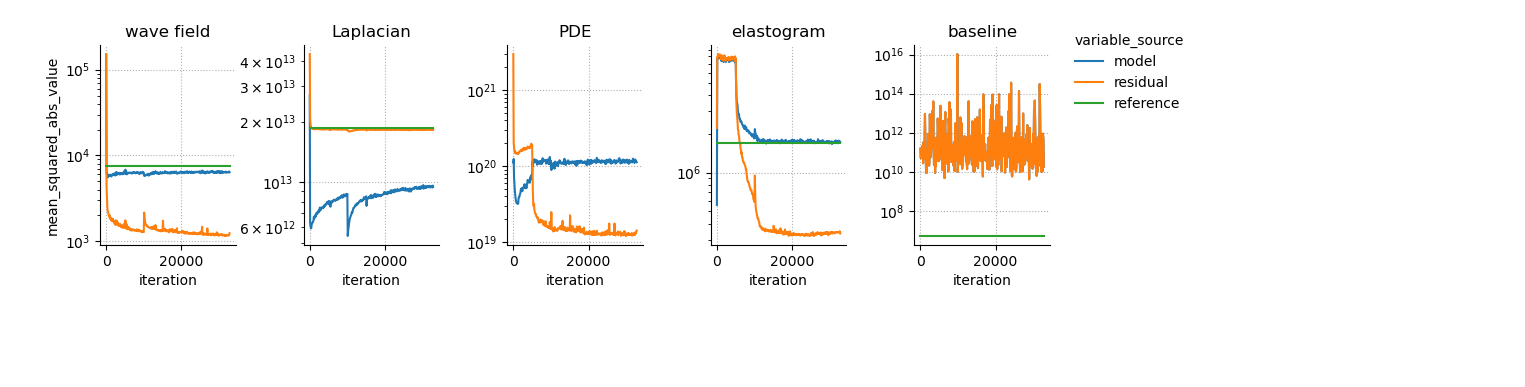

<IPython.core.display.Javascript object>


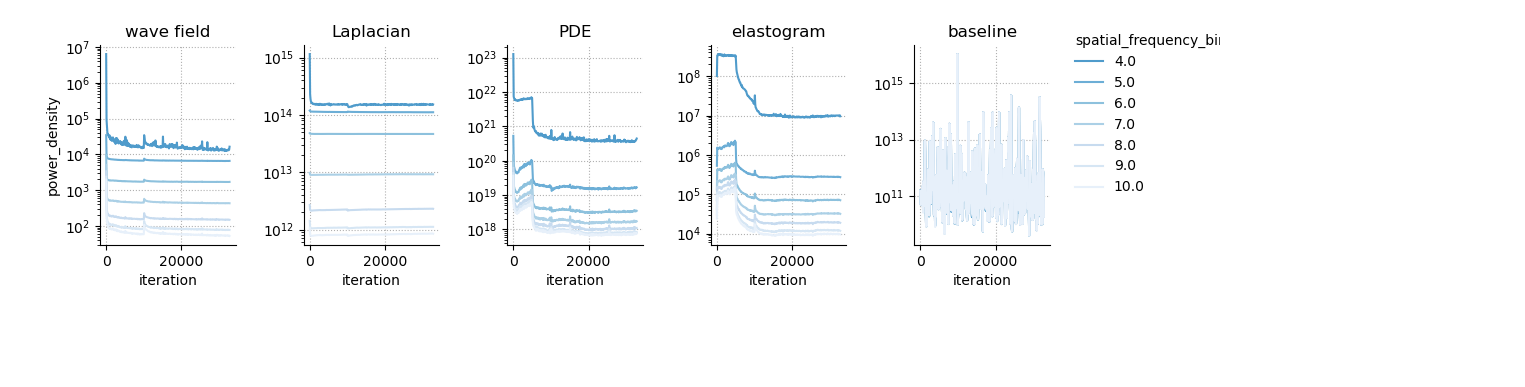

<IPython.core.display.Javascript object>


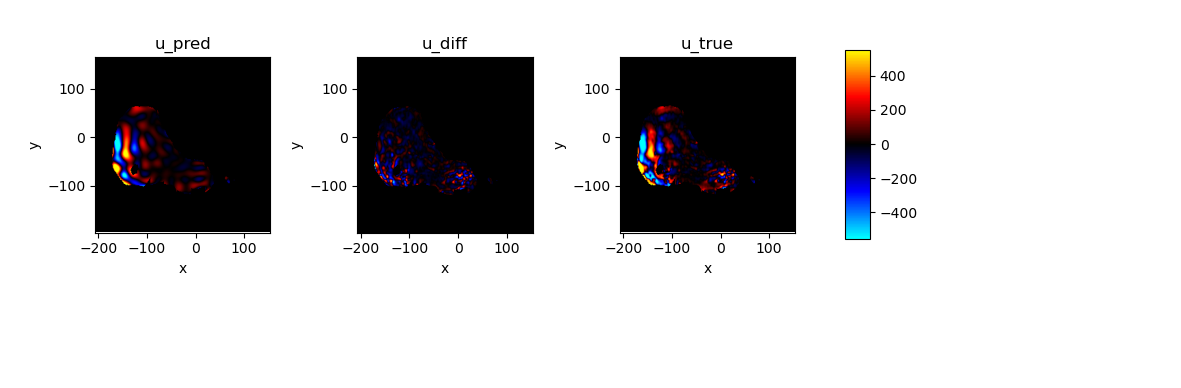

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


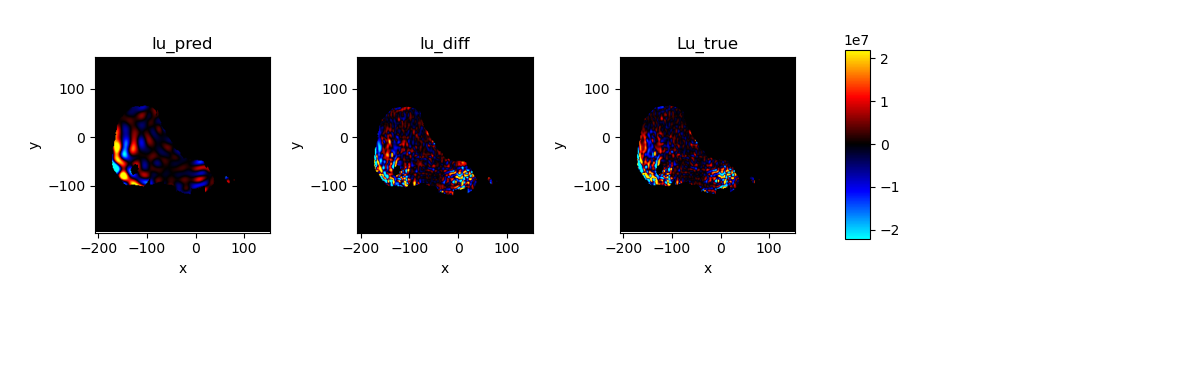

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


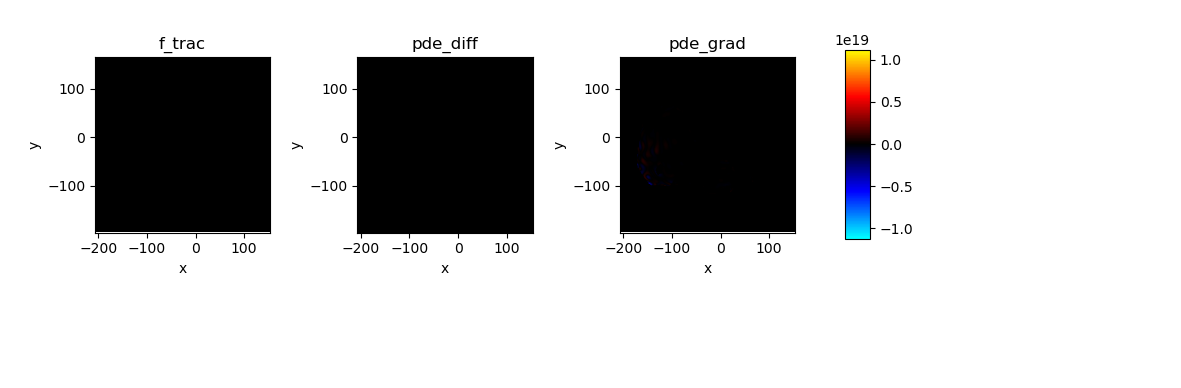

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


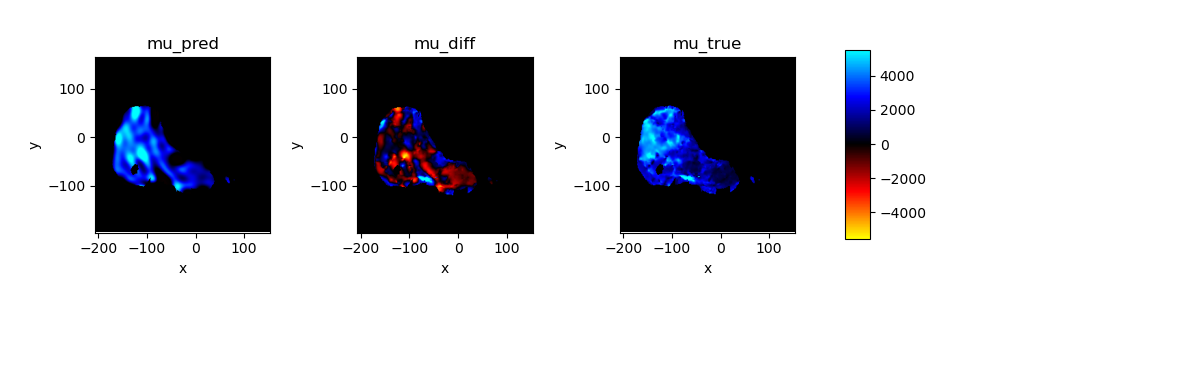

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


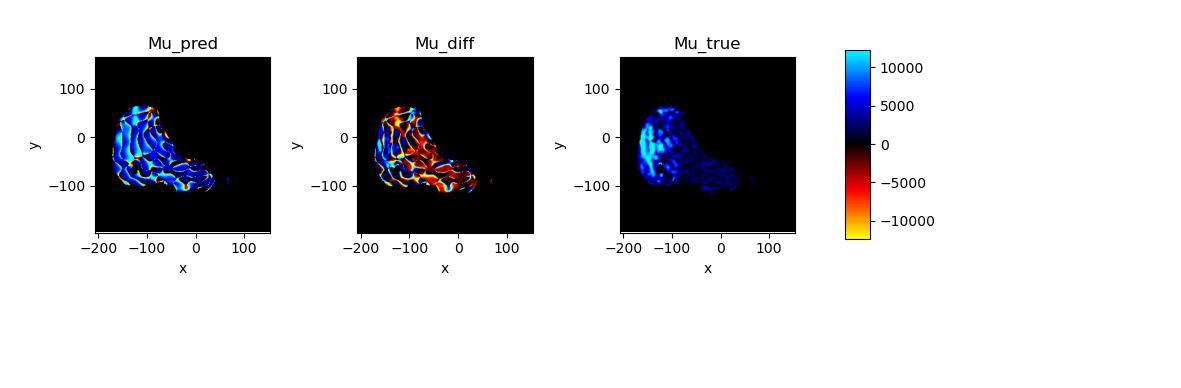

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 13.4667 (84.37%)
10        [2.68e+03, 2.01e+02, 0.00e+00]    [2.67e+03, 2.13e+02, 0.00e+00]    []  
20        [1.33e+03, 5.07e+01, 0.00e+00]    [1.32e+03, 3.85e+01, 0.00e+00]    []  
30        [7.55e+02, 8.55e+00, 0.00e+00]    [7.60e+02, 1.56e+01, 0.00e+00]    []  
40        [5.20e+02, 2.29e+00, 0.00e+00]    [5.25e+02, 6.63e+00, 0.00e+00]    []  
50        [4.29e+02, 2.54e+00, 0.00e+00]    [4.23e+02, 4.82e-01, 0.00e+00]    []  
60        [3.58e+02, 2.52e+00, 0.00e+00]    [3.67e+02, 3.13e+00, 0.00e+00]    []  
70        [3.32e+02, 6.95e-02, 0.00e+00]    [3.24e+02, 1.28e+00, 0.00e+00]    []  
80        [3.00e+02, 3.36e+00, 0.00e+00]    [2.95e+02, 1.96e+00, 0.00e+00]    []  
90        [2.76e+02, 3.80e-02, 0.00e+00]    [2.75e+02, 2.73e-02, 0.00e+00]    []  
100       [2.52e+02, 1.37e+00, 0.00e+00]    [2.56e+02, 3.66e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4967 (82.79%)
110       [2.45e+02, 1.20e-01, 0.00e+00]    [2.43e+02, 3.18e+00, 0.00e+00]    []  
120       [2.28e+02, 3.97e-01, 0.00e+00]    [2.31e+02, 9.07e-01, 0.00e+00]    []  
130       [2.18e+02, 3.27e-01, 0.00e+00]    [2.18e+02, 6.47e-03, 0.00e+00]    []  
140       [2.14e+02, 8.02e-01, 0.00e+00]    [2.11e+02, 9.11e-01, 0.00e+00]    []  
150       [2.07e+02, 2.05e+00, 0.00e+00]    [2.09e+02, 1.96e+00, 0.00e+00]    []  
160       [1.96e+02, 1.41e+00, 0.00e+00]    [1.98e+02, 5.72e+00, 0.00e+00]    []  
170       [1.99e+02, 2.79e-03, 0.00e+00]    [1.97e+02, 3.28e+00, 0.00e+00]    []  
180       [1.88e+02, 3.86e-01, 0.00e+00]    [1.90e+02, 2.10e+00, 0.00e+00]    []  
190       [1.84e+02, 6.56e-01, 0.00e+00]    [1.82e+02, 1.94e+00, 0.00e+00]    []  
200       [1.92e+02, 2.10e-04, 0.00e+00]    [1.85e+02, 5.06e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4943 (82.18%)
210       [1.76e+02, 3.26e+00, 0.00e+00]    [1.73e+02, 3.65e+00, 0.00e+00]    []  
220       [1.80e+02, 1.24e+01, 0.00e+00]    [1.78e+02, 2.74e+01, 0.00e+00]    []  
230       [1.67e+02, 4.00e-01, 0.00e+00]    [1.74e+02, 4.77e+00, 0.00e+00]    []  
240       [1.65e+02, 7.49e-01, 0.00e+00]    [1.64e+02, 2.63e-02, 0.00e+00]    []  
250       [1.53e+02, 9.88e-01, 0.00e+00]    [1.57e+02, 4.75e+00, 0.00e+00]    []  
260       [1.71e+02, 1.68e+01, 0.00e+00]    [1.71e+02, 1.03e+01, 0.00e+00]    []  
270       [1.57e+02, 8.05e-02, 0.00e+00]    [1.58e+02, 5.81e+00, 0.00e+00]    []  
280       [1.51e+02, 7.46e-01, 0.00e+00]    [1.50e+02, 6.75e+00, 0.00e+00]    []  
290       [1.52e+02, 6.79e-04, 0.00e+00]    [1.48e+02, 4.17e+00, 0.00e+00]    []  
300       [1.43e+02, 4.88e+00, 0.00e+00]    [1.48e+02, 1.01e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6385 (81.91%)
310       [1.51e+02, 6.16e+00, 0.00e+00]    [1.48e+02, 1.10e+01, 0.00e+00]    []  
320       [1.59e+02, 2.41e+00, 0.00e+00]    [1.58e+02, 2.41e+00, 0.00e+00]    []  
330       [1.49e+02, 4.05e-03, 0.00e+00]    [1.47e+02, 1.83e-01, 0.00e+00]    []  
340       [1.53e+02, 2.52e-01, 0.00e+00]    [1.50e+02, 5.13e-01, 0.00e+00]    []  
350       [1.51e+02, 4.75e-01, 0.00e+00]    [1.44e+02, 4.26e-01, 0.00e+00]    []  
360       [1.34e+02, 4.20e-01, 0.00e+00]    [1.35e+02, 4.54e+00, 0.00e+00]    []  
370       [1.32e+02, 9.74e-01, 0.00e+00]    [1.37e+02, 2.73e-02, 0.00e+00]    []  
380       [1.42e+02, 1.83e-01, 0.00e+00]    [1.39e+02, 6.43e+00, 0.00e+00]    []  
390       [1.38e+02, 2.38e+00, 0.00e+00]    [1.39e+02, 7.73e-01, 0.00e+00]    []  
400       [1.30e+02, 4.65e+00, 0.00e+00]    [1.30e+02, 5.55e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5171 (81.72%)
410       [1.38e+02, 2.01e+00, 0.00e+00]    [1.42e+02, 1.56e+00, 0.00e+00]    []  
420       [1.29e+02, 4.94e-01, 0.00e+00]    [1.29e+02, 4.65e+00, 0.00e+00]    []  
430       [1.45e+02, 3.85e-03, 0.00e+00]    [1.43e+02, 4.93e-01, 0.00e+00]    []  
440       [1.36e+02, 1.27e-01, 0.00e+00]    [1.33e+02, 3.65e-01, 0.00e+00]    []  
450       [1.36e+02, 2.37e-02, 0.00e+00]    [1.35e+02, 2.07e+00, 0.00e+00]    []  
460       [1.33e+02, 5.26e-01, 0.00e+00]    [1.34e+02, 1.76e-01, 0.00e+00]    []  
470       [1.29e+02, 9.18e-01, 0.00e+00]    [1.30e+02, 5.22e-03, 0.00e+00]    []  
480       [1.25e+02, 7.79e-02, 0.00e+00]    [1.29e+02, 4.63e-01, 0.00e+00]    []  
490       [1.28e+02, 4.83e-03, 0.00e+00]    [1.24e+02, 2.08e-01, 0.00e+00]    []  
500       [1.27e+02, 2.56e-01, 0.00e+00]    [1.28e+02, 1.29e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5066 (81.60%)
510       [1.30e+02, 8.44e+00, 0.00e+00]    [1.33e+02, 3.52e+00, 0.00e+00]    []  
520       [1.30e+02, 5.25e+00, 0.00e+00]    [1.31e+02, 2.33e+00, 0.00e+00]    []  
530       [1.25e+02, 8.08e-02, 0.00e+00]    [1.26e+02, 2.73e-01, 0.00e+00]    []  
540       [1.31e+02, 3.80e-02, 0.00e+00]    [1.33e+02, 2.62e-01, 0.00e+00]    []  
550       [1.33e+02, 5.50e+00, 0.00e+00]    [1.28e+02, 1.82e+01, 0.00e+00]    []  
560       [1.28e+02, 1.15e+00, 0.00e+00]    [1.25e+02, 2.89e+00, 0.00e+00]    []  
570       [1.15e+02, 9.94e-01, 0.00e+00]    [1.20e+02, 1.57e+00, 0.00e+00]    []  
580       [1.31e+02, 8.88e-01, 0.00e+00]    [1.34e+02, 1.24e-03, 0.00e+00]    []  
590       [1.25e+02, 3.75e-01, 0.00e+00]    [1.25e+02, 3.99e-01, 0.00e+00]    []  
600       [1.20e+02, 8.23e-02, 0.00e+00]    [1.22e+02, 5.63e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9711 (81.58%)
610       [1.18e+02, 2.01e-01, 0.00e+00]    [1.19e+02, 8.78e-01, 0.00e+00]    []  
620       [1.25e+02, 3.69e-01, 0.00e+00]    [1.19e+02, 7.35e-01, 0.00e+00]    []  
630       [1.22e+02, 6.17e-02, 0.00e+00]    [1.23e+02, 3.89e-02, 0.00e+00]    []  
640       [1.14e+02, 3.30e+00, 0.00e+00]    [1.15e+02, 9.82e-01, 0.00e+00]    []  
650       [1.15e+02, 5.49e+00, 0.00e+00]    [1.18e+02, 2.32e-01, 0.00e+00]    []  
660       [1.25e+02, 1.63e-01, 0.00e+00]    [1.21e+02, 4.31e-02, 0.00e+00]    []  
670       [1.24e+02, 2.13e-01, 0.00e+00]    [1.23e+02, 3.22e-01, 0.00e+00]    []  
680       [1.28e+02, 5.49e-02, 0.00e+00]    [1.27e+02, 2.05e+00, 0.00e+00]    []  
690       [1.18e+02, 1.17e+00, 0.00e+00]    [1.18e+02, 2.60e+00, 0.00e+00]    []  
700       [1.16e+02, 2.32e-03, 0.00e+00]    [1.16e+02, 3.86e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8670 (81.55%)
710       [1.18e+02, 4.77e-01, 0.00e+00]    [1.18e+02, 9.88e-02, 0.00e+00]    []  
720       [1.22e+02, 1.39e-02, 0.00e+00]    [1.22e+02, 5.27e-01, 0.00e+00]    []  
730       [1.28e+02, 1.29e+00, 0.00e+00]    [1.27e+02, 2.48e+00, 0.00e+00]    []  
740       [1.21e+02, 8.51e-01, 0.00e+00]    [1.17e+02, 6.95e-03, 0.00e+00]    []  
750       [1.31e+02, 1.05e+00, 0.00e+00]    [1.32e+02, 4.56e-01, 0.00e+00]    []  
760       [1.22e+02, 1.05e+00, 0.00e+00]    [1.20e+02, 2.95e+00, 0.00e+00]    []  
770       [1.18e+02, 7.07e-01, 0.00e+00]    [1.18e+02, 1.39e+00, 0.00e+00]    []  
780       [1.17e+02, 5.64e+00, 0.00e+00]    [1.20e+02, 2.70e-01, 0.00e+00]    []  
790       [1.21e+02, 2.01e-01, 0.00e+00]    [1.22e+02, 2.70e+00, 0.00e+00]    []  
800       [1.10e+02, 3.74e-01, 0.00e+00]    [1.14e+02, 9.69e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9296 (81.54%)
810       [1.17e+02, 8.58e-02, 0.00e+00]    [1.12e+02, 3.11e+00, 0.00e+00]    []  
820       [1.20e+02, 1.64e-02, 0.00e+00]    [1.19e+02, 1.77e+00, 0.00e+00]    []  
830       [1.29e+02, 5.37e-03, 0.00e+00]    [1.28e+02, 3.62e+00, 0.00e+00]    []  
840       [1.19e+02, 5.89e-01, 0.00e+00]    [1.19e+02, 7.73e-02, 0.00e+00]    []  
850       [1.13e+02, 1.32e+00, 0.00e+00]    [1.15e+02, 2.51e-01, 0.00e+00]    []  
860       [1.07e+02, 2.69e-01, 0.00e+00]    [1.09e+02, 6.11e-01, 0.00e+00]    []  
870       [1.16e+02, 1.25e-01, 0.00e+00]    [1.17e+02, 2.20e-01, 0.00e+00]    []  
880       [1.12e+02, 2.60e+00, 0.00e+00]    [1.13e+02, 3.52e+00, 0.00e+00]    []  
890       [1.18e+02, 1.10e-05, 0.00e+00]    [1.24e+02, 3.17e-01, 0.00e+00]    []  
900       [1.16e+02, 2.24e+00, 0.00e+00]    [1.18e+02, 9.01e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8875 (81.52%)
910       [1.22e+02, 6.72e+00, 0.00e+00]    [1.22e+02, 1.82e+00, 0.00e+00]    []  
920       [1.20e+02, 7.05e-01, 0.00e+00]    [1.17e+02, 1.48e-03, 0.00e+00]    []  
930       [1.17e+02, 2.90e+00, 0.00e+00]    [1.15e+02, 3.29e+00, 0.00e+00]    []  
940       [1.13e+02, 3.30e+00, 0.00e+00]    [1.13e+02, 1.88e-01, 0.00e+00]    []  
950       [1.08e+02, 2.11e-01, 0.00e+00]    [1.10e+02, 6.03e-01, 0.00e+00]    []  
960       [1.08e+02, 7.08e-02, 0.00e+00]    [1.13e+02, 2.93e+00, 0.00e+00]    []  
970       [1.16e+02, 7.18e-01, 0.00e+00]    [1.16e+02, 1.95e+00, 0.00e+00]    []  
980       [1.21e+02, 2.29e+00, 0.00e+00]    [1.20e+02, 1.56e+00, 0.00e+00]    []  
990       [1.08e+02, 3.14e+00, 0.00e+00]    [1.09e+02, 1.43e+00, 0.00e+00]    []  
1000      [1.09e+02, 4.05e-01, 0.00e+00]    [1.07e+02, 2.77e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6459 (81.49%)
1010      [1.09e+02, 6.64e+00, 0.00e+00]    [1.11e+02, 2.63e-01, 0.00e+00]    []  
1020      [1.16e+02, 5.08e-01, 0.00e+00]    [1.20e+02, 4.14e+00, 0.00e+00]    []  
1030      [1.09e+02, 5.76e+00, 0.00e+00]    [1.12e+02, 1.59e+00, 0.00e+00]    []  
1040      [1.11e+02, 4.23e+00, 0.00e+00]    [1.15e+02, 1.65e+00, 0.00e+00]    []  
1050      [1.05e+02, 1.07e+00, 0.00e+00]    [1.08e+02, 6.92e+00, 0.00e+00]    []  
1060      [1.06e+02, 4.29e-03, 0.00e+00]    [1.09e+02, 7.64e-01, 0.00e+00]    []  
1070      [1.10e+02, 1.14e+00, 0.00e+00]    [1.07e+02, 6.71e-01, 0.00e+00]    []  
1080      [1.06e+02, 1.43e+00, 0.00e+00]    [1.08e+02, 1.08e+00, 0.00e+00]    []  
1090      [1.10e+02, 1.06e+00, 0.00e+00]    [1.11e+02, 4.31e+00, 0.00e+00]    []  
1100      [1.03e+02, 4.90e+00, 0.00e+00]    [1.05e+02, 2.79e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5764 (81.45%)
1110      [1.07e+02, 1.60e-01, 0.00e+00]    [1.06e+02, 2.41e-02, 0.00e+00]    []  
1120      [1.15e+02, 7.83e-01, 0.00e+00]    [1.12e+02, 1.50e+00, 0.00e+00]    []  
1130      [1.03e+02, 3.60e+00, 0.00e+00]    [1.07e+02, 1.73e-01, 0.00e+00]    []  
1140      [1.06e+02, 2.51e-01, 0.00e+00]    [1.05e+02, 5.02e-02, 0.00e+00]    []  
1150      [1.14e+02, 1.54e-01, 0.00e+00]    [1.14e+02, 1.67e-02, 0.00e+00]    []  
1160      [1.08e+02, 9.97e-03, 0.00e+00]    [1.09e+02, 1.18e+00, 0.00e+00]    []  
1170      [1.15e+02, 4.13e-01, 0.00e+00]    [1.14e+02, 1.91e+00, 0.00e+00]    []  
1180      [1.04e+02, 1.84e+00, 0.00e+00]    [1.07e+02, 3.42e-01, 0.00e+00]    []  
1190      [1.06e+02, 8.66e-01, 0.00e+00]    [1.12e+02, 1.25e+00, 0.00e+00]    []  
1200      [1.09e+02, 1.23e+00, 0.00e+00]    [1.10e+02, 2.98e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6335 (81.44%)
1210      [1.08e+02, 2.44e-01, 0.00e+00]    [1.09e+02, 3.65e+00, 0.00e+00]    []  
1220      [1.10e+02, 2.38e-02, 0.00e+00]    [1.08e+02, 1.38e+01, 0.00e+00]    []  
1230      [1.14e+02, 5.08e+00, 0.00e+00]    [1.12e+02, 1.46e+00, 0.00e+00]    []  
1240      [1.08e+02, 4.18e-01, 0.00e+00]    [1.08e+02, 1.19e+00, 0.00e+00]    []  
1250      [1.01e+02, 4.96e+00, 0.00e+00]    [1.08e+02, 7.75e-02, 0.00e+00]    []  
1260      [1.08e+02, 6.53e-04, 0.00e+00]    [1.07e+02, 1.28e-02, 0.00e+00]    []  
1270      [1.05e+02, 2.37e+00, 0.00e+00]    [1.05e+02, 3.15e-02, 0.00e+00]    []  
1280      [1.12e+02, 1.27e+01, 0.00e+00]    [1.13e+02, 4.75e+00, 0.00e+00]    []  
1290      [1.11e+02, 1.25e+00, 0.00e+00]    [1.09e+02, 8.26e+00, 0.00e+00]    []  
1300      [1.05e+02, 5.06e-02, 0.00e+00]    [1.04e+02, 1.39e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4640 (81.41%)
1310      [1.04e+02, 8.38e-02, 0.00e+00]    [1.04e+02, 1.28e+00, 0.00e+00]    []  
1320      [1.03e+02, 5.37e+00, 0.00e+00]    [1.03e+02, 1.25e+00, 0.00e+00]    []  
1330      [1.02e+02, 5.22e-01, 0.00e+00]    [1.08e+02, 1.89e-01, 0.00e+00]    []  
1340      [1.09e+02, 2.06e-02, 0.00e+00]    [1.12e+02, 2.44e+00, 0.00e+00]    []  
1350      [1.13e+02, 3.82e+00, 0.00e+00]    [1.09e+02, 2.74e-02, 0.00e+00]    []  
1360      [9.98e+01, 6.14e-01, 0.00e+00]    [1.02e+02, 3.30e+00, 0.00e+00]    []  
1370      [1.06e+02, 4.17e+00, 0.00e+00]    [1.09e+02, 6.05e-01, 0.00e+00]    []  
1380      [1.04e+02, 4.73e-02, 0.00e+00]    [1.03e+02, 1.85e-02, 0.00e+00]    []  
1390      [1.06e+02, 7.10e-01, 0.00e+00]    [1.04e+02, 1.28e+00, 0.00e+00]    []  
1400      [1.02e+02, 1.80e+00, 0.00e+00]    [1.02e+02, 1.09e+01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4523 (81.38%)
1410      [1.12e+02, 9.22e-02, 0.00e+00]    [1.14e+02, 8.71e+00, 0.00e+00]    []  
1420      [1.07e+02, 4.25e-01, 0.00e+00]    [1.06e+02, 1.74e-02, 0.00e+00]    []  
1430      [1.07e+02, 1.35e-02, 0.00e+00]    [1.08e+02, 5.06e+00, 0.00e+00]    []  
1440      [1.07e+02, 2.97e-01, 0.00e+00]    [1.05e+02, 8.79e-02, 0.00e+00]    []  
1450      [1.01e+02, 4.49e+00, 0.00e+00]    [9.96e+01, 6.39e-03, 0.00e+00]    []  
1460      [1.00e+02, 1.16e-01, 0.00e+00]    [1.02e+02, 5.81e-01, 0.00e+00]    []  
1470      [1.01e+02, 1.84e-01, 0.00e+00]    [1.03e+02, 1.04e+00, 0.00e+00]    []  
1480      [1.01e+02, 5.08e-03, 0.00e+00]    [1.05e+02, 5.15e-01, 0.00e+00]    []  
1490      [1.00e+02, 1.40e+00, 0.00e+00]    [1.01e+02, 5.49e-01, 0.00e+00]    []  
1500      [9.98e+01, 6.94e-02, 0.00e+00]    [9.92e+01, 3.39e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8790 (81.38%)
1510      [1.02e+02, 1.20e-01, 0.00e+00]    [1.04e+02, 4.41e-01, 0.00e+00]    []  
1520      [1.07e+02, 7.76e-01, 0.00e+00]    [1.08e+02, 6.30e-01, 0.00e+00]    []  
1530      [1.02e+02, 3.52e-01, 0.00e+00]    [1.03e+02, 1.42e-01, 0.00e+00]    []  
1540      [9.85e+01, 7.27e-01, 0.00e+00]    [1.02e+02, 1.83e-01, 0.00e+00]    []  
1550      [9.71e+01, 1.02e-01, 0.00e+00]    [9.83e+01, 3.09e-01, 0.00e+00]    []  
1560      [9.91e+01, 1.10e-01, 0.00e+00]    [9.89e+01, 9.04e-01, 0.00e+00]    []  
1570      [9.47e+01, 7.53e-01, 0.00e+00]    [9.72e+01, 2.08e+00, 0.00e+00]    []  
1580      [1.04e+02, 3.74e+00, 0.00e+00]    [1.01e+02, 2.51e-01, 0.00e+00]    []  
1590      [1.01e+02, 3.21e-01, 0.00e+00]    [9.98e+01, 1.69e+00, 0.00e+00]    []  
1600      [9.90e+01, 2.27e+00, 0.00e+00]    [1.02e+02, 1.30e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8877 (81.38%)
1610      [9.90e+01, 2.34e-01, 0.00e+00]    [9.94e+01, 3.02e-01, 0.00e+00]    []  
1620      [9.78e+01, 2.47e+00, 0.00e+00]    [9.67e+01, 7.01e-01, 0.00e+00]    []  
1630      [9.62e+01, 2.93e+00, 0.00e+00]    [9.74e+01, 1.85e+00, 0.00e+00]    []  
1640      [1.01e+02, 2.34e+00, 0.00e+00]    [9.74e+01, 2.50e+00, 0.00e+00]    []  
1650      [1.08e+02, 3.68e-01, 0.00e+00]    [1.08e+02, 8.89e-01, 0.00e+00]    []  
1660      [1.00e+02, 5.17e-02, 0.00e+00]    [1.01e+02, 4.82e-05, 0.00e+00]    []  
1670      [9.82e+01, 1.33e+00, 0.00e+00]    [9.84e+01, 6.60e-01, 0.00e+00]    []  
1680      [1.05e+02, 3.75e-01, 0.00e+00]    [1.04e+02, 3.70e-01, 0.00e+00]    []  
1690      [1.07e+02, 1.89e+00, 0.00e+00]    [1.07e+02, 2.18e+00, 0.00e+00]    []  
1700      [1.04e+02, 8.78e-01, 0.00e+00]    [1.01e+02, 1.09e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0884 (81.40%)
1710      [9.87e+01, 1.21e-02, 0.00e+00]    [1.00e+02, 1.19e+00, 0.00e+00]    []  
1720      [1.06e+02, 5.75e+00, 0.00e+00]    [1.03e+02, 1.05e+00, 0.00e+00]    []  
1730      [9.96e+01, 9.65e-01, 0.00e+00]    [9.85e+01, 2.82e-01, 0.00e+00]    []  
1740      [9.91e+01, 4.00e-03, 0.00e+00]    [9.72e+01, 1.35e+00, 0.00e+00]    []  
1750      [1.02e+02, 6.99e-01, 0.00e+00]    [1.02e+02, 6.53e+00, 0.00e+00]    []  
1760      [9.97e+01, 2.61e-01, 0.00e+00]    [9.91e+01, 2.17e+00, 0.00e+00]    []  
1770      [9.43e+01, 1.28e+00, 0.00e+00]    [9.60e+01, 1.69e+00, 0.00e+00]    []  
1780      [9.48e+01, 2.08e+00, 0.00e+00]    [9.68e+01, 4.78e+00, 0.00e+00]    []  
1790      [9.84e+01, 7.03e-01, 0.00e+00]    [9.99e+01, 1.50e-01, 0.00e+00]    []  
1800      [1.05e+02, 6.89e-01, 0.00e+00]    [1.07e+02, 1.24e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7689 (81.39%)
1810      [1.10e+02, 4.93e+00, 0.00e+00]    [1.08e+02, 4.80e+00, 0.00e+00]    []  
1820      [1.09e+02, 2.92e-01, 0.00e+00]    [1.03e+02, 1.51e-01, 0.00e+00]    []  
1830      [9.88e+01, 3.08e-01, 0.00e+00]    [1.01e+02, 7.86e-01, 0.00e+00]    []  
1840      [9.44e+01, 2.98e+00, 0.00e+00]    [9.65e+01, 1.05e-01, 0.00e+00]    []  
1850      [9.31e+01, 7.88e-01, 0.00e+00]    [9.57e+01, 3.08e-04, 0.00e+00]    []  
1860      [9.87e+01, 3.62e-01, 0.00e+00]    [9.80e+01, 7.66e-02, 0.00e+00]    []  
1870      [9.59e+01, 5.78e+00, 0.00e+00]    [9.66e+01, 2.74e+00, 0.00e+00]    []  
1880      [9.29e+01, 9.14e-01, 0.00e+00]    [9.54e+01, 4.74e+00, 0.00e+00]    []  
1890      [1.03e+02, 1.44e+00, 0.00e+00]    [1.02e+02, 1.48e+00, 0.00e+00]    []  
1900      [1.01e+02, 2.06e+00, 0.00e+00]    [1.00e+02, 3.57e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7581 (81.39%)
1910      [9.35e+01, 3.64e-01, 0.00e+00]    [9.73e+01, 5.63e-01, 0.00e+00]    []  
1920      [1.03e+02, 1.83e-01, 0.00e+00]    [9.87e+01, 1.00e+00, 0.00e+00]    []  
1930      [1.01e+02, 5.64e-01, 0.00e+00]    [1.05e+02, 5.49e-01, 0.00e+00]    []  
1940      [1.01e+02, 1.14e-03, 0.00e+00]    [1.00e+02, 1.23e+00, 0.00e+00]    []  
1950      [1.07e+02, 9.37e-02, 0.00e+00]    [1.07e+02, 1.47e-01, 0.00e+00]    []  
1960      [1.07e+02, 2.14e-02, 0.00e+00]    [1.06e+02, 8.62e-01, 0.00e+00]    []  
1970      [1.07e+02, 1.10e+00, 0.00e+00]    [1.08e+02, 1.57e-01, 0.00e+00]    []  
1980      [9.84e+01, 5.09e-01, 0.00e+00]    [9.68e+01, 1.00e+00, 0.00e+00]    []  
1990      [9.75e+01, 2.86e-01, 0.00e+00]    [9.72e+01, 4.30e-01, 0.00e+00]    []  
2000      [9.37e+01, 1.15e+00, 0.00e+00]    [9.65e+01, 6.20e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8545 (81.39%)
2010      [9.71e+01, 7.66e-02, 0.00e+00]    [9.69e+01, 2.94e+00, 0.00e+00]    []  
2020      [1.01e+02, 2.71e+00, 0.00e+00]    [1.05e+02, 1.36e-01, 0.00e+00]    []  
2030      [9.76e+01, 1.19e-01, 0.00e+00]    [9.59e+01, 8.24e-03, 0.00e+00]    []  
2040      [9.59e+01, 1.83e-02, 0.00e+00]    [1.00e+02, 3.38e+00, 0.00e+00]    []  
2050      [1.00e+02, 1.25e+00, 0.00e+00]    [9.74e+01, 1.79e-01, 0.00e+00]    []  
2060      [9.11e+01, 2.36e+00, 0.00e+00]    [9.52e+01, 3.78e-01, 0.00e+00]    []  
2070      [9.98e+01, 1.47e-01, 0.00e+00]    [9.96e+01, 7.46e-02, 0.00e+00]    []  
2080      [9.38e+01, 5.91e-01, 0.00e+00]    [9.67e+01, 6.95e+00, 0.00e+00]    []  
2090      [9.54e+01, 1.17e+01, 0.00e+00]    [9.54e+01, 3.27e+00, 0.00e+00]    []  
2100      [9.94e+01, 2.86e+00, 0.00e+00]    [1.00e+02, 2.73e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4561 (81.37%)
2110      [9.88e+01, 9.18e-02, 0.00e+00]    [9.46e+01, 1.47e+00, 0.00e+00]    []  
2120      [9.34e+01, 1.24e+00, 0.00e+00]    [9.44e+01, 1.98e-02, 0.00e+00]    []  
2130      [9.46e+01, 1.93e+00, 0.00e+00]    [9.48e+01, 4.75e+00, 0.00e+00]    []  
2140      [9.38e+01, 5.38e-03, 0.00e+00]    [9.80e+01, 2.55e+00, 0.00e+00]    []  
2150      [9.12e+01, 4.22e-02, 0.00e+00]    [9.23e+01, 1.17e+00, 0.00e+00]    []  
2160      [9.41e+01, 1.21e+00, 0.00e+00]    [9.75e+01, 3.06e+00, 0.00e+00]    []  
2170      [9.64e+01, 1.69e+00, 0.00e+00]    [9.84e+01, 1.82e-01, 0.00e+00]    []  
2180      [9.71e+01, 3.43e-01, 0.00e+00]    [9.90e+01, 1.84e+00, 0.00e+00]    []  
2190      [9.94e+01, 7.40e-01, 0.00e+00]    [1.01e+02, 2.26e-02, 0.00e+00]    []  
2200      [9.26e+01, 1.12e-01, 0.00e+00]    [9.40e+01, 2.45e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1274 (81.39%)
2210      [9.47e+01, 1.65e+00, 0.00e+00]    [9.30e+01, 1.94e+00, 0.00e+00]    []  
2220      [9.64e+01, 7.87e-01, 0.00e+00]    [9.82e+01, 2.84e-01, 0.00e+00]    []  
2230      [9.98e+01, 2.51e+00, 0.00e+00]    [1.01e+02, 1.32e+00, 0.00e+00]    []  
2240      [9.90e+01, 1.27e+00, 0.00e+00]    [9.76e+01, 2.16e-02, 0.00e+00]    []  
2250      [9.45e+01, 1.02e-01, 0.00e+00]    [9.50e+01, 1.65e+00, 0.00e+00]    []  
2260      [9.17e+01, 2.67e+00, 0.00e+00]    [9.37e+01, 5.75e-01, 0.00e+00]    []  
2270      [9.96e+01, 3.04e+00, 0.00e+00]    [9.75e+01, 4.36e-02, 0.00e+00]    []  
2280      [9.73e+01, 6.74e-02, 0.00e+00]    [9.87e+01, 1.05e+00, 0.00e+00]    []  
2290      [9.72e+01, 1.94e+00, 0.00e+00]    [9.60e+01, 5.98e-03, 0.00e+00]    []  
2300      [9.25e+01, 9.73e-02, 0.00e+00]    [9.62e+01, 9.58e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7463 (81.44%)
2310      [9.75e+01, 9.63e-04, 0.00e+00]    [9.71e+01, 6.18e-01, 0.00e+00]    []  
2320      [9.37e+01, 1.96e+00, 0.00e+00]    [9.47e+01, 1.18e-03, 0.00e+00]    []  
2330      [9.59e+01, 4.65e+00, 0.00e+00]    [9.45e+01, 1.97e+00, 0.00e+00]    []  
2340      [9.70e+01, 5.48e-01, 0.00e+00]    [9.48e+01, 2.15e-02, 0.00e+00]    []  
2350      [9.79e+01, 4.03e-01, 0.00e+00]    [9.44e+01, 8.28e-01, 0.00e+00]    []  
2360      [8.95e+01, 5.33e-01, 0.00e+00]    [9.18e+01, 1.30e+00, 0.00e+00]    []  
2370      [9.32e+01, 7.24e-01, 0.00e+00]    [9.52e+01, 2.72e+00, 0.00e+00]    []  
2380      [9.17e+01, 6.92e-01, 0.00e+00]    [9.42e+01, 3.67e-01, 0.00e+00]    []  
2390      [9.96e+01, 8.08e+00, 0.00e+00]    [1.01e+02, 6.84e-01, 0.00e+00]    []  
2400      [9.67e+01, 1.22e+00, 0.00e+00]    [9.65e+01, 2.35e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6799 (81.46%)
2410      [9.30e+01, 4.54e-01, 0.00e+00]    [9.41e+01, 1.03e-01, 0.00e+00]    []  
2420      [1.00e+02, 5.85e+00, 0.00e+00]    [9.99e+01, 1.07e+01, 0.00e+00]    []  
2430      [1.01e+02, 5.79e-01, 0.00e+00]    [1.02e+02, 7.16e+00, 0.00e+00]    []  
2440      [9.85e+01, 2.31e-01, 0.00e+00]    [9.77e+01, 2.00e+00, 0.00e+00]    []  
2450      [9.70e+01, 7.79e-01, 0.00e+00]    [9.64e+01, 1.89e+00, 0.00e+00]    []  
2460      [9.84e+01, 1.63e+00, 0.00e+00]    [9.94e+01, 2.21e-02, 0.00e+00]    []  
2470      [8.87e+01, 2.90e-01, 0.00e+00]    [9.41e+01, 2.40e-01, 0.00e+00]    []  
2480      [9.75e+01, 1.82e+00, 0.00e+00]    [9.65e+01, 6.57e-01, 0.00e+00]    []  
2490      [9.72e+01, 1.07e+00, 0.00e+00]    [9.75e+01, 8.76e-02, 0.00e+00]    []  
2500      [8.88e+01, 1.45e+00, 0.00e+00]    [8.95e+01, 2.15e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.5537 (81.59%)
2510      [9.15e+01, 1.35e-01, 0.00e+00]    [9.16e+01, 1.90e-01, 0.00e+00]    []  
2520      [8.95e+01, 1.26e-01, 0.00e+00]    [9.05e+01, 1.10e-01, 0.00e+00]    []  
2530      [1.02e+02, 1.80e+00, 0.00e+00]    [1.00e+02, 4.67e-01, 0.00e+00]    []  
2540      [9.15e+01, 8.46e-01, 0.00e+00]    [9.56e+01, 2.01e+00, 0.00e+00]    []  
2550      [9.35e+01, 6.21e-01, 0.00e+00]    [9.23e+01, 1.08e-03, 0.00e+00]    []  
2560      [9.33e+01, 1.09e-01, 0.00e+00]    [9.12e+01, 9.18e-01, 0.00e+00]    []  
2570      [9.82e+01, 2.98e+00, 0.00e+00]    [9.52e+01, 3.69e-01, 0.00e+00]    []  
2580      [9.46e+01, 1.15e+00, 0.00e+00]    [9.63e+01, 8.95e-02, 0.00e+00]    []  
2590      [9.85e+01, 1.30e-02, 0.00e+00]    [9.79e+01, 4.42e-01, 0.00e+00]    []  
2600      [1.03e+02, 3.47e-04, 0.00e+00]    [1.02e+02, 3.72e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1687 (81.59%)
2610      [9.48e+01, 1.84e-02, 0.00e+00]    [9.31e+01, 2.09e+00, 0.00e+00]    []  
2620      [9.49e+01, 6.96e-02, 0.00e+00]    [9.47e+01, 1.66e+00, 0.00e+00]    []  
2630      [9.43e+01, 9.59e-01, 0.00e+00]    [9.54e+01, 2.17e+00, 0.00e+00]    []  
2640      [9.75e+01, 3.03e+00, 0.00e+00]    [9.60e+01, 2.68e+00, 0.00e+00]    []  
2650      [1.01e+02, 8.20e+00, 0.00e+00]    [1.00e+02, 2.57e+00, 0.00e+00]    []  
2660      [9.08e+01, 1.83e-01, 0.00e+00]    [9.27e+01, 2.59e+00, 0.00e+00]    []  
2670      [9.25e+01, 9.86e-01, 0.00e+00]    [9.35e+01, 2.48e-03, 0.00e+00]    []  
2680      [9.50e+01, 2.42e+00, 0.00e+00]    [9.46e+01, 1.32e-01, 0.00e+00]    []  
2690      [9.18e+01, 1.81e-01, 0.00e+00]    [9.37e+01, 2.08e+00, 0.00e+00]    []  
2700      [9.69e+01, 3.79e-01, 0.00e+00]    [9.78e+01, 8.08e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1549 (81.60%)
2710      [9.28e+01, 4.65e-01, 0.00e+00]    [9.38e+01, 1.28e+00, 0.00e+00]    []  
2720      [1.02e+02, 2.88e-01, 0.00e+00]    [1.02e+02, 3.03e+00, 0.00e+00]    []  
2730      [9.31e+01, 3.90e+00, 0.00e+00]    [9.54e+01, 7.18e+00, 0.00e+00]    []  
2740      [9.65e+01, 2.54e+00, 0.00e+00]    [9.63e+01, 1.79e+00, 0.00e+00]    []  
2750      [9.49e+01, 4.14e-05, 0.00e+00]    [9.72e+01, 1.64e-01, 0.00e+00]    []  
2760      [9.27e+01, 2.34e+00, 0.00e+00]    [9.12e+01, 3.10e-01, 0.00e+00]    []  
2770      [9.14e+01, 3.65e-01, 0.00e+00]    [9.13e+01, 2.84e-02, 0.00e+00]    []  
2780      [9.31e+01, 1.13e+00, 0.00e+00]    [9.25e+01, 5.19e-01, 0.00e+00]    []  
2790      [9.04e+01, 6.92e-01, 0.00e+00]    [8.93e+01, 5.59e-01, 0.00e+00]    []  
2800      [9.37e+01, 9.96e-02, 0.00e+00]    [9.23e+01, 1.12e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9786 (81.54%)
2810      [8.88e+01, 1.07e-01, 0.00e+00]    [8.87e+01, 8.92e-01, 0.00e+00]    []  
2820      [9.30e+01, 8.62e-01, 0.00e+00]    [9.48e+01, 2.86e-01, 0.00e+00]    []  
2830      [9.45e+01, 2.45e+00, 0.00e+00]    [9.56e+01, 3.58e+00, 0.00e+00]    []  
2840      [9.54e+01, 3.05e+00, 0.00e+00]    [9.52e+01, 1.59e+00, 0.00e+00]    []  
2850      [9.62e+01, 2.69e+00, 0.00e+00]    [9.58e+01, 4.55e+00, 0.00e+00]    []  
2860      [8.74e+01, 1.56e-02, 0.00e+00]    [9.00e+01, 1.35e-02, 0.00e+00]    []  
2870      [9.75e+01, 1.79e+00, 0.00e+00]    [9.68e+01, 1.28e+00, 0.00e+00]    []  
2880      [9.90e+01, 4.32e-01, 0.00e+00]    [9.72e+01, 1.42e-01, 0.00e+00]    []  
2890      [9.54e+01, 4.98e-01, 0.00e+00]    [9.39e+01, 6.33e+00, 0.00e+00]    []  
2900      [9.90e+01, 6.02e+00, 0.00e+00]    [9.90e+01, 8.79e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.2371 (81.54%)
2910      [9.21e+01, 1.91e-01, 0.00e+00]    [9.14e+01, 4.60e-01, 0.00e+00]    []  
2920      [9.51e+01, 8.62e-01, 0.00e+00]    [9.42e+01, 2.06e+00, 0.00e+00]    []  
2930      [8.85e+01, 2.28e+00, 0.00e+00]    [9.12e+01, 8.88e-01, 0.00e+00]    []  
2940      [9.10e+01, 2.42e+00, 0.00e+00]    [9.15e+01, 1.03e+01, 0.00e+00]    []  
2950      [9.18e+01, 5.00e+00, 0.00e+00]    [9.20e+01, 2.36e-02, 0.00e+00]    []  
2960      [8.85e+01, 5.28e-01, 0.00e+00]    [9.14e+01, 3.67e+00, 0.00e+00]    []  
2970      [8.65e+01, 2.58e+00, 0.00e+00]    [8.93e+01, 1.87e+01, 0.00e+00]    []  
2980      [9.65e+01, 6.52e-02, 0.00e+00]    [9.50e+01, 7.75e-04, 0.00e+00]    []  
2990      [9.34e+01, 1.70e+00, 0.00e+00]    [9.25e+01, 8.60e-01, 0.00e+00]    []  
3000      [8.87e+01, 1.90e-01, 0.00e+00]    [9.00e+01, 3.29e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1576 (81.55%)
3010      [8.66e+01, 3.39e-01, 0.00e+00]    [8.84e+01, 2.09e+00, 0.00e+00]    []  
3020      [9.06e+01, 2.69e+00, 0.00e+00]    [8.95e+01, 8.65e-02, 0.00e+00]    []  
3030      [9.28e+01, 3.04e-02, 0.00e+00]    [9.20e+01, 5.64e-02, 0.00e+00]    []  
3040      [9.23e+01, 4.10e+00, 0.00e+00]    [9.16e+01, 4.80e-01, 0.00e+00]    []  
3050      [9.10e+01, 2.14e-05, 0.00e+00]    [9.42e+01, 3.59e+00, 0.00e+00]    []  
3060      [9.39e+01, 3.94e+00, 0.00e+00]    [9.63e+01, 8.92e-01, 0.00e+00]    []  
3070      [9.48e+01, 4.56e-01, 0.00e+00]    [9.69e+01, 2.19e-01, 0.00e+00]    []  
3080      [9.19e+01, 1.71e+00, 0.00e+00]    [9.55e+01, 3.51e-01, 0.00e+00]    []  
3090      [9.53e+01, 2.41e-01, 0.00e+00]    [9.48e+01, 2.05e+00, 0.00e+00]    []  
3100      [9.28e+01, 3.77e-03, 0.00e+00]    [9.48e+01, 7.45e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3487 (81.03%)
3110      [9.17e+01, 1.11e-01, 0.00e+00]    [9.07e+01, 1.49e+00, 0.00e+00]    []  
3120      [8.56e+01, 5.06e-04, 0.00e+00]    [8.70e+01, 3.34e+00, 0.00e+00]    []  
3130      [8.98e+01, 2.53e+00, 0.00e+00]    [9.06e+01, 5.78e+00, 0.00e+00]    []  
3140      [9.28e+01, 6.00e-01, 0.00e+00]    [9.16e+01, 4.60e-02, 0.00e+00]    []  
3150      [8.75e+01, 2.24e-01, 0.00e+00]    [8.94e+01, 5.36e-01, 0.00e+00]    []  
3160      [8.81e+01, 2.21e+00, 0.00e+00]    [9.00e+01, 7.99e+00, 0.00e+00]    []  
3170      [8.73e+01, 1.77e+00, 0.00e+00]    [8.93e+01, 4.02e+00, 0.00e+00]    []  
3180      [8.70e+01, 2.10e-01, 0.00e+00]    [8.81e+01, 3.66e+00, 0.00e+00]    []  
3190      [8.66e+01, 8.76e-03, 0.00e+00]    [8.86e+01, 6.35e+00, 0.00e+00]    []  
3200      [9.01e+01, 5.04e-01, 0.00e+00]    [8.99e+01, 4.26e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8592 (80.97%)
3210      [9.10e+01, 4.67e-01, 0.00e+00]    [9.18e+01, 1.72e+00, 0.00e+00]    []  
3220      [9.31e+01, 2.86e-01, 0.00e+00]    [9.17e+01, 3.91e-01, 0.00e+00]    []  
3230      [9.15e+01, 8.77e-01, 0.00e+00]    [9.14e+01, 3.31e-01, 0.00e+00]    []  
3240      [9.26e+01, 7.75e-01, 0.00e+00]    [9.27e+01, 1.04e+00, 0.00e+00]    []  
3250      [8.90e+01, 5.00e-01, 0.00e+00]    [9.00e+01, 3.59e-01, 0.00e+00]    []  
3260      [9.07e+01, 1.56e+00, 0.00e+00]    [9.30e+01, 2.99e+00, 0.00e+00]    []  
3270      [8.79e+01, 9.33e-02, 0.00e+00]    [8.83e+01, 7.54e-02, 0.00e+00]    []  
3280      [8.46e+01, 1.39e+00, 0.00e+00]    [8.70e+01, 7.12e-02, 0.00e+00]    []  
3290      [8.72e+01, 8.62e-01, 0.00e+00]    [8.72e+01, 1.94e-01, 0.00e+00]    []  
3300      [8.78e+01, 1.10e-01, 0.00e+00]    [8.74e+01, 2.92e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9165 (80.98%)
3310      [9.02e+01, 7.22e-01, 0.00e+00]    [8.77e+01, 2.33e-01, 0.00e+00]    []  
3320      [9.02e+01, 1.07e+00, 0.00e+00]    [8.78e+01, 1.50e+00, 0.00e+00]    []  
3330      [8.96e+01, 2.54e-01, 0.00e+00]    [8.94e+01, 5.89e-01, 0.00e+00]    []  
3340      [8.68e+01, 4.61e-01, 0.00e+00]    [8.70e+01, 5.73e-03, 0.00e+00]    []  
3350      [9.13e+01, 1.89e-01, 0.00e+00]    [8.84e+01, 8.53e-02, 0.00e+00]    []  
3360      [8.84e+01, 1.46e+00, 0.00e+00]    [8.92e+01, 2.96e-01, 0.00e+00]    []  
3370      [9.31e+01, 2.87e-01, 0.00e+00]    [9.08e+01, 1.05e-01, 0.00e+00]    []  
3380      [9.00e+01, 2.65e-03, 0.00e+00]    [8.58e+01, 1.66e-01, 0.00e+00]    []  
3390      [8.77e+01, 1.28e+00, 0.00e+00]    [8.86e+01, 1.83e+00, 0.00e+00]    []  
3400      [9.31e+01, 3.50e+00, 0.00e+00]    [8.90e+01, 1.42e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8697 (80.99%)
3410      [8.49e+01, 5.28e+00, 0.00e+00]    [8.52e+01, 3.89e+00, 0.00e+00]    []  
3420      [9.43e+01, 8.27e+00, 0.00e+00]    [9.46e+01, 1.93e-01, 0.00e+00]    []  
3430      [8.92e+01, 3.26e-02, 0.00e+00]    [9.03e+01, 2.14e-02, 0.00e+00]    []  
3440      [8.92e+01, 2.87e-01, 0.00e+00]    [8.92e+01, 1.35e-03, 0.00e+00]    []  
3450      [8.81e+01, 8.76e-01, 0.00e+00]    [9.03e+01, 8.01e+00, 0.00e+00]    []  
3460      [8.73e+01, 5.96e-01, 0.00e+00]    [8.74e+01, 2.27e-01, 0.00e+00]    []  
3470      [9.05e+01, 9.63e-01, 0.00e+00]    [8.86e+01, 4.21e-03, 0.00e+00]    []  
3480      [8.61e+01, 2.59e-01, 0.00e+00]    [8.59e+01, 2.18e+00, 0.00e+00]    []  
3490      [8.74e+01, 5.68e-01, 0.00e+00]    [8.55e+01, 1.91e-01, 0.00e+00]    []  
3500      [8.99e+01, 9.05e-02, 0.00e+00]    [8.83e+01, 1.42e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9954 (81.01%)
3510      [8.55e+01, 3.50e+00, 0.00e+00]    [8.54e+01, 6.69e+00, 0.00e+00]    []  
3520      [9.15e+01, 2.65e+00, 0.00e+00]    [9.22e+01, 2.61e-01, 0.00e+00]    []  
3530      [9.68e+01, 1.52e+00, 0.00e+00]    [9.26e+01, 5.01e-01, 0.00e+00]    []  
3540      [9.16e+01, 2.57e-04, 0.00e+00]    [8.99e+01, 2.33e+00, 0.00e+00]    []  
3550      [9.16e+01, 1.93e+00, 0.00e+00]    [9.31e+01, 3.16e+00, 0.00e+00]    []  
3560      [8.61e+01, 1.03e+00, 0.00e+00]    [8.81e+01, 2.70e-01, 0.00e+00]    []  
3570      [9.02e+01, 5.14e-01, 0.00e+00]    [9.15e+01, 1.93e-06, 0.00e+00]    []  
3580      [9.03e+01, 4.06e+00, 0.00e+00]    [8.84e+01, 2.22e-01, 0.00e+00]    []  
3590      [8.80e+01, 1.10e+00, 0.00e+00]    [8.95e+01, 2.82e-01, 0.00e+00]    []  
3600      [8.69e+01, 1.83e+00, 0.00e+00]    [8.75e+01, 3.86e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8550 (81.02%)
3610      [9.06e+01, 2.15e-04, 0.00e+00]    [9.00e+01, 1.33e-01, 0.00e+00]    []  
3620      [8.69e+01, 8.10e-03, 0.00e+00]    [8.71e+01, 1.59e+00, 0.00e+00]    []  
3630      [9.33e+01, 1.45e-01, 0.00e+00]    [9.22e+01, 1.73e+00, 0.00e+00]    []  
3640      [8.88e+01, 5.25e-01, 0.00e+00]    [8.93e+01, 4.83e+00, 0.00e+00]    []  
3650      [9.40e+01, 3.33e+00, 0.00e+00]    [9.48e+01, 1.12e+00, 0.00e+00]    []  
3660      [8.81e+01, 7.07e-01, 0.00e+00]    [8.70e+01, 3.11e+00, 0.00e+00]    []  
3670      [8.96e+01, 1.96e-01, 0.00e+00]    [8.94e+01, 8.55e-03, 0.00e+00]    []  
3680      [8.94e+01, 5.94e+00, 0.00e+00]    [8.84e+01, 3.05e+00, 0.00e+00]    []  
3690      [8.72e+01, 1.66e+00, 0.00e+00]    [8.67e+01, 9.72e-04, 0.00e+00]    []  
3700      [9.28e+01, 7.99e-02, 0.00e+00]    [9.18e+01, 7.33e-02, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1878 (81.04%)
3710      [8.64e+01, 1.40e-01, 0.00e+00]    [8.63e+01, 1.10e-01, 0.00e+00]    []  
3720      [8.55e+01, 1.16e-01, 0.00e+00]    [8.79e+01, 7.03e+00, 0.00e+00]    []  
3730      [8.95e+01, 6.32e-01, 0.00e+00]    [8.80e+01, 3.67e-01, 0.00e+00]    []  
3740      [8.66e+01, 1.33e+00, 0.00e+00]    [8.97e+01, 1.64e+00, 0.00e+00]    []  
3750      [8.83e+01, 3.17e+00, 0.00e+00]    [9.12e+01, 3.18e-01, 0.00e+00]    []  
3760      [8.78e+01, 1.15e+00, 0.00e+00]    [8.72e+01, 5.85e+00, 0.00e+00]    []  
3770      [9.17e+01, 1.62e+00, 0.00e+00]    [9.01e+01, 3.90e-01, 0.00e+00]    []  
3780      [8.86e+01, 2.03e-01, 0.00e+00]    [8.83e+01, 3.73e+00, 0.00e+00]    []  
3790      [8.83e+01, 3.29e-01, 0.00e+00]    [8.81e+01, 3.00e-02, 0.00e+00]    []  
3800      [8.81e+01, 3.67e+00, 0.00e+00]    [8.83e+01, 2.07e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0069 (80.43%)
3810      [9.06e+01, 4.73e+00, 0.00e+00]    [9.00e+01, 7.28e-01, 0.00e+00]    []  
3820      [8.84e+01, 5.74e-02, 0.00e+00]    [8.67e+01, 1.36e+00, 0.00e+00]    []  
3830      [8.50e+01, 9.53e-01, 0.00e+00]    [8.48e+01, 3.80e-03, 0.00e+00]    []  
3840      [8.95e+01, 7.36e-02, 0.00e+00]    [8.78e+01, 3.73e+00, 0.00e+00]    []  
3850      [8.44e+01, 2.14e-01, 0.00e+00]    [8.48e+01, 2.93e+00, 0.00e+00]    []  
3860      [8.49e+01, 1.39e-01, 0.00e+00]    [8.46e+01, 2.10e-01, 0.00e+00]    []  
3870      [8.45e+01, 2.40e-01, 0.00e+00]    [8.49e+01, 5.78e-05, 0.00e+00]    []  
3880      [8.44e+01, 3.04e+00, 0.00e+00]    [8.46e+01, 2.33e-01, 0.00e+00]    []  
3890      [8.71e+01, 1.24e+00, 0.00e+00]    [8.76e+01, 6.19e+00, 0.00e+00]    []  
3900      [8.44e+01, 1.96e+00, 0.00e+00]    [8.52e+01, 5.96e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0393 (80.45%)
3910      [8.67e+01, 3.73e+00, 0.00e+00]    [8.99e+01, 2.17e+00, 0.00e+00]    []  
3920      [9.14e+01, 3.65e-01, 0.00e+00]    [9.20e+01, 1.19e+00, 0.00e+00]    []  
3930      [8.87e+01, 2.12e-01, 0.00e+00]    [8.81e+01, 5.19e-05, 0.00e+00]    []  
3940      [8.62e+01, 4.35e+00, 0.00e+00]    [8.55e+01, 1.11e+01, 0.00e+00]    []  
3950      [8.62e+01, 4.92e-02, 0.00e+00]    [8.62e+01, 2.02e-01, 0.00e+00]    []  
3960      [8.63e+01, 7.30e-01, 0.00e+00]    [8.70e+01, 4.50e+00, 0.00e+00]    []  
3970      [8.79e+01, 2.50e-01, 0.00e+00]    [8.84e+01, 4.78e-02, 0.00e+00]    []  
3980      [8.50e+01, 4.54e-03, 0.00e+00]    [8.50e+01, 4.43e-03, 0.00e+00]    []  
3990      [8.42e+01, 8.05e-01, 0.00e+00]    [8.46e+01, 9.11e-01, 0.00e+00]    []  
4000      [8.48e+01, 7.62e-01, 0.00e+00]    [8.44e+01, 6.47e-03, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9905 (80.48%)
4010      [8.64e+01, 1.24e-02, 0.00e+00]    [8.38e+01, 2.20e+00, 0.00e+00]    []  
4020      [8.52e+01, 1.37e+00, 0.00e+00]    [8.54e+01, 4.36e-01, 0.00e+00]    []  
4030      [8.60e+01, 1.02e+00, 0.00e+00]    [8.40e+01, 1.07e+00, 0.00e+00]    []  
4040      [9.00e+01, 2.88e-01, 0.00e+00]    [9.03e+01, 1.72e-02, 0.00e+00]    []  
4050      [8.86e+01, 7.12e-01, 0.00e+00]    [8.69e+01, 2.70e+00, 0.00e+00]    []  
4060      [9.19e+01, 4.52e-01, 0.00e+00]    [8.87e+01, 4.49e+00, 0.00e+00]    []  
4070      [9.01e+01, 7.52e+00, 0.00e+00]    [9.06e+01, 7.68e+00, 0.00e+00]    []  
4080      [8.76e+01, 5.08e-01, 0.00e+00]    [8.76e+01, 1.06e-01, 0.00e+00]    []  
4090      [8.72e+01, 1.45e+00, 0.00e+00]    [8.88e+01, 8.56e-01, 0.00e+00]    []  
4100      [8.81e+01, 9.60e-01, 0.00e+00]    [8.92e+01, 1.42e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0249 (80.51%)
4110      [8.67e+01, 9.02e-01, 0.00e+00]    [8.76e+01, 2.40e+00, 0.00e+00]    []  
4120      [8.26e+01, 1.34e+00, 0.00e+00]    [8.55e+01, 3.12e-01, 0.00e+00]    []  
4130      [8.95e+01, 1.21e+00, 0.00e+00]    [8.67e+01, 7.66e-02, 0.00e+00]    []  
4140      [8.40e+01, 1.93e-01, 0.00e+00]    [8.59e+01, 3.85e+00, 0.00e+00]    []  
4150      [8.34e+01, 3.89e+00, 0.00e+00]    [8.43e+01, 3.79e+00, 0.00e+00]    []  
4160      [8.51e+01, 1.01e+00, 0.00e+00]    [8.53e+01, 5.27e-02, 0.00e+00]    []  
4170      [8.54e+01, 7.50e-04, 0.00e+00]    [8.56e+01, 1.10e-01, 0.00e+00]    []  
4180      [8.34e+01, 5.44e-01, 0.00e+00]    [8.40e+01, 2.83e+00, 0.00e+00]    []  
4190      [8.21e+01, 2.60e-01, 0.00e+00]    [8.48e+01, 6.94e-02, 0.00e+00]    []  
4200      [8.21e+01, 4.90e-01, 0.00e+00]    [8.29e+01, 2.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6006 (80.52%)
4210      [8.37e+01, 1.81e+00, 0.00e+00]    [8.28e+01, 8.03e-01, 0.00e+00]    []  
4220      [8.86e+01, 1.25e+00, 0.00e+00]    [8.55e+01, 2.46e+00, 0.00e+00]    []  
4230      [8.51e+01, 5.82e+00, 0.00e+00]    [8.52e+01, 2.21e+00, 0.00e+00]    []  
4240      [8.50e+01, 7.91e-03, 0.00e+00]    [8.47e+01, 7.87e-02, 0.00e+00]    []  
4250      [8.00e+01, 1.59e+00, 0.00e+00]    [8.46e+01, 2.98e-02, 0.00e+00]    []  
4260      [8.44e+01, 1.24e+00, 0.00e+00]    [8.42e+01, 1.76e-01, 0.00e+00]    []  
4270      [8.85e+01, 1.27e+00, 0.00e+00]    [8.67e+01, 1.14e-01, 0.00e+00]    []  
4280      [8.77e+01, 9.33e-03, 0.00e+00]    [8.72e+01, 3.35e+00, 0.00e+00]    []  
4290      [8.86e+01, 9.51e-01, 0.00e+00]    [8.73e+01, 1.09e+01, 0.00e+00]    []  
4300      [8.58e+01, 1.32e+00, 0.00e+00]    [8.60e+01, 3.09e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2976 (80.56%)
4310      [8.48e+01, 2.14e+00, 0.00e+00]    [8.72e+01, 1.41e+00, 0.00e+00]    []  
4320      [8.69e+01, 4.19e-04, 0.00e+00]    [8.52e+01, 1.65e-01, 0.00e+00]    []  
4330      [8.64e+01, 3.08e-01, 0.00e+00]    [8.40e+01, 5.23e-03, 0.00e+00]    []  
4340      [8.50e+01, 1.88e-01, 0.00e+00]    [8.48e+01, 6.17e-01, 0.00e+00]    []  
4350      [8.57e+01, 3.70e-01, 0.00e+00]    [8.89e+01, 5.47e+00, 0.00e+00]    []  
4360      [8.98e+01, 4.16e+00, 0.00e+00]    [9.27e+01, 2.69e+00, 0.00e+00]    []  
4370      [8.95e+01, 1.86e+00, 0.00e+00]    [8.92e+01, 5.76e+00, 0.00e+00]    []  
4380      [8.92e+01, 1.39e-01, 0.00e+00]    [8.78e+01, 1.76e-01, 0.00e+00]    []  
4390      [8.48e+01, 2.51e+00, 0.00e+00]    [8.56e+01, 1.04e+01, 0.00e+00]    []  
4400      [8.78e+01, 2.50e-02, 0.00e+00]    [8.58e+01, 2.54e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6378 (80.57%)
4410      [8.82e+01, 3.40e-01, 0.00e+00]    [8.54e+01, 2.47e-03, 0.00e+00]    []  
4420      [8.70e+01, 2.26e+00, 0.00e+00]    [8.62e+01, 9.98e-02, 0.00e+00]    []  
4430      [8.24e+01, 6.75e-02, 0.00e+00]    [8.32e+01, 5.05e-01, 0.00e+00]    []  
4440      [8.47e+01, 2.81e-02, 0.00e+00]    [8.55e+01, 3.30e-03, 0.00e+00]    []  
4450      [8.60e+01, 9.57e-02, 0.00e+00]    [8.44e+01, 3.65e+00, 0.00e+00]    []  
4460      [8.47e+01, 2.93e+00, 0.00e+00]    [8.34e+01, 6.47e+00, 0.00e+00]    []  
4470      [9.01e+01, 1.80e+00, 0.00e+00]    [8.76e+01, 6.41e+00, 0.00e+00]    []  
4480      [8.61e+01, 4.18e-01, 0.00e+00]    [8.58e+01, 1.86e+00, 0.00e+00]    []  
4490      [8.07e+01, 5.90e-01, 0.00e+00]    [8.36e+01, 1.16e+01, 0.00e+00]    []  
4500      [8.52e+01, 2.93e-01, 0.00e+00]    [8.30e+01, 9.13e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2654 (80.60%)
4510      [8.58e+01, 7.00e-01, 0.00e+00]    [8.32e+01, 5.80e-02, 0.00e+00]    []  
4520      [8.40e+01, 2.71e+00, 0.00e+00]    [8.29e+01, 5.76e-01, 0.00e+00]    []  
4530      [8.57e+01, 4.65e+00, 0.00e+00]    [8.30e+01, 1.62e+00, 0.00e+00]    []  
4540      [8.71e+01, 3.24e-02, 0.00e+00]    [8.60e+01, 4.88e+00, 0.00e+00]    []  
4550      [8.12e+01, 5.84e+00, 0.00e+00]    [8.40e+01, 6.51e-02, 0.00e+00]    []  
4560      [8.60e+01, 1.49e-03, 0.00e+00]    [8.48e+01, 6.44e-01, 0.00e+00]    []  
4570      [8.47e+01, 2.42e-02, 0.00e+00]    [8.38e+01, 1.99e+00, 0.00e+00]    []  
4580      [8.60e+01, 9.90e-02, 0.00e+00]    [8.32e+01, 1.20e+00, 0.00e+00]    []  
4590      [8.71e+01, 2.10e-02, 0.00e+00]    [8.70e+01, 1.06e+00, 0.00e+00]    []  
4600      [8.61e+01, 1.97e-02, 0.00e+00]    [8.58e+01, 7.21e-01, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6130 (80.61%)
4610      [8.42e+01, 4.05e+00, 0.00e+00]    [8.39e+01, 6.60e-01, 0.00e+00]    []  
4620      [8.49e+01, 8.87e-02, 0.00e+00]    [8.38e+01, 3.34e+00, 0.00e+00]    []  
4630      [8.54e+01, 2.11e-01, 0.00e+00]    [8.26e+01, 9.29e-01, 0.00e+00]    []  
4640      [8.32e+01, 1.04e-04, 0.00e+00]    [8.24e+01, 2.96e-02, 0.00e+00]    []  
4650      [8.27e+01, 5.06e-01, 0.00e+00]    [8.22e+01, 2.80e-02, 0.00e+00]    []  
4660      [8.32e+01, 1.04e-04, 0.00e+00]    [8.26e+01, 8.43e-01, 0.00e+00]    []  
4670      [8.27e+01, 7.14e-01, 0.00e+00]    [8.35e+01, 1.38e+00, 0.00e+00]    []  
4680      [8.41e+01, 7.28e-03, 0.00e+00]    [8.18e+01, 1.81e-03, 0.00e+00]    []  
4690      [8.41e+01, 3.42e+00, 0.00e+00]    [8.21e+01, 4.61e+00, 0.00e+00]    []  
4700      [9.41e+01, 5.99e+00, 0.00e+00]    [9.13e+01, 2.51e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2942 (80.64%)
4710      [8.27e+01, 1.28e-02, 0.00e+00]    [8.30e+01, 1.86e-01, 0.00e+00]    []  
4720      [8.35e+01, 1.21e+00, 0.00e+00]    [8.43e+01, 1.75e+00, 0.00e+00]    []  
4730      [8.83e+01, 2.07e-02, 0.00e+00]    [8.43e+01, 4.03e-01, 0.00e+00]    []  
4740      [8.94e+01, 1.42e+00, 0.00e+00]    [8.80e+01, 1.09e+00, 0.00e+00]    []  
4750      [8.93e+01, 3.33e-02, 0.00e+00]    [8.78e+01, 2.97e+00, 0.00e+00]    []  
4760      [8.61e+01, 1.25e-03, 0.00e+00]    [8.33e+01, 2.81e-01, 0.00e+00]    []  
4770      [8.60e+01, 6.15e+00, 0.00e+00]    [8.57e+01, 9.16e-05, 0.00e+00]    []  
4780      [8.42e+01, 1.39e-01, 0.00e+00]    [8.63e+01, 5.17e-01, 0.00e+00]    []  
4790      [8.17e+01, 1.31e+00, 0.00e+00]    [8.53e+01, 2.07e+00, 0.00e+00]    []  
4800      [8.77e+01, 1.77e-04, 0.00e+00]    [8.59e+01, 1.92e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0270 (80.66%)
4810      [8.98e+01, 4.11e+00, 0.00e+00]    [9.03e+01, 1.12e+01, 0.00e+00]    []  
4820      [8.31e+01, 4.53e-01, 0.00e+00]    [8.50e+01, 4.51e-02, 0.00e+00]    []  
4830      [8.15e+01, 2.24e+00, 0.00e+00]    [8.46e+01, 9.36e-01, 0.00e+00]    []  
4840      [8.15e+01, 1.83e-01, 0.00e+00]    [8.10e+01, 4.70e-01, 0.00e+00]    []  
4850      [8.29e+01, 2.46e-01, 0.00e+00]    [8.40e+01, 9.35e-01, 0.00e+00]    []  
4860      [8.00e+01, 2.30e-01, 0.00e+00]    [8.10e+01, 2.49e-01, 0.00e+00]    []  
4870      [7.99e+01, 1.94e-02, 0.00e+00]    [8.17e+01, 3.62e-01, 0.00e+00]    []  
4880      [7.96e+01, 3.04e+00, 0.00e+00]    [8.23e+01, 5.57e-02, 0.00e+00]    []  
4890      [7.97e+01, 3.45e+00, 0.00e+00]    [8.17e+01, 2.24e+00, 0.00e+00]    []  
4900      [8.46e+01, 9.10e-01, 0.00e+00]    [8.20e+01, 6.14e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9815 (80.68%)
4910      [8.57e+01, 8.13e-01, 0.00e+00]    [8.56e+01, 2.32e+00, 0.00e+00]    []  
4920      [7.91e+01, 9.92e-03, 0.00e+00]    [8.25e+01, 7.46e-02, 0.00e+00]    []  
4930      [8.43e+01, 4.67e+00, 0.00e+00]    [8.34e+01, 5.22e-01, 0.00e+00]    []  
4940      [8.14e+01, 1.61e+00, 0.00e+00]    [8.21e+01, 1.21e+00, 0.00e+00]    []  
4950      [8.25e+01, 1.95e+00, 0.00e+00]    [8.36e+01, 1.08e+00, 0.00e+00]    []  
4960      [8.91e+01, 2.68e+00, 0.00e+00]    [8.55e+01, 1.59e-01, 0.00e+00]    []  
4970      [8.82e+01, 4.71e-01, 0.00e+00]    [8.67e+01, 8.92e-01, 0.00e+00]    []  
4980      [8.27e+01, 1.25e+00, 0.00e+00]    [8.47e+01, 4.63e+00, 0.00e+00]    []  
4990      [8.18e+01, 1.45e-02, 0.00e+00]    [8.47e+01, 1.29e-01, 0.00e+00]    []  
5000      [8.42e+01, 9.43e-02, 1.12e+02]    [8.46e+01, 1.10e+00, 1.11e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9900 (80.70%)
5010      [8.49e+01, 7.17e-02, 1.01e+02]    [8.45e+01, 8.95e-01, 9.94e+01]    []  
5020      [8.16e+01, 2.67e+00, 8.64e+01]    [8.28e+01, 2.79e+00, 9.04e+01]    []  
5030      [9.87e+01, 5.14e+00, 7.91e+01]    [9.79e+01, 2.54e+00, 8.17e+01]    []  
5040      [9.98e+01, 8.72e+00, 7.64e+01]    [9.93e+01, 9.04e+00, 7.85e+01]    []  
5050      [9.96e+01, 1.12e+00, 6.84e+01]    [9.98e+01, 1.04e+01, 6.82e+01]    []  
5060      [1.13e+02, 1.07e+00, 6.72e+01]    [1.13e+02, 7.02e-01, 6.66e+01]    []  
5070      [1.00e+02, 2.56e-01, 6.23e+01]    [1.00e+02, 1.99e+00, 6.35e+01]    []  
5080      [9.60e+01, 1.86e-01, 5.07e+01]    [9.63e+01, 1.56e+00, 5.21e+01]    []  
5090      [9.62e+01, 1.95e-01, 5.00e+01]    [9.75e+01, 2.00e-01, 5.06e+01]    []  
5100      [1.00e+02, 1.16e+00, 5.08e+01]    [1.02e+02, 2.82e+00, 5.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0088 (80.71%)
5110      [9.96e+01, 1.20e-02, 4.15e+01]    [1.01e+02, 3.32e-01, 4.12e+01]    []  
5120      [9.66e+01, 3.06e-02, 3.52e+01]    [9.49e+01, 5.12e-01, 3.63e+01]    []  
5130      [9.64e+01, 7.48e+00, 3.39e+01]    [9.41e+01, 6.43e+00, 3.48e+01]    []  
5140      [9.20e+01, 2.85e+00, 2.81e+01]    [8.88e+01, 5.32e+00, 2.90e+01]    []  
5150      [8.38e+01, 5.10e+00, 2.61e+01]    [8.22e+01, 7.33e+00, 2.72e+01]    []  
5160      [8.50e+01, 4.55e+00, 2.61e+01]    [8.36e+01, 9.78e+00, 2.68e+01]    []  
5170      [1.07e+02, 6.71e-03, 3.02e+01]    [1.05e+02, 1.76e+00, 3.09e+01]    []  
5180      [8.77e+01, 3.37e-01, 2.87e+01]    [8.84e+01, 2.06e+00, 2.97e+01]    []  
5190      [8.31e+01, 5.52e+00, 2.41e+01]    [8.43e+01, 1.11e+01, 2.42e+01]    []  
5200      [9.11e+01, 8.39e+00, 2.59e+01]    [9.09e+01, 5.90e+00, 2.63e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0643 (80.73%)
5210      [8.67e+01, 9.16e-02, 2.45e+01]    [8.62e+01, 4.24e-03, 2.47e+01]    []  
5220      [8.55e+01, 1.93e+00, 2.40e+01]    [8.99e+01, 2.79e-01, 2.53e+01]    []  
5230      [8.12e+01, 3.39e+00, 2.11e+01]    [8.34e+01, 1.44e+01, 2.07e+01]    []  
5240      [8.61e+01, 2.18e+00, 2.11e+01]    [8.68e+01, 1.31e+00, 2.15e+01]    []  
5250      [9.10e+01, 1.26e+00, 2.44e+01]    [8.88e+01, 1.02e+00, 2.45e+01]    []  
5260      [8.31e+01, 1.29e-01, 2.08e+01]    [8.42e+01, 1.09e+00, 2.08e+01]    []  
5270      [8.76e+01, 3.36e+00, 2.07e+01]    [8.40e+01, 4.23e+00, 2.10e+01]    []  
5280      [8.95e+01, 1.78e+00, 2.12e+01]    [8.64e+01, 4.18e+00, 2.14e+01]    []  
5290      [8.67e+01, 3.33e+00, 2.08e+01]    [8.67e+01, 2.34e+00, 2.08e+01]    []  
5300      [8.11e+01, 5.83e-01, 1.87e+01]    [8.15e+01, 4.38e-01, 1.91e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0895 (80.75%)
5310      [7.90e+01, 1.00e+00, 1.89e+01]    [8.11e+01, 3.70e+00, 1.94e+01]    []  
5320      [8.14e+01, 1.55e-01, 1.96e+01]    [8.24e+01, 8.98e-02, 2.03e+01]    []  
5330      [7.95e+01, 3.06e-01, 1.84e+01]    [8.14e+01, 1.58e+00, 1.85e+01]    []  
5340      [8.20e+01, 1.79e+00, 1.93e+01]    [8.01e+01, 2.70e+00, 1.95e+01]    []  
5350      [8.15e+01, 1.82e+00, 1.78e+01]    [8.14e+01, 2.05e+00, 1.87e+01]    []  
5360      [8.41e+01, 5.07e-02, 1.83e+01]    [8.11e+01, 3.10e-01, 1.83e+01]    []  
5370      [8.31e+01, 8.73e-01, 1.82e+01]    [8.36e+01, 1.36e+00, 1.81e+01]    []  
5380      [9.74e+01, 9.31e-02, 2.26e+01]    [9.61e+01, 6.81e-01, 2.31e+01]    []  
5390      [8.50e+01, 1.37e+00, 1.86e+01]    [8.48e+01, 4.14e-01, 1.90e+01]    []  
5400      [8.38e+01, 4.53e-01, 1.76e+01]    [8.03e+01, 3.37e+00, 1.76e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0217 (80.77%)
5410      [8.71e+01, 4.00e-01, 1.86e+01]    [8.35e+01, 2.63e-03, 1.87e+01]    []  
5420      [8.21e+01, 3.98e+00, 1.76e+01]    [8.45e+01, 6.06e+00, 1.80e+01]    []  
5430      [8.75e+01, 2.77e+00, 1.88e+01]    [8.79e+01, 2.96e+00, 1.87e+01]    []  
5440      [8.82e+01, 1.72e-01, 1.77e+01]    [8.70e+01, 1.85e-02, 1.79e+01]    []  
5450      [8.69e+01, 3.79e-01, 2.00e+01]    [8.69e+01, 1.95e-01, 2.00e+01]    []  
5460      [8.83e+01, 1.31e-01, 1.90e+01]    [8.72e+01, 1.45e-04, 1.90e+01]    []  
5470      [8.60e+01, 4.91e-01, 1.81e+01]    [8.65e+01, 1.06e+00, 1.88e+01]    []  
5480      [8.38e+01, 1.80e-01, 1.71e+01]    [8.56e+01, 9.27e-01, 1.83e+01]    []  
5490      [8.41e+01, 3.79e-01, 1.54e+01]    [8.45e+01, 1.15e+00, 1.57e+01]    []  
5500      [8.86e+01, 2.97e+00, 1.87e+01]    [9.08e+01, 8.92e+00, 1.89e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0818 (80.78%)
5510      [8.51e+01, 2.60e-01, 1.80e+01]    [8.74e+01, 8.79e-03, 1.79e+01]    []  
5520      [7.75e+01, 2.25e-01, 1.57e+01]    [8.10e+01, 6.00e-02, 1.60e+01]    []  
5530      [7.93e+01, 7.02e-01, 1.55e+01]    [8.04e+01, 1.49e+00, 1.58e+01]    []  
5540      [8.60e+01, 1.34e+00, 1.71e+01]    [8.58e+01, 2.94e+00, 1.70e+01]    []  
5550      [8.18e+01, 9.22e-02, 1.48e+01]    [8.11e+01, 6.56e-02, 1.54e+01]    []  
5560      [8.25e+01, 1.84e-01, 1.54e+01]    [8.10e+01, 1.84e-02, 1.55e+01]    []  
5570      [8.13e+01, 4.04e-01, 1.54e+01]    [8.01e+01, 4.37e+00, 1.54e+01]    []  
5580      [8.80e+01, 4.57e+00, 1.61e+01]    [8.60e+01, 6.05e+00, 1.62e+01]    []  
5590      [8.30e+01, 1.33e-01, 1.55e+01]    [8.21e+01, 1.10e+00, 1.59e+01]    []  
5600      [8.50e+01, 3.58e+00, 1.59e+01]    [8.60e+01, 6.40e-01, 1.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7709 (80.79%)
5610      [8.52e+01, 1.38e-02, 1.56e+01]    [8.58e+01, 8.11e-01, 1.63e+01]    []  
5620      [8.07e+01, 7.54e-01, 1.52e+01]    [8.17e+01, 5.11e+00, 1.54e+01]    []  
5630      [8.29e+01, 5.75e-03, 1.46e+01]    [8.14e+01, 1.79e-01, 1.49e+01]    []  
5640      [8.17e+01, 1.08e-01, 1.45e+01]    [8.05e+01, 2.46e-01, 1.45e+01]    []  
5650      [7.91e+01, 1.42e+00, 1.50e+01]    [8.10e+01, 3.72e+00, 1.53e+01]    []  
5660      [8.08e+01, 2.26e-01, 1.59e+01]    [8.11e+01, 8.65e-01, 1.56e+01]    []  
5670      [7.72e+01, 7.04e-01, 1.48e+01]    [8.04e+01, 3.36e-01, 1.47e+01]    []  
5680      [7.84e+01, 2.38e+00, 1.44e+01]    [7.99e+01, 5.93e+00, 1.46e+01]    []  
5690      [7.91e+01, 4.49e-01, 1.42e+01]    [7.87e+01, 3.26e-01, 1.41e+01]    []  
5700      [8.10e+01, 1.44e-02, 1.46e+01]    [8.02e+01, 7.16e-01, 1.49e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4057 (80.82%)
5710      [7.93e+01, 2.41e-03, 1.43e+01]    [7.89e+01, 4.43e-01, 1.45e+01]    []  
5720      [8.10e+01, 1.13e+00, 1.38e+01]    [8.00e+01, 3.99e+00, 1.38e+01]    []  
5730      [8.17e+01, 5.08e+00, 1.64e+01]    [8.42e+01, 9.34e+00, 1.60e+01]    []  
5740      [8.71e+01, 3.18e+00, 1.46e+01]    [8.56e+01, 3.45e+00, 1.54e+01]    []  
5750      [8.33e+01, 1.43e+00, 1.49e+01]    [8.37e+01, 6.11e+00, 1.51e+01]    []  
5760      [8.49e+01, 2.04e+00, 1.55e+01]    [8.47e+01, 1.85e+00, 1.55e+01]    []  
5770      [8.21e+01, 1.36e+00, 1.47e+01]    [8.25e+01, 1.86e-02, 1.44e+01]    []  
5780      [8.02e+01, 3.88e-01, 1.35e+01]    [8.04e+01, 3.63e-01, 1.42e+01]    []  
5790      [7.94e+01, 9.55e-01, 1.39e+01]    [8.15e+01, 8.31e-01, 1.43e+01]    []  
5800      [7.93e+01, 3.95e-01, 1.37e+01]    [7.92e+01, 1.18e+00, 1.39e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0406 (80.83%)
5810      [7.89e+01, 4.66e+00, 1.42e+01]    [7.89e+01, 9.79e+00, 1.40e+01]    []  
5820      [7.89e+01, 1.96e+00, 1.41e+01]    [8.10e+01, 6.91e+00, 1.40e+01]    []  
5830      [8.35e+01, 8.48e-01, 1.38e+01]    [8.23e+01, 9.87e-01, 1.43e+01]    []  
5840      [8.00e+01, 3.67e-01, 1.37e+01]    [8.08e+01, 9.22e-01, 1.43e+01]    []  
5850      [8.21e+01, 6.83e-01, 1.38e+01]    [8.04e+01, 1.87e+00, 1.41e+01]    []  
5860      [7.83e+01, 1.04e-01, 1.44e+01]    [8.00e+01, 6.10e-02, 1.44e+01]    []  
5870      [8.27e+01, 2.80e-03, 1.42e+01]    [8.17e+01, 2.04e-02, 1.38e+01]    []  
5880      [8.19e+01, 5.89e-02, 1.35e+01]    [8.24e+01, 1.00e-01, 1.37e+01]    []  
5890      [8.31e+01, 1.24e-02, 1.32e+01]    [8.29e+01, 2.00e-01, 1.31e+01]    []  
5900      [8.56e+01, 2.37e-03, 1.42e+01]    [8.47e+01, 7.50e-01, 1.39e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9795 (80.84%)
5910      [8.45e+01, 4.68e-01, 1.40e+01]    [8.56e+01, 1.61e+00, 1.40e+01]    []  
5920      [8.14e+01, 3.12e-05, 1.42e+01]    [8.20e+01, 3.40e-02, 1.45e+01]    []  
5930      [8.08e+01, 9.28e-01, 1.44e+01]    [8.02e+01, 2.48e+00, 1.41e+01]    []  
5940      [8.05e+01, 1.33e-01, 1.59e+01]    [8.39e+01, 5.10e+00, 1.53e+01]    []  
5950      [8.46e+01, 7.90e-01, 1.45e+01]    [8.21e+01, 2.90e-01, 1.40e+01]    []  
5960      [8.17e+01, 8.15e-01, 1.39e+01]    [8.03e+01, 2.37e+00, 1.40e+01]    []  
5970      [7.83e+01, 1.19e+00, 1.29e+01]    [7.90e+01, 1.97e+00, 1.31e+01]    []  
5980      [8.18e+01, 3.20e-01, 1.38e+01]    [7.94e+01, 6.31e-01, 1.37e+01]    []  
5990      [8.10e+01, 8.99e-01, 1.33e+01]    [7.90e+01, 2.29e+00, 1.39e+01]    []  
6000      [8.36e+01, 1.22e+00, 1.37e+01]    [8.28e+01, 2.29e+00, 1.38e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7260 (80.85%)
6010      [8.64e+01, 9.33e-02, 1.42e+01]    [8.45e+01, 2.02e+00, 1.44e+01]    []  
6020      [8.41e+01, 2.30e-01, 1.46e+01]    [8.27e+01, 7.24e-03, 1.52e+01]    []  
6030      [7.96e+01, 4.56e-03, 1.31e+01]    [7.93e+01, 2.54e-03, 1.28e+01]    []  
6040      [8.42e+01, 1.04e+00, 1.50e+01]    [8.34e+01, 2.48e+00, 1.54e+01]    []  
6050      [8.04e+01, 3.65e-02, 1.27e+01]    [8.25e+01, 5.26e-02, 1.29e+01]    []  
6060      [8.07e+01, 3.81e-02, 1.20e+01]    [7.79e+01, 4.07e-01, 1.24e+01]    []  
6070      [8.36e+01, 3.88e-02, 1.28e+01]    [8.12e+01, 7.97e-01, 1.30e+01]    []  
6080      [7.75e+01, 9.99e-01, 1.34e+01]    [8.00e+01, 7.63e+00, 1.33e+01]    []  
6090      [8.53e+01, 1.10e-01, 1.40e+01]    [8.38e+01, 3.14e+00, 1.39e+01]    []  
6100      [7.96e+01, 3.14e-04, 1.24e+01]    [8.06e+01, 1.74e-01, 1.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4388 (80.87%)
6110      [7.74e+01, 6.61e-02, 1.23e+01]    [7.84e+01, 7.46e-02, 1.28e+01]    []  
6120      [7.67e+01, 4.48e-01, 1.19e+01]    [7.83e+01, 9.16e-02, 1.22e+01]    []  
6130      [8.20e+01, 3.43e-02, 1.33e+01]    [7.99e+01, 6.67e-01, 1.33e+01]    []  
6140      [7.97e+01, 1.93e-01, 1.21e+01]    [7.80e+01, 1.31e+00, 1.22e+01]    []  
6150      [7.89e+01, 5.27e-02, 1.24e+01]    [7.80e+01, 2.19e-01, 1.28e+01]    []  
6160      [7.81e+01, 1.97e-01, 1.16e+01]    [7.83e+01, 1.48e-01, 1.20e+01]    []  
6170      [7.89e+01, 1.53e-01, 1.16e+01]    [7.85e+01, 1.80e-02, 1.20e+01]    []  
6180      [8.40e+01, 7.22e-01, 1.31e+01]    [8.32e+01, 4.62e-02, 1.31e+01]    []  
6190      [8.83e+01, 2.89e+00, 1.40e+01]    [8.78e+01, 6.11e+00, 1.46e+01]    []  
6200      [7.93e+01, 7.44e-01, 1.26e+01]    [8.19e+01, 1.56e-01, 1.29e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0444 (80.87%)
6210      [8.30e+01, 2.38e+00, 1.41e+01]    [8.58e+01, 4.72e-01, 1.44e+01]    []  
6220      [8.37e+01, 8.35e-01, 1.29e+01]    [8.25e+01, 3.07e-01, 1.27e+01]    []  
6230      [8.05e+01, 1.27e+00, 1.23e+01]    [7.98e+01, 2.00e+00, 1.20e+01]    []  
6240      [8.36e+01, 1.20e-02, 1.36e+01]    [8.12e+01, 9.18e-03, 1.42e+01]    []  
6250      [7.90e+01, 5.43e-03, 1.12e+01]    [8.06e+01, 9.63e-02, 1.20e+01]    []  
6260      [8.02e+01, 7.80e-01, 1.22e+01]    [8.12e+01, 4.62e+00, 1.29e+01]    []  
6270      [7.87e+01, 1.67e+00, 1.24e+01]    [7.89e+01, 5.08e+00, 1.23e+01]    []  
6280      [8.08e+01, 3.64e-02, 1.32e+01]    [8.16e+01, 1.15e+00, 1.38e+01]    []  
6290      [8.06e+01, 4.18e-02, 1.17e+01]    [7.84e+01, 6.08e-01, 1.22e+01]    []  
6300      [7.81e+01, 1.41e+00, 1.24e+01]    [7.77e+01, 1.20e+00, 1.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0864 (80.88%)
6310      [7.91e+01, 6.58e-01, 1.29e+01]    [7.89e+01, 6.76e-01, 1.27e+01]    []  
6320      [8.10e+01, 3.26e-01, 1.35e+01]    [8.27e+01, 5.21e-02, 1.39e+01]    []  
6330      [8.16e+01, 3.62e-01, 1.20e+01]    [7.91e+01, 1.42e+00, 1.22e+01]    []  
6340      [8.14e+01, 1.81e+00, 1.19e+01]    [8.08e+01, 3.79e-01, 1.19e+01]    []  
6350      [7.87e+01, 5.68e-01, 1.24e+01]    [7.91e+01, 1.00e+00, 1.27e+01]    []  
6360      [8.10e+01, 3.00e-02, 1.27e+01]    [8.00e+01, 1.37e-02, 1.25e+01]    []  
6370      [8.06e+01, 1.15e+00, 1.12e+01]    [7.82e+01, 1.83e+00, 1.16e+01]    []  
6380      [8.35e+01, 2.06e-03, 1.22e+01]    [8.04e+01, 2.76e-01, 1.26e+01]    []  
6390      [8.13e+01, 3.74e-01, 1.15e+01]    [7.85e+01, 4.81e-02, 1.18e+01]    []  
6400      [7.78e+01, 1.29e-02, 1.23e+01]    [7.70e+01, 2.51e-01, 1.20e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0488 (80.89%)
6410      [8.09e+01, 2.94e+00, 1.28e+01]    [7.94e+01, 9.32e+00, 1.30e+01]    []  
6420      [8.10e+01, 1.86e+00, 1.21e+01]    [7.97e+01, 3.97e+00, 1.20e+01]    []  
6430      [8.16e+01, 1.15e+00, 1.28e+01]    [8.41e+01, 8.45e-02, 1.27e+01]    []  
6440      [7.60e+01, 1.17e+00, 1.19e+01]    [7.84e+01, 1.54e+00, 1.23e+01]    []  
6450      [8.22e+01, 1.56e-02, 1.16e+01]    [7.86e+01, 8.13e-01, 1.19e+01]    []  
6460      [7.88e+01, 2.92e-09, 1.19e+01]    [7.92e+01, 4.20e-01, 1.21e+01]    []  
6470      [8.19e+01, 2.43e+00, 1.17e+01]    [7.95e+01, 6.44e+00, 1.18e+01]    []  
6480      [7.90e+01, 3.44e+00, 1.21e+01]    [8.04e+01, 8.99e+00, 1.17e+01]    []  
6490      [8.44e+01, 1.20e-05, 1.15e+01]    [8.22e+01, 2.31e-01, 1.19e+01]    []  
6500      [7.82e+01, 1.27e+00, 1.21e+01]    [7.88e+01, 4.42e+00, 1.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1047 (80.91%)
6510      [8.09e+01, 2.08e-01, 1.16e+01]    [7.89e+01, 1.92e-02, 1.20e+01]    []  
6520      [8.10e+01, 3.70e-01, 1.14e+01]    [7.86e+01, 1.61e-01, 1.16e+01]    []  
6530      [8.22e+01, 8.52e-01, 1.22e+01]    [7.95e+01, 3.72e-01, 1.20e+01]    []  
6540      [7.76e+01, 1.13e+00, 1.13e+01]    [7.75e+01, 1.02e+00, 1.16e+01]    []  
6550      [8.19e+01, 2.15e+00, 1.20e+01]    [8.04e+01, 3.16e+00, 1.23e+01]    []  
6560      [8.37e+01, 9.91e-01, 1.30e+01]    [8.39e+01, 3.49e+00, 1.30e+01]    []  
6570      [7.88e+01, 1.60e+00, 1.19e+01]    [8.01e+01, 1.71e+00, 1.21e+01]    []  
6580      [8.45e+01, 5.66e+00, 1.31e+01]    [8.12e+01, 1.39e+01, 1.33e+01]    []  
6590      [9.26e+01, 2.12e-04, 1.46e+01]    [8.87e+01, 6.80e-01, 1.48e+01]    []  
6600      [8.02e+01, 1.14e-02, 1.24e+01]    [8.00e+01, 4.23e-01, 1.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0774 (80.92%)
6610      [7.85e+01, 1.07e-02, 1.12e+01]    [7.83e+01, 7.81e-01, 1.16e+01]    []  
6620      [7.70e+01, 1.05e-02, 1.15e+01]    [7.81e+01, 2.02e-02, 1.21e+01]    []  
6630      [7.77e+01, 3.21e-02, 1.18e+01]    [7.72e+01, 9.29e-01, 1.18e+01]    []  
6640      [8.02e+01, 1.47e-03, 1.21e+01]    [7.88e+01, 4.84e-01, 1.23e+01]    []  
6650      [8.07e+01, 6.00e-02, 1.17e+01]    [7.98e+01, 9.13e-03, 1.22e+01]    []  
6660      [7.89e+01, 5.75e-01, 1.15e+01]    [7.84e+01, 2.32e-01, 1.20e+01]    []  
6670      [7.81e+01, 3.64e-02, 1.14e+01]    [7.73e+01, 5.41e-03, 1.18e+01]    []  
6680      [8.01e+01, 6.88e-01, 1.07e+01]    [7.91e+01, 2.44e+00, 1.13e+01]    []  
6690      [7.99e+01, 1.01e-02, 1.19e+01]    [7.92e+01, 1.06e-02, 1.22e+01]    []  
6700      [7.78e+01, 1.19e-01, 1.08e+01]    [7.78e+01, 2.54e-03, 1.10e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0758 (80.93%)
6710      [7.79e+01, 8.42e-02, 1.12e+01]    [7.81e+01, 9.19e-02, 1.16e+01]    []  
6720      [7.78e+01, 7.03e-01, 1.16e+01]    [7.80e+01, 2.30e-02, 1.20e+01]    []  
6730      [7.97e+01, 1.61e+00, 1.19e+01]    [8.04e+01, 3.83e+00, 1.23e+01]    []  
6740      [8.08e+01, 1.43e+00, 1.23e+01]    [8.17e+01, 7.73e-01, 1.29e+01]    []  
6750      [7.91e+01, 8.76e-01, 1.11e+01]    [7.80e+01, 1.98e+00, 1.13e+01]    []  
6760      [8.32e+01, 8.97e-01, 1.22e+01]    [8.00e+01, 2.26e+00, 1.21e+01]    []  
6770      [7.74e+01, 7.64e-02, 1.14e+01]    [7.83e+01, 1.46e-01, 1.15e+01]    []  
6780      [7.73e+01, 1.75e-01, 1.10e+01]    [7.72e+01, 2.10e-01, 1.16e+01]    []  
6790      [7.69e+01, 3.92e-01, 1.12e+01]    [7.73e+01, 2.74e-02, 1.13e+01]    []  
6800      [7.67e+01, 5.30e-02, 1.06e+01]    [7.60e+01, 5.28e-03, 1.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1076 (80.94%)
6810      [7.84e+01, 1.06e-01, 1.15e+01]    [7.75e+01, 3.31e-01, 1.19e+01]    []  
6820      [7.87e+01, 1.77e-01, 1.16e+01]    [7.82e+01, 6.18e-02, 1.17e+01]    []  
6830      [8.38e+01, 1.45e-01, 1.14e+01]    [8.06e+01, 6.64e-01, 1.19e+01]    []  
6840      [7.65e+01, 6.04e-01, 1.15e+01]    [7.88e+01, 1.51e-01, 1.13e+01]    []  
6850      [8.11e+01, 3.01e-02, 1.18e+01]    [7.88e+01, 1.91e-03, 1.22e+01]    []  
6860      [7.60e+01, 6.74e-01, 1.07e+01]    [7.66e+01, 2.56e+00, 1.08e+01]    []  
6870      [7.73e+01, 1.23e+00, 1.18e+01]    [7.98e+01, 6.23e-01, 1.21e+01]    []  
6880      [7.80e+01, 8.36e-01, 1.09e+01]    [7.86e+01, 4.71e-01, 1.16e+01]    []  
6890      [7.90e+01, 3.00e-01, 1.20e+01]    [7.80e+01, 2.80e-02, 1.18e+01]    []  
6900      [7.98e+01, 1.65e-01, 1.12e+01]    [7.78e+01, 8.85e-02, 1.16e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1248 (80.95%)
6910      [7.92e+01, 1.95e-01, 1.14e+01]    [7.88e+01, 3.43e-02, 1.14e+01]    []  
6920      [7.72e+01, 6.07e-01, 1.06e+01]    [7.77e+01, 6.76e-01, 1.13e+01]    []  
6930      [7.86e+01, 2.27e+00, 1.17e+01]    [7.77e+01, 2.70e+00, 1.13e+01]    []  
6940      [7.58e+01, 3.18e-03, 1.07e+01]    [7.64e+01, 7.54e-02, 1.09e+01]    []  
6950      [8.04e+01, 9.61e-01, 1.12e+01]    [7.83e+01, 1.41e+00, 1.16e+01]    []  
6960      [7.96e+01, 2.00e-01, 1.16e+01]    [7.73e+01, 1.06e+00, 1.18e+01]    []  
6970      [8.19e+01, 4.36e-01, 1.09e+01]    [7.71e+01, 1.89e+00, 1.09e+01]    []  
6980      [8.41e+01, 1.23e-01, 1.29e+01]    [8.34e+01, 8.44e-01, 1.32e+01]    []  
6990      [7.67e+01, 2.22e-02, 1.18e+01]    [7.74e+01, 1.47e-01, 1.19e+01]    []  
7000      [7.68e+01, 2.10e-01, 1.09e+01]    [7.80e+01, 4.38e-01, 1.14e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1252 (80.97%)
7010      [7.93e+01, 2.78e-01, 1.20e+01]    [7.94e+01, 9.40e-01, 1.19e+01]    []  
7020      [7.94e+01, 1.04e-01, 1.12e+01]    [7.83e+01, 1.54e-02, 1.14e+01]    []  
7030      [7.58e+01, 2.41e-01, 1.09e+01]    [7.70e+01, 6.52e-02, 1.10e+01]    []  
7040      [7.99e+01, 3.05e-03, 1.11e+01]    [7.58e+01, 6.53e-01, 1.10e+01]    []  
7050      [7.98e+01, 1.32e+00, 1.09e+01]    [7.92e+01, 1.50e+00, 1.08e+01]    []  
7060      [7.97e+01, 1.87e+00, 1.09e+01]    [7.67e+01, 1.08e+00, 1.13e+01]    []  
7070      [7.85e+01, 8.90e-03, 1.12e+01]    [8.00e+01, 2.89e-01, 1.16e+01]    []  
7080      [8.37e+01, 1.01e+00, 1.28e+01]    [8.08e+01, 3.44e+00, 1.28e+01]    []  
7090      [7.84e+01, 4.56e-01, 1.17e+01]    [7.95e+01, 2.12e+00, 1.17e+01]    []  
7100      [8.21e+01, 9.38e-02, 1.03e+01]    [7.90e+01, 1.38e+00, 1.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0530 (80.98%)
7110      [7.80e+01, 2.97e-04, 1.21e+01]    [7.79e+01, 5.26e-02, 1.19e+01]    []  
7120      [7.64e+01, 2.58e-01, 1.03e+01]    [7.66e+01, 6.66e-03, 1.09e+01]    []  
7130      [7.60e+01, 1.57e-01, 1.14e+01]    [7.76e+01, 3.09e-01, 1.11e+01]    []  
7140      [7.70e+01, 5.79e-01, 1.11e+01]    [7.63e+01, 1.55e+00, 1.14e+01]    []  
7150      [7.79e+01, 2.50e-01, 1.06e+01]    [7.74e+01, 1.80e-02, 1.04e+01]    []  
7160      [7.60e+01, 1.68e-01, 1.09e+01]    [7.63e+01, 4.21e-02, 1.13e+01]    []  
7170      [7.96e+01, 1.85e-01, 1.14e+01]    [7.78e+01, 4.20e-04, 1.14e+01]    []  
7180      [7.75e+01, 3.27e-02, 1.15e+01]    [7.78e+01, 3.18e-03, 1.14e+01]    []  
7190      [7.98e+01, 5.28e-02, 1.12e+01]    [7.79e+01, 4.11e-01, 1.15e+01]    []  
7200      [7.97e+01, 1.01e+00, 1.16e+01]    [7.81e+01, 1.55e+00, 1.17e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0670 (80.99%)
7210      [7.92e+01, 3.74e-02, 1.07e+01]    [7.68e+01, 7.99e-05, 1.08e+01]    []  
7220      [8.29e+01, 7.50e-01, 9.96e+00]    [7.93e+01, 5.14e-01, 1.02e+01]    []  
7230      [7.85e+01, 4.32e-02, 1.00e+01]    [7.74e+01, 2.07e+00, 1.05e+01]    []  
7240      [7.72e+01, 5.13e-01, 1.02e+01]    [7.64e+01, 6.19e-01, 1.06e+01]    []  
7250      [7.58e+01, 1.57e-01, 1.01e+01]    [7.63e+01, 4.63e-03, 1.05e+01]    []  
7260      [7.77e+01, 1.17e-01, 1.11e+01]    [7.76e+01, 1.12e+00, 1.07e+01]    []  
7270      [7.76e+01, 2.49e-01, 1.05e+01]    [7.79e+01, 1.10e+00, 1.07e+01]    []  
7280      [7.82e+01, 2.40e-01, 1.08e+01]    [7.69e+01, 8.29e-01, 1.06e+01]    []  
7290      [7.76e+01, 4.24e-01, 1.10e+01]    [7.73e+01, 4.19e-01, 1.09e+01]    []  
7300      [7.95e+01, 2.51e-01, 1.14e+01]    [7.72e+01, 2.53e+00, 1.17e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1409 (81.00%)
7310      [7.95e+01, 5.79e-01, 1.14e+01]    [7.87e+01, 1.47e+00, 1.16e+01]    []  
7320      [7.94e+01, 1.34e+00, 1.09e+01]    [7.71e+01, 1.24e+00, 1.14e+01]    []  
7330      [7.91e+01, 9.60e-02, 1.14e+01]    [7.71e+01, 4.61e-01, 1.11e+01]    []  
7340      [7.68e+01, 6.44e-02, 1.14e+01]    [7.87e+01, 1.11e-02, 1.15e+01]    []  
7350      [8.00e+01, 6.32e-01, 1.05e+01]    [7.73e+01, 8.29e-01, 1.07e+01]    []  
7360      [7.86e+01, 6.49e-01, 1.06e+01]    [7.76e+01, 5.77e-01, 1.05e+01]    []  
7370      [8.01e+01, 3.43e+00, 1.03e+01]    [7.94e+01, 6.43e+00, 1.08e+01]    []  
7380      [7.66e+01, 1.80e-02, 1.08e+01]    [7.72e+01, 5.76e-01, 1.09e+01]    []  
7390      [8.06e+01, 3.13e-02, 1.15e+01]    [7.94e+01, 6.05e-01, 1.17e+01]    []  
7400      [7.96e+01, 7.79e-01, 1.06e+01]    [7.79e+01, 1.11e+00, 1.08e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1534 (81.01%)
7410      [7.87e+01, 3.42e-03, 1.06e+01]    [7.78e+01, 1.05e+00, 1.10e+01]    []  
7420      [7.90e+01, 1.04e+00, 1.11e+01]    [7.59e+01, 1.46e+00, 1.10e+01]    []  
7430      [7.95e+01, 1.86e-01, 1.11e+01]    [7.73e+01, 3.38e-02, 1.07e+01]    []  
7440      [8.13e+01, 1.62e+00, 1.11e+01]    [7.78e+01, 2.86e-01, 1.06e+01]    []  
7450      [7.77e+01, 4.01e-02, 1.01e+01]    [7.54e+01, 1.22e-01, 1.05e+01]    []  
7460      [8.05e+01, 7.57e-02, 1.18e+01]    [7.80e+01, 1.49e-01, 1.17e+01]    []  
7470      [7.89e+01, 4.57e-03, 1.13e+01]    [7.79e+01, 2.45e-01, 1.16e+01]    []  
7480      [7.75e+01, 5.81e-01, 1.05e+01]    [7.79e+01, 6.20e-01, 1.08e+01]    []  
7490      [7.96e+01, 1.24e-01, 1.13e+01]    [7.76e+01, 1.58e+00, 1.17e+01]    []  
7500      [7.62e+01, 4.67e-02, 1.08e+01]    [7.63e+01, 1.19e-01, 1.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1633 (81.02%)
7510      [7.63e+01, 2.71e-01, 1.05e+01]    [7.64e+01, 4.22e-01, 1.06e+01]    []  
7520      [7.83e+01, 5.00e-01, 1.06e+01]    [7.73e+01, 3.35e+00, 1.07e+01]    []  
7530      [7.98e+01, 1.08e+00, 1.13e+01]    [7.84e+01, 2.79e+00, 1.12e+01]    []  
7540      [8.08e+01, 3.68e-02, 1.05e+01]    [7.73e+01, 5.49e-01, 1.10e+01]    []  
7550      [7.75e+01, 9.60e-01, 1.10e+01]    [7.67e+01, 1.36e+00, 1.13e+01]    []  
7560      [7.46e+01, 6.59e-01, 1.08e+01]    [7.67e+01, 4.59e-01, 1.11e+01]    []  
7570      [7.51e+01, 1.04e-01, 9.91e+00]    [7.57e+01, 3.58e-04, 1.05e+01]    []  
7580      [7.93e+01, 4.48e-01, 1.09e+01]    [7.70e+01, 1.17e-01, 1.11e+01]    []  
7590      [7.73e+01, 1.50e-01, 1.04e+01]    [7.67e+01, 2.43e-02, 1.04e+01]    []  
7600      [7.56e+01, 2.15e-01, 1.10e+01]    [7.73e+01, 6.42e-01, 1.16e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1067 (81.03%)
7610      [7.73e+01, 9.64e-01, 1.06e+01]    [7.64e+01, 6.22e-01, 1.07e+01]    []  
7620      [7.81e+01, 1.88e-01, 1.04e+01]    [7.56e+01, 4.91e-01, 1.06e+01]    []  
7630      [7.65e+01, 5.23e-02, 9.90e+00]    [7.72e+01, 2.08e-02, 1.02e+01]    []  
7640      [8.06e+01, 2.81e-02, 1.02e+01]    [7.61e+01, 3.72e-02, 1.06e+01]    []  
7650      [7.89e+01, 2.39e-01, 1.11e+01]    [7.63e+01, 1.23e-01, 1.12e+01]    []  
7660      [7.74e+01, 2.03e-01, 1.10e+01]    [7.73e+01, 8.35e-01, 1.11e+01]    []  
7670      [7.64e+01, 1.98e+00, 1.02e+01]    [7.88e+01, 4.74e+00, 1.07e+01]    []  
7680      [8.08e+01, 7.26e-02, 1.11e+01]    [8.01e+01, 3.13e-01, 1.09e+01]    []  
7690      [7.88e+01, 4.78e-03, 1.09e+01]    [7.83e+01, 3.25e-01, 1.15e+01]    []  
7700      [7.71e+01, 1.39e-01, 1.08e+01]    [7.69e+01, 7.25e-03, 1.10e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1750 (81.04%)
7710      [7.54e+01, 4.89e-01, 1.02e+01]    [7.57e+01, 1.52e-01, 1.06e+01]    []  
7720      [7.91e+01, 1.02e-01, 1.00e+01]    [7.69e+01, 5.00e-02, 9.94e+00]    []  
7730      [7.78e+01, 7.25e-01, 1.15e+01]    [7.65e+01, 1.12e+00, 1.10e+01]    []  
7740      [7.91e+01, 3.81e-01, 1.06e+01]    [7.74e+01, 6.03e-02, 1.06e+01]    []  
7750      [7.60e+01, 1.71e-01, 1.05e+01]    [7.69e+01, 3.95e-01, 1.03e+01]    []  
7760      [7.56e+01, 8.37e-01, 1.06e+01]    [7.56e+01, 1.76e+00, 1.06e+01]    []  
7770      [7.81e+01, 2.29e-01, 1.06e+01]    [7.72e+01, 5.21e-01, 1.04e+01]    []  
7780      [7.40e+01, 8.16e-03, 1.02e+01]    [7.48e+01, 5.06e-02, 1.00e+01]    []  
7790      [8.26e+01, 5.68e-01, 1.13e+01]    [7.99e+01, 1.70e-03, 1.13e+01]    []  
7800      [7.86e+01, 1.89e+00, 1.03e+01]    [7.64e+01, 1.98e+00, 1.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0844 (81.05%)
7810      [8.06e+01, 2.47e+00, 1.07e+01]    [7.84e+01, 3.31e+00, 1.10e+01]    []  
7820      [7.66e+01, 7.89e-01, 1.03e+01]    [7.68e+01, 1.51e+00, 1.02e+01]    []  
7830      [7.73e+01, 5.94e-01, 1.03e+01]    [7.84e+01, 6.25e-01, 1.09e+01]    []  
7840      [7.51e+01, 1.18e-03, 1.08e+01]    [7.63e+01, 2.03e-03, 1.09e+01]    []  
7850      [7.38e+01, 9.07e-01, 9.36e+00]    [7.56e+01, 1.48e+00, 1.02e+01]    []  
7860      [7.55e+01, 1.82e-01, 1.09e+01]    [7.68e+01, 3.82e-01, 1.16e+01]    []  
7870      [7.73e+01, 1.08e-01, 9.72e+00]    [7.54e+01, 1.12e+00, 1.02e+01]    []  
7880      [8.04e+01, 4.84e-02, 1.12e+01]    [7.77e+01, 1.11e-01, 1.07e+01]    []  
7890      [7.93e+01, 1.58e+00, 1.07e+01]    [7.74e+01, 2.26e+00, 1.08e+01]    []  
7900      [7.88e+01, 6.07e-03, 1.03e+01]    [7.57e+01, 3.65e-01, 1.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1842 (81.06%)
7910      [7.31e+01, 2.76e-01, 1.03e+01]    [7.55e+01, 7.29e-01, 1.00e+01]    []  
7920      [7.83e+01, 2.91e-01, 1.11e+01]    [7.84e+01, 3.37e-01, 1.07e+01]    []  
7930      [7.62e+01, 3.00e+00, 1.08e+01]    [7.76e+01, 3.94e+00, 1.04e+01]    []  
7940      [7.89e+01, 4.37e-01, 1.09e+01]    [7.86e+01, 2.82e-01, 1.12e+01]    []  
7950      [7.93e+01, 3.25e-03, 1.04e+01]    [7.71e+01, 6.05e-02, 1.06e+01]    []  
7960      [7.66e+01, 4.62e-01, 1.05e+01]    [7.58e+01, 2.02e-01, 1.01e+01]    []  
7970      [7.41e+01, 3.63e-01, 1.00e+01]    [7.53e+01, 5.51e-01, 1.01e+01]    []  
7980      [7.70e+01, 2.18e-01, 1.03e+01]    [7.61e+01, 5.21e-01, 1.02e+01]    []  
7990      [7.49e+01, 1.80e-01, 1.01e+01]    [7.51e+01, 1.53e-02, 1.01e+01]    []  
8000      [7.54e+01, 5.11e-01, 1.00e+01]    [7.63e+01, 1.20e-01, 1.00e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1082 (81.07%)
8010      [8.15e+01, 1.23e-01, 1.12e+01]    [8.04e+01, 1.16e-02, 1.11e+01]    []  
8020      [7.70e+01, 1.30e+00, 1.04e+01]    [7.62e+01, 3.19e+00, 1.04e+01]    []  
8030      [7.86e+01, 1.19e-01, 9.59e+00]    [7.57e+01, 4.43e-01, 9.79e+00]    []  
8040      [7.59e+01, 1.08e+00, 9.57e+00]    [7.61e+01, 2.91e+00, 9.75e+00]    []  
8050      [8.11e+01, 2.75e+00, 1.05e+01]    [7.90e+01, 2.03e+00, 1.08e+01]    []  
8060      [7.78e+01, 9.20e-04, 9.98e+00]    [7.64e+01, 7.59e-02, 1.03e+01]    []  
8070      [7.73e+01, 1.21e+00, 1.00e+01]    [7.61e+01, 6.00e-01, 1.01e+01]    []  
8080      [7.62e+01, 3.72e-01, 1.01e+01]    [7.61e+01, 2.06e+00, 1.02e+01]    []  
8090      [7.78e+01, 7.48e-02, 9.59e+00]    [7.64e+01, 6.10e-02, 9.96e+00]    []  
8100      [7.96e+01, 1.40e-01, 1.07e+01]    [7.89e+01, 4.45e-02, 1.12e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1930 (81.07%)
8110      [7.60e+01, 1.96e-01, 1.11e+01]    [7.77e+01, 2.17e-03, 1.12e+01]    []  
8120      [7.72e+01, 1.93e-03, 1.02e+01]    [7.59e+01, 8.01e-02, 1.03e+01]    []  
8130      [7.78e+01, 1.73e-03, 1.06e+01]    [7.76e+01, 1.36e-01, 1.08e+01]    []  
8140      [7.72e+01, 8.43e-02, 1.03e+01]    [7.52e+01, 1.02e-02, 1.02e+01]    []  
8150      [7.69e+01, 1.15e-02, 9.44e+00]    [7.56e+01, 3.77e-01, 9.98e+00]    []  
8160      [7.63e+01, 3.56e-01, 9.33e+00]    [7.47e+01, 1.81e+00, 9.78e+00]    []  
8170      [7.76e+01, 1.34e-01, 1.01e+01]    [7.60e+01, 7.21e-01, 1.03e+01]    []  
8180      [7.79e+01, 3.95e-01, 1.01e+01]    [7.58e+01, 2.89e-01, 9.65e+00]    []  
8190      [7.89e+01, 4.29e-01, 9.67e+00]    [7.48e+01, 2.39e-01, 1.00e+01]    []  
8200      [7.78e+01, 4.95e-01, 1.04e+01]    [7.63e+01, 1.44e-01, 1.04e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1185 (81.08%)
8210      [7.60e+01, 9.03e-01, 9.82e+00]    [7.46e+01, 4.16e+00, 9.86e+00]    []  
8220      [7.65e+01, 1.42e-01, 1.04e+01]    [7.65e+01, 3.74e-01, 1.03e+01]    []  
8230      [7.88e+01, 7.57e-01, 1.06e+01]    [7.61e+01, 4.75e+00, 1.06e+01]    []  
8240      [7.70e+01, 5.10e-01, 9.61e+00]    [7.49e+01, 1.56e+00, 9.79e+00]    []  
8250      [7.58e+01, 7.00e-01, 9.47e+00]    [7.61e+01, 1.56e+00, 9.84e+00]    []  
8260      [7.97e+01, 2.42e-01, 1.11e+01]    [7.87e+01, 7.44e-01, 1.12e+01]    []  
8270      [8.10e+01, 1.45e+00, 1.09e+01]    [7.78e+01, 3.19e-01, 1.11e+01]    []  
8280      [7.66e+01, 1.19e+00, 1.06e+01]    [7.59e+01, 3.38e+00, 1.07e+01]    []  
8290      [8.06e+01, 1.18e-01, 9.62e+00]    [7.62e+01, 8.73e-02, 9.69e+00]    []  
8300      [7.50e+01, 8.14e-01, 9.34e+00]    [7.48e+01, 1.48e+00, 9.81e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1685 (81.09%)
8310      [7.72e+01, 9.60e-02, 9.56e+00]    [7.79e+01, 2.15e-01, 1.05e+01]    []  
8320      [8.05e+01, 1.57e-01, 9.89e+00]    [7.88e+01, 1.27e+00, 1.02e+01]    []  
8330      [7.87e+01, 1.03e+00, 1.07e+01]    [7.90e+01, 1.22e+00, 1.08e+01]    []  
8340      [7.64e+01, 7.75e-01, 1.02e+01]    [7.67e+01, 2.19e+00, 1.01e+01]    []  
8350      [7.92e+01, 2.09e-01, 1.08e+01]    [8.00e+01, 7.74e-01, 1.07e+01]    []  
8360      [8.43e+01, 1.95e-01, 1.11e+01]    [8.10e+01, 8.86e-01, 1.12e+01]    []  
8370      [8.05e+01, 2.05e-02, 9.79e+00]    [7.71e+01, 1.15e-02, 1.01e+01]    []  
8380      [7.73e+01, 1.16e+00, 1.03e+01]    [7.52e+01, 3.50e-01, 1.04e+01]    []  
8390      [7.98e+01, 4.05e-01, 9.86e+00]    [7.59e+01, 5.35e-01, 9.85e+00]    []  
8400      [7.42e+01, 8.22e-01, 9.32e+00]    [7.51e+01, 1.89e+00, 9.63e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1073 (81.10%)
8410      [7.90e+01, 4.21e-02, 1.01e+01]    [7.80e+01, 1.87e-02, 1.04e+01]    []  
8420      [8.02e+01, 1.13e-02, 1.00e+01]    [7.64e+01, 7.53e-04, 9.94e+00]    []  
8430      [7.55e+01, 3.74e-02, 9.81e+00]    [7.54e+01, 3.29e-02, 9.93e+00]    []  
8440      [7.51e+01, 4.68e-01, 9.95e+00]    [7.63e+01, 1.36e-01, 1.05e+01]    []  
8450      [7.88e+01, 5.83e-01, 9.35e+00]    [7.62e+01, 1.47e+00, 9.94e+00]    []  
8460      [7.55e+01, 1.02e-02, 9.49e+00]    [7.50e+01, 1.35e-02, 9.49e+00]    []  
8470      [7.91e+01, 2.80e+00, 1.02e+01]    [7.55e+01, 1.77e+00, 1.04e+01]    []  
8480      [7.07e+01, 8.54e-01, 9.93e+00]    [7.45e+01, 7.82e-01, 9.80e+00]    []  
8490      [7.51e+01, 1.28e-01, 9.13e+00]    [7.47e+01, 8.86e-01, 9.65e+00]    []  
8500      [7.76e+01, 4.44e-01, 1.03e+01]    [7.61e+01, 5.99e-01, 1.05e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1223 (81.11%)
8510      [7.36e+01, 5.18e-01, 9.79e+00]    [7.58e+01, 2.71e-01, 9.69e+00]    []  
8520      [7.71e+01, 1.08e+00, 1.07e+01]    [7.61e+01, 1.79e+00, 1.09e+01]    []  
8530      [7.34e+01, 6.03e-06, 9.69e+00]    [7.59e+01, 1.55e-01, 9.96e+00]    []  
8540      [7.51e+01, 4.43e-01, 1.05e+01]    [7.55e+01, 1.40e+00, 1.05e+01]    []  
8550      [7.62e+01, 1.73e-01, 9.90e+00]    [7.59e+01, 3.51e-01, 1.01e+01]    []  
8560      [7.95e+01, 1.20e+00, 9.41e+00]    [7.72e+01, 2.84e+00, 9.51e+00]    []  
8570      [7.76e+01, 8.85e-02, 9.88e+00]    [7.73e+01, 4.65e-01, 1.01e+01]    []  
8580      [7.72e+01, 3.00e-02, 9.56e+00]    [7.51e+01, 6.80e-02, 9.98e+00]    []  
8590      [7.68e+01, 3.08e-01, 9.40e+00]    [7.49e+01, 2.20e-01, 9.31e+00]    []  
8600      [7.59e+01, 3.83e-01, 1.09e+01]    [7.86e+01, 1.84e-01, 1.11e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1390 (81.12%)
8610      [7.77e+01, 1.35e-01, 9.59e+00]    [7.77e+01, 1.14e-01, 9.70e+00]    []  
8620      [7.62e+01, 3.00e-01, 9.77e+00]    [7.61e+01, 8.84e-01, 9.95e+00]    []  
8630      [7.86e+01, 2.64e-01, 1.04e+01]    [7.55e+01, 1.82e-02, 1.01e+01]    []  
8640      [7.56e+01, 5.27e-02, 9.30e+00]    [7.50e+01, 3.90e-01, 9.79e+00]    []  
8650      [7.57e+01, 1.73e-01, 9.83e+00]    [7.47e+01, 7.28e-01, 9.57e+00]    []  
8660      [7.51e+01, 1.54e-01, 8.94e+00]    [7.35e+01, 1.12e+00, 9.48e+00]    []  
8670      [7.20e+01, 3.55e-01, 9.06e+00]    [7.36e+01, 1.38e+00, 9.36e+00]    []  
8680      [7.31e+01, 1.95e+00, 9.55e+00]    [7.37e+01, 2.63e+00, 9.46e+00]    []  
8690      [7.57e+01, 5.75e-02, 9.56e+00]    [7.39e+01, 2.76e-02, 9.66e+00]    []  
8700      [7.44e+01, 6.00e-02, 9.57e+00]    [7.48e+01, 6.31e-02, 9.62e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1164 (81.12%)
8710      [7.58e+01, 1.39e-01, 9.57e+00]    [7.46e+01, 2.71e-02, 9.57e+00]    []  
8720      [7.43e+01, 1.20e-01, 9.57e+00]    [7.50e+01, 3.53e-01, 9.60e+00]    []  
8730      [7.39e+01, 1.37e+00, 9.53e+00]    [7.45e+01, 2.22e+00, 9.31e+00]    []  
8740      [8.01e+01, 8.11e-01, 1.07e+01]    [7.91e+01, 1.49e+00, 1.10e+01]    []  
8750      [7.68e+01, 2.43e+00, 9.99e+00]    [7.55e+01, 4.33e+00, 1.04e+01]    []  
8760      [7.87e+01, 5.49e-01, 1.04e+01]    [7.65e+01, 6.83e-01, 1.04e+01]    []  
8770      [7.83e+01, 1.62e-01, 1.06e+01]    [7.75e+01, 2.97e-01, 1.03e+01]    []  
8780      [7.60e+01, 8.03e-02, 9.72e+00]    [7.58e+01, 3.99e-03, 1.00e+01]    []  
8790      [7.80e+01, 2.15e-01, 1.03e+01]    [7.64e+01, 2.66e-01, 1.02e+01]    []  
8800      [7.86e+01, 2.08e-01, 9.29e+00]    [7.62e+01, 3.63e-01, 9.51e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1228 (81.13%)
8810      [7.80e+01, 3.59e-01, 9.75e+00]    [7.91e+01, 9.28e-02, 9.80e+00]    []  
8820      [7.66e+01, 1.86e+00, 1.03e+01]    [7.72e+01, 3.28e-01, 1.08e+01]    []  
8830      [7.66e+01, 4.16e-02, 9.94e+00]    [7.55e+01, 9.11e-01, 1.02e+01]    []  
8840      [7.62e+01, 1.29e-01, 9.51e+00]    [7.53e+01, 2.11e-01, 9.38e+00]    []  
8850      [7.62e+01, 1.48e-01, 9.85e+00]    [7.43e+01, 3.61e-01, 9.68e+00]    []  
8860      [7.77e+01, 1.31e+00, 9.08e+00]    [7.41e+01, 4.36e+00, 9.09e+00]    []  
8870      [7.81e+01, 1.82e-01, 9.24e+00]    [7.52e+01, 4.57e-01, 9.65e+00]    []  
8880      [7.51e+01, 3.43e-01, 9.24e+00]    [7.46e+01, 1.52e+00, 9.68e+00]    []  
8890      [7.35e+01, 5.35e-03, 9.33e+00]    [7.49e+01, 4.77e-01, 9.45e+00]    []  
8900      [7.72e+01, 2.16e-02, 9.77e+00]    [7.62e+01, 5.02e-04, 9.59e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1467 (81.14%)
8910      [7.64e+01, 5.29e-02, 1.02e+01]    [7.51e+01, 2.16e-01, 1.02e+01]    []  
8920      [7.74e+01, 2.83e-02, 9.74e+00]    [7.56e+01, 2.76e-01, 1.00e+01]    []  
8930      [7.43e+01, 6.43e-01, 9.50e+00]    [7.49e+01, 1.47e+00, 9.30e+00]    []  
8940      [7.57e+01, 1.37e-01, 9.72e+00]    [7.53e+01, 2.26e-03, 9.72e+00]    []  
8950      [7.43e+01, 1.54e-01, 9.46e+00]    [7.49e+01, 1.04e+00, 9.49e+00]    []  
8960      [7.41e+01, 4.59e-02, 9.16e+00]    [7.34e+01, 7.34e-02, 9.25e+00]    []  
8970      [7.61e+01, 2.67e-02, 9.14e+00]    [7.39e+01, 5.10e-01, 9.40e+00]    []  
8980      [7.43e+01, 6.84e-01, 9.41e+00]    [7.57e+01, 1.20e+00, 9.48e+00]    []  
8990      [7.64e+01, 1.32e-01, 9.78e+00]    [7.58e+01, 9.81e-01, 9.49e+00]    []  
9000      [7.96e+01, 2.23e-01, 9.60e+00]    [7.52e+01, 9.72e-02, 9.60e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1641 (81.15%)
9010      [7.47e+01, 5.86e+00, 9.10e+00]    [7.46e+01, 7.50e+00, 9.26e+00]    []  
9020      [7.66e+01, 2.56e-03, 9.96e+00]    [7.65e+01, 3.19e-02, 1.04e+01]    []  
9030      [7.71e+01, 8.84e-01, 1.01e+01]    [7.58e+01, 3.32e+00, 9.93e+00]    []  
9040      [7.81e+01, 4.67e-01, 9.83e+00]    [7.64e+01, 2.66e-02, 1.01e+01]    []  
9050      [7.73e+01, 3.46e-01, 9.57e+00]    [7.79e+01, 4.13e-02, 9.99e+00]    []  
9060      [7.57e+01, 4.24e-01, 1.05e+01]    [7.56e+01, 6.56e-01, 1.05e+01]    []  
9070      [7.21e+01, 1.93e+00, 1.05e+01]    [7.57e+01, 7.20e+00, 1.06e+01]    []  
9080      [7.79e+01, 1.77e-01, 9.96e+00]    [7.64e+01, 2.90e-01, 1.01e+01]    []  
9090      [7.78e+01, 1.15e+00, 8.92e+00]    [7.47e+01, 1.47e+00, 9.23e+00]    []  
9100      [7.76e+01, 5.35e-01, 9.47e+00]    [7.49e+01, 1.31e+00, 9.65e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4532 (81.16%)
9110      [7.24e+01, 1.41e-01, 9.63e+00]    [7.52e+01, 2.19e-02, 9.86e+00]    []  
9120      [7.73e+01, 1.24e-02, 9.35e+00]    [7.40e+01, 3.61e-02, 9.42e+00]    []  
9130      [7.51e+01, 6.06e-01, 9.22e+00]    [7.46e+01, 9.85e-01, 8.97e+00]    []  
9140      [7.46e+01, 1.92e+00, 9.51e+00]    [7.47e+01, 3.30e+00, 9.36e+00]    []  
9150      [8.00e+01, 7.78e-02, 1.09e+01]    [7.80e+01, 2.81e-02, 1.05e+01]    []  
9160      [7.63e+01, 1.08e-01, 9.02e+00]    [7.41e+01, 4.74e-01, 9.12e+00]    []  
9170      [7.42e+01, 7.44e-01, 9.78e+00]    [7.43e+01, 7.26e-01, 9.78e+00]    []  
9180      [7.62e+01, 6.28e-04, 9.30e+00]    [7.38e+01, 1.17e-01, 9.36e+00]    []  
9190      [7.68e+01, 5.64e-01, 9.06e+00]    [7.40e+01, 1.25e+00, 9.11e+00]    []  
9200      [7.64e+01, 6.64e-04, 9.08e+00]    [7.52e+01, 2.35e-02, 9.24e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1320 (81.16%)
9210      [7.57e+01, 2.24e-01, 1.00e+01]    [7.54e+01, 1.19e-01, 1.01e+01]    []  
9220      [7.20e+01, 1.78e-01, 9.28e+00]    [7.33e+01, 4.95e-01, 9.59e+00]    []  
9230      [7.45e+01, 8.21e-02, 8.74e+00]    [7.42e+01, 1.41e-01, 8.97e+00]    []  
9240      [7.30e+01, 5.06e-01, 9.27e+00]    [7.37e+01, 5.63e-02, 9.53e+00]    []  
9250      [7.56e+01, 1.59e+00, 9.53e+00]    [7.44e+01, 1.17e+00, 9.50e+00]    []  
9260      [7.92e+01, 3.62e-01, 1.00e+01]    [7.63e+01, 3.80e-01, 1.02e+01]    []  
9270      [7.89e+01, 9.48e-01, 9.06e+00]    [7.49e+01, 3.33e+00, 9.32e+00]    []  
9280      [7.46e+01, 1.32e-01, 9.08e+00]    [7.51e+01, 3.10e-01, 8.88e+00]    []  
9290      [7.52e+01, 3.23e-01, 9.49e+00]    [7.49e+01, 1.09e+00, 9.68e+00]    []  
9300      [7.60e+01, 1.31e-01, 9.21e+00]    [7.33e+01, 9.09e-01, 9.09e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1661 (81.17%)
9310      [7.49e+01, 8.32e-02, 9.60e+00]    [7.51e+01, 8.51e-01, 9.95e+00]    []  
9320      [7.71e+01, 9.05e-01, 9.75e+00]    [7.42e+01, 2.90e+00, 9.99e+00]    []  
9330      [7.39e+01, 7.71e-01, 9.14e+00]    [7.36e+01, 1.59e+00, 9.41e+00]    []  
9340      [7.31e+01, 1.60e-05, 9.33e+00]    [7.50e+01, 5.78e-04, 9.36e+00]    []  
9350      [7.11e+01, 2.69e-01, 8.72e+00]    [7.35e+01, 7.33e-01, 9.01e+00]    []  
9360      [7.31e+01, 5.04e-01, 8.70e+00]    [7.34e+01, 1.64e+00, 9.14e+00]    []  
9370      [7.66e+01, 2.88e-01, 1.01e+01]    [7.53e+01, 5.96e-04, 1.04e+01]    []  
9380      [7.74e+01, 1.53e+00, 9.54e+00]    [7.60e+01, 1.82e+00, 8.95e+00]    []  
9390      [7.51e+01, 1.45e+00, 9.51e+00]    [7.43e+01, 2.19e+00, 9.56e+00]    []  
9400      [7.38e+01, 1.74e+00, 8.91e+00]    [7.44e+01, 3.50e+00, 9.15e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8818 (81.17%)
9410      [7.74e+01, 3.40e-02, 8.44e+00]    [7.42e+01, 9.06e-01, 9.03e+00]    []  
9420      [7.71e+01, 9.65e-01, 9.57e+00]    [7.56e+01, 4.12e+00, 9.98e+00]    []  
9430      [7.58e+01, 3.86e+00, 8.82e+00]    [7.47e+01, 6.49e+00, 9.32e+00]    []  
9440      [7.64e+01, 5.97e-03, 9.37e+00]    [7.52e+01, 9.73e-01, 9.37e+00]    []  
9450      [7.78e+01, 2.08e-01, 9.52e+00]    [7.54e+01, 5.33e-01, 9.35e+00]    []  
9460      [7.44e+01, 5.46e-01, 9.95e+00]    [7.59e+01, 3.82e-01, 1.01e+01]    []  
9470      [7.71e+01, 4.55e-01, 8.91e+00]    [7.53e+01, 1.60e-02, 9.43e+00]    []  
9480      [7.68e+01, 3.17e-02, 9.43e+00]    [7.46e+01, 9.42e-01, 9.31e+00]    []  
9490      [7.61e+01, 5.97e-01, 9.68e+00]    [7.39e+01, 1.98e+00, 9.48e+00]    []  
9500      [7.53e+01, 2.03e-02, 9.76e+00]    [7.43e+01, 5.73e-02, 9.47e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1288 (81.18%)
9510      [7.59e+01, 1.39e+00, 9.74e+00]    [7.47e+01, 7.65e+00, 1.00e+01]    []  
9520      [7.74e+01, 1.36e-02, 9.39e+00]    [7.52e+01, 5.26e-01, 9.53e+00]    []  
9530      [7.60e+01, 1.19e-01, 9.51e+00]    [7.51e+01, 1.79e-01, 9.53e+00]    []  
9540      [7.40e+01, 1.51e-01, 9.31e+00]    [7.40e+01, 4.29e-01, 9.62e+00]    []  
9550      [7.38e+01, 1.19e-01, 9.31e+00]    [7.44e+01, 3.76e-02, 9.55e+00]    []  
9560      [7.52e+01, 1.04e-02, 9.29e+00]    [7.50e+01, 1.53e-06, 9.60e+00]    []  
9570      [7.32e+01, 2.20e-01, 9.20e+00]    [7.27e+01, 1.20e-01, 9.32e+00]    []  
9580      [7.64e+01, 1.83e-01, 9.21e+00]    [7.44e+01, 4.99e-01, 9.19e+00]    []  
9590      [7.34e+01, 9.77e-02, 9.51e+00]    [7.35e+01, 1.12e-01, 9.55e+00]    []  
9600      [7.79e+01, 6.84e-01, 9.00e+00]    [7.33e+01, 1.17e+00, 9.05e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5407 (81.19%)
9610      [7.43e+01, 6.26e-02, 8.90e+00]    [7.33e+01, 2.44e-03, 9.05e+00]    []  
9620      [7.76e+01, 4.85e-03, 1.01e+01]    [7.48e+01, 1.33e-01, 9.71e+00]    []  
9630      [7.49e+01, 4.38e-02, 8.43e+00]    [7.43e+01, 7.25e-03, 8.75e+00]    []  
9640      [7.77e+01, 3.48e-01, 9.48e+00]    [7.62e+01, 3.28e-01, 9.80e+00]    []  
9650      [7.93e+01, 4.57e-02, 9.34e+00]    [7.56e+01, 1.19e+00, 9.70e+00]    []  
9660      [7.55e+01, 1.77e-01, 9.39e+00]    [7.36e+01, 6.19e-02, 9.43e+00]    []  
9670      [7.42e+01, 1.25e+00, 9.70e+00]    [7.43e+01, 1.97e+00, 9.51e+00]    []  
9680      [7.69e+01, 1.29e-01, 9.56e+00]    [7.73e+01, 2.94e-06, 9.88e+00]    []  
9690      [7.49e+01, 1.09e+00, 9.43e+00]    [7.44e+01, 3.57e+00, 9.25e+00]    []  
9700      [7.34e+01, 1.79e-01, 1.09e+01]    [7.56e+01, 2.92e-01, 1.10e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1540 (81.20%)
9710      [7.82e+01, 7.78e-01, 9.52e+00]    [7.49e+01, 2.95e+00, 9.28e+00]    []  
9720      [7.57e+01, 2.50e-01, 8.99e+00]    [7.44e+01, 9.80e-01, 9.31e+00]    []  
9730      [7.48e+01, 1.81e-03, 8.82e+00]    [7.40e+01, 3.88e-01, 9.41e+00]    []  
9740      [7.39e+01, 6.24e-02, 9.56e+00]    [7.36e+01, 1.29e+00, 9.08e+00]    []  
9750      [7.30e+01, 3.37e-01, 9.28e+00]    [7.31e+01, 8.04e-01, 9.12e+00]    []  
9760      [7.52e+01, 1.06e-01, 8.91e+00]    [7.31e+01, 1.17e+00, 8.78e+00]    []  
9770      [7.65e+01, 2.45e-01, 9.01e+00]    [7.46e+01, 2.47e-03, 9.14e+00]    []  
9780      [7.45e+01, 1.27e+00, 8.87e+00]    [7.66e+01, 5.87e-01, 8.99e+00]    []  
9790      [7.54e+01, 8.86e-01, 9.70e+00]    [7.57e+01, 3.64e+00, 9.51e+00]    []  
9800      [7.55e+01, 3.09e-02, 8.84e+00]    [7.45e+01, 4.87e-01, 9.15e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1433 (81.20%)
9810      [7.62e+01, 2.77e-02, 9.58e+00]    [7.53e+01, 1.11e-01, 9.57e+00]    []  
9820      [7.66e+01, 1.48e-01, 8.73e+00]    [7.44e+01, 7.57e-01, 8.93e+00]    []  
9830      [7.60e+01, 1.46e+00, 9.51e+00]    [7.38e+01, 5.10e+00, 1.01e+01]    []  
9840      [7.44e+01, 2.66e-01, 9.21e+00]    [7.27e+01, 2.46e-01, 9.31e+00]    []  
9850      [7.66e+01, 5.24e-03, 8.90e+00]    [7.28e+01, 1.72e-01, 9.17e+00]    []  
9860      [7.54e+01, 1.32e-01, 9.29e+00]    [7.45e+01, 7.34e-01, 9.20e+00]    []  
9870      [7.48e+01, 2.31e-01, 8.95e+00]    [7.39e+01, 8.29e-01, 9.38e+00]    []  
9880      [7.42e+01, 6.86e-02, 8.64e+00]    [7.33e+01, 9.12e-01, 9.16e+00]    []  
9890      [7.30e+01, 2.36e-02, 8.79e+00]    [7.25e+01, 2.12e-02, 9.11e+00]    []  
9900      [7.72e+01, 2.50e+00, 8.71e+00]    [7.34e+01, 4.91e+00, 8.86e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1110 (81.21%)
9910      [7.63e+01, 9.35e-01, 8.77e+00]    [7.34e+01, 3.29e+00, 9.13e+00]    []  
9920      [7.54e+01, 3.55e-01, 9.34e+00]    [7.33e+01, 1.37e+00, 9.00e+00]    []  
9930      [7.64e+01, 3.64e-01, 9.05e+00]    [7.53e+01, 2.50e-02, 9.11e+00]    []  
9940      [7.47e+01, 6.91e-02, 8.99e+00]    [7.30e+01, 4.12e-01, 9.02e+00]    []  
9950      [7.42e+01, 4.11e-01, 8.50e+00]    [7.31e+01, 4.64e+00, 8.56e+00]    []  
9960      [7.32e+01, 3.28e-02, 9.16e+00]    [7.28e+01, 1.16e-01, 9.22e+00]    []  
9970      [7.44e+01, 9.14e-02, 8.85e+00]    [7.34e+01, 7.99e-02, 9.03e+00]    []  
9980      [7.08e+01, 4.86e-01, 8.90e+00]    [7.37e+01, 7.79e-01, 9.29e+00]    []  
9990      [7.58e+01, 2.53e-02, 9.17e+00]    [7.29e+01, 1.01e-03, 9.31e+00]    []  
10000     [7.39e+01, 1.20e-02, 9.22e+01]    [7.30e+01, 6.57e-02, 9.19e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0933 (81.21%)
10010     [1.95e+03, 1.08e+02, 3.75e+03]    [1.96e+03, 1.22e+02, 3.82e+03]    []  
10020     [6.96e+02, 1.81e+00, 1.51e+03]    [6.93e+02, 3.42e+00, 1.52e+03]    []  
10030     [3.57e+02, 9.52e-01, 6.93e+02]    [3.45e+02, 4.22e-01, 7.00e+02]    []  
10040     [2.48e+02, 4.31e+01, 4.46e+02]    [2.48e+02, 4.38e+01, 4.72e+02]    []  
10050     [1.89e+02, 7.11e+01, 3.46e+02]    [1.91e+02, 6.09e+01, 3.47e+02]    []  
10060     [1.80e+02, 7.56e-01, 2.61e+02]    [1.81e+02, 3.75e+00, 2.62e+02]    []  
10070     [1.58e+02, 1.15e+00, 2.26e+02]    [1.56e+02, 3.04e-01, 2.28e+02]    []  
10080     [1.53e+02, 1.64e+00, 1.79e+02]    [1.45e+02, 1.10e+01, 1.86e+02]    []  
10090     [1.34e+02, 1.33e+01, 1.55e+02]    [1.36e+02, 2.05e+01, 1.50e+02]    []  
10100     [1.23e+02, 3.37e+00, 1.45e+02]    [1.25e+02, 4.92e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1275 (81.22%)
10110     [1.29e+02, 4.21e+00, 1.29e+02]    [1.24e+02, 4.64e+00, 1.30e+02]    []  
10120     [1.26e+02, 1.34e+01, 1.37e+02]    [1.22e+02, 1.60e+01, 1.36e+02]    []  
10130     [1.18e+02, 4.78e-01, 1.07e+02]    [1.17e+02, 5.18e-03, 1.09e+02]    []  
10140     [1.18e+02, 5.91e-01, 1.07e+02]    [1.15e+02, 1.15e+00, 1.10e+02]    []  
10150     [1.16e+02, 9.84e-03, 1.01e+02]    [1.14e+02, 1.50e-01, 1.02e+02]    []  
10160     [1.14e+02, 1.63e-03, 9.79e+01]    [1.12e+02, 1.54e-01, 9.74e+01]    []  
10170     [1.16e+02, 8.09e-01, 9.94e+01]    [1.13e+02, 1.08e+00, 1.03e+02]    []  
10180     [1.07e+02, 4.20e+00, 9.14e+01]    [1.09e+02, 3.18e+00, 9.47e+01]    []  
10190     [1.05e+02, 2.78e-01, 9.93e+01]    [1.09e+02, 2.10e-03, 1.02e+02]    []  
10200     [1.06e+02, 4.12e-01, 9.72e+01]    [1.08e+02, 1.49e+00, 9.63e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1647 (81.23%)
10210     [1.04e+02, 1.33e+00, 8.93e+01]    [1.06e+02, 2.27e+00, 9.33e+01]    []  
10220     [1.02e+02, 7.93e+00, 9.51e+01]    [1.06e+02, 6.20e+00, 9.70e+01]    []  
10230     [9.88e+01, 2.49e-01, 8.77e+01]    [1.03e+02, 1.55e+00, 8.95e+01]    []  
10240     [1.06e+02, 4.31e-01, 9.34e+01]    [1.03e+02, 3.03e-04, 9.22e+01]    []  
10250     [1.01e+02, 1.30e+00, 9.19e+01]    [1.03e+02, 4.34e+00, 9.51e+01]    []  
10260     [1.04e+02, 2.26e-01, 9.09e+01]    [1.02e+02, 1.60e-02, 9.08e+01]    []  
10270     [1.01e+02, 3.26e-01, 9.16e+01]    [1.02e+02, 3.48e-01, 9.04e+01]    []  
10280     [9.98e+01, 4.95e-01, 8.70e+01]    [1.00e+02, 3.23e-01, 8.72e+01]    []  
10290     [1.01e+02, 2.17e-02, 9.06e+01]    [1.02e+02, 2.76e-02, 9.63e+01]    []  
10300     [9.35e+01, 8.75e-01, 8.66e+01]    [9.94e+01, 2.15e-01, 8.68e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2218 (81.23%)
10310     [9.80e+01, 4.98e-01, 8.57e+01]    [9.84e+01, 9.05e-02, 8.67e+01]    []  
10320     [9.71e+01, 3.28e-02, 8.70e+01]    [9.82e+01, 6.38e-01, 9.03e+01]    []  
10330     [9.72e+01, 2.84e+00, 8.48e+01]    [9.87e+01, 6.61e+00, 9.10e+01]    []  
10340     [1.00e+02, 9.63e-03, 8.97e+01]    [9.98e+01, 5.00e-01, 9.25e+01]    []  
10350     [9.99e+01, 3.26e+00, 9.11e+01]    [9.96e+01, 7.59e+00, 9.59e+01]    []  
10360     [9.71e+01, 2.97e+00, 9.24e+01]    [9.63e+01, 3.35e+00, 9.17e+01]    []  
10370     [1.02e+02, 8.00e-02, 9.46e+01]    [9.89e+01, 2.02e-04, 9.16e+01]    []  
10380     [9.86e+01, 9.92e-03, 8.47e+01]    [9.62e+01, 9.73e-01, 8.74e+01]    []  
10390     [9.82e+01, 8.37e+00, 8.78e+01]    [9.63e+01, 1.59e+01, 9.00e+01]    []  
10400     [9.51e+01, 6.21e-02, 8.80e+01]    [9.61e+01, 7.35e-01, 9.07e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1425 (81.24%)
10410     [9.62e+01, 1.36e-01, 8.79e+01]    [9.61e+01, 1.36e+00, 9.18e+01]    []  
10420     [9.18e+01, 1.08e+00, 8.22e+01]    [9.44e+01, 2.11e+00, 8.63e+01]    []  
10430     [9.80e+01, 7.47e-02, 8.99e+01]    [9.39e+01, 5.65e-01, 8.60e+01]    []  
10440     [9.09e+01, 5.85e-01, 8.89e+01]    [9.31e+01, 4.20e+00, 8.62e+01]    []  
10450     [9.69e+01, 1.10e+00, 8.43e+01]    [9.40e+01, 1.49e-01, 8.78e+01]    []  
10460     [9.53e+01, 6.46e+00, 8.33e+01]    [9.28e+01, 4.91e+00, 8.77e+01]    []  
10470     [9.09e+01, 2.76e-01, 8.60e+01]    [9.29e+01, 5.66e-02, 8.74e+01]    []  
10480     [9.15e+01, 1.32e-01, 8.50e+01]    [9.22e+01, 2.66e+00, 8.56e+01]    []  
10490     [9.32e+01, 1.06e-01, 8.84e+01]    [9.20e+01, 5.69e-01, 8.67e+01]    []  
10500     [9.00e+01, 1.23e+00, 8.73e+01]    [9.17e+01, 5.82e+00, 8.75e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1241 (81.24%)
10510     [9.37e+01, 3.02e-01, 8.21e+01]    [9.14e+01, 2.20e+00, 8.42e+01]    []  
10520     [9.13e+01, 5.76e-01, 8.23e+01]    [9.19e+01, 3.38e+00, 8.70e+01]    []  
10530     [9.14e+01, 1.21e+00, 8.72e+01]    [9.19e+01, 4.63e+00, 8.65e+01]    []  
10540     [8.86e+01, 2.51e-02, 8.41e+01]    [9.11e+01, 1.20e-01, 8.60e+01]    []  
10550     [8.85e+01, 2.40e+00, 8.51e+01]    [9.11e+01, 5.67e+00, 8.65e+01]    []  
10560     [8.96e+01, 5.69e-02, 8.04e+01]    [9.06e+01, 4.83e-01, 8.44e+01]    []  
10570     [8.94e+01, 3.01e-01, 8.14e+01]    [8.97e+01, 2.42e+00, 8.50e+01]    []  
10580     [9.00e+01, 4.09e+00, 8.15e+01]    [9.03e+01, 3.05e+00, 8.36e+01]    []  
10590     [9.33e+01, 6.40e-03, 8.70e+01]    [9.01e+01, 1.88e+00, 8.53e+01]    []  
10600     [9.36e+01, 8.82e-01, 8.16e+01]    [9.00e+01, 1.92e-01, 8.24e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1416 (81.25%)
10610     [8.94e+01, 4.54e-01, 8.05e+01]    [8.93e+01, 4.32e+00, 8.43e+01]    []  
10620     [8.85e+01, 1.36e+00, 8.21e+01]    [8.95e+01, 3.14e+00, 8.58e+01]    []  
10630     [8.83e+01, 4.93e+00, 7.97e+01]    [8.93e+01, 1.67e+00, 8.61e+01]    []  
10640     [8.89e+01, 1.80e-02, 8.60e+01]    [8.86e+01, 6.43e-01, 8.55e+01]    []  
10650     [8.97e+01, 1.38e+00, 7.94e+01]    [8.85e+01, 5.21e-02, 8.41e+01]    []  
10660     [9.01e+01, 5.22e-01, 8.64e+01]    [8.89e+01, 2.57e+00, 8.61e+01]    []  
10670     [8.51e+01, 2.05e+00, 8.45e+01]    [8.83e+01, 5.81e+00, 8.65e+01]    []  
10680     [8.86e+01, 1.63e+00, 8.30e+01]    [8.88e+01, 5.81e+00, 8.65e+01]    []  
10690     [8.61e+01, 1.25e+00, 8.58e+01]    [8.86e+01, 3.90e+00, 8.61e+01]    []  
10700     [8.95e+01, 3.36e+00, 7.78e+01]    [8.84e+01, 9.69e-01, 8.31e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1853 (81.25%)
10710     [8.94e+01, 4.83e+00, 8.67e+01]    [8.87e+01, 2.48e+00, 8.90e+01]    []  
10720     [8.81e+01, 2.13e-03, 8.79e+01]    [8.77e+01, 6.95e-01, 8.87e+01]    []  
10730     [8.69e+01, 4.38e-03, 8.13e+01]    [8.74e+01, 7.96e-01, 8.73e+01]    []  
10740     [8.76e+01, 1.53e-02, 8.40e+01]    [8.77e+01, 9.54e-01, 8.57e+01]    []  
10750     [8.56e+01, 5.43e+00, 8.19e+01]    [8.79e+01, 2.67e+00, 8.55e+01]    []  
10760     [9.38e+01, 2.53e+00, 8.32e+01]    [8.85e+01, 7.41e+00, 8.69e+01]    []  
10770     [9.00e+01, 7.83e-01, 8.47e+01]    [8.84e+01, 4.20e-02, 8.93e+01]    []  
10780     [8.98e+01, 1.22e+00, 8.28e+01]    [8.79e+01, 7.47e+00, 8.76e+01]    []  
10790     [8.93e+01, 1.68e+00, 8.50e+01]    [8.73e+01, 1.11e-01, 8.74e+01]    []  
10800     [8.75e+01, 5.05e+00, 8.54e+01]    [8.87e+01, 1.12e+01, 8.79e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1079 (81.26%)
10810     [9.11e+01, 2.50e+00, 9.46e+01]    [8.88e+01, 1.01e+01, 9.44e+01]    []  
10820     [8.53e+01, 1.81e+00, 8.17e+01]    [8.82e+01, 2.09e-01, 8.61e+01]    []  
10830     [8.73e+01, 1.17e-01, 8.77e+01]    [8.73e+01, 3.14e+00, 8.74e+01]    []  
10840     [8.93e+01, 1.86e-01, 8.67e+01]    [8.84e+01, 1.47e+00, 8.98e+01]    []  
10850     [8.98e+01, 2.56e-01, 8.68e+01]    [8.81e+01, 9.75e-01, 8.98e+01]    []  
10860     [8.87e+01, 4.27e-01, 8.81e+01]    [8.75e+01, 1.59e-01, 9.02e+01]    []  
10870     [9.26e+01, 6.90e-02, 8.36e+01]    [8.70e+01, 1.74e+00, 8.61e+01]    []  
10880     [8.99e+01, 1.69e-01, 9.13e+01]    [8.85e+01, 3.79e+00, 9.11e+01]    []  
10890     [8.52e+01, 4.84e-02, 8.62e+01]    [8.84e+01, 1.75e+00, 8.98e+01]    []  
10900     [8.75e+01, 2.17e-01, 8.15e+01]    [8.68e+01, 1.22e-01, 8.42e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1274 (81.26%)
10910     [8.74e+01, 6.73e-03, 8.28e+01]    [8.64e+01, 1.31e+00, 8.67e+01]    []  
10920     [8.54e+01, 1.54e+00, 7.94e+01]    [8.61e+01, 6.96e+00, 8.46e+01]    []  
10930     [8.89e+01, 1.97e-01, 8.40e+01]    [8.58e+01, 2.85e+00, 8.45e+01]    []  
10940     [8.74e+01, 1.37e+00, 8.26e+01]    [8.57e+01, 5.44e-01, 8.72e+01]    []  
10950     [8.27e+01, 2.42e-03, 8.27e+01]    [8.50e+01, 1.78e+00, 8.52e+01]    []  
10960     [8.86e+01, 2.04e+00, 8.80e+01]    [8.66e+01, 8.26e+00, 8.65e+01]    []  
10970     [8.65e+01, 4.27e+00, 8.40e+01]    [8.60e+01, 3.71e-01, 8.76e+01]    []  
10980     [8.60e+01, 4.64e+00, 9.43e+01]    [8.58e+01, 1.28e+00, 9.45e+01]    []  
10990     [8.48e+01, 1.81e+00, 8.04e+01]    [8.55e+01, 8.65e+00, 8.53e+01]    []  
11000     [8.57e+01, 3.90e-02, 9.23e+01]    [8.51e+01, 1.04e+00, 9.42e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1630 (81.27%)
11010     [8.29e+01, 1.64e-02, 8.68e+01]    [8.43e+01, 1.51e+00, 8.95e+01]    []  
11020     [8.54e+01, 3.52e-02, 8.18e+01]    [8.46e+01, 1.65e+00, 8.22e+01]    []  
11030     [8.88e+01, 4.92e-01, 7.83e+01]    [8.44e+01, 7.43e-01, 8.30e+01]    []  
11040     [8.51e+01, 1.83e-01, 8.34e+01]    [8.44e+01, 1.75e+00, 8.50e+01]    []  
11050     [8.69e+01, 1.10e+00, 7.79e+01]    [8.45e+01, 7.10e-01, 8.36e+01]    []  
11060     [8.74e+01, 2.92e-01, 8.14e+01]    [8.56e+01, 2.99e-01, 8.62e+01]    []  
11070     [8.67e+01, 1.83e-01, 7.79e+01]    [8.49e+01, 1.48e-01, 8.45e+01]    []  
11080     [8.61e+01, 2.85e+00, 8.48e+01]    [8.48e+01, 6.78e+00, 8.69e+01]    []  
11090     [8.77e+01, 1.57e+00, 8.44e+01]    [8.44e+01, 2.64e-03, 8.52e+01]    []  
11100     [8.35e+01, 5.66e-02, 8.87e+01]    [8.51e+01, 1.22e+00, 9.00e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1592 (81.27%)
11110     [8.93e+01, 5.76e-02, 9.52e+01]    [8.66e+01, 1.97e+00, 9.91e+01]    []  
11120     [8.85e+01, 5.85e-01, 9.43e+01]    [8.65e+01, 9.49e-02, 9.92e+01]    []  
11130     [8.66e+01, 2.79e+00, 8.73e+01]    [8.60e+01, 6.54e-01, 8.72e+01]    []  
11140     [8.65e+01, 5.33e+00, 8.62e+01]    [8.49e+01, 1.08e+01, 9.03e+01]    []  
11150     [8.99e+01, 5.88e-06, 9.69e+01]    [8.63e+01, 2.86e+00, 9.96e+01]    []  
11160     [8.78e+01, 6.20e-02, 9.10e+01]    [8.62e+01, 1.37e+00, 9.32e+01]    []  
11170     [8.59e+01, 7.63e-01, 8.82e+01]    [8.52e+01, 4.01e-02, 9.15e+01]    []  
11180     [8.54e+01, 1.67e-01, 8.57e+01]    [8.52e+01, 2.85e+00, 8.81e+01]    []  
11190     [8.54e+01, 2.40e-02, 8.43e+01]    [8.55e+01, 2.60e+00, 8.71e+01]    []  
11200     [8.34e+01, 3.65e-01, 8.30e+01]    [8.42e+01, 1.88e-01, 8.58e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1445 (81.28%)
11210     [8.23e+01, 2.20e-01, 9.07e+01]    [8.51e+01, 1.92e+00, 9.09e+01]    []  
11220     [8.97e+01, 2.12e+00, 8.83e+01]    [8.60e+01, 8.56e+00, 9.12e+01]    []  
11230     [8.70e+01, 1.82e+00, 8.21e+01]    [8.34e+01, 4.30e-01, 8.35e+01]    []  
11240     [8.54e+01, 2.50e+00, 9.23e+01]    [8.62e+01, 4.95e+00, 9.32e+01]    []  
11250     [8.77e+01, 9.45e-01, 8.73e+01]    [8.56e+01, 1.83e-01, 8.79e+01]    []  
11260     [8.28e+01, 1.49e-01, 8.31e+01]    [8.45e+01, 1.44e-01, 8.82e+01]    []  
11270     [8.60e+01, 2.24e+00, 8.38e+01]    [8.41e+01, 1.06e+01, 8.43e+01]    []  
11280     [8.17e+01, 7.90e+00, 8.23e+01]    [8.44e+01, 3.17e+00, 8.86e+01]    []  
11290     [9.27e+01, 2.86e+00, 1.01e+02]    [8.95e+01, 9.04e+00, 1.09e+02]    []  
11300     [8.04e+01, 2.12e-01, 8.60e+01]    [8.37e+01, 6.27e-03, 8.54e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1458 (81.28%)
11310     [8.48e+01, 1.74e-02, 8.31e+01]    [8.21e+01, 6.51e-01, 8.43e+01]    []  
11320     [8.49e+01, 6.24e-01, 8.21e+01]    [8.25e+01, 3.45e+00, 8.39e+01]    []  
11330     [8.38e+01, 3.04e-01, 8.48e+01]    [8.35e+01, 4.93e-01, 8.88e+01]    []  
11340     [8.61e+01, 1.06e+00, 8.09e+01]    [8.25e+01, 6.69e+00, 8.60e+01]    []  
11350     [8.20e+01, 3.23e+00, 8.12e+01]    [8.22e+01, 7.53e-01, 8.59e+01]    []  
11360     [8.22e+01, 1.44e-01, 8.12e+01]    [8.31e+01, 7.19e-01, 8.28e+01]    []  
11370     [8.46e+01, 1.30e+00, 9.10e+01]    [8.36e+01, 7.60e+00, 9.04e+01]    []  
11380     [8.49e+01, 6.91e-01, 8.13e+01]    [8.42e+01, 1.49e-02, 8.70e+01]    []  
11390     [8.33e+01, 2.07e+00, 8.61e+01]    [8.29e+01, 1.66e-01, 8.76e+01]    []  
11400     [8.13e+01, 1.09e-01, 9.04e+01]    [8.32e+01, 2.62e+00, 8.69e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1698 (81.29%)
11410     [9.04e+01, 1.33e+00, 9.95e+01]    [8.97e+01, 2.96e-03, 1.01e+02]    []  
11420     [8.25e+01, 4.50e-02, 8.59e+01]    [8.32e+01, 4.43e-01, 8.58e+01]    []  
11430     [8.51e+01, 5.08e+00, 8.76e+01]    [8.40e+01, 1.25e+01, 9.06e+01]    []  
11440     [8.38e+01, 2.10e-01, 8.68e+01]    [8.29e+01, 4.45e-01, 8.56e+01]    []  
11450     [8.32e+01, 1.55e-02, 8.45e+01]    [8.43e+01, 1.55e+00, 8.74e+01]    []  
11460     [8.50e+01, 4.71e-01, 8.27e+01]    [8.35e+01, 7.52e-02, 8.32e+01]    []  
11470     [8.33e+01, 1.98e+00, 8.01e+01]    [8.17e+01, 6.82e-02, 8.51e+01]    []  
11480     [8.38e+01, 3.71e-01, 8.25e+01]    [8.23e+01, 2.98e+00, 8.39e+01]    []  
11490     [8.53e+01, 1.36e+00, 8.45e+01]    [8.17e+01, 6.94e-03, 8.64e+01]    []  
11500     [8.55e+01, 5.51e-01, 8.57e+01]    [8.21e+01, 5.91e+00, 8.67e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2075 (81.29%)
11510     [8.21e+01, 3.87e-01, 7.93e+01]    [8.25e+01, 2.54e+00, 8.60e+01]    []  
11520     [8.68e+01, 1.01e+00, 9.58e+01]    [8.69e+01, 8.18e-02, 1.00e+02]    []  
11530     [8.40e+01, 3.16e+00, 8.79e+01]    [8.18e+01, 1.13e+01, 9.04e+01]    []  
11540     [8.19e+01, 2.48e+00, 7.88e+01]    [8.13e+01, 8.48e+00, 8.41e+01]    []  
11550     [8.36e+01, 6.89e-01, 8.97e+01]    [8.32e+01, 3.88e-01, 9.07e+01]    []  
11560     [8.08e+01, 4.10e-01, 8.29e+01]    [8.11e+01, 2.81e+00, 8.28e+01]    []  
11570     [8.29e+01, 1.87e+00, 8.62e+01]    [8.29e+01, 9.06e+00, 8.91e+01]    []  
11580     [8.12e+01, 3.82e-02, 9.19e+01]    [8.26e+01, 2.67e+00, 9.03e+01]    []  
11590     [8.36e+01, 8.07e-01, 8.70e+01]    [8.22e+01, 2.01e-04, 8.72e+01]    []  
11600     [8.13e+01, 4.37e-01, 9.09e+01]    [8.14e+01, 2.93e+00, 8.61e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2092 (81.30%)
11610     [8.10e+01, 5.26e-01, 8.08e+01]    [8.23e+01, 3.29e+00, 8.83e+01]    []  
11620     [8.34e+01, 2.77e+00, 8.15e+01]    [8.26e+01, 3.18e-01, 8.42e+01]    []  
11630     [8.07e+01, 9.29e-01, 7.99e+01]    [8.15e+01, 2.30e-01, 8.59e+01]    []  
11640     [7.97e+01, 3.67e-01, 8.28e+01]    [8.08e+01, 2.86e+00, 8.50e+01]    []  
11650     [8.19e+01, 2.39e-01, 7.96e+01]    [8.19e+01, 2.59e+00, 8.61e+01]    []  
11660     [8.33e+01, 9.37e-01, 8.34e+01]    [8.16e+01, 3.54e-02, 8.37e+01]    []  
11670     [8.29e+01, 1.69e-02, 8.67e+01]    [8.35e+01, 6.88e-01, 8.80e+01]    []  
11680     [7.96e+01, 7.68e-03, 8.21e+01]    [8.06e+01, 8.50e-01, 8.52e+01]    []  
11690     [8.02e+01, 3.07e-02, 8.48e+01]    [8.23e+01, 1.13e+00, 8.36e+01]    []  
11700     [8.11e+01, 2.07e-01, 8.10e+01]    [8.08e+01, 1.26e+00, 8.43e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2029 (81.30%)
11710     [8.20e+01, 5.23e-01, 7.62e+01]    [8.10e+01, 3.05e-01, 8.12e+01]    []  
11720     [8.45e+01, 1.17e-02, 8.46e+01]    [8.21e+01, 1.66e+00, 8.50e+01]    []  
11730     [7.81e+01, 9.39e-01, 8.19e+01]    [8.07e+01, 6.20e+00, 8.31e+01]    []  
11740     [8.35e+01, 6.07e-01, 8.01e+01]    [8.02e+01, 2.12e-01, 8.34e+01]    []  
11750     [8.04e+01, 1.58e-01, 8.16e+01]    [8.08e+01, 1.04e+00, 8.55e+01]    []  
11760     [8.26e+01, 1.99e-03, 8.31e+01]    [8.05e+01, 1.53e+00, 8.25e+01]    []  
11770     [8.41e+01, 1.59e+00, 8.36e+01]    [8.17e+01, 8.59e+00, 8.83e+01]    []  
11780     [8.25e+01, 7.90e-02, 8.04e+01]    [8.21e+01, 3.06e-01, 8.69e+01]    []  
11790     [8.34e+01, 9.76e-01, 8.95e+01]    [8.12e+01, 6.80e+00, 9.17e+01]    []  
11800     [8.42e+01, 5.47e-02, 8.45e+01]    [8.22e+01, 1.30e+00, 9.06e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1556 (81.30%)
11810     [8.16e+01, 6.20e-01, 8.63e+01]    [8.09e+01, 6.85e-01, 8.71e+01]    []  
11820     [8.54e+01, 1.29e+00, 8.04e+01]    [8.07e+01, 6.10e+00, 8.47e+01]    []  
11830     [8.19e+01, 2.26e+00, 8.64e+01]    [8.09e+01, 8.34e+00, 8.93e+01]    []  
11840     [8.36e+01, 2.78e-01, 9.28e+01]    [8.38e+01, 1.47e+00, 9.35e+01]    []  
11850     [8.11e+01, 2.63e-01, 8.40e+01]    [8.18e+01, 4.53e-01, 8.67e+01]    []  
11860     [8.58e+01, 5.74e-01, 8.54e+01]    [8.22e+01, 6.76e-03, 8.61e+01]    []  
11870     [8.49e+01, 2.98e-01, 8.45e+01]    [8.15e+01, 1.64e+00, 8.94e+01]    []  
11880     [8.49e+01, 3.34e-01, 8.39e+01]    [8.21e+01, 3.38e+00, 8.93e+01]    []  
11890     [8.42e+01, 8.23e-03, 8.74e+01]    [8.18e+01, 1.55e+00, 8.65e+01]    []  
11900     [8.48e+01, 6.75e-01, 9.52e+01]    [8.33e+01, 3.69e+00, 9.13e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1295 (81.31%)
11910     [8.48e+01, 6.66e-01, 8.88e+01]    [8.27e+01, 4.99e+00, 9.21e+01]    []  
11920     [8.62e+01, 6.42e-01, 9.27e+01]    [8.41e+01, 4.02e-01, 9.57e+01]    []  
11930     [8.20e+01, 3.09e-01, 7.71e+01]    [8.12e+01, 5.31e+00, 8.40e+01]    []  
11940     [8.21e+01, 1.96e-02, 8.98e+01]    [8.21e+01, 1.89e+00, 9.04e+01]    []  
11950     [8.12e+01, 1.14e-02, 8.63e+01]    [8.17e+01, 2.12e+00, 8.75e+01]    []  
11960     [8.55e+01, 1.31e-01, 8.42e+01]    [8.12e+01, 4.54e+00, 8.69e+01]    []  
11970     [8.44e+01, 1.78e-02, 8.59e+01]    [8.13e+01, 1.21e+00, 8.52e+01]    []  
11980     [8.37e+01, 5.44e-02, 8.94e+01]    [8.19e+01, 9.05e-01, 8.79e+01]    []  
11990     [8.45e+01, 5.75e-05, 8.35e+01]    [8.13e+01, 2.33e+00, 9.01e+01]    []  
12000     [8.42e+01, 4.25e-01, 9.18e+01]    [8.25e+01, 4.12e+00, 9.14e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1055 (81.31%)
12010     [7.95e+01, 2.10e-01, 8.37e+01]    [8.05e+01, 5.53e+00, 8.76e+01]    []  
12020     [7.89e+01, 2.08e-01, 8.60e+01]    [7.98e+01, 3.74e+00, 8.66e+01]    []  
12030     [8.60e+01, 5.40e-04, 9.79e+01]    [8.01e+01, 3.94e-01, 9.77e+01]    []  
12040     [7.93e+01, 4.61e-01, 8.65e+01]    [7.93e+01, 5.26e-02, 8.40e+01]    []  
12050     [7.83e+01, 5.62e-01, 8.94e+01]    [7.96e+01, 4.06e+00, 8.53e+01]    []  
12060     [8.21e+01, 3.28e-02, 8.84e+01]    [8.00e+01, 2.02e+00, 9.21e+01]    []  
12070     [8.10e+01, 3.57e-01, 8.53e+01]    [8.19e+01, 2.23e-01, 8.99e+01]    []  
12080     [8.26e+01, 2.10e-02, 9.00e+01]    [8.04e+01, 2.60e+00, 8.93e+01]    []  
12090     [8.38e+01, 2.18e-01, 9.47e+01]    [8.46e+01, 3.25e+00, 1.02e+02]    []  
12100     [8.83e+01, 1.76e+00, 8.83e+01]    [8.34e+01, 3.27e-02, 9.09e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1090 (81.32%)
12110     [8.17e+01, 7.56e-03, 9.13e+01]    [8.03e+01, 1.85e+00, 8.93e+01]    []  
12120     [7.86e+01, 5.08e+00, 7.95e+01]    [8.00e+01, 1.57e+01, 8.52e+01]    []  
12130     [8.25e+01, 2.08e-01, 8.85e+01]    [8.07e+01, 2.41e+00, 8.97e+01]    []  
12140     [8.37e+01, 3.72e-01, 8.18e+01]    [7.98e+01, 6.12e-01, 8.41e+01]    []  
12150     [8.40e+01, 1.73e+00, 8.80e+01]    [7.96e+01, 7.62e+00, 8.90e+01]    []  
12160     [8.10e+01, 1.79e+00, 8.59e+01]    [8.16e+01, 2.14e-02, 8.69e+01]    []  
12170     [8.18e+01, 9.08e-01, 8.06e+01]    [8.11e+01, 1.65e-01, 8.59e+01]    []  
12180     [8.33e+01, 3.61e+00, 9.01e+01]    [8.08e+01, 1.26e+01, 8.99e+01]    []  
12190     [8.10e+01, 1.32e-06, 8.27e+01]    [7.92e+01, 2.10e+00, 8.39e+01]    []  
12200     [8.14e+01, 3.69e-01, 8.69e+01]    [7.91e+01, 3.33e-01, 8.99e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2089 (81.32%)
12210     [8.24e+01, 8.63e-01, 8.62e+01]    [8.00e+01, 7.94e+00, 8.78e+01]    []  
12220     [8.26e+01, 8.98e-01, 8.94e+01]    [8.04e+01, 2.37e-03, 9.14e+01]    []  
12230     [8.50e+01, 6.38e-03, 8.89e+01]    [8.13e+01, 1.71e+00, 9.24e+01]    []  
12240     [7.96e+01, 3.10e-02, 8.61e+01]    [7.93e+01, 2.52e+00, 8.80e+01]    []  
12250     [8.27e+01, 4.04e-01, 8.60e+01]    [7.97e+01, 1.59e-01, 9.03e+01]    []  
12260     [8.39e+01, 2.80e-01, 8.74e+01]    [8.12e+01, 3.06e+00, 8.72e+01]    []  
12270     [8.08e+01, 1.70e-01, 9.02e+01]    [8.01e+01, 4.77e+00, 9.02e+01]    []  
12280     [8.25e+01, 5.33e+00, 8.66e+01]    [7.97e+01, 7.23e-01, 8.77e+01]    []  
12290     [8.05e+01, 4.17e-01, 8.74e+01]    [8.16e+01, 3.83e+00, 9.02e+01]    []  
12300     [8.05e+01, 4.29e-03, 9.20e+01]    [8.02e+01, 1.38e+00, 9.10e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2300 (81.33%)
12310     [8.19e+01, 3.50e+00, 8.80e+01]    [8.20e+01, 2.76e-01, 9.46e+01]    []  
12320     [8.47e+01, 8.70e-01, 9.28e+01]    [8.29e+01, 6.22e+00, 9.43e+01]    []  
12330     [8.09e+01, 1.42e+00, 9.18e+01]    [8.20e+01, 4.45e-02, 9.87e+01]    []  
12340     [8.40e+01, 2.48e-01, 9.69e+01]    [8.18e+01, 2.05e+00, 1.01e+02]    []  
12350     [7.99e+01, 6.23e-01, 9.17e+01]    [8.10e+01, 8.65e-01, 9.65e+01]    []  
12360     [8.46e+01, 1.77e+00, 8.50e+01]    [8.09e+01, 8.67e+00, 9.14e+01]    []  
12370     [8.45e+01, 9.62e-02, 9.28e+01]    [8.11e+01, 1.94e+00, 9.36e+01]    []  
12380     [8.21e+01, 6.03e-02, 8.83e+01]    [8.08e+01, 2.87e+00, 8.91e+01]    []  
12390     [8.29e+01, 4.83e+00, 9.15e+01]    [8.10e+01, 1.25e+01, 8.93e+01]    []  
12400     [8.22e+01, 1.60e+00, 8.91e+01]    [8.22e+01, 3.77e-02, 9.28e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2218 (81.33%)
12410     [8.72e+01, 1.84e+00, 8.20e+01]    [8.21e+01, 3.93e-02, 8.87e+01]    []  
12420     [8.14e+01, 5.75e-03, 9.23e+01]    [8.09e+01, 4.43e-01, 9.22e+01]    []  
12430     [8.08e+01, 4.99e+00, 9.38e+01]    [8.29e+01, 1.30e+01, 9.63e+01]    []  
12440     [8.75e+01, 5.31e-02, 9.52e+01]    [8.42e+01, 2.29e+00, 1.02e+02]    []  
12450     [8.13e+01, 2.12e-01, 9.57e+01]    [8.14e+01, 2.74e+00, 9.66e+01]    []  
12460     [8.49e+01, 6.34e+00, 9.90e+01]    [8.40e+01, 3.30e+00, 1.03e+02]    []  
12470     [8.29e+01, 2.23e+00, 9.57e+01]    [8.10e+01, 6.17e+00, 9.61e+01]    []  
12480     [8.10e+01, 1.64e-01, 8.92e+01]    [8.01e+01, 5.12e-01, 9.30e+01]    []  
12490     [7.88e+01, 9.82e-01, 9.23e+01]    [8.02e+01, 6.21e+00, 9.24e+01]    []  
12500     [8.35e+01, 1.46e-01, 9.56e+01]    [8.35e+01, 1.18e+00, 9.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5157 (81.34%)
12510     [8.04e+01, 3.83e+00, 9.13e+01]    [8.00e+01, 9.60e+00, 9.15e+01]    []  
12520     [8.56e+01, 3.80e-02, 9.18e+01]    [8.30e+01, 1.24e+00, 9.09e+01]    []  
12530     [7.79e+01, 3.37e+00, 8.77e+01]    [8.07e+01, 9.11e+00, 8.87e+01]    []  
12540     [8.77e+01, 2.63e-02, 1.03e+02]    [8.49e+01, 1.68e+00, 1.07e+02]    []  
12550     [8.20e+01, 7.10e-02, 9.80e+01]    [8.16e+01, 1.74e+00, 1.04e+02]    []  
12560     [8.33e+01, 2.29e-01, 9.22e+01]    [8.26e+01, 2.45e+00, 9.46e+01]    []  
12570     [8.74e+01, 1.38e+00, 1.03e+02]    [8.71e+01, 4.13e-02, 1.03e+02]    []  
12580     [8.98e+01, 3.30e-01, 1.03e+02]    [8.89e+01, 4.72e-01, 1.05e+02]    []  
12590     [8.50e+01, 3.29e-01, 9.76e+01]    [8.27e+01, 1.74e+00, 9.97e+01]    []  
12600     [8.40e+01, 1.58e+00, 9.73e+01]    [8.54e+01, 5.96e+00, 9.84e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1796 (81.34%)
12610     [8.33e+01, 1.89e-01, 8.75e+01]    [8.20e+01, 2.53e+00, 9.10e+01]    []  
12620     [8.43e+01, 1.00e+00, 9.05e+01]    [8.21e+01, 3.56e-02, 9.26e+01]    []  
12630     [8.19e+01, 1.13e-01, 8.90e+01]    [8.15e+01, 4.65e+00, 9.44e+01]    []  
12640     [8.14e+01, 5.59e-01, 8.78e+01]    [8.04e+01, 1.53e-01, 9.08e+01]    []  
12650     [8.17e+01, 1.05e+00, 9.04e+01]    [8.02e+01, 5.20e+00, 9.27e+01]    []  
12660     [8.07e+01, 1.68e-01, 8.87e+01]    [8.08e+01, 1.34e+00, 9.16e+01]    []  
12670     [8.02e+01, 1.82e+00, 8.06e+01]    [7.97e+01, 8.51e-02, 8.62e+01]    []  
12680     [7.81e+01, 1.93e-02, 8.23e+01]    [7.86e+01, 8.27e-01, 8.43e+01]    []  
12690     [8.17e+01, 1.63e-02, 8.94e+01]    [8.07e+01, 2.67e+00, 9.05e+01]    []  
12700     [8.15e+01, 6.72e-02, 8.23e+01]    [7.96e+01, 3.05e+00, 8.74e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9462 (81.34%)
12710     [7.98e+01, 2.21e+00, 7.91e+01]    [7.96e+01, 2.12e-01, 8.60e+01]    []  
12720     [7.99e+01, 7.93e-02, 8.53e+01]    [8.04e+01, 2.59e+00, 9.09e+01]    []  
12730     [9.02e+01, 4.73e-01, 9.93e+01]    [8.49e+01, 3.90e+00, 1.03e+02]    []  
12740     [8.47e+01, 2.33e-01, 8.89e+01]    [8.15e+01, 4.16e+00, 9.51e+01]    []  
12750     [8.53e+01, 1.35e+00, 8.93e+01]    [8.54e+01, 2.07e-01, 9.62e+01]    []  
12760     [9.33e+01, 8.66e-01, 1.20e+02]    [9.08e+01, 5.93e+00, 1.25e+02]    []  
12770     [9.05e+01, 1.83e-01, 1.05e+02]    [8.81e+01, 4.22e+00, 1.09e+02]    []  
12780     [8.54e+01, 1.08e-01, 9.30e+01]    [8.41e+01, 9.39e-01, 9.75e+01]    []  
12790     [8.50e+01, 4.24e-03, 9.08e+01]    [8.15e+01, 2.19e+00, 9.22e+01]    []  
12800     [8.19e+01, 1.82e-01, 9.92e+01]    [8.13e+01, 3.20e-01, 9.66e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2933 (81.35%)
12810     [8.33e+01, 9.87e-02, 8.63e+01]    [8.03e+01, 4.19e+00, 9.02e+01]    []  
12820     [7.98e+01, 1.17e+00, 8.95e+01]    [8.05e+01, 6.80e-02, 9.33e+01]    []  
12830     [7.93e+01, 1.58e-01, 8.71e+01]    [8.00e+01, 3.85e+00, 8.70e+01]    []  
12840     [8.04e+01, 3.57e-02, 9.06e+01]    [7.95e+01, 3.20e+00, 8.82e+01]    []  
12850     [8.36e+01, 3.78e-01, 8.90e+01]    [7.86e+01, 6.45e-01, 8.79e+01]    []  
12860     [8.17e+01, 3.18e-01, 8.37e+01]    [7.92e+01, 2.00e-01, 8.68e+01]    []  
12870     [7.70e+01, 6.63e-01, 8.92e+01]    [7.93e+01, 6.24e+00, 9.13e+01]    []  
12880     [7.95e+01, 9.32e-01, 8.26e+01]    [7.89e+01, 1.76e-01, 8.51e+01]    []  
12890     [8.08e+01, 5.07e-01, 8.45e+01]    [8.07e+01, 4.95e+00, 8.89e+01]    []  
12900     [8.35e+01, 1.69e-01, 8.57e+01]    [8.02e+01, 4.94e+00, 8.85e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 10.9607 (81.34%)
12910     [7.85e+01, 1.21e+00, 8.39e+01]    [7.71e+01, 1.37e-02, 8.41e+01]    []  
12920     [7.74e+01, 7.74e-01, 8.23e+01]    [7.75e+01, 4.63e+00, 8.64e+01]    []  
12930     [7.94e+01, 2.79e-01, 8.53e+01]    [7.82e+01, 7.91e-01, 8.84e+01]    []  
12940     [8.20e+01, 9.38e-01, 8.66e+01]    [7.95e+01, 3.96e-02, 8.58e+01]    []  
12950     [7.88e+01, 1.56e+00, 8.36e+01]    [7.79e+01, 7.57e+00, 8.86e+01]    []  
12960     [7.69e+01, 2.76e-03, 8.19e+01]    [7.92e+01, 1.38e+00, 8.36e+01]    []  
12970     [7.84e+01, 8.67e-01, 8.53e+01]    [7.71e+01, 1.57e-01, 8.60e+01]    []  
12980     [7.78e+01, 4.26e-02, 8.44e+01]    [7.79e+01, 2.55e+00, 8.93e+01]    []  
12990     [7.88e+01, 4.02e-01, 8.38e+01]    [8.04e+01, 4.76e-01, 8.93e+01]    []  
13000     [8.15e+01, 2.44e-01, 8.61e+01]    [7.94e+01, 1.12e+00, 8.78e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3249 (81.34%)
13010     [7.64e+01, 9.61e-02, 8.72e+01]    [7.83e+01, 2.04e+00, 8.87e+01]    []  
13020     [8.09e+01, 4.02e-01, 8.21e+01]    [7.86e+01, 7.72e-01, 8.54e+01]    []  
13030     [8.22e+01, 1.66e-01, 9.30e+01]    [8.22e+01, 1.25e+00, 9.25e+01]    []  
13040     [8.02e+01, 2.32e-02, 8.80e+01]    [8.04e+01, 2.24e+00, 8.89e+01]    []  
13050     [8.26e+01, 1.54e-04, 9.26e+01]    [8.04e+01, 7.49e-01, 9.50e+01]    []  
13060     [8.22e+01, 9.67e-05, 1.02e+02]    [8.22e+01, 9.15e-01, 1.02e+02]    []  
13070     [8.71e+01, 2.87e-01, 9.74e+01]    [8.38e+01, 1.74e-01, 9.94e+01]    []  
13080     [8.83e+01, 9.87e-03, 1.14e+02]    [8.78e+01, 2.44e+00, 1.18e+02]    []  
13090     [9.11e+01, 7.59e-02, 1.07e+02]    [8.80e+01, 1.02e+00, 1.13e+02]    []  
13100     [8.99e+01, 4.42e+00, 1.11e+02]    [8.80e+01, 1.37e+01, 1.14e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3500 (81.33%)
13110     [8.39e+01, 2.99e+00, 1.05e+02]    [8.29e+01, 9.83e+00, 1.10e+02]    []  
13120     [8.97e+01, 8.32e-02, 1.16e+02]    [8.96e+01, 2.56e+00, 1.16e+02]    []  
13130     [9.13e+01, 6.17e-02, 1.19e+02]    [9.10e+01, 7.99e-01, 1.18e+02]    []  
13140     [8.70e+01, 8.20e-01, 1.00e+02]    [8.46e+01, 7.05e+00, 9.85e+01]    []  
13150     [8.62e+01, 2.27e+00, 9.40e+01]    [8.54e+01, 2.04e-01, 9.42e+01]    []  
13160     [8.22e+01, 2.20e+00, 9.75e+01]    [8.23e+01, 8.34e+00, 1.02e+02]    []  
13170     [8.50e+01, 1.18e+00, 1.03e+02]    [8.54e+01, 6.49e+00, 1.06e+02]    []  
13180     [8.58e+01, 3.40e-01, 9.63e+01]    [8.43e+01, 3.22e+00, 9.89e+01]    []  
13190     [8.13e+01, 1.66e+00, 8.57e+01]    [8.01e+01, 5.37e-02, 8.47e+01]    []  
13200     [7.99e+01, 5.17e-01, 8.94e+01]    [7.98e+01, 3.56e+00, 9.23e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7836 (81.33%)
13210     [7.75e+01, 3.84e-02, 9.04e+01]    [7.80e+01, 1.67e+00, 8.69e+01]    []  
13220     [7.90e+01, 3.48e-01, 8.48e+01]    [7.82e+01, 3.57e+00, 8.50e+01]    []  
13230     [7.53e+01, 1.06e-01, 8.88e+01]    [7.66e+01, 8.63e-01, 8.97e+01]    []  
13240     [7.81e+01, 4.00e-01, 8.21e+01]    [7.67e+01, 5.44e+00, 8.48e+01]    []  
13250     [7.84e+01, 1.00e-02, 8.34e+01]    [7.71e+01, 1.22e+00, 8.42e+01]    []  
13260     [7.66e+01, 1.42e+00, 8.19e+01]    [7.73e+01, 4.07e+00, 8.50e+01]    []  
13270     [7.59e+01, 4.45e-01, 8.14e+01]    [7.68e+01, 3.09e-02, 8.50e+01]    []  
13280     [7.81e+01, 5.01e+00, 8.35e+01]    [7.76e+01, 1.31e+01, 8.61e+01]    []  
13290     [7.65e+01, 1.06e+00, 8.17e+01]    [7.71e+01, 5.33e-01, 8.63e+01]    []  
13300     [7.90e+01, 3.29e-02, 8.52e+01]    [7.74e+01, 1.49e+00, 8.93e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3695 (81.33%)
13310     [7.59e+01, 2.40e-01, 8.21e+01]    [7.68e+01, 2.45e+00, 8.41e+01]    []  
13320     [7.87e+01, 2.25e-02, 7.89e+01]    [7.71e+01, 1.03e+00, 8.25e+01]    []  
13330     [7.60e+01, 3.67e-02, 8.29e+01]    [7.61e+01, 2.95e+00, 8.51e+01]    []  
13340     [7.58e+01, 1.17e+00, 8.56e+01]    [7.70e+01, 7.76e+00, 8.84e+01]    []  
13350     [7.92e+01, 2.82e-02, 8.15e+01]    [7.68e+01, 1.36e+00, 8.38e+01]    []  
13360     [8.03e+01, 2.80e+00, 8.93e+01]    [7.87e+01, 9.90e+00, 9.05e+01]    []  
13370     [7.75e+01, 1.02e+00, 8.28e+01]    [7.85e+01, 1.35e-02, 8.73e+01]    []  
13380     [7.68e+01, 3.02e-01, 8.00e+01]    [7.81e+01, 1.07e-01, 8.31e+01]    []  
13390     [7.94e+01, 5.33e-01, 8.65e+01]    [7.71e+01, 2.92e-01, 8.52e+01]    []  
13400     [7.70e+01, 6.79e-01, 8.63e+01]    [7.75e+01, 2.68e-01, 8.61e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3714 (81.33%)
13410     [7.97e+01, 1.33e-02, 8.30e+01]    [7.69e+01, 8.45e-01, 8.35e+01]    []  
13420     [7.89e+01, 2.51e-01, 8.18e+01]    [7.69e+01, 2.72e+00, 8.25e+01]    []  
13430     [7.75e+01, 4.87e-01, 8.32e+01]    [7.68e+01, 4.19e+00, 8.59e+01]    []  
13440     [7.85e+01, 7.21e-01, 7.96e+01]    [7.63e+01, 1.00e-01, 8.26e+01]    []  
13450     [7.90e+01, 1.87e-02, 7.86e+01]    [7.59e+01, 4.28e-01, 8.08e+01]    []  
13460     [7.71e+01, 1.34e-03, 8.21e+01]    [7.64e+01, 2.34e+00, 8.40e+01]    []  
13470     [7.58e+01, 3.23e+00, 8.40e+01]    [7.70e+01, 1.25e+01, 8.74e+01]    []  
13480     [7.77e+01, 1.56e+00, 8.21e+01]    [7.65e+01, 9.78e-03, 8.58e+01]    []  
13490     [7.74e+01, 3.11e-02, 8.20e+01]    [7.68e+01, 2.88e+00, 8.64e+01]    []  
13500     [7.97e+01, 2.60e-01, 8.67e+01]    [7.64e+01, 4.41e+00, 8.69e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4087 (81.33%)
13510     [7.79e+01, 1.45e-01, 9.47e+01]    [7.69e+01, 5.91e-01, 9.24e+01]    []  
13520     [8.00e+01, 4.60e-01, 8.37e+01]    [7.67e+01, 4.51e+00, 8.55e+01]    []  
13530     [7.82e+01, 2.09e+00, 8.14e+01]    [7.59e+01, 3.22e-01, 8.42e+01]    []  
13540     [7.85e+01, 1.47e-01, 8.42e+01]    [7.60e+01, 9.00e-01, 8.22e+01]    []  
13550     [7.66e+01, 1.38e-01, 7.82e+01]    [7.59e+01, 5.15e-01, 8.11e+01]    []  
13560     [7.71e+01, 2.63e-02, 8.16e+01]    [7.57e+01, 8.72e-01, 8.23e+01]    []  
13570     [7.74e+01, 2.26e-01, 8.87e+01]    [7.58e+01, 2.63e-01, 8.53e+01]    []  
13580     [7.91e+01, 2.87e-03, 8.36e+01]    [7.69e+01, 2.76e+00, 8.42e+01]    []  
13590     [7.74e+01, 1.67e-01, 8.20e+01]    [7.58e+01, 1.57e+00, 8.48e+01]    []  
13600     [8.02e+01, 2.63e-01, 8.89e+01]    [7.83e+01, 1.75e-01, 8.95e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3579 (81.32%)
13610     [7.64e+01, 6.33e-02, 8.61e+01]    [7.76e+01, 6.15e-01, 8.72e+01]    []  
13620     [8.01e+01, 2.42e-01, 8.36e+01]    [7.71e+01, 2.05e+00, 8.39e+01]    []  
13630     [8.02e+01, 7.16e-02, 8.05e+01]    [7.66e+01, 1.81e+00, 8.60e+01]    []  
13640     [7.64e+01, 7.00e-01, 8.40e+01]    [7.71e+01, 5.83e+00, 8.75e+01]    []  
13650     [7.92e+01, 9.19e-02, 8.11e+01]    [7.71e+01, 6.19e-01, 8.61e+01]    []  
13660     [7.98e+01, 2.74e+00, 8.27e+01]    [7.77e+01, 1.34e+01, 8.70e+01]    []  
13670     [8.17e+01, 3.36e-01, 9.40e+01]    [7.70e+01, 4.58e-01, 9.48e+01]    []  
13680     [8.02e+01, 2.86e-01, 8.83e+01]    [7.67e+01, 3.22e+00, 8.55e+01]    []  
13690     [7.59e+01, 8.76e-01, 8.56e+01]    [7.64e+01, 3.26e-05, 8.54e+01]    []  
13700     [7.83e+01, 2.05e-01, 8.80e+01]    [7.80e+01, 5.01e-01, 9.42e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3505 (81.32%)
13710     [8.22e+01, 8.44e-01, 8.80e+01]    [7.77e+01, 5.41e+00, 9.04e+01]    []  
13720     [7.80e+01, 6.69e-03, 8.02e+01]    [7.66e+01, 1.75e+00, 8.38e+01]    []  
13730     [7.72e+01, 1.27e-01, 8.80e+01]    [7.67e+01, 3.44e+00, 8.92e+01]    []  
13740     [7.79e+01, 4.28e-02, 8.76e+01]    [7.72e+01, 1.21e+00, 8.68e+01]    []  
13750     [7.58e+01, 1.94e+00, 8.01e+01]    [7.59e+01, 1.00e+01, 8.32e+01]    []  
13760     [7.61e+01, 6.89e-01, 8.04e+01]    [7.69e+01, 4.91e-01, 8.60e+01]    []  
13770     [7.96e+01, 3.34e-03, 8.73e+01]    [7.75e+01, 1.51e+00, 9.15e+01]    []  
13780     [7.92e+01, 4.09e-01, 8.47e+01]    [7.76e+01, 4.97e+00, 8.63e+01]    []  
13790     [7.59e+01, 9.27e-01, 8.71e+01]    [7.58e+01, 2.31e-01, 8.63e+01]    []  
13800     [7.72e+01, 5.89e-02, 8.39e+01]    [7.59e+01, 2.93e+00, 8.84e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2910 (81.32%)
13810     [7.60e+01, 1.14e-02, 8.74e+01]    [7.64e+01, 1.78e+00, 8.57e+01]    []  
13820     [7.94e+01, 5.69e-01, 8.17e+01]    [7.63e+01, 6.31e+00, 8.57e+01]    []  
13830     [7.99e+01, 5.98e-01, 8.49e+01]    [7.66e+01, 5.49e-01, 8.80e+01]    []  
13840     [8.08e+01, 1.62e+00, 8.74e+01]    [7.72e+01, 5.90e+00, 8.92e+01]    []  
13850     [7.77e+01, 3.96e-03, 7.89e+01]    [7.57e+01, 2.00e+00, 8.33e+01]    []  
13860     [7.68e+01, 7.84e-01, 8.26e+01]    [7.56e+01, 5.72e+00, 8.20e+01]    []  
13870     [7.31e+01, 4.07e-03, 8.30e+01]    [7.55e+01, 1.90e+00, 8.34e+01]    []  
13880     [7.57e+01, 1.79e-01, 8.27e+01]    [7.60e+01, 7.66e-01, 8.39e+01]    []  
13890     [7.69e+01, 9.80e-01, 8.16e+01]    [7.60e+01, 2.92e-01, 8.68e+01]    []  
13900     [7.59e+01, 6.10e-01, 8.04e+01]    [7.57e+01, 6.03e+00, 8.35e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2695 (81.31%)
13910     [7.89e+01, 3.62e-02, 9.09e+01]    [7.59e+01, 3.93e+00, 9.18e+01]    []  
13920     [7.74e+01, 9.09e-03, 8.80e+01]    [7.71e+01, 2.07e+00, 8.85e+01]    []  
13930     [8.06e+01, 2.90e-01, 9.02e+01]    [7.71e+01, 8.41e-01, 8.65e+01]    []  
13940     [7.99e+01, 1.67e+00, 8.29e+01]    [7.64e+01, 8.13e+00, 8.74e+01]    []  
13950     [7.70e+01, 2.05e-01, 8.43e+01]    [7.52e+01, 1.39e+00, 8.46e+01]    []  
13960     [7.64e+01, 2.43e-02, 8.44e+01]    [7.71e+01, 1.33e+00, 8.83e+01]    []  
13970     [7.75e+01, 9.78e-01, 8.19e+01]    [7.59e+01, 6.71e+00, 8.47e+01]    []  
13980     [7.92e+01, 4.50e-02, 9.18e+01]    [7.62e+01, 7.52e-01, 8.79e+01]    []  
13990     [7.69e+01, 4.28e-01, 8.18e+01]    [7.57e+01, 8.00e-01, 8.56e+01]    []  
14000     [7.48e+01, 3.32e-02, 8.00e+01]    [7.54e+01, 1.27e+00, 8.42e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3143 (81.31%)
14010     [7.88e+01, 7.61e-02, 8.23e+01]    [7.63e+01, 3.66e+00, 8.17e+01]    []  
14020     [7.75e+01, 1.20e-01, 8.36e+01]    [7.68e+01, 1.03e+00, 8.65e+01]    []  
14030     [7.58e+01, 3.13e-01, 8.03e+01]    [7.52e+01, 4.02e+00, 8.50e+01]    []  
14040     [7.83e+01, 1.16e+00, 9.25e+01]    [7.71e+01, 9.00e-02, 9.41e+01]    []  
14050     [8.03e+01, 1.59e-01, 8.89e+01]    [7.70e+01, 2.16e+00, 9.20e+01]    []  
14060     [7.64e+01, 2.93e-01, 8.37e+01]    [7.57e+01, 4.47e+00, 8.56e+01]    []  
14070     [7.51e+01, 6.16e-03, 8.44e+01]    [7.59e+01, 1.22e+00, 8.65e+01]    []  
14080     [7.69e+01, 3.54e-01, 8.55e+01]    [7.59e+01, 3.65e+00, 8.69e+01]    []  
14090     [7.90e+01, 6.19e-02, 8.35e+01]    [7.69e+01, 1.01e+00, 8.62e+01]    []  
14100     [7.78e+01, 1.33e+00, 8.39e+01]    [7.59e+01, 1.77e-01, 8.34e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3110 (81.31%)
14110     [7.80e+01, 1.16e-03, 8.84e+01]    [7.59e+01, 1.46e+00, 8.64e+01]    []  
14120     [7.46e+01, 6.84e-01, 7.87e+01]    [7.58e+01, 5.92e-01, 8.25e+01]    []  
14130     [7.59e+01, 2.91e-03, 8.11e+01]    [7.53e+01, 9.58e-01, 8.25e+01]    []  
14140     [7.44e+01, 6.39e-01, 8.17e+01]    [7.62e+01, 4.35e-01, 8.45e+01]    []  
14150     [7.58e+01, 1.53e-03, 8.28e+01]    [7.57e+01, 3.28e+00, 8.43e+01]    []  
14160     [7.84e+01, 1.59e-01, 8.66e+01]    [7.60e+01, 2.82e+00, 8.64e+01]    []  
14170     [7.57e+01, 1.37e+00, 8.49e+01]    [7.68e+01, 3.16e-02, 8.53e+01]    []  
14180     [7.93e+01, 2.37e-02, 8.66e+01]    [7.65e+01, 1.75e+00, 8.76e+01]    []  
14190     [7.64e+01, 3.52e-01, 8.01e+01]    [7.62e+01, 3.91e-01, 8.38e+01]    []  
14200     [7.80e+01, 1.57e-01, 8.35e+01]    [7.53e+01, 3.71e+00, 8.54e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2962 (81.31%)
14210     [7.66e+01, 1.66e+00, 8.27e+01]    [7.60e+01, 1.47e-01, 8.46e+01]    []  
14220     [7.58e+01, 2.07e-01, 8.72e+01]    [7.65e+01, 1.92e+00, 8.89e+01]    []  
14230     [7.71e+01, 3.41e-02, 8.24e+01]    [7.62e+01, 3.08e+00, 8.64e+01]    []  
14240     [7.47e+01, 4.26e+00, 8.15e+01]    [7.71e+01, 1.47e+01, 8.38e+01]    []  
14250     [7.47e+01, 1.15e+00, 8.20e+01]    [7.71e+01, 9.29e-03, 8.45e+01]    []  
14260     [7.98e+01, 2.19e-01, 8.54e+01]    [7.57e+01, 1.02e+00, 8.48e+01]    []  
14270     [7.86e+01, 1.55e+00, 8.96e+01]    [7.56e+01, 1.74e-02, 8.55e+01]    []  
14280     [7.53e+01, 3.44e-02, 8.45e+01]    [7.63e+01, 2.38e+00, 8.70e+01]    []  
14290     [7.86e+01, 1.04e+00, 8.53e+01]    [7.57e+01, 4.82e+00, 8.44e+01]    []  
14300     [7.52e+01, 6.30e-01, 8.31e+01]    [7.59e+01, 5.39e+00, 8.40e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3563 (81.30%)
14310     [7.51e+01, 4.45e-01, 8.33e+01]    [7.61e+01, 3.04e-01, 8.63e+01]    []  
14320     [7.61e+01, 6.33e-03, 8.14e+01]    [7.49e+01, 1.88e+00, 8.34e+01]    []  
14330     [7.39e+01, 7.55e-01, 8.32e+01]    [7.54e+01, 6.22e+00, 8.50e+01]    []  
14340     [7.39e+01, 6.88e-02, 7.92e+01]    [7.45e+01, 6.93e-01, 8.26e+01]    []  
14350     [7.81e+01, 3.36e-03, 8.71e+01]    [7.61e+01, 3.40e+00, 8.55e+01]    []  
14360     [7.47e+01, 3.30e-01, 8.42e+01]    [7.47e+01, 3.82e-01, 8.19e+01]    []  
14370     [7.97e+01, 1.25e-01, 8.54e+01]    [7.64e+01, 1.57e+00, 8.81e+01]    []  
14380     [7.65e+01, 2.09e+00, 8.57e+01]    [7.72e+01, 6.95e-02, 8.39e+01]    []  
14390     [7.75e+01, 1.95e-02, 8.56e+01]    [7.60e+01, 1.52e+00, 8.71e+01]    []  
14400     [8.11e+01, 1.85e-01, 8.98e+01]    [7.75e+01, 9.73e-01, 9.26e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3636 (81.30%)
14410     [7.75e+01, 7.49e-01, 8.82e+01]    [7.70e+01, 4.49e+00, 8.89e+01]    []  
14420     [7.45e+01, 3.62e-01, 8.08e+01]    [7.55e+01, 2.76e-01, 8.61e+01]    []  
14430     [7.78e+01, 1.99e-01, 8.58e+01]    [7.66e+01, 1.29e-01, 8.87e+01]    []  
14440     [7.68e+01, 1.06e+00, 8.40e+01]    [7.68e+01, 7.41e+00, 8.99e+01]    []  
14450     [7.76e+01, 1.15e-01, 9.22e+01]    [7.72e+01, 2.49e+00, 9.12e+01]    []  
14460     [7.96e+01, 4.01e-01, 8.84e+01]    [7.70e+01, 8.55e-01, 8.75e+01]    []  
14470     [7.76e+01, 4.18e-01, 8.58e+01]    [7.58e+01, 2.24e+00, 8.72e+01]    []  
14480     [7.79e+01, 7.13e-01, 8.15e+01]    [7.51e+01, 4.69e+00, 8.21e+01]    []  
14490     [7.26e+01, 6.11e-03, 8.40e+01]    [7.54e+01, 2.66e+00, 8.22e+01]    []  
14500     [7.76e+01, 5.13e-02, 8.22e+01]    [7.44e+01, 1.27e+00, 8.47e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4219 (81.30%)
14510     [7.71e+01, 3.12e-02, 8.21e+01]    [7.52e+01, 9.11e-01, 8.25e+01]    []  
14520     [7.48e+01, 1.31e-01, 8.07e+01]    [7.50e+01, 2.32e+00, 8.26e+01]    []  
14530     [7.56e+01, 3.17e-01, 8.24e+01]    [7.49e+01, 4.97e-01, 8.75e+01]    []  
14540     [7.72e+01, 1.79e-01, 7.75e+01]    [7.54e+01, 3.22e+00, 8.26e+01]    []  
14550     [7.81e+01, 2.54e-01, 8.56e+01]    [7.72e+01, 5.57e-01, 8.67e+01]    []  
14560     [7.91e+01, 5.20e-01, 8.93e+01]    [7.78e+01, 5.42e+00, 9.21e+01]    []  
14570     [7.53e+01, 6.68e-01, 8.53e+01]    [7.59e+01, 4.37e-01, 8.94e+01]    []  
14580     [8.27e+01, 7.71e-03, 8.46e+01]    [7.80e+01, 1.57e+00, 9.04e+01]    []  
14590     [8.07e+01, 2.68e-03, 8.26e+01]    [7.58e+01, 2.08e+00, 8.33e+01]    []  
14600     [7.86e+01, 2.12e-01, 8.72e+01]    [7.55e+01, 1.05e+00, 8.73e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3981 (81.30%)
14610     [8.21e+01, 3.34e-02, 9.27e+01]    [7.75e+01, 1.98e+00, 9.25e+01]    []  
14620     [7.70e+01, 1.78e+00, 8.19e+01]    [7.58e+01, 4.48e-03, 8.33e+01]    []  
14630     [7.77e+01, 2.04e+00, 8.12e+01]    [7.73e+01, 1.01e+01, 8.59e+01]    []  
14640     [7.63e+01, 6.21e-02, 8.94e+01]    [7.63e+01, 2.03e+00, 9.18e+01]    []  
14650     [7.89e+01, 1.76e-03, 8.21e+01]    [7.54e+01, 1.42e+00, 8.72e+01]    []  
14660     [7.95e+01, 3.04e-03, 8.79e+01]    [7.62e+01, 1.66e+00, 8.75e+01]    []  
14670     [7.59e+01, 2.72e-01, 8.08e+01]    [7.58e+01, 1.99e+00, 8.49e+01]    []  
14680     [7.30e+01, 7.53e-01, 8.14e+01]    [7.49e+01, 6.40e+00, 8.57e+01]    []  
14690     [7.73e+01, 9.83e-01, 8.75e+01]    [7.57e+01, 3.62e-02, 8.56e+01]    []  
14700     [7.80e+01, 1.10e+00, 8.46e+01]    [7.63e+01, 6.94e+00, 8.87e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4495 (81.29%)
14710     [7.92e+01, 1.97e-01, 8.83e+01]    [7.77e+01, 1.06e+00, 9.27e+01]    []  
14720     [7.83e+01, 8.89e-04, 8.85e+01]    [7.64e+01, 1.33e+00, 8.63e+01]    []  
14730     [7.63e+01, 3.34e+00, 9.26e+01]    [7.65e+01, 4.07e-01, 9.20e+01]    []  
14740     [7.76e+01, 3.63e-01, 8.50e+01]    [7.77e+01, 3.64e+00, 8.63e+01]    []  
14750     [7.55e+01, 2.95e-04, 8.54e+01]    [7.64e+01, 1.70e+00, 8.30e+01]    []  
14760     [8.10e+01, 8.90e-01, 8.17e+01]    [7.70e+01, 3.04e-01, 8.53e+01]    []  
14770     [7.52e+01, 2.02e+00, 8.15e+01]    [7.60e+01, 9.37e+00, 8.54e+01]    []  
14780     [7.40e+01, 1.34e-01, 8.58e+01]    [7.49e+01, 1.19e+00, 8.73e+01]    []  
14790     [7.59e+01, 1.24e+00, 8.22e+01]    [7.52e+01, 7.15e+00, 8.51e+01]    []  
14800     [7.72e+01, 1.37e-01, 8.62e+01]    [7.47e+01, 5.94e+00, 8.55e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3961 (81.29%)
14810     [7.81e+01, 7.19e-01, 8.38e+01]    [7.56e+01, 1.71e-01, 8.73e+01]    []  
14820     [7.73e+01, 8.84e-04, 7.57e+01]    [7.52e+01, 3.02e+00, 8.11e+01]    []  
14830     [7.43e+01, 6.39e-01, 8.50e+01]    [7.56e+01, 7.24e-02, 8.83e+01]    []  
14840     [7.80e+01, 5.35e-02, 8.73e+01]    [7.75e+01, 2.51e-01, 8.94e+01]    []  
14850     [7.39e+01, 9.22e-01, 8.15e+01]    [7.41e+01, 1.30e-01, 8.39e+01]    []  
14860     [7.69e+01, 2.20e+00, 8.10e+01]    [7.53e+01, 6.97e+00, 8.31e+01]    []  
14870     [7.72e+01, 2.62e+00, 8.18e+01]    [7.43e+01, 6.26e-02, 8.33e+01]    []  
14880     [7.64e+01, 1.85e-01, 8.47e+01]    [7.55e+01, 1.22e+00, 8.50e+01]    []  
14890     [7.60e+01, 3.52e-01, 8.27e+01]    [7.43e+01, 2.23e-01, 8.18e+01]    []  
14900     [7.67e+01, 2.86e-02, 8.42e+01]    [7.54e+01, 1.53e+00, 8.50e+01]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3806 (81.29%)
14910     [7.39e+01, 2.41e-01, 8.47e+01]    [7.62e+01, 9.96e-01, 8.64e+01]    []  
14920     [7.50e+01, 6.31e-01, 8.57e+01]    [7.64e+01, 4.16e+00, 8.57e+01]    []  
14930     [7.83e+01, 3.67e-01, 9.03e+01]    [7.56e+01, 5.18e+00, 9.31e+01]    []  
14940     [7.78e+01, 4.07e-02, 8.92e+01]    [7.49e+01, 3.99e+00, 8.95e+01]    []  
14950     [7.36e+01, 8.85e-02, 8.16e+01]    [7.60e+01, 2.79e+00, 8.42e+01]    []  
14960     [7.97e+01, 6.53e-01, 8.41e+01]    [7.58e+01, 7.18e+00, 8.49e+01]    []  
14970     [7.89e+01, 3.81e-01, 8.16e+01]    [7.67e+01, 3.75e+00, 8.28e+01]    []  
14980     [7.93e+01, 4.07e-03, 8.83e+01]    [7.64e+01, 2.07e+00, 9.23e+01]    []  
14990     [7.69e+01, 3.48e-03, 8.39e+01]    [7.57e+01, 2.73e+00, 8.58e+01]    []  
15000     [7.81e+01, 8.04e-02, 1.67e+02]    [7.51e+01, 1.58e+00, 1.69e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4143 (81.29%)
15010     [1.69e+02, 1.22e+00, 9.89e+02]    [1.71e+02, 3.53e-05, 1.00e+03]    []  
15020     [3.09e+02, 3.91e+01, 1.25e+03]    [3.14e+02, 6.26e+01, 1.27e+03]    []  
15030     [2.72e+02, 1.26e+00, 9.42e+02]    [2.80e+02, 8.28e+00, 9.77e+02]    []  
15040     [2.05e+02, 9.45e-05, 7.52e+02]    [2.07e+02, 8.63e-01, 8.13e+02]    []  
15050     [2.00e+02, 4.75e+00, 5.73e+02]    [1.98e+02, 1.82e+00, 5.84e+02]    []  
15060     [1.54e+02, 3.41e+00, 4.54e+02]    [1.53e+02, 1.13e+01, 4.44e+02]    []  
15070     [1.27e+02, 6.93e-04, 3.64e+02]    [1.25e+02, 2.50e-01, 3.63e+02]    []  
15080     [1.11e+02, 1.04e+00, 3.13e+02]    [1.10e+02, 1.42e-04, 3.05e+02]    []  
15090     [1.05e+02, 3.30e-01, 2.92e+02]    [9.80e+01, 2.08e+00, 2.89e+02]    []  
15100     [9.78e+01, 2.69e+00, 2.65e+02]    [1.00e+02, 7.94e+00, 2.67e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4303 (81.29%)
15110     [9.25e+01, 1.12e+00, 2.55e+02]    [9.38e+01, 6.79e+00, 2.53e+02]    []  
15120     [9.34e+01, 1.85e-02, 2.41e+02]    [9.46e+01, 2.89e+00, 2.47e+02]    []  
15130     [8.88e+01, 4.17e-02, 2.15e+02]    [8.80e+01, 3.04e-01, 2.15e+02]    []  
15140     [7.90e+01, 1.69e-01, 1.80e+02]    [8.03e+01, 4.82e-01, 1.84e+02]    []  
15150     [8.16e+01, 9.12e-01, 1.71e+02]    [8.21e+01, 9.56e-02, 1.86e+02]    []  
15160     [7.95e+01, 6.20e-03, 1.84e+02]    [7.89e+01, 1.16e+00, 1.79e+02]    []  
15170     [8.13e+01, 8.30e-01, 1.76e+02]    [7.92e+01, 7.36e-02, 1.81e+02]    []  
15180     [7.76e+01, 5.84e-01, 1.70e+02]    [7.58e+01, 2.22e-02, 1.68e+02]    []  
15190     [7.77e+01, 1.75e-01, 1.64e+02]    [7.59e+01, 3.41e+00, 1.67e+02]    []  
15200     [7.86e+01, 1.22e-01, 1.73e+02]    [7.65e+01, 3.77e-01, 1.69e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4676 (81.28%)
15210     [7.31e+01, 1.57e-01, 1.59e+02]    [7.46e+01, 1.10e-01, 1.60e+02]    []  
15220     [7.73e+01, 1.10e-01, 1.62e+02]    [7.55e+01, 7.37e-01, 1.68e+02]    []  
15230     [7.93e+01, 3.34e-02, 1.59e+02]    [7.53e+01, 1.57e+00, 1.65e+02]    []  
15240     [7.63e+01, 4.68e-04, 1.62e+02]    [7.45e+01, 2.53e+00, 1.62e+02]    []  
15250     [7.46e+01, 2.45e-03, 1.56e+02]    [7.53e+01, 1.21e+00, 1.67e+02]    []  
15260     [7.96e+01, 1.79e-02, 1.59e+02]    [7.52e+01, 3.41e+00, 1.64e+02]    []  
15270     [7.61e+01, 3.89e-01, 1.75e+02]    [7.72e+01, 1.72e+00, 1.77e+02]    []  
15280     [7.92e+01, 5.17e-03, 1.81e+02]    [7.84e+01, 1.18e+00, 1.88e+02]    []  
15290     [8.25e+01, 4.50e-01, 1.84e+02]    [8.10e+01, 1.88e+00, 1.92e+02]    []  
15300     [7.68e+01, 3.81e-04, 1.66e+02]    [7.74e+01, 1.74e+00, 1.69e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4122 (81.28%)
15310     [8.00e+01, 2.92e-02, 1.64e+02]    [7.59e+01, 2.38e-01, 1.74e+02]    []  
15320     [7.77e+01, 1.56e-02, 1.66e+02]    [7.78e+01, 1.72e+00, 1.74e+02]    []  
15330     [7.94e+01, 2.40e-01, 1.77e+02]    [7.62e+01, 4.55e+00, 1.79e+02]    []  
15340     [8.10e+01, 6.20e-02, 1.61e+02]    [7.59e+01, 4.35e-01, 1.71e+02]    []  
15350     [7.81e+01, 1.94e+00, 1.66e+02]    [7.62e+01, 2.22e-01, 1.64e+02]    []  
15360     [7.91e+01, 8.66e-01, 1.69e+02]    [7.78e+01, 1.69e-01, 1.78e+02]    []  
15370     [7.62e+01, 1.43e-01, 1.67e+02]    [7.66e+01, 3.01e+00, 1.74e+02]    []  
15380     [7.78e+01, 9.08e-01, 1.71e+02]    [7.71e+01, 7.68e-03, 1.74e+02]    []  
15390     [7.68e+01, 1.43e+00, 1.83e+02]    [7.78e+01, 5.38e-02, 1.83e+02]    []  
15400     [7.87e+01, 2.77e-01, 1.77e+02]    [7.65e+01, 4.08e+00, 1.84e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4524 (81.28%)
15410     [7.58e+01, 2.90e-01, 1.58e+02]    [7.62e+01, 4.25e-01, 1.72e+02]    []  
15420     [7.24e+01, 2.28e-01, 1.64e+02]    [7.53e+01, 6.95e-01, 1.70e+02]    []  
15430     [7.69e+01, 1.27e+00, 1.71e+02]    [7.66e+01, 8.44e-02, 1.72e+02]    []  
15440     [7.85e+01, 1.37e-03, 1.79e+02]    [7.71e+01, 1.15e+00, 1.84e+02]    []  
15450     [7.51e+01, 6.50e-03, 1.69e+02]    [7.64e+01, 6.28e-01, 1.72e+02]    []  
15460     [7.79e+01, 1.08e-02, 1.71e+02]    [7.61e+01, 1.88e+00, 1.80e+02]    []  
15470     [7.52e+01, 2.63e-02, 1.85e+02]    [7.63e+01, 5.22e-01, 1.82e+02]    []  
15480     [8.03e+01, 8.05e-01, 1.81e+02]    [7.79e+01, 7.26e-02, 1.77e+02]    []  
15490     [7.97e+01, 9.95e-01, 1.73e+02]    [7.70e+01, 3.98e-02, 1.85e+02]    []  
15500     [7.51e+01, 3.06e-01, 1.59e+02]    [7.55e+01, 1.57e+00, 1.68e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4655 (81.28%)
15510     [7.93e+01, 4.79e-02, 1.57e+02]    [7.68e+01, 1.22e+00, 1.64e+02]    []  
15520     [8.11e+01, 6.71e-01, 1.70e+02]    [7.64e+01, 2.53e+00, 1.74e+02]    []  
15530     [7.98e+01, 3.29e-06, 1.75e+02]    [7.62e+01, 9.62e-01, 1.78e+02]    []  
15540     [7.47e+01, 1.59e+00, 1.64e+02]    [7.69e+01, 5.13e+00, 1.70e+02]    []  
15550     [7.42e+01, 5.76e-01, 1.60e+02]    [7.52e+01, 4.43e+00, 1.70e+02]    []  
15560     [8.37e+01, 5.36e-03, 1.89e+02]    [7.95e+01, 1.12e+00, 1.98e+02]    []  
15570     [7.82e+01, 1.67e-03, 1.69e+02]    [7.76e+01, 6.52e-01, 1.78e+02]    []  
15580     [7.86e+01, 2.76e-01, 1.71e+02]    [7.86e+01, 1.05e+00, 1.81e+02]    []  
15590     [8.04e+01, 9.48e-02, 1.97e+02]    [7.82e+01, 1.03e+00, 1.97e+02]    []  
15600     [8.04e+01, 9.77e-02, 1.77e+02]    [7.95e+01, 9.58e-01, 1.81e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3688 (81.28%)
15610     [8.27e+01, 2.95e-01, 2.00e+02]    [8.17e+01, 3.96e-01, 2.04e+02]    []  
15620     [7.95e+01, 1.44e-01, 1.85e+02]    [7.84e+01, 9.64e-03, 1.85e+02]    []  
15630     [8.36e+01, 4.72e-01, 2.21e+02]    [8.20e+01, 3.37e-01, 2.17e+02]    []  
15640     [8.42e+01, 3.51e-01, 1.89e+02]    [7.95e+01, 2.46e-01, 1.93e+02]    []  
15650     [8.27e+01, 1.41e-02, 1.90e+02]    [8.02e+01, 2.00e+00, 1.97e+02]    []  
15660     [8.08e+01, 5.12e-02, 1.80e+02]    [7.98e+01, 3.84e+00, 1.81e+02]    []  
15670     [8.16e+01, 7.01e-01, 1.94e+02]    [8.04e+01, 5.62e+00, 2.01e+02]    []  
15680     [8.13e+01, 1.47e-01, 1.91e+02]    [8.02e+01, 1.64e-01, 1.90e+02]    []  
15690     [8.20e+01, 7.49e-02, 1.84e+02]    [8.11e+01, 3.77e+00, 1.90e+02]    []  
15700     [8.26e+01, 7.17e-02, 1.94e+02]    [8.02e+01, 3.47e+00, 1.93e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4138 (81.28%)
15710     [8.31e+01, 7.44e-01, 1.93e+02]    [8.19e+01, 1.06e-02, 1.97e+02]    []  
15720     [8.07e+01, 1.66e-01, 1.76e+02]    [8.13e+01, 2.88e-01, 1.89e+02]    []  
15730     [8.06e+01, 1.39e-01, 1.67e+02]    [7.91e+01, 4.97e+00, 1.76e+02]    []  
15740     [8.14e+01, 4.34e-01, 1.75e+02]    [7.85e+01, 3.56e+00, 1.78e+02]    []  
15750     [7.85e+01, 8.43e-01, 1.69e+02]    [7.81e+01, 4.36e+00, 1.78e+02]    []  
15760     [7.91e+01, 8.87e-02, 1.76e+02]    [7.68e+01, 2.65e+00, 1.72e+02]    []  
15770     [7.93e+01, 2.43e+00, 1.72e+02]    [7.70e+01, 7.96e+00, 1.72e+02]    []  
15780     [7.69e+01, 3.14e-04, 1.78e+02]    [7.67e+01, 1.83e+00, 1.83e+02]    []  
15790     [7.62e+01, 4.06e+00, 1.75e+02]    [7.70e+01, 7.99e+00, 1.87e+02]    []  
15800     [7.84e+01, 1.59e-01, 1.78e+02]    [7.77e+01, 7.00e-01, 1.88e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4813 (81.27%)
15810     [7.98e+01, 5.14e-01, 1.80e+02]    [7.93e+01, 2.29e-01, 1.90e+02]    []  
15820     [8.31e+01, 3.68e-01, 1.93e+02]    [8.02e+01, 3.03e+00, 1.89e+02]    []  
15830     [8.15e+01, 1.56e+00, 1.81e+02]    [8.09e+01, 4.26e+00, 1.87e+02]    []  
15840     [8.41e+01, 3.18e-03, 1.82e+02]    [8.22e+01, 1.80e+00, 1.89e+02]    []  
15850     [8.30e+01, 5.23e-02, 1.75e+02]    [7.92e+01, 2.15e+00, 1.75e+02]    []  
15860     [8.09e+01, 3.34e-02, 1.64e+02]    [7.88e+01, 1.11e+00, 1.72e+02]    []  
15870     [7.95e+01, 3.07e-02, 1.81e+02]    [7.94e+01, 5.86e-01, 1.85e+02]    []  
15880     [7.80e+01, 5.20e-01, 1.76e+02]    [7.76e+01, 2.13e-04, 1.84e+02]    []  
15890     [7.95e+01, 3.92e-01, 1.80e+02]    [7.65e+01, 5.47e-01, 1.85e+02]    []  
15900     [7.55e+01, 9.54e-02, 1.70e+02]    [7.53e+01, 3.13e-01, 1.71e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4080 (81.27%)
15910     [7.94e+01, 7.15e-01, 1.86e+02]    [7.77e+01, 6.80e+00, 1.82e+02]    []  
15920     [8.00e+01, 2.04e+00, 1.80e+02]    [7.86e+01, 6.76e+00, 1.79e+02]    []  
15930     [7.80e+01, 1.54e+00, 1.77e+02]    [7.63e+01, 3.51e+00, 1.74e+02]    []  
15940     [7.93e+01, 1.93e+00, 1.84e+02]    [7.77e+01, 5.24e-02, 1.87e+02]    []  
15950     [7.53e+01, 1.06e+00, 1.72e+02]    [7.63e+01, 1.05e-01, 1.75e+02]    []  
15960     [7.88e+01, 3.78e-02, 1.72e+02]    [7.60e+01, 9.72e-01, 1.77e+02]    []  
15970     [7.66e+01, 9.06e-02, 1.85e+02]    [7.60e+01, 6.33e-01, 1.78e+02]    []  
15980     [7.98e+01, 1.66e-02, 1.77e+02]    [7.77e+01, 1.07e+00, 1.85e+02]    []  
15990     [7.56e+01, 1.46e+00, 1.71e+02]    [7.46e+01, 1.23e-01, 1.64e+02]    []  
16000     [7.95e+01, 1.57e+00, 1.59e+02]    [7.59e+01, 8.18e-03, 1.69e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4021 (81.27%)
16010     [7.57e+01, 7.15e-02, 1.67e+02]    [7.38e+01, 1.82e+00, 1.61e+02]    []  
16020     [7.37e+01, 1.12e+00, 1.64e+02]    [7.41e+01, 3.65e+00, 1.66e+02]    []  
16030     [7.69e+01, 1.72e-04, 1.54e+02]    [7.37e+01, 7.96e-01, 1.60e+02]    []  
16040     [7.78e+01, 1.29e+00, 1.68e+02]    [7.41e+01, 8.79e-02, 1.66e+02]    []  
16050     [7.45e+01, 1.37e-01, 1.61e+02]    [7.38e+01, 1.96e+00, 1.59e+02]    []  
16060     [7.15e+01, 3.25e-01, 1.56e+02]    [7.40e+01, 2.14e+00, 1.58e+02]    []  
16070     [7.65e+01, 3.51e-02, 1.61e+02]    [7.45e+01, 1.35e+00, 1.63e+02]    []  
16080     [7.52e+01, 1.84e-01, 1.57e+02]    [7.50e+01, 1.95e-01, 1.63e+02]    []  
16090     [7.55e+01, 4.21e-01, 1.60e+02]    [7.43e+01, 1.24e-01, 1.64e+02]    []  
16100     [7.59e+01, 5.09e-01, 1.62e+02]    [7.47e+01, 8.00e-02, 1.63e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4159 (81.27%)
16110     [7.84e+01, 1.14e-03, 1.59e+02]    [7.36e+01, 3.24e+00, 1.63e+02]    []  
16120     [7.82e+01, 2.49e-02, 1.73e+02]    [7.68e+01, 7.11e-01, 1.69e+02]    []  
16130     [7.68e+01, 2.25e-01, 1.51e+02]    [7.47e+01, 3.85e-01, 1.60e+02]    []  
16140     [7.59e+01, 1.07e-01, 1.54e+02]    [7.56e+01, 1.41e+00, 1.58e+02]    []  
16150     [7.95e+01, 6.15e-01, 1.76e+02]    [7.77e+01, 4.87e+00, 1.83e+02]    []  
16160     [7.76e+01, 1.19e+00, 1.79e+02]    [7.84e+01, 4.33e+00, 1.81e+02]    []  
16170     [7.89e+01, 1.91e-04, 1.78e+02]    [7.87e+01, 7.16e-01, 1.83e+02]    []  
16180     [7.82e+01, 7.78e-02, 1.86e+02]    [7.81e+01, 1.86e-01, 1.87e+02]    []  
16190     [7.86e+01, 5.32e-01, 1.71e+02]    [7.70e+01, 3.95e-01, 1.75e+02]    []  
16200     [7.73e+01, 5.58e-02, 1.74e+02]    [7.73e+01, 1.64e+00, 1.78e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4705 (81.27%)
16210     [7.79e+01, 4.69e-02, 1.57e+02]    [7.54e+01, 3.89e+00, 1.62e+02]    []  
16220     [7.58e+01, 5.11e-01, 1.64e+02]    [7.55e+01, 1.26e-01, 1.69e+02]    []  
16230     [7.78e+01, 1.11e-02, 1.62e+02]    [7.57e+01, 1.21e+00, 1.68e+02]    []  
16240     [8.00e+01, 1.20e-02, 1.83e+02]    [7.88e+01, 2.81e+00, 1.86e+02]    []  
16250     [7.89e+01, 4.50e-02, 1.78e+02]    [7.79e+01, 7.10e-01, 1.81e+02]    []  
16260     [8.11e+01, 5.77e-01, 1.76e+02]    [7.79e+01, 5.24e+00, 1.86e+02]    []  
16270     [8.15e+01, 3.59e-01, 1.77e+02]    [7.88e+01, 2.92e+00, 1.80e+02]    []  
16280     [7.92e+01, 1.01e-03, 1.53e+02]    [7.48e+01, 4.09e+00, 1.61e+02]    []  
16290     [7.90e+01, 5.73e-01, 1.70e+02]    [7.60e+01, 4.11e+00, 1.70e+02]    []  
16300     [7.81e+01, 1.20e-01, 1.58e+02]    [7.63e+01, 6.49e-01, 1.63e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4262 (81.27%)
16310     [7.84e+01, 2.50e-01, 1.77e+02]    [7.75e+01, 1.15e-01, 1.82e+02]    []  
16320     [7.74e+01, 5.26e-01, 1.82e+02]    [7.64e+01, 2.83e-02, 1.83e+02]    []  
16330     [7.74e+01, 2.40e-02, 1.80e+02]    [7.76e+01, 1.39e+00, 1.82e+02]    []  
16340     [7.90e+01, 1.66e-01, 1.84e+02]    [7.72e+01, 8.06e-01, 1.85e+02]    []  
16350     [8.09e+01, 2.15e-02, 1.70e+02]    [7.65e+01, 6.14e-01, 1.73e+02]    []  
16360     [7.78e+01, 3.18e-02, 1.67e+02]    [7.72e+01, 8.53e-01, 1.72e+02]    []  
16370     [7.80e+01, 3.14e-01, 1.67e+02]    [7.58e+01, 1.86e+00, 1.71e+02]    []  
16380     [7.79e+01, 2.14e-01, 1.79e+02]    [7.85e+01, 1.90e+00, 1.82e+02]    []  
16390     [7.86e+01, 4.06e-02, 1.73e+02]    [7.70e+01, 1.82e+00, 1.76e+02]    []  
16400     [7.67e+01, 9.28e-04, 1.66e+02]    [7.53e+01, 6.93e-01, 1.71e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4555 (81.27%)
16410     [7.83e+01, 2.21e-01, 1.60e+02]    [7.52e+01, 5.28e-01, 1.61e+02]    []  
16420     [7.56e+01, 2.81e-02, 1.65e+02]    [7.55e+01, 1.13e+00, 1.62e+02]    []  
16430     [7.60e+01, 7.94e-01, 1.68e+02]    [7.70e+01, 5.85e-02, 1.71e+02]    []  
16440     [7.97e+01, 7.46e-01, 1.76e+02]    [7.62e+01, 3.14e-01, 1.82e+02]    []  
16450     [7.93e+01, 2.08e-01, 1.63e+02]    [7.53e+01, 2.12e-01, 1.72e+02]    []  
16460     [7.73e+01, 5.23e-03, 1.70e+02]    [7.66e+01, 7.91e-01, 1.75e+02]    []  
16470     [7.66e+01, 2.67e-03, 1.68e+02]    [7.51e+01, 1.34e+00, 1.68e+02]    []  
16480     [7.29e+01, 1.89e-01, 1.54e+02]    [7.31e+01, 2.61e+00, 1.59e+02]    []  
16490     [7.55e+01, 3.37e-02, 1.60e+02]    [7.41e+01, 5.21e-01, 1.68e+02]    []  
16500     [7.61e+01, 5.61e-02, 1.72e+02]    [7.43e+01, 1.21e+00, 1.72e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3584 (81.26%)
16510     [7.34e+01, 1.23e-02, 1.64e+02]    [7.44e+01, 1.06e+00, 1.65e+02]    []  
16520     [7.67e+01, 5.02e-02, 1.63e+02]    [7.54e+01, 7.75e-01, 1.70e+02]    []  
16530     [7.81e+01, 1.59e-01, 1.67e+02]    [7.33e+01, 1.14e+00, 1.64e+02]    []  
16540     [7.48e+01, 1.53e-01, 1.57e+02]    [7.38e+01, 2.72e+00, 1.64e+02]    []  
16550     [7.03e+01, 1.19e+00, 1.75e+02]    [7.40e+01, 4.96e-04, 1.68e+02]    []  
16560     [7.71e+01, 4.26e-02, 1.59e+02]    [7.38e+01, 1.82e+00, 1.65e+02]    []  
16570     [7.38e+01, 4.80e-01, 1.54e+02]    [7.35e+01, 3.13e+00, 1.60e+02]    []  
16580     [7.47e+01, 8.89e-02, 1.64e+02]    [7.40e+01, 1.50e+00, 1.68e+02]    []  
16590     [7.31e+01, 1.97e-02, 1.62e+02]    [7.39e+01, 2.80e-01, 1.66e+02]    []  
16600     [7.59e+01, 3.68e-01, 1.68e+02]    [7.41e+01, 4.66e-01, 1.65e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4848 (81.26%)
16610     [7.61e+01, 3.56e-01, 1.71e+02]    [7.51e+01, 7.84e-01, 1.73e+02]    []  
16620     [7.41e+01, 4.25e-04, 1.64e+02]    [7.47e+01, 1.48e+00, 1.67e+02]    []  
16630     [7.57e+01, 6.16e-01, 1.70e+02]    [7.40e+01, 2.16e-02, 1.74e+02]    []  
16640     [7.35e+01, 5.94e-02, 1.68e+02]    [7.52e+01, 6.02e-01, 1.69e+02]    []  
16650     [7.38e+01, 9.30e-01, 1.70e+02]    [7.41e+01, 5.86e+00, 1.69e+02]    []  
16660     [7.80e+01, 1.83e+00, 1.70e+02]    [7.51e+01, 7.37e-05, 1.65e+02]    []  
16670     [7.67e+01, 3.08e-02, 1.71e+02]    [7.51e+01, 1.58e+00, 1.70e+02]    []  
16680     [7.46e+01, 1.46e-01, 1.62e+02]    [7.33e+01, 2.63e+00, 1.62e+02]    []  
16690     [7.72e+01, 9.11e-01, 1.50e+02]    [7.30e+01, 5.80e+00, 1.59e+02]    []  
16700     [7.25e+01, 6.71e-01, 1.56e+02]    [7.27e+01, 5.31e+00, 1.60e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5138 (81.26%)
16710     [7.74e+01, 2.99e-02, 1.58e+02]    [7.32e+01, 2.23e+00, 1.60e+02]    []  
16720     [7.40e+01, 6.59e-01, 1.66e+02]    [7.30e+01, 4.55e-02, 1.66e+02]    []  
16730     [7.78e+01, 4.13e-01, 1.63e+02]    [7.59e+01, 4.00e-01, 1.68e+02]    []  
16740     [7.82e+01, 1.62e-01, 1.66e+02]    [7.51e+01, 4.90e-01, 1.69e+02]    []  
16750     [7.62e+01, 4.78e-01, 1.74e+02]    [7.59e+01, 1.38e-02, 1.74e+02]    []  
16760     [8.06e+01, 1.56e+00, 1.82e+02]    [7.78e+01, 3.54e+00, 1.84e+02]    []  
16770     [7.87e+01, 3.92e-01, 1.70e+02]    [7.78e+01, 4.49e+00, 1.75e+02]    []  
16780     [7.72e+01, 1.55e-01, 1.66e+02]    [7.67e+01, 2.74e+00, 1.76e+02]    []  
16790     [7.34e+01, 4.41e-01, 1.63e+02]    [7.48e+01, 1.16e-01, 1.73e+02]    []  
16800     [7.80e+01, 2.38e+00, 1.73e+02]    [7.67e+01, 8.65e+00, 1.73e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3250 (81.26%)
16810     [7.96e+01, 2.17e-01, 1.88e+02]    [7.77e+01, 6.65e-01, 1.77e+02]    []  
16820     [7.68e+01, 5.36e-01, 1.94e+02]    [7.67e+01, 1.54e-01, 1.94e+02]    []  
16830     [8.12e+01, 1.03e-01, 1.97e+02]    [7.88e+01, 5.68e-03, 1.98e+02]    []  
16840     [8.10e+01, 3.35e-01, 1.79e+02]    [7.80e+01, 1.90e-01, 1.84e+02]    []  
16850     [7.96e+01, 1.63e+00, 1.81e+02]    [8.06e+01, 5.36e+00, 1.85e+02]    []  
16860     [7.93e+01, 1.35e+00, 1.75e+02]    [8.01e+01, 4.02e+00, 1.75e+02]    []  
16870     [7.96e+01, 3.18e-01, 1.89e+02]    [7.81e+01, 3.35e+00, 1.89e+02]    []  
16880     [8.10e+01, 4.06e-02, 1.97e+02]    [8.05e+01, 1.21e-01, 1.96e+02]    []  
16890     [8.37e+01, 3.62e-01, 2.00e+02]    [8.06e+01, 3.29e+00, 2.03e+02]    []  
16900     [8.01e+01, 3.62e-01, 1.87e+02]    [7.87e+01, 1.84e+00, 1.92e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3387 (81.26%)
16910     [7.61e+01, 9.93e-01, 1.69e+02]    [7.56e+01, 1.89e-02, 1.69e+02]    []  
16920     [7.65e+01, 2.99e+00, 1.73e+02]    [7.46e+01, 5.00e-01, 1.72e+02]    []  
16930     [7.73e+01, 4.34e-02, 1.81e+02]    [7.89e+01, 1.19e+00, 1.85e+02]    []  
16940     [7.52e+01, 3.72e-01, 1.75e+02]    [7.57e+01, 2.37e+00, 1.70e+02]    []  
16950     [7.48e+01, 1.42e+00, 1.63e+02]    [7.42e+01, 5.72e+00, 1.68e+02]    []  
16960     [7.68e+01, 2.68e-01, 1.71e+02]    [7.66e+01, 4.22e+00, 1.75e+02]    []  
16970     [7.67e+01, 9.30e-01, 1.76e+02]    [7.63e+01, 3.82e+00, 1.83e+02]    []  
16980     [7.73e+01, 7.33e-01, 1.68e+02]    [7.48e+01, 2.78e-01, 1.66e+02]    []  
16990     [7.61e+01, 1.47e-02, 1.60e+02]    [7.44e+01, 1.01e+00, 1.69e+02]    []  
17000     [7.59e+01, 1.13e-01, 1.67e+02]    [7.47e+01, 1.23e+00, 1.69e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3761 (81.26%)
17010     [7.70e+01, 1.61e-02, 1.66e+02]    [7.55e+01, 6.82e-01, 1.66e+02]    []  
17020     [7.63e+01, 3.53e-01, 1.71e+02]    [7.59e+01, 9.85e-01, 1.78e+02]    []  
17030     [7.47e+01, 1.81e-01, 1.75e+02]    [7.53e+01, 1.18e+00, 1.73e+02]    []  
17040     [7.60e+01, 5.58e-03, 1.78e+02]    [7.47e+01, 1.57e+00, 1.77e+02]    []  
17050     [7.66e+01, 2.68e-01, 1.55e+02]    [7.46e+01, 1.02e-01, 1.62e+02]    []  
17060     [7.35e+01, 3.27e-01, 1.63e+02]    [7.50e+01, 4.81e-02, 1.65e+02]    []  
17070     [7.78e+01, 9.89e-02, 1.63e+02]    [7.56e+01, 9.75e-01, 1.72e+02]    []  
17080     [7.87e+01, 1.78e-01, 1.69e+02]    [7.70e+01, 1.31e+00, 1.69e+02]    []  
17090     [7.71e+01, 3.91e-02, 1.85e+02]    [7.67e+01, 1.94e+00, 1.83e+02]    []  
17100     [7.96e+01, 3.33e-01, 1.66e+02]    [7.58e+01, 2.26e+00, 1.70e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4312 (81.25%)
17110     [7.85e+01, 1.19e+00, 1.78e+02]    [7.61e+01, 4.33e-03, 1.76e+02]    []  
17120     [7.48e+01, 4.68e-02, 1.55e+02]    [7.39e+01, 5.19e-01, 1.62e+02]    []  
17130     [7.32e+01, 2.08e-01, 1.62e+02]    [7.41e+01, 2.92e+00, 1.67e+02]    []  
17140     [7.61e+01, 3.91e-01, 1.53e+02]    [7.27e+01, 3.27e+00, 1.59e+02]    []  
17150     [7.35e+01, 2.95e-01, 1.54e+02]    [7.34e+01, 3.31e+00, 1.58e+02]    []  
17160     [7.42e+01, 8.23e-01, 1.60e+02]    [7.34e+01, 2.18e-02, 1.62e+02]    []  
17170     [7.41e+01, 1.69e+00, 1.56e+02]    [7.29e+01, 7.77e-02, 1.64e+02]    []  
17180     [7.53e+01, 2.49e-01, 1.60e+02]    [7.35e+01, 1.30e+00, 1.66e+02]    []  
17190     [7.28e+01, 5.49e-01, 1.52e+02]    [7.35e+01, 4.54e+00, 1.57e+02]    []  
17200     [7.74e+01, 9.18e-01, 1.71e+02]    [7.56e+01, 1.88e-01, 1.68e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4105 (81.25%)
17210     [7.54e+01, 1.76e-01, 1.66e+02]    [7.48e+01, 8.82e-01, 1.68e+02]    []  
17220     [7.40e+01, 5.14e-02, 1.63e+02]    [7.35e+01, 9.73e-01, 1.67e+02]    []  
17230     [7.81e+01, 1.20e-01, 1.61e+02]    [7.35e+01, 3.54e-01, 1.60e+02]    []  
17240     [7.40e+01, 2.85e-01, 1.54e+02]    [7.39e+01, 3.06e+00, 1.61e+02]    []  
17250     [7.59e+01, 1.32e-01, 1.58e+02]    [7.30e+01, 2.72e+00, 1.64e+02]    []  
17260     [7.84e+01, 6.23e-01, 1.78e+02]    [7.58e+01, 6.05e-03, 1.71e+02]    []  
17270     [7.60e+01, 1.06e-01, 1.61e+02]    [7.49e+01, 1.19e-01, 1.65e+02]    []  
17280     [7.76e+01, 1.31e+00, 1.65e+02]    [7.48e+01, 5.58e+00, 1.74e+02]    []  
17290     [7.77e+01, 1.14e+00, 1.68e+02]    [7.51e+01, 3.55e+00, 1.71e+02]    []  
17300     [7.68e+01, 9.66e-01, 1.71e+02]    [7.51e+01, 6.45e-02, 1.72e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3113 (81.25%)
17310     [7.56e+01, 1.84e+00, 1.72e+02]    [7.51e+01, 5.29e-01, 1.69e+02]    []  
17320     [7.80e+01, 7.06e-02, 1.55e+02]    [7.44e+01, 2.28e+00, 1.62e+02]    []  
17330     [7.56e+01, 5.51e-01, 1.69e+02]    [7.54e+01, 1.96e-02, 1.69e+02]    []  
17340     [7.45e+01, 3.60e-01, 1.68e+02]    [7.52e+01, 1.92e-01, 1.75e+02]    []  
17350     [7.79e+01, 2.64e+00, 1.65e+02]    [7.46e+01, 7.77e+00, 1.71e+02]    []  
17360     [7.73e+01, 7.94e-01, 1.68e+02]    [7.56e+01, 4.68e+00, 1.80e+02]    []  
17370     [7.65e+01, 1.59e-01, 1.73e+02]    [7.48e+01, 5.65e-01, 1.70e+02]    []  
17380     [7.84e+01, 1.70e-01, 1.65e+02]    [7.51e+01, 2.85e-02, 1.68e+02]    []  
17390     [7.42e+01, 2.36e-01, 1.68e+02]    [7.49e+01, 1.39e+00, 1.71e+02]    []  
17400     [7.76e+01, 6.89e-02, 1.70e+02]    [7.84e+01, 1.28e+00, 1.75e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4174 (81.25%)
17410     [7.84e+01, 2.95e-02, 1.81e+02]    [7.81e+01, 6.93e-01, 1.87e+02]    []  
17420     [7.53e+01, 1.59e-01, 1.56e+02]    [7.58e+01, 8.57e-02, 1.62e+02]    []  
17430     [7.59e+01, 2.38e-02, 1.54e+02]    [7.67e+01, 1.64e+00, 1.68e+02]    []  
17440     [7.79e+01, 6.86e-03, 1.83e+02]    [7.71e+01, 1.42e+00, 1.80e+02]    []  
17450     [7.83e+01, 1.50e-03, 1.66e+02]    [7.63e+01, 1.00e+00, 1.69e+02]    []  
17460     [7.60e+01, 1.25e-04, 1.70e+02]    [7.63e+01, 5.52e-01, 1.78e+02]    []  
17470     [7.94e+01, 9.40e-01, 1.68e+02]    [7.60e+01, 2.31e-02, 1.73e+02]    []  
17480     [7.62e+01, 8.04e-01, 1.64e+02]    [7.53e+01, 3.53e-02, 1.66e+02]    []  
17490     [7.43e+01, 8.53e-01, 1.63e+02]    [7.39e+01, 4.52e+00, 1.64e+02]    []  
17500     [7.35e+01, 1.93e-02, 1.59e+02]    [7.46e+01, 2.37e-01, 1.68e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3796 (81.25%)
17510     [8.10e+01, 9.99e-01, 1.80e+02]    [7.84e+01, 1.94e+00, 1.79e+02]    []  
17520     [7.60e+01, 1.22e+00, 1.70e+02]    [7.54e+01, 2.80e+00, 1.70e+02]    []  
17530     [8.36e+01, 3.73e-02, 1.69e+02]    [7.78e+01, 2.11e+00, 1.83e+02]    []  
17540     [7.72e+01, 2.01e+00, 1.81e+02]    [7.75e+01, 6.05e-03, 1.84e+02]    []  
17550     [7.93e+01, 5.08e-02, 1.72e+02]    [7.69e+01, 8.04e-01, 1.75e+02]    []  
17560     [8.20e+01, 1.26e-01, 1.87e+02]    [8.16e+01, 2.23e-01, 1.94e+02]    []  
17570     [7.83e+01, 3.72e-02, 1.67e+02]    [7.90e+01, 6.85e-01, 1.75e+02]    []  
17580     [7.91e+01, 8.29e-02, 1.87e+02]    [7.80e+01, 7.83e-02, 1.85e+02]    []  
17590     [8.10e+01, 5.40e-01, 1.75e+02]    [8.02e+01, 2.89e+00, 1.80e+02]    []  
17600     [7.94e+01, 7.34e-02, 1.89e+02]    [7.95e+01, 6.88e-01, 1.93e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3233 (81.25%)
17610     [8.80e+01, 6.14e-01, 1.96e+02]    [8.67e+01, 7.61e-02, 2.08e+02]    []  
17620     [8.21e+01, 2.43e-01, 1.92e+02]    [7.89e+01, 1.35e+00, 1.96e+02]    []  
17630     [8.36e+01, 1.69e-01, 1.87e+02]    [8.19e+01, 1.66e+00, 1.91e+02]    []  
17640     [8.31e+01, 1.60e+00, 1.72e+02]    [8.07e+01, 4.82e-01, 1.83e+02]    []  
17650     [8.11e+01, 2.21e+00, 1.91e+02]    [7.85e+01, 6.02e-01, 1.89e+02]    []  
17660     [8.76e+01, 6.06e+00, 1.96e+02]    [8.25e+01, 1.04e+01, 1.93e+02]    []  
17670     [8.40e+01, 5.93e-01, 1.84e+02]    [8.30e+01, 1.52e-03, 1.85e+02]    []  
17680     [8.07e+01, 1.63e-01, 1.60e+02]    [7.80e+01, 1.69e-01, 1.68e+02]    []  
17690     [7.44e+01, 3.72e-01, 1.55e+02]    [7.53e+01, 2.62e+00, 1.64e+02]    []  
17700     [7.74e+01, 7.58e-01, 1.61e+02]    [7.48e+01, 3.41e+00, 1.62e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3578 (81.24%)
17710     [7.64e+01, 5.32e-02, 1.69e+02]    [7.54e+01, 2.99e+00, 1.66e+02]    []  
17720     [7.44e+01, 7.75e-02, 1.62e+02]    [7.39e+01, 2.68e+00, 1.64e+02]    []  
17730     [7.84e+01, 9.12e-03, 1.80e+02]    [7.41e+01, 1.20e+00, 1.71e+02]    []  
17740     [7.81e+01, 1.91e+00, 1.57e+02]    [7.55e+01, 3.11e-02, 1.65e+02]    []  
17750     [7.71e+01, 1.39e+00, 1.70e+02]    [7.66e+01, 4.62e-04, 1.76e+02]    []  
17760     [7.80e+01, 9.75e-01, 1.73e+02]    [7.72e+01, 4.80e+00, 1.78e+02]    []  
17770     [8.11e+01, 4.66e+00, 1.72e+02]    [7.91e+01, 9.88e+00, 1.81e+02]    []  
17780     [7.56e+01, 5.00e-02, 1.74e+02]    [7.55e+01, 4.89e-01, 1.73e+02]    []  
17790     [7.85e+01, 1.84e-01, 1.87e+02]    [7.86e+01, 1.31e-01, 1.86e+02]    []  
17800     [7.72e+01, 9.63e-03, 1.78e+02]    [7.75e+01, 1.91e+00, 1.75e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3643 (81.24%)
17810     [8.32e+01, 6.76e-01, 1.81e+02]    [8.20e+01, 1.69e-01, 1.88e+02]    []  
17820     [8.12e+01, 1.57e-02, 1.86e+02]    [8.03e+01, 7.77e-01, 1.89e+02]    []  
17830     [8.13e+01, 9.75e-03, 1.90e+02]    [8.22e+01, 1.00e+00, 2.02e+02]    []  
17840     [7.87e+01, 4.30e-01, 1.77e+02]    [7.75e+01, 1.86e+00, 1.79e+02]    []  
17850     [7.71e+01, 6.22e-02, 1.55e+02]    [7.59e+01, 6.06e-01, 1.59e+02]    []  
17860     [7.69e+01, 1.71e-01, 1.60e+02]    [7.60e+01, 4.05e-03, 1.65e+02]    []  
17870     [7.57e+01, 4.31e-02, 1.63e+02]    [7.34e+01, 1.78e-01, 1.58e+02]    []  
17880     [7.35e+01, 1.63e+00, 1.60e+02]    [7.38e+01, 1.38e-01, 1.63e+02]    []  
17890     [7.80e+01, 1.16e-01, 1.58e+02]    [7.34e+01, 2.57e-01, 1.62e+02]    []  
17900     [7.57e+01, 1.37e-01, 1.58e+02]    [7.26e+01, 5.61e-01, 1.60e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3817 (81.24%)
17910     [7.31e+01, 1.64e-01, 1.57e+02]    [7.26e+01, 4.85e-01, 1.58e+02]    []  
17920     [7.49e+01, 9.18e-02, 1.62e+02]    [7.31e+01, 6.84e-01, 1.59e+02]    []  
17930     [7.55e+01, 7.79e-01, 1.67e+02]    [7.37e+01, 1.35e-02, 1.68e+02]    []  
17940     [7.31e+01, 1.80e+00, 1.56e+02]    [7.39e+01, 4.34e-01, 1.62e+02]    []  
17950     [7.58e+01, 5.34e-02, 1.52e+02]    [7.31e+01, 4.68e-01, 1.60e+02]    []  
17960     [7.30e+01, 4.60e-01, 1.59e+02]    [7.32e+01, 2.90e+00, 1.55e+02]    []  
17970     [7.57e+01, 3.31e-02, 1.63e+02]    [7.36e+01, 6.29e-01, 1.63e+02]    []  
17980     [7.32e+01, 3.51e-01, 1.66e+02]    [7.54e+01, 6.80e-02, 1.71e+02]    []  
17990     [7.87e+01, 3.34e-01, 1.62e+02]    [7.40e+01, 2.76e+00, 1.71e+02]    []  
18000     [7.55e+01, 2.91e-01, 1.68e+02]    [7.48e+01, 4.18e-01, 1.66e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4852 (81.24%)
18010     [7.46e+01, 8.53e-01, 1.60e+02]    [7.34e+01, 8.06e-02, 1.61e+02]    []  
18020     [7.25e+01, 1.03e-01, 1.53e+02]    [7.34e+01, 9.92e-01, 1.54e+02]    []  
18030     [7.81e+01, 1.58e-03, 1.66e+02]    [7.46e+01, 5.62e-01, 1.65e+02]    []  
18040     [7.66e+01, 1.64e-01, 1.55e+02]    [7.38e+01, 4.15e-01, 1.63e+02]    []  
18050     [7.74e+01, 2.57e-02, 1.74e+02]    [7.76e+01, 7.37e-01, 1.79e+02]    []  
18060     [7.93e+01, 4.01e-01, 1.59e+02]    [7.57e+01, 4.48e-01, 1.64e+02]    []  
18070     [7.40e+01, 4.12e-01, 1.65e+02]    [7.53e+01, 4.19e+00, 1.72e+02]    []  
18080     [7.57e+01, 6.93e-01, 1.67e+02]    [7.53e+01, 3.27e+00, 1.66e+02]    []  
18090     [7.27e+01, 3.70e-01, 1.59e+02]    [7.35e+01, 3.97e-02, 1.65e+02]    []  
18100     [7.77e+01, 1.20e-01, 1.68e+02]    [7.70e+01, 1.67e+00, 1.78e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3850 (81.24%)
18110     [7.74e+01, 2.50e-03, 1.69e+02]    [7.64e+01, 4.97e-01, 1.78e+02]    []  
18120     [8.37e+01, 7.80e-02, 2.00e+02]    [8.38e+01, 1.63e+00, 2.08e+02]    []  
18130     [9.28e+01, 2.13e+00, 2.02e+02]    [9.19e+01, 5.64e+00, 2.08e+02]    []  
18140     [8.52e+01, 8.74e-02, 1.97e+02]    [8.45e+01, 1.71e+00, 1.94e+02]    []  
18150     [8.27e+01, 6.87e-03, 1.79e+02]    [8.14e+01, 6.43e-01, 1.80e+02]    []  
18160     [7.97e+01, 9.78e-02, 1.73e+02]    [7.81e+01, 4.95e-02, 1.76e+02]    []  
18170     [7.74e+01, 3.83e-01, 1.80e+02]    [7.85e+01, 4.10e-02, 1.80e+02]    []  
18180     [8.02e+01, 1.63e-02, 1.70e+02]    [7.80e+01, 2.62e-01, 1.79e+02]    []  
18190     [7.81e+01, 2.19e+00, 1.67e+02]    [7.77e+01, 7.35e+00, 1.77e+02]    []  
18200     [7.85e+01, 1.70e-02, 1.65e+02]    [7.65e+01, 1.20e+00, 1.66e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3866 (81.24%)
18210     [7.33e+01, 7.54e-04, 1.64e+02]    [7.44e+01, 1.10e+00, 1.67e+02]    []  
18220     [7.50e+01, 5.30e-01, 1.54e+02]    [7.40e+01, 2.11e-02, 1.59e+02]    []  
18230     [7.39e+01, 1.30e-01, 1.67e+02]    [7.39e+01, 7.40e-02, 1.69e+02]    []  
18240     [7.65e+01, 1.11e-01, 1.60e+02]    [7.50e+01, 1.47e-01, 1.62e+02]    []  
18250     [7.12e+01, 5.77e-03, 1.55e+02]    [7.35e+01, 8.96e-01, 1.62e+02]    []  
18260     [7.48e+01, 6.17e-02, 1.65e+02]    [7.42e+01, 8.75e-01, 1.66e+02]    []  
18270     [7.27e+01, 2.78e-03, 1.50e+02]    [7.34e+01, 1.82e+00, 1.59e+02]    []  
18280     [7.33e+01, 9.62e-02, 1.49e+02]    [7.26e+01, 4.06e-01, 1.58e+02]    []  
18290     [7.33e+01, 3.77e-01, 1.66e+02]    [7.32e+01, 7.61e-03, 1.64e+02]    []  
18300     [7.79e+01, 6.41e-01, 1.70e+02]    [7.62e+01, 1.01e-02, 1.70e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4155 (81.24%)
18310     [7.64e+01, 8.48e-01, 1.73e+02]    [7.68e+01, 2.95e-02, 1.73e+02]    []  
18320     [7.51e+01, 9.31e-03, 1.60e+02]    [7.35e+01, 4.92e-01, 1.60e+02]    []  
18330     [7.34e+01, 1.35e-04, 1.54e+02]    [7.27e+01, 1.82e+00, 1.60e+02]    []  
18340     [7.67e+01, 1.69e-01, 1.64e+02]    [7.52e+01, 3.76e-03, 1.69e+02]    []  
18350     [7.30e+01, 3.95e-03, 1.58e+02]    [7.32e+01, 1.05e+00, 1.60e+02]    []  
18360     [7.51e+01, 1.55e-01, 1.51e+02]    [7.25e+01, 2.26e+00, 1.58e+02]    []  
18370     [7.59e+01, 1.10e-01, 1.60e+02]    [7.27e+01, 1.85e-01, 1.62e+02]    []  
18380     [7.39e+01, 2.14e+00, 1.58e+02]    [7.36e+01, 1.37e-01, 1.62e+02]    []  
18390     [7.12e+01, 2.36e-01, 1.54e+02]    [7.19e+01, 1.96e+00, 1.58e+02]    []  
18400     [7.27e+01, 1.97e-02, 1.60e+02]    [7.29e+01, 1.64e+00, 1.60e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3576 (81.23%)
18410     [7.39e+01, 4.36e-02, 1.58e+02]    [7.22e+01, 1.46e+00, 1.61e+02]    []  
18420     [7.14e+01, 3.09e-01, 1.49e+02]    [7.20e+01, 1.93e-01, 1.54e+02]    []  
18430     [7.11e+01, 7.20e-05, 1.43e+02]    [7.25e+01, 5.83e-01, 1.51e+02]    []  
18440     [7.38e+01, 4.97e-02, 1.49e+02]    [7.25e+01, 8.39e-01, 1.57e+02]    []  
18450     [7.23e+01, 1.01e-02, 1.55e+02]    [7.22e+01, 1.51e-01, 1.52e+02]    []  
18460     [7.27e+01, 1.24e+00, 1.56e+02]    [7.24e+01, 8.82e+00, 1.60e+02]    []  
18470     [7.33e+01, 3.46e-03, 1.64e+02]    [7.32e+01, 3.58e-01, 1.66e+02]    []  
18480     [7.47e+01, 9.14e-02, 1.73e+02]    [7.34e+01, 2.77e-01, 1.65e+02]    []  
18490     [7.46e+01, 4.52e-01, 1.58e+02]    [7.34e+01, 2.36e+00, 1.58e+02]    []  
18500     [7.79e+01, 5.11e-02, 1.57e+02]    [7.43e+01, 1.78e+00, 1.59e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4435 (81.23%)
18510     [7.32e+01, 5.09e-02, 1.56e+02]    [7.31e+01, 3.81e-02, 1.61e+02]    []  
18520     [7.86e+01, 1.81e-01, 1.62e+02]    [7.50e+01, 7.60e-01, 1.63e+02]    []  
18530     [8.01e+01, 1.17e+00, 1.74e+02]    [7.70e+01, 2.97e+00, 1.69e+02]    []  
18540     [7.89e+01, 2.59e-01, 1.90e+02]    [7.82e+01, 7.10e-02, 1.87e+02]    []  
18550     [7.35e+01, 7.01e-02, 1.73e+02]    [7.70e+01, 2.14e-01, 1.76e+02]    []  
18560     [7.89e+01, 3.89e-01, 1.78e+02]    [7.86e+01, 2.61e+00, 1.79e+02]    []  
18570     [7.61e+01, 1.14e+00, 1.74e+02]    [7.79e+01, 4.81e+00, 1.79e+02]    []  
18580     [7.82e+01, 4.07e-01, 1.74e+02]    [7.71e+01, 2.44e-01, 1.73e+02]    []  
18590     [7.81e+01, 3.49e+00, 1.83e+02]    [7.90e+01, 8.86e-01, 1.84e+02]    []  
18600     [7.73e+01, 1.31e+00, 1.64e+02]    [7.74e+01, 3.67e+00, 1.79e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.3757 (81.23%)
18610     [7.92e+01, 3.75e+00, 1.73e+02]    [7.88e+01, 6.89e+00, 1.78e+02]    []  
18620     [7.72e+01, 3.18e-01, 1.70e+02]    [7.82e+01, 3.31e+00, 1.78e+02]    []  
18630     [7.87e+01, 3.00e-02, 1.71e+02]    [7.63e+01, 7.36e-01, 1.73e+02]    []  
18640     [7.57e+01, 1.23e+00, 1.69e+02]    [7.62e+01, 4.46e+00, 1.72e+02]    []  
18650     [7.29e+01, 1.63e+00, 1.67e+02]    [7.36e+01, 4.36e+00, 1.69e+02]    []  
18660     [7.51e+01, 4.11e-02, 1.66e+02]    [7.35e+01, 9.26e-01, 1.66e+02]    []  
18670     [7.39e+01, 3.22e-01, 1.50e+02]    [7.31e+01, 3.84e-03, 1.60e+02]    []  
18680     [7.41e+01, 5.90e-03, 1.58e+02]    [7.37e+01, 3.51e-01, 1.59e+02]    []  
18690     [7.63e+01, 5.48e-01, 1.70e+02]    [7.37e+01, 1.88e-02, 1.69e+02]    []  
18700     [7.31e+01, 1.04e-01, 1.60e+02]    [7.35e+01, 1.94e+00, 1.60e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4500 (81.23%)
18710     [7.50e+01, 1.40e-01, 1.65e+02]    [7.34e+01, 2.21e-01, 1.66e+02]    []  
18720     [7.41e+01, 4.15e-01, 1.54e+02]    [7.39e+01, 6.19e-04, 1.58e+02]    []  
18730     [7.84e+01, 3.50e-02, 1.66e+02]    [7.42e+01, 4.20e-01, 1.63e+02]    []  
18740     [7.63e+01, 8.11e-01, 1.50e+02]    [7.38e+01, 4.18e-02, 1.55e+02]    []  
18750     [7.39e+01, 2.94e-02, 1.54e+02]    [7.32e+01, 5.94e-01, 1.61e+02]    []  
18760     [7.74e+01, 2.85e-03, 1.63e+02]    [7.56e+01, 7.89e-01, 1.64e+02]    []  
18770     [7.60e+01, 1.11e+00, 1.70e+02]    [7.70e+01, 3.32e+00, 1.70e+02]    []  
18780     [7.71e+01, 2.47e-01, 1.63e+02]    [7.70e+01, 9.87e-01, 1.73e+02]    []  
18790     [8.08e+01, 7.33e-04, 1.86e+02]    [7.98e+01, 1.21e+00, 1.83e+02]    []  
18800     [8.10e+01, 1.46e+00, 1.89e+02]    [8.06e+01, 3.56e+00, 1.84e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4955 (81.23%)
18810     [8.69e+01, 5.41e-03, 1.88e+02]    [8.41e+01, 8.92e-01, 1.97e+02]    []  
18820     [8.22e+01, 1.37e+00, 1.81e+02]    [8.08e+01, 4.14e-01, 1.92e+02]    []  
18830     [7.91e+01, 4.83e-03, 1.76e+02]    [7.63e+01, 1.31e+00, 1.77e+02]    []  
18840     [7.78e+01, 1.87e-01, 1.60e+02]    [7.62e+01, 2.54e+00, 1.69e+02]    []  
18850     [7.70e+01, 8.07e-01, 1.77e+02]    [7.60e+01, 5.02e-02, 1.75e+02]    []  
18860     [7.81e+01, 1.36e-01, 1.70e+02]    [7.71e+01, 1.42e+00, 1.72e+02]    []  
18870     [7.91e+01, 6.53e-01, 1.72e+02]    [7.51e+01, 2.12e+00, 1.73e+02]    []  
18880     [7.61e+01, 2.20e+00, 1.61e+02]    [7.38e+01, 6.90e+00, 1.65e+02]    []  
18890     [7.47e+01, 5.18e-01, 1.56e+02]    [7.45e+01, 2.87e+00, 1.58e+02]    []  
18900     [7.35e+01, 4.67e-03, 1.50e+02]    [7.36e+01, 8.58e-01, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5724 (81.23%)
18910     [7.50e+01, 1.14e+00, 1.50e+02]    [7.33e+01, 7.48e-02, 1.55e+02]    []  
18920     [7.46e+01, 2.67e-02, 1.62e+02]    [7.28e+01, 5.71e-01, 1.59e+02]    []  
18930     [7.06e+01, 6.10e-01, 1.53e+02]    [7.27e+01, 4.50e-02, 1.55e+02]    []  
18940     [7.26e+01, 9.15e-02, 1.51e+02]    [7.21e+01, 3.17e-01, 1.55e+02]    []  
18950     [7.61e+01, 3.03e-01, 1.51e+02]    [7.31e+01, 8.27e-02, 1.55e+02]    []  
18960     [7.24e+01, 9.26e-01, 1.46e+02]    [7.24e+01, 7.10e-02, 1.50e+02]    []  
18970     [7.42e+01, 6.70e-01, 1.49e+02]    [7.18e+01, 5.34e-03, 1.51e+02]    []  
18980     [7.21e+01, 1.12e+00, 1.51e+02]    [7.19e+01, 1.58e-01, 1.54e+02]    []  
18990     [7.30e+01, 6.46e-01, 1.51e+02]    [7.15e+01, 1.98e-02, 1.50e+02]    []  
19000     [7.45e+01, 4.41e-01, 1.45e+02]    [7.15e+01, 3.27e+00, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5363 (81.23%)
19010     [7.12e+01, 1.75e-01, 1.46e+02]    [7.18e+01, 1.24e+00, 1.51e+02]    []  
19020     [7.06e+01, 2.19e-02, 1.49e+02]    [7.19e+01, 2.31e-01, 1.54e+02]    []  
19030     [7.28e+01, 2.37e-02, 1.50e+02]    [7.18e+01, 1.48e+00, 1.50e+02]    []  
19040     [7.16e+01, 3.83e+00, 1.44e+02]    [7.13e+01, 7.11e+00, 1.48e+02]    []  
19050     [7.33e+01, 1.05e+00, 1.54e+02]    [7.15e+01, 4.55e+00, 1.51e+02]    []  
19060     [6.89e+01, 2.04e-01, 1.46e+02]    [7.15e+01, 2.22e-01, 1.50e+02]    []  
19070     [7.33e+01, 7.35e-01, 1.49e+02]    [7.11e+01, 2.74e-01, 1.48e+02]    []  
19080     [7.18e+01, 4.86e-02, 1.44e+02]    [7.13e+01, 5.62e-01, 1.50e+02]    []  
19090     [7.21e+01, 5.14e-02, 1.44e+02]    [7.16e+01, 1.28e+00, 1.51e+02]    []  
19100     [7.15e+01, 4.22e-05, 1.52e+02]    [7.22e+01, 3.29e-01, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5017 (81.23%)
19110     [7.26e+01, 1.07e+00, 1.55e+02]    [7.22e+01, 3.32e-02, 1.54e+02]    []  
19120     [7.38e+01, 2.40e-02, 1.53e+02]    [7.36e+01, 1.16e+00, 1.56e+02]    []  
19130     [7.37e+01, 8.30e-03, 1.50e+02]    [7.30e+01, 5.25e-01, 1.51e+02]    []  
19140     [7.42e+01, 8.00e-01, 1.51e+02]    [7.35e+01, 4.03e+00, 1.56e+02]    []  
19150     [7.57e+01, 8.72e-01, 1.64e+02]    [7.23e+01, 5.17e+00, 1.58e+02]    []  
19160     [7.56e+01, 2.99e-02, 1.46e+02]    [7.28e+01, 3.84e-01, 1.49e+02]    []  
19170     [7.29e+01, 5.43e-03, 1.59e+02]    [7.32e+01, 1.07e+00, 1.59e+02]    []  
19180     [7.39e+01, 6.37e-01, 1.45e+02]    [7.20e+01, 1.88e-04, 1.52e+02]    []  
19190     [7.67e+01, 5.17e-01, 1.53e+02]    [7.26e+01, 3.25e-03, 1.56e+02]    []  
19200     [7.14e+01, 3.66e-01, 1.51e+02]    [7.17e+01, 9.76e-01, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8217 (81.23%)
19210     [7.30e+01, 1.61e-01, 1.50e+02]    [7.18e+01, 2.26e-02, 1.52e+02]    []  
19220     [7.29e+01, 1.44e-01, 1.45e+02]    [7.24e+01, 1.71e+00, 1.52e+02]    []  
19230     [7.17e+01, 2.80e+00, 1.47e+02]    [7.13e+01, 7.33e+00, 1.50e+02]    []  
19240     [7.22e+01, 5.34e-02, 1.53e+02]    [7.20e+01, 1.08e+00, 1.53e+02]    []  
19250     [7.26e+01, 6.84e-03, 1.44e+02]    [7.16e+01, 1.13e+00, 1.47e+02]    []  
19260     [7.17e+01, 6.74e-02, 1.49e+02]    [7.21e+01, 7.43e-01, 1.50e+02]    []  
19270     [7.41e+01, 2.10e-01, 1.45e+02]    [7.09e+01, 1.29e-02, 1.49e+02]    []  
19280     [7.15e+01, 2.00e-01, 1.52e+02]    [7.11e+01, 6.98e-01, 1.52e+02]    []  
19290     [7.21e+01, 1.92e-01, 1.49e+02]    [7.15e+01, 5.08e-02, 1.50e+02]    []  
19300     [7.57e+01, 1.28e-01, 1.51e+02]    [7.26e+01, 9.60e-01, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2282 (81.23%)
19310     [7.14e+01, 2.56e-01, 1.49e+02]    [7.24e+01, 2.49e+00, 1.54e+02]    []  
19320     [7.13e+01, 5.74e-01, 1.49e+02]    [7.27e+01, 1.58e+00, 1.56e+02]    []  
19330     [7.35e+01, 3.12e-01, 1.52e+02]    [7.18e+01, 3.27e+00, 1.58e+02]    []  
19340     [7.32e+01, 6.75e-01, 1.47e+02]    [7.21e+01, 7.30e-02, 1.53e+02]    []  
19350     [7.34e+01, 8.83e-03, 1.51e+02]    [7.35e+01, 1.10e+00, 1.56e+02]    []  
19360     [7.52e+01, 4.90e-01, 1.50e+02]    [7.30e+01, 2.66e-03, 1.54e+02]    []  
19370     [7.39e+01, 1.09e-01, 1.52e+02]    [7.26e+01, 2.25e+00, 1.59e+02]    []  
19380     [7.38e+01, 8.68e-01, 1.55e+02]    [7.23e+01, 5.75e-05, 1.59e+02]    []  
19390     [7.62e+01, 1.02e-01, 1.59e+02]    [7.30e+01, 4.39e-01, 1.60e+02]    []  
19400     [7.63e+01, 6.74e-02, 1.46e+02]    [7.21e+01, 9.18e-01, 1.51e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8291 (81.23%)
19410     [7.62e+01, 5.42e-01, 1.56e+02]    [7.47e+01, 8.94e-02, 1.63e+02]    []  
19420     [7.57e+01, 1.37e+00, 1.65e+02]    [7.43e+01, 6.67e+00, 1.69e+02]    []  
19430     [7.41e+01, 1.25e-01, 1.60e+02]    [7.35e+01, 6.98e-01, 1.58e+02]    []  
19440     [7.45e+01, 1.55e-01, 1.54e+02]    [7.44e+01, 3.23e-01, 1.61e+02]    []  
19450     [7.30e+01, 2.13e-01, 1.56e+02]    [7.37e+01, 2.97e+00, 1.61e+02]    []  
19460     [7.20e+01, 7.05e-01, 1.45e+02]    [7.33e+01, 3.14e+00, 1.51e+02]    []  
19470     [7.12e+01, 8.23e-02, 1.52e+02]    [7.22e+01, 1.64e-01, 1.58e+02]    []  
19480     [7.40e+01, 2.21e-01, 1.64e+02]    [7.30e+01, 1.81e-01, 1.60e+02]    []  
19490     [7.47e+01, 5.85e-01, 1.55e+02]    [7.31e+01, 3.17e-01, 1.62e+02]    []  
19500     [7.25e+01, 8.10e-01, 1.53e+02]    [7.26e+01, 9.08e-04, 1.64e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1965 (81.23%)
19510     [7.57e+01, 7.39e-01, 1.53e+02]    [7.18e+01, 3.98e-02, 1.56e+02]    []  
19520     [7.34e+01, 6.03e-03, 1.50e+02]    [7.27e+01, 1.09e+00, 1.61e+02]    []  
19530     [7.38e+01, 5.26e-01, 1.56e+02]    [7.29e+01, 4.14e+00, 1.62e+02]    []  
19540     [7.25e+01, 4.35e-01, 1.48e+02]    [7.27e+01, 2.98e+00, 1.57e+02]    []  
19550     [7.43e+01, 3.52e-01, 1.66e+02]    [7.33e+01, 4.15e+00, 1.64e+02]    []  
19560     [7.43e+01, 2.80e-01, 1.50e+02]    [7.37e+01, 3.17e+00, 1.59e+02]    []  
19570     [7.25e+01, 3.44e-02, 1.53e+02]    [7.25e+01, 4.61e-01, 1.59e+02]    []  
19580     [7.17e+01, 6.57e-01, 1.50e+02]    [7.16e+01, 3.51e-02, 1.55e+02]    []  
19590     [7.10e+01, 5.26e-05, 1.53e+02]    [7.29e+01, 1.52e+00, 1.55e+02]    []  
19600     [7.12e+01, 6.59e-01, 1.51e+02]    [7.25e+01, 6.78e-02, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8220 (81.23%)
19610     [7.38e+01, 8.56e-01, 1.54e+02]    [7.21e+01, 1.28e-01, 1.53e+02]    []  
19620     [7.52e+01, 3.91e-03, 1.48e+02]    [7.23e+01, 5.97e-01, 1.53e+02]    []  
19630     [7.45e+01, 1.90e-01, 1.43e+02]    [7.24e+01, 3.63e+00, 1.55e+02]    []  
19640     [7.19e+01, 4.52e-01, 1.53e+02]    [7.24e+01, 1.84e-02, 1.53e+02]    []  
19650     [7.58e+01, 2.11e-01, 1.52e+02]    [7.28e+01, 2.02e-01, 1.54e+02]    []  
19660     [7.55e+01, 2.17e-02, 1.46e+02]    [7.32e+01, 1.22e-02, 1.50e+02]    []  
19670     [7.48e+01, 1.41e+00, 1.63e+02]    [7.41e+01, 6.35e-01, 1.55e+02]    []  
19680     [7.47e+01, 4.18e-03, 1.47e+02]    [7.26e+01, 9.22e-01, 1.54e+02]    []  
19690     [7.85e+01, 1.88e-02, 1.63e+02]    [7.53e+01, 2.78e-01, 1.62e+02]    []  
19700     [7.24e+01, 2.37e-01, 1.44e+02]    [7.31e+01, 1.15e+00, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1776 (81.22%)
19710     [7.31e+01, 3.43e-03, 1.62e+02]    [7.34e+01, 8.83e-01, 1.60e+02]    []  
19720     [7.96e+01, 1.97e-01, 1.72e+02]    [7.71e+01, 2.09e+00, 1.72e+02]    []  
19730     [7.83e+01, 5.25e-01, 1.72e+02]    [7.75e+01, 1.47e-01, 1.79e+02]    []  
19740     [7.92e+01, 4.37e+00, 1.86e+02]    [7.89e+01, 4.67e-01, 1.86e+02]    []  
19750     [7.66e+01, 5.18e-01, 1.69e+02]    [7.53e+01, 2.95e+00, 1.78e+02]    []  
19760     [7.47e+01, 2.66e-02, 1.54e+02]    [7.41e+01, 7.66e-01, 1.65e+02]    []  
19770     [7.39e+01, 8.48e-01, 1.60e+02]    [7.43e+01, 9.16e-02, 1.64e+02]    []  
19780     [7.48e+01, 5.56e-02, 1.68e+02]    [7.51e+01, 3.61e-01, 1.67e+02]    []  
19790     [7.32e+01, 1.42e+00, 1.56e+02]    [7.36e+01, 5.22e+00, 1.61e+02]    []  
19800     [7.52e+01, 3.25e-02, 1.49e+02]    [7.34e+01, 1.84e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9210 (81.23%)
19810     [7.30e+01, 2.36e-02, 1.59e+02]    [7.40e+01, 6.64e-01, 1.60e+02]    []  
19820     [7.17e+01, 2.14e-02, 1.58e+02]    [7.23e+01, 8.83e-01, 1.62e+02]    []  
19830     [7.63e+01, 1.74e-01, 1.61e+02]    [7.52e+01, 3.92e-01, 1.66e+02]    []  
19840     [7.37e+01, 5.21e-01, 1.60e+02]    [7.34e+01, 3.25e+00, 1.60e+02]    []  
19850     [7.28e+01, 1.47e+00, 1.51e+02]    [7.16e+01, 4.75e+00, 1.52e+02]    []  
19860     [7.51e+01, 2.43e-01, 1.37e+02]    [7.19e+01, 3.58e+00, 1.48e+02]    []  
19870     [7.41e+01, 4.93e-03, 1.58e+02]    [7.15e+01, 3.74e-01, 1.56e+02]    []  
19880     [7.36e+01, 1.60e-01, 1.46e+02]    [7.13e+01, 3.10e-01, 1.53e+02]    []  
19890     [7.18e+01, 2.76e-05, 1.52e+02]    [7.22e+01, 1.59e-01, 1.54e+02]    []  
19900     [7.36e+01, 1.42e+00, 1.50e+02]    [7.35e+01, 8.53e-02, 1.59e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4815 (81.23%)
19910     [7.28e+01, 7.54e-01, 1.47e+02]    [7.12e+01, 2.18e-01, 1.47e+02]    []  
19920     [7.07e+01, 6.66e-01, 1.44e+02]    [7.21e+01, 3.20e+00, 1.47e+02]    []  
19930     [7.15e+01, 1.37e-01, 1.41e+02]    [7.12e+01, 1.47e+00, 1.51e+02]    []  
19940     [7.09e+01, 3.13e-02, 1.50e+02]    [7.17e+01, 8.00e-01, 1.53e+02]    []  
19950     [7.64e+01, 4.94e-02, 1.62e+02]    [7.29e+01, 1.56e+00, 1.64e+02]    []  
19960     [7.58e+01, 1.96e+00, 1.64e+02]    [7.34e+01, 1.00e+00, 1.63e+02]    []  
19970     [7.46e+01, 4.83e-01, 1.55e+02]    [7.35e+01, 3.43e-01, 1.60e+02]    []  
19980     [7.31e+01, 3.60e-02, 1.56e+02]    [7.16e+01, 4.54e-01, 1.60e+02]    []  
19990     [7.52e+01, 1.62e-01, 1.62e+02]    [7.38e+01, 2.16e+00, 1.64e+02]    []  
20000     [7.55e+01, 1.60e+00, 1.56e+02]    [7.20e+01, 5.50e-01, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2170 (81.22%)
20010     [7.59e+01, 6.07e-04, 1.59e+02]    [7.32e+01, 1.27e+00, 1.62e+02]    []  
20020     [7.34e+01, 9.64e-01, 1.55e+02]    [7.21e+01, 3.09e+00, 1.55e+02]    []  
20030     [7.66e+01, 8.06e-01, 1.64e+02]    [7.16e+01, 6.14e+00, 1.61e+02]    []  
20040     [7.18e+01, 7.49e-02, 1.49e+02]    [7.14e+01, 7.28e-01, 1.54e+02]    []  
20050     [7.26e+01, 1.50e-01, 1.49e+02]    [7.25e+01, 7.73e-01, 1.56e+02]    []  
20060     [7.52e+01, 5.51e-01, 1.56e+02]    [7.28e+01, 4.92e-03, 1.62e+02]    []  
20070     [7.62e+01, 1.23e+00, 1.60e+02]    [7.32e+01, 1.41e-01, 1.67e+02]    []  
20080     [7.17e+01, 8.83e-01, 1.52e+02]    [7.19e+01, 3.32e-02, 1.57e+02]    []  
20090     [7.34e+01, 2.27e-01, 1.53e+02]    [7.20e+01, 5.91e-02, 1.55e+02]    []  
20100     [7.59e+01, 6.80e-01, 1.50e+02]    [7.26e+01, 3.81e-02, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7246 (81.23%)
20110     [7.53e+01, 4.16e-01, 1.54e+02]    [7.20e+01, 2.67e+00, 1.56e+02]    []  
20120     [7.57e+01, 3.02e-01, 1.51e+02]    [7.12e+01, 5.59e-01, 1.55e+02]    []  
20130     [7.00e+01, 2.55e-01, 1.44e+02]    [7.08e+01, 4.16e-01, 1.47e+02]    []  
20140     [7.09e+01, 1.13e-01, 1.44e+02]    [7.30e+01, 2.86e-01, 1.51e+02]    []  
20150     [7.48e+01, 8.22e-01, 1.47e+02]    [7.30e+01, 2.75e+00, 1.56e+02]    []  
20160     [7.66e+01, 5.27e-02, 1.72e+02]    [7.54e+01, 1.16e+00, 1.67e+02]    []  
20170     [7.44e+01, 3.38e-01, 1.60e+02]    [7.36e+01, 1.72e+00, 1.63e+02]    []  
20180     [7.38e+01, 7.15e-03, 1.64e+02]    [7.56e+01, 7.53e-01, 1.70e+02]    []  
20190     [8.17e+01, 2.95e-01, 1.75e+02]    [7.96e+01, 3.65e-01, 1.84e+02]    []  
20200     [7.87e+01, 1.93e-01, 1.63e+02]    [7.59e+01, 2.59e+00, 1.66e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4978 (81.22%)
20210     [7.57e+01, 2.77e-01, 1.61e+02]    [7.36e+01, 1.72e+00, 1.68e+02]    []  
20220     [7.41e+01, 4.59e-01, 1.53e+02]    [7.32e+01, 5.64e-02, 1.66e+02]    []  
20230     [7.45e+01, 2.11e-02, 1.62e+02]    [7.43e+01, 1.46e+00, 1.67e+02]    []  
20240     [7.54e+01, 1.98e-01, 1.65e+02]    [7.56e+01, 2.33e+00, 1.71e+02]    []  
20250     [8.04e+01, 3.44e-01, 1.83e+02]    [7.86e+01, 2.08e+00, 1.88e+02]    []  
20260     [8.14e+01, 1.80e-01, 1.82e+02]    [7.79e+01, 1.63e-01, 1.80e+02]    []  
20270     [8.21e+01, 3.13e-03, 1.75e+02]    [7.71e+01, 9.36e-01, 1.84e+02]    []  
20280     [8.17e+01, 4.52e-01, 1.72e+02]    [7.82e+01, 2.38e-01, 1.79e+02]    []  
20290     [7.85e+01, 2.01e-02, 1.65e+02]    [7.72e+01, 4.29e-01, 1.75e+02]    []  
20300     [7.51e+01, 9.08e-02, 1.65e+02]    [7.48e+01, 4.33e-02, 1.61e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1117 (81.22%)
20310     [7.61e+01, 1.61e-01, 1.61e+02]    [7.38e+01, 2.43e-01, 1.68e+02]    []  
20320     [7.48e+01, 1.47e-02, 1.53e+02]    [7.29e+01, 1.60e+00, 1.59e+02]    []  
20330     [7.32e+01, 8.23e-01, 1.63e+02]    [7.35e+01, 1.84e+00, 1.68e+02]    []  
20340     [8.02e+01, 3.96e-01, 1.72e+02]    [7.75e+01, 1.40e-01, 1.71e+02]    []  
20350     [8.20e+01, 6.56e-02, 1.79e+02]    [7.92e+01, 4.20e-01, 1.82e+02]    []  
20360     [7.50e+01, 3.80e-01, 1.73e+02]    [7.70e+01, 2.25e+00, 1.76e+02]    []  
20370     [7.97e+01, 5.79e-01, 1.68e+02]    [7.76e+01, 1.93e-03, 1.74e+02]    []  
20380     [7.49e+01, 2.05e-05, 1.59e+02]    [7.35e+01, 1.13e+00, 1.64e+02]    []  
20390     [7.78e+01, 5.10e-01, 1.70e+02]    [7.54e+01, 1.26e+00, 1.65e+02]    []  
20400     [7.58e+01, 1.44e+00, 1.62e+02]    [7.51e+01, 2.64e-01, 1.63e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7992 (81.22%)
20410     [7.24e+01, 3.59e-01, 1.60e+02]    [7.25e+01, 3.36e-03, 1.63e+02]    []  
20420     [7.70e+01, 4.78e-02, 1.61e+02]    [7.68e+01, 2.06e+00, 1.67e+02]    []  
20430     [8.21e+01, 2.42e+00, 1.81e+02]    [7.91e+01, 5.92e+00, 1.84e+02]    []  
20440     [8.00e+01, 4.65e-01, 1.66e+02]    [7.65e+01, 2.87e+00, 1.73e+02]    []  
20450     [7.56e+01, 4.25e-03, 1.62e+02]    [7.69e+01, 2.04e-01, 1.69e+02]    []  
20460     [7.24e+01, 1.99e+00, 1.68e+02]    [7.47e+01, 1.13e+00, 1.65e+02]    []  
20470     [7.18e+01, 9.55e-02, 1.51e+02]    [7.26e+01, 1.66e-01, 1.55e+02]    []  
20480     [7.49e+01, 7.01e-03, 1.48e+02]    [7.25e+01, 5.42e-01, 1.54e+02]    []  
20490     [7.26e+01, 5.52e-01, 1.48e+02]    [7.14e+01, 2.08e+00, 1.50e+02]    []  
20500     [7.30e+01, 7.25e-01, 1.53e+02]    [7.18e+01, 1.21e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1089 (81.22%)
20510     [7.24e+01, 1.62e-01, 1.54e+02]    [7.07e+01, 6.07e-02, 1.54e+02]    []  
20520     [7.01e+01, 1.26e-02, 1.49e+02]    [7.04e+01, 5.65e-01, 1.53e+02]    []  
20530     [7.07e+01, 2.69e-01, 1.46e+02]    [7.13e+01, 4.54e-01, 1.53e+02]    []  
20540     [6.87e+01, 1.13e+00, 1.53e+02]    [7.11e+01, 2.52e+00, 1.52e+02]    []  
20550     [7.32e+01, 2.81e-02, 1.47e+02]    [7.10e+01, 6.46e-02, 1.52e+02]    []  
20560     [7.15e+01, 2.12e+00, 1.39e+02]    [7.10e+01, 4.41e+00, 1.50e+02]    []  
20570     [7.30e+01, 9.80e-02, 1.59e+02]    [7.20e+01, 4.63e-04, 1.56e+02]    []  
20580     [7.32e+01, 4.11e-01, 1.44e+02]    [7.08e+01, 4.69e-03, 1.51e+02]    []  
20590     [7.21e+01, 1.94e-01, 1.51e+02]    [7.23e+01, 1.52e+00, 1.55e+02]    []  
20600     [7.13e+01, 4.54e-01, 1.59e+02]    [7.22e+01, 2.48e-02, 1.65e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7745 (81.22%)
20610     [7.35e+01, 1.66e-02, 1.57e+02]    [7.14e+01, 2.60e-01, 1.61e+02]    []  
20620     [7.39e+01, 1.88e-01, 1.57e+02]    [7.21e+01, 4.01e-02, 1.55e+02]    []  
20630     [7.48e+01, 6.61e-02, 1.46e+02]    [7.15e+01, 9.68e-01, 1.53e+02]    []  
20640     [7.15e+01, 1.09e+00, 1.50e+02]    [7.14e+01, 6.74e-05, 1.58e+02]    []  
20650     [7.29e+01, 1.25e-02, 1.49e+02]    [7.29e+01, 8.08e-01, 1.55e+02]    []  
20660     [7.57e+01, 3.27e-02, 1.47e+02]    [7.21e+01, 3.86e-01, 1.49e+02]    []  
20670     [7.31e+01, 2.01e-01, 1.56e+02]    [7.22e+01, 1.03e-01, 1.56e+02]    []  
20680     [7.23e+01, 1.96e-02, 1.57e+02]    [7.16e+01, 1.05e-01, 1.54e+02]    []  
20690     [7.63e+01, 2.97e-01, 1.66e+02]    [7.42e+01, 3.35e+00, 1.64e+02]    []  
20700     [7.56e+01, 1.42e-01, 1.50e+02]    [7.41e+01, 1.77e+00, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4459 (81.22%)
20710     [7.55e+01, 4.68e-03, 1.54e+02]    [7.16e+01, 6.59e-01, 1.55e+02]    []  
20720     [7.53e+01, 6.52e-01, 1.46e+02]    [7.28e+01, 3.91e+00, 1.52e+02]    []  
20730     [7.35e+01, 8.37e-01, 1.47e+02]    [7.33e+01, 2.75e+00, 1.49e+02]    []  
20740     [7.16e+01, 3.37e-01, 1.47e+02]    [7.20e+01, 2.96e+00, 1.56e+02]    []  
20750     [7.41e+01, 1.15e+00, 1.49e+02]    [7.20e+01, 3.67e+00, 1.59e+02]    []  
20760     [7.64e+01, 1.02e-01, 1.54e+02]    [7.32e+01, 1.59e+00, 1.54e+02]    []  
20770     [7.20e+01, 1.17e+00, 1.56e+02]    [7.15e+01, 4.64e+00, 1.56e+02]    []  
20780     [7.08e+01, 9.96e-01, 1.40e+02]    [7.13e+01, 4.69e+00, 1.48e+02]    []  
20790     [7.12e+01, 2.84e-01, 1.40e+02]    [7.13e+01, 2.80e+00, 1.48e+02]    []  
20800     [7.25e+01, 1.02e-01, 1.54e+02]    [7.08e+01, 9.06e-01, 1.59e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5169 (81.22%)
20810     [7.48e+01, 5.18e-04, 1.47e+02]    [7.17e+01, 9.90e-01, 1.52e+02]    []  
20820     [7.16e+01, 1.78e-03, 1.49e+02]    [7.06e+01, 9.06e-01, 1.51e+02]    []  
20830     [7.30e+01, 1.01e+00, 1.48e+02]    [7.15e+01, 1.96e-05, 1.51e+02]    []  
20840     [7.27e+01, 4.33e-01, 1.44e+02]    [7.04e+01, 5.09e-02, 1.45e+02]    []  
20850     [7.19e+01, 3.97e-02, 1.47e+02]    [7.07e+01, 1.54e-01, 1.51e+02]    []  
20860     [7.24e+01, 3.38e-02, 1.49e+02]    [7.02e+01, 1.02e+00, 1.53e+02]    []  
20870     [6.92e+01, 2.23e-01, 1.49e+02]    [7.08e+01, 2.76e+00, 1.50e+02]    []  
20880     [7.09e+01, 1.59e-01, 1.50e+02]    [7.00e+01, 8.67e-01, 1.48e+02]    []  
20890     [7.01e+01, 4.29e-02, 1.42e+02]    [7.06e+01, 1.04e+00, 1.46e+02]    []  
20900     [7.14e+01, 9.37e-03, 1.52e+02]    [7.00e+01, 1.19e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5234 (81.22%)
20910     [7.17e+01, 6.74e-01, 1.47e+02]    [7.06e+01, 2.93e+00, 1.51e+02]    []  
20920     [7.22e+01, 4.68e-01, 1.50e+02]    [7.13e+01, 2.07e+00, 1.54e+02]    []  
20930     [7.10e+01, 6.33e-02, 1.50e+02]    [7.07e+01, 1.74e-01, 1.51e+02]    []  
20940     [7.15e+01, 7.68e-02, 1.42e+02]    [7.02e+01, 3.32e-01, 1.46e+02]    []  
20950     [7.30e+01, 7.16e-02, 1.52e+02]    [7.07e+01, 1.34e-01, 1.55e+02]    []  
20960     [7.31e+01, 1.23e-01, 1.46e+02]    [7.20e+01, 4.12e-03, 1.51e+02]    []  
20970     [7.36e+01, 6.73e-01, 1.49e+02]    [7.21e+01, 4.04e+00, 1.55e+02]    []  
20980     [7.39e+01, 1.11e-01, 1.66e+02]    [7.37e+01, 2.38e-03, 1.72e+02]    []  
20990     [7.68e+01, 2.42e-01, 1.66e+02]    [7.58e+01, 1.61e+00, 1.70e+02]    []  
21000     [7.27e+01, 1.91e-03, 1.61e+02]    [7.31e+01, 9.51e-01, 1.67e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5012 (81.22%)
21010     [7.93e+01, 2.32e-05, 1.66e+02]    [7.56e+01, 7.17e-01, 1.70e+02]    []  
21020     [7.25e+01, 1.89e-02, 1.48e+02]    [7.29e+01, 7.11e-01, 1.52e+02]    []  
21030     [7.51e+01, 1.70e-03, 1.49e+02]    [7.39e+01, 5.51e-01, 1.59e+02]    []  
21040     [7.56e+01, 8.81e-02, 1.49e+02]    [7.22e+01, 2.72e-01, 1.57e+02]    []  
21050     [7.38e+01, 9.47e-02, 1.49e+02]    [7.12e+01, 5.24e-01, 1.53e+02]    []  
21060     [7.13e+01, 1.97e-03, 1.52e+02]    [7.20e+01, 7.07e-01, 1.53e+02]    []  
21070     [7.27e+01, 2.96e-01, 1.44e+02]    [7.03e+01, 2.01e+00, 1.47e+02]    []  
21080     [7.29e+01, 7.90e-02, 1.52e+02]    [7.16e+01, 9.28e-02, 1.52e+02]    []  
21090     [7.54e+01, 1.13e+00, 1.61e+02]    [7.09e+01, 3.33e+00, 1.55e+02]    []  
21100     [7.15e+01, 2.78e-02, 1.56e+02]    [7.18e+01, 7.79e-01, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5600 (81.22%)
21110     [7.49e+01, 9.83e-01, 1.49e+02]    [7.16e+01, 5.02e-03, 1.48e+02]    []  
21120     [7.29e+01, 1.37e-01, 1.44e+02]    [7.08e+01, 3.83e-01, 1.50e+02]    []  
21130     [7.25e+01, 1.42e-01, 1.47e+02]    [7.13e+01, 2.26e+00, 1.49e+02]    []  
21140     [7.27e+01, 1.41e-01, 1.47e+02]    [7.00e+01, 1.33e+00, 1.50e+02]    []  
21150     [7.40e+01, 4.29e-01, 1.39e+02]    [7.03e+01, 4.89e+00, 1.49e+02]    []  
21160     [7.16e+01, 5.03e-01, 1.42e+02]    [7.09e+01, 3.46e+00, 1.43e+02]    []  
21170     [7.37e+01, 5.89e-02, 1.52e+02]    [7.09e+01, 9.62e-02, 1.55e+02]    []  
21180     [7.04e+01, 1.57e-01, 1.38e+02]    [7.03e+01, 3.91e-01, 1.43e+02]    []  
21190     [7.38e+01, 9.08e-02, 1.44e+02]    [7.05e+01, 1.33e+00, 1.47e+02]    []  
21200     [7.08e+01, 9.33e-03, 1.54e+02]    [7.03e+01, 4.35e-01, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1450 (81.22%)
21210     [7.36e+01, 1.84e-01, 1.44e+02]    [7.05e+01, 3.56e+00, 1.48e+02]    []  
21220     [7.24e+01, 7.69e-01, 1.57e+02]    [7.04e+01, 6.45e+00, 1.52e+02]    []  
21230     [7.19e+01, 1.28e-02, 1.46e+02]    [7.06e+01, 1.21e+00, 1.50e+02]    []  
21240     [6.87e+01, 6.32e-01, 1.44e+02]    [7.00e+01, 1.54e-02, 1.43e+02]    []  
21250     [7.34e+01, 3.42e-01, 1.46e+02]    [7.02e+01, 6.50e-02, 1.49e+02]    []  
21260     [7.24e+01, 4.67e-01, 1.46e+02]    [7.04e+01, 1.87e+00, 1.53e+02]    []  
21270     [7.02e+01, 2.79e+00, 1.49e+02]    [7.04e+01, 9.33e-01, 1.48e+02]    []  
21280     [7.10e+01, 5.54e-02, 1.49e+02]    [7.03e+01, 1.20e+00, 1.48e+02]    []  
21290     [7.25e+01, 6.14e-02, 1.47e+02]    [7.06e+01, 9.43e-01, 1.50e+02]    []  
21300     [7.10e+01, 2.52e-02, 1.40e+02]    [7.03e+01, 1.60e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4395 (81.22%)
21310     [7.16e+01, 3.22e-01, 1.45e+02]    [7.06e+01, 4.98e-01, 1.49e+02]    []  
21320     [7.26e+01, 2.18e-01, 1.47e+02]    [7.06e+01, 2.99e-02, 1.50e+02]    []  
21330     [7.31e+01, 5.43e-02, 1.51e+02]    [7.14e+01, 1.20e+00, 1.55e+02]    []  
21340     [7.37e+01, 4.04e-01, 1.53e+02]    [7.35e+01, 3.75e+00, 1.60e+02]    []  
21350     [7.31e+01, 1.23e-02, 1.48e+02]    [7.30e+01, 5.27e-01, 1.54e+02]    []  
21360     [7.66e+01, 3.72e-01, 1.60e+02]    [7.29e+01, 2.07e-02, 1.62e+02]    []  
21370     [7.29e+01, 6.35e-03, 1.55e+02]    [7.32e+01, 1.43e+00, 1.64e+02]    []  
21380     [7.24e+01, 1.35e-01, 1.45e+02]    [7.27e+01, 8.67e-03, 1.57e+02]    []  
21390     [7.57e+01, 1.54e+00, 1.62e+02]    [7.39e+01, 1.74e-01, 1.65e+02]    []  
21400     [7.27e+01, 3.48e-01, 1.56e+02]    [7.16e+01, 4.85e-02, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7785 (81.22%)
21410     [7.28e+01, 3.16e-03, 1.56e+02]    [7.10e+01, 1.49e+00, 1.55e+02]    []  
21420     [7.20e+01, 3.43e-01, 1.56e+02]    [7.15e+01, 1.20e+00, 1.55e+02]    []  
21430     [7.11e+01, 1.23e+00, 1.45e+02]    [7.06e+01, 1.53e-02, 1.46e+02]    []  
21440     [7.14e+01, 4.56e-04, 1.48e+02]    [7.12e+01, 5.42e-01, 1.56e+02]    []  
21450     [7.07e+01, 5.11e-02, 1.47e+02]    [7.07e+01, 4.49e-01, 1.50e+02]    []  
21460     [7.24e+01, 3.29e-01, 1.47e+02]    [7.05e+01, 1.57e-02, 1.52e+02]    []  
21470     [7.13e+01, 8.12e-01, 1.61e+02]    [7.22e+01, 1.85e-02, 1.62e+02]    []  
21480     [7.16e+01, 7.29e-01, 1.40e+02]    [7.09e+01, 2.37e-02, 1.52e+02]    []  
21490     [7.32e+01, 2.32e-01, 1.50e+02]    [7.24e+01, 2.69e+00, 1.57e+02]    []  
21500     [7.61e+01, 1.03e-01, 1.61e+02]    [7.34e+01, 1.75e-01, 1.67e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2164 (81.22%)
21510     [7.51e+01, 3.54e-02, 1.59e+02]    [7.37e+01, 8.66e-01, 1.65e+02]    []  
21520     [7.74e+01, 3.02e-01, 1.62e+02]    [7.70e+01, 8.36e-05, 1.66e+02]    []  
21530     [6.88e+01, 1.09e-01, 1.48e+02]    [7.16e+01, 5.32e-01, 1.57e+02]    []  
21540     [7.50e+01, 3.45e-01, 1.72e+02]    [7.32e+01, 6.32e-02, 1.75e+02]    []  
21550     [7.08e+01, 6.08e-02, 1.53e+02]    [7.25e+01, 9.88e-02, 1.57e+02]    []  
21560     [7.21e+01, 5.25e-01, 1.52e+02]    [7.18e+01, 7.36e-02, 1.51e+02]    []  
21570     [7.29e+01, 3.59e-02, 1.59e+02]    [7.36e+01, 4.18e-01, 1.66e+02]    []  
21580     [7.25e+01, 2.96e-01, 1.51e+02]    [7.14e+01, 7.76e-02, 1.55e+02]    []  
21590     [7.69e+01, 3.69e-01, 1.50e+02]    [7.12e+01, 2.11e-02, 1.52e+02]    []  
21600     [7.15e+01, 2.35e-01, 1.46e+02]    [7.10e+01, 6.99e-02, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4657 (81.21%)
21610     [7.57e+01, 4.22e-01, 1.48e+02]    [7.25e+01, 1.72e-02, 1.58e+02]    []  
21620     [7.29e+01, 7.04e-01, 1.51e+02]    [7.31e+01, 1.37e-01, 1.60e+02]    []  
21630     [7.67e+01, 1.98e+00, 1.53e+02]    [7.17e+01, 8.78e+00, 1.55e+02]    []  
21640     [7.00e+01, 1.27e-01, 1.54e+02]    [7.09e+01, 1.76e+00, 1.54e+02]    []  
21650     [7.14e+01, 1.35e+00, 1.51e+02]    [7.04e+01, 1.45e-01, 1.53e+02]    []  
21660     [7.24e+01, 5.62e-01, 1.57e+02]    [7.08e+01, 2.00e+00, 1.58e+02]    []  
21670     [7.24e+01, 1.08e-03, 1.45e+02]    [7.08e+01, 2.07e+00, 1.57e+02]    []  
21680     [7.11e+01, 1.96e-01, 1.43e+02]    [7.04e+01, 1.58e+00, 1.48e+02]    []  
21690     [7.16e+01, 2.20e-02, 1.43e+02]    [7.11e+01, 1.08e+00, 1.47e+02]    []  
21700     [6.99e+01, 6.10e-08, 1.58e+02]    [7.13e+01, 7.03e-01, 1.58e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4604 (81.21%)
21710     [6.86e+01, 7.91e-02, 1.49e+02]    [7.08e+01, 4.02e-01, 1.51e+02]    []  
21720     [7.43e+01, 1.16e+00, 1.49e+02]    [7.19e+01, 4.44e+00, 1.53e+02]    []  
21730     [7.23e+01, 1.00e+00, 1.47e+02]    [7.15e+01, 3.51e+00, 1.55e+02]    []  
21740     [6.87e+01, 3.24e-01, 1.51e+02]    [7.17e+01, 1.06e+00, 1.57e+02]    []  
21750     [7.21e+01, 1.94e-07, 1.38e+02]    [7.04e+01, 6.11e-01, 1.48e+02]    []  
21760     [6.97e+01, 2.23e-01, 1.52e+02]    [7.10e+01, 9.13e-01, 1.54e+02]    []  
21770     [7.17e+01, 4.61e-01, 1.52e+02]    [7.21e+01, 1.98e+00, 1.56e+02]    []  
21780     [7.28e+01, 2.37e-01, 1.49e+02]    [7.14e+01, 2.36e+00, 1.50e+02]    []  
21790     [7.28e+01, 1.87e-02, 1.49e+02]    [7.01e+01, 1.31e+00, 1.50e+02]    []  
21800     [6.97e+01, 3.41e-03, 1.54e+02]    [7.02e+01, 7.72e-02, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5094 (81.21%)
21810     [6.87e+01, 1.71e-01, 1.44e+02]    [6.98e+01, 1.34e-01, 1.48e+02]    []  
21820     [7.12e+01, 5.38e-02, 1.48e+02]    [7.05e+01, 2.90e-01, 1.51e+02]    []  
21830     [6.80e+01, 5.65e-01, 1.51e+02]    [7.01e+01, 3.64e+00, 1.49e+02]    []  
21840     [7.28e+01, 2.71e+00, 1.58e+02]    [7.09e+01, 6.88e+00, 1.58e+02]    []  
21850     [6.90e+01, 1.17e-01, 1.53e+02]    [7.01e+01, 2.75e-01, 1.54e+02]    []  
21860     [7.17e+01, 1.40e+00, 1.48e+02]    [7.07e+01, 1.52e-01, 1.50e+02]    []  
21870     [7.14e+01, 8.84e-03, 1.58e+02]    [7.01e+01, 6.26e-01, 1.58e+02]    []  
21880     [7.08e+01, 5.77e-05, 1.55e+02]    [7.16e+01, 3.89e-01, 1.50e+02]    []  
21890     [7.37e+01, 4.03e-01, 1.60e+02]    [7.37e+01, 2.89e+00, 1.66e+02]    []  
21900     [7.03e+01, 2.09e+00, 1.59e+02]    [7.08e+01, 4.19e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5161 (81.21%)
21910     [7.01e+01, 1.99e-01, 1.50e+02]    [7.10e+01, 1.98e+00, 1.53e+02]    []  
21920     [7.17e+01, 4.33e-02, 1.42e+02]    [7.03e+01, 2.03e-01, 1.47e+02]    []  
21930     [7.30e+01, 4.72e-01, 1.42e+02]    [7.09e+01, 2.50e+00, 1.48e+02]    []  
21940     [7.28e+01, 1.59e-03, 1.51e+02]    [7.18e+01, 7.78e-01, 1.61e+02]    []  
21950     [7.14e+01, 1.92e-01, 1.49e+02]    [7.05e+01, 1.68e+00, 1.50e+02]    []  
21960     [7.19e+01, 1.13e-02, 1.45e+02]    [7.05e+01, 9.30e-01, 1.51e+02]    []  
21970     [7.16e+01, 3.75e-01, 1.46e+02]    [7.08e+01, 3.29e+00, 1.52e+02]    []  
21980     [7.04e+01, 3.34e-01, 1.53e+02]    [7.03e+01, 3.09e+00, 1.53e+02]    []  
21990     [7.27e+01, 1.71e-02, 1.52e+02]    [7.02e+01, 1.50e+00, 1.51e+02]    []  
22000     [7.25e+01, 2.14e-01, 1.40e+02]    [7.04e+01, 2.09e+00, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5383 (81.21%)
22010     [7.02e+01, 7.47e-02, 1.48e+02]    [7.05e+01, 1.76e-01, 1.59e+02]    []  
22020     [7.22e+01, 8.03e-02, 1.48e+02]    [7.16e+01, 1.81e-01, 1.55e+02]    []  
22030     [7.43e+01, 4.87e-02, 1.55e+02]    [7.16e+01, 2.63e+00, 1.61e+02]    []  
22040     [7.33e+01, 3.94e-01, 1.57e+02]    [7.11e+01, 1.81e+00, 1.57e+02]    []  
22050     [7.24e+01, 1.80e-01, 1.52e+02]    [7.02e+01, 1.54e-03, 1.51e+02]    []  
22060     [7.31e+01, 2.77e-01, 1.60e+02]    [7.10e+01, 3.16e-03, 1.59e+02]    []  
22070     [7.21e+01, 2.60e-03, 1.42e+02]    [7.03e+01, 8.27e-01, 1.48e+02]    []  
22080     [7.07e+01, 1.07e-01, 1.52e+02]    [7.00e+01, 1.48e+00, 1.54e+02]    []  
22090     [7.13e+01, 1.79e-01, 1.44e+02]    [6.99e+01, 1.58e+00, 1.52e+02]    []  
22100     [7.12e+01, 1.78e-02, 1.50e+02]    [6.98e+01, 1.35e+00, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4396 (81.21%)
22110     [6.98e+01, 5.55e-03, 1.50e+02]    [7.06e+01, 2.68e-03, 1.51e+02]    []  
22120     [7.27e+01, 1.70e-01, 1.55e+02]    [7.02e+01, 3.97e-02, 1.49e+02]    []  
22130     [7.05e+01, 6.40e-01, 1.49e+02]    [7.05e+01, 2.85e+00, 1.50e+02]    []  
22140     [7.49e+01, 1.52e-02, 1.41e+02]    [7.15e+01, 5.93e-01, 1.52e+02]    []  
22150     [7.21e+01, 3.24e-01, 1.52e+02]    [7.14e+01, 3.99e-02, 1.61e+02]    []  
22160     [7.20e+01, 8.67e-02, 1.54e+02]    [7.07e+01, 5.39e-01, 1.55e+02]    []  
22170     [7.21e+01, 5.40e-02, 1.55e+02]    [7.00e+01, 3.03e-01, 1.54e+02]    []  
22180     [7.16e+01, 5.57e-01, 1.52e+02]    [7.07e+01, 2.17e+00, 1.52e+02]    []  
22190     [7.02e+01, 3.88e-02, 1.53e+02]    [7.05e+01, 4.42e-01, 1.57e+02]    []  
22200     [7.42e+01, 2.64e+00, 1.61e+02]    [7.17e+01, 1.27e+00, 1.68e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5320 (81.21%)
22210     [7.23e+01, 4.22e-01, 1.64e+02]    [7.26e+01, 7.27e-02, 1.69e+02]    []  
22220     [7.30e+01, 4.98e-01, 1.53e+02]    [6.99e+01, 4.38e-02, 1.52e+02]    []  
22230     [7.36e+01, 4.08e-02, 1.51e+02]    [7.13e+01, 8.63e-01, 1.58e+02]    []  
22240     [7.28e+01, 1.16e-02, 1.54e+02]    [7.13e+01, 9.24e-01, 1.55e+02]    []  
22250     [7.27e+01, 7.17e-01, 1.48e+02]    [7.06e+01, 5.38e+00, 1.54e+02]    []  
22260     [7.18e+01, 5.22e-01, 1.48e+02]    [7.09e+01, 4.81e+00, 1.54e+02]    []  
22270     [7.00e+01, 1.12e-02, 1.50e+02]    [7.05e+01, 6.77e-01, 1.49e+02]    []  
22280     [7.35e+01, 1.61e-01, 1.59e+02]    [7.10e+01, 1.71e+00, 1.55e+02]    []  
22290     [7.23e+01, 2.39e-04, 1.38e+02]    [7.01e+01, 6.17e-01, 1.48e+02]    []  
22300     [7.00e+01, 3.44e-02, 1.47e+02]    [7.06e+01, 1.82e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6202 (81.21%)
22310     [7.15e+01, 1.50e+00, 1.55e+02]    [6.98e+01, 4.73e-01, 1.53e+02]    []  
22320     [7.07e+01, 5.28e-01, 1.47e+02]    [6.96e+01, 1.39e+00, 1.53e+02]    []  
22330     [7.10e+01, 3.20e-02, 1.43e+02]    [7.04e+01, 2.01e+00, 1.46e+02]    []  
22340     [7.14e+01, 3.51e-02, 1.53e+02]    [6.92e+01, 5.74e-01, 1.54e+02]    []  
22350     [7.31e+01, 6.17e-02, 1.52e+02]    [7.01e+01, 2.00e+00, 1.52e+02]    []  
22360     [6.91e+01, 8.65e-03, 1.67e+02]    [7.06e+01, 4.20e-01, 1.65e+02]    []  
22370     [6.84e+01, 3.07e-01, 1.58e+02]    [7.04e+01, 3.59e+00, 1.61e+02]    []  
22380     [7.18e+01, 7.89e-02, 1.49e+02]    [7.04e+01, 4.90e-01, 1.55e+02]    []  
22390     [7.37e+01, 7.05e-03, 1.43e+02]    [7.06e+01, 1.29e+00, 1.50e+02]    []  
22400     [7.43e+01, 4.44e-01, 1.47e+02]    [7.10e+01, 1.94e-01, 1.51e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5382 (81.21%)
22410     [6.98e+01, 8.08e-05, 1.47e+02]    [6.91e+01, 6.17e-01, 1.50e+02]    []  
22420     [6.89e+01, 2.15e-01, 1.43e+02]    [6.95e+01, 1.68e+00, 1.47e+02]    []  
22430     [7.16e+01, 1.94e+00, 1.43e+02]    [7.10e+01, 7.02e+00, 1.52e+02]    []  
22440     [7.29e+01, 9.79e-01, 1.48e+02]    [7.00e+01, 2.49e+00, 1.47e+02]    []  
22450     [7.33e+01, 9.44e-02, 1.52e+02]    [6.98e+01, 1.59e-01, 1.50e+02]    []  
22460     [7.22e+01, 1.42e-02, 1.54e+02]    [7.00e+01, 1.91e+00, 1.53e+02]    []  
22470     [7.20e+01, 7.94e-02, 1.47e+02]    [7.01e+01, 2.72e+00, 1.53e+02]    []  
22480     [7.01e+01, 7.61e-02, 1.59e+02]    [7.00e+01, 7.59e-01, 1.51e+02]    []  
22490     [7.36e+01, 3.62e-03, 1.55e+02]    [7.04e+01, 8.79e-01, 1.53e+02]    []  
22500     [7.18e+01, 5.64e-01, 1.48e+02]    [7.02e+01, 2.34e-02, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5365 (81.21%)
22510     [7.31e+01, 1.15e-01, 1.50e+02]    [7.05e+01, 1.50e+00, 1.56e+02]    []  
22520     [6.90e+01, 7.85e-01, 1.48e+02]    [7.07e+01, 1.30e-01, 1.49e+02]    []  
22530     [6.98e+01, 2.66e-02, 1.53e+02]    [7.15e+01, 8.89e-01, 1.61e+02]    []  
22540     [7.31e+01, 2.55e+00, 1.49e+02]    [7.11e+01, 3.51e-01, 1.56e+02]    []  
22550     [7.28e+01, 4.23e-03, 1.56e+02]    [7.14e+01, 5.88e-01, 1.59e+02]    []  
22560     [7.21e+01, 2.79e-01, 1.45e+02]    [7.10e+01, 1.32e+00, 1.53e+02]    []  
22570     [7.16e+01, 5.21e-02, 1.48e+02]    [7.08e+01, 4.30e-01, 1.53e+02]    []  
22580     [6.97e+01, 4.69e-01, 1.53e+02]    [6.98e+01, 5.88e-06, 1.55e+02]    []  
22590     [6.83e+01, 3.17e+00, 1.40e+02]    [6.89e+01, 7.89e-01, 1.46e+02]    []  
22600     [6.98e+01, 1.56e-01, 1.41e+02]    [6.99e+01, 1.90e+00, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5636 (81.21%)
22610     [7.15e+01, 1.75e-02, 1.48e+02]    [7.03e+01, 1.25e+00, 1.52e+02]    []  
22620     [7.11e+01, 2.11e-01, 1.43e+02]    [6.94e+01, 7.74e-01, 1.48e+02]    []  
22630     [7.32e+01, 2.46e-01, 1.53e+02]    [7.06e+01, 1.71e+00, 1.51e+02]    []  
22640     [7.30e+01, 2.74e-01, 1.52e+02]    [7.26e+01, 2.77e-01, 1.57e+02]    []  
22650     [7.51e+01, 2.44e+00, 1.58e+02]    [7.26e+01, 1.26e+00, 1.61e+02]    []  
22660     [7.30e+01, 7.65e-03, 1.69e+02]    [7.29e+01, 5.48e-01, 1.69e+02]    []  
22670     [7.54e+01, 5.45e-01, 1.66e+02]    [7.27e+01, 3.30e+00, 1.65e+02]    []  
22680     [7.15e+01, 8.52e-01, 1.54e+02]    [7.06e+01, 3.11e+00, 1.58e+02]    []  
22690     [6.81e+01, 1.47e+00, 1.47e+02]    [7.00e+01, 3.33e-01, 1.51e+02]    []  
22700     [6.90e+01, 8.52e-01, 1.46e+02]    [7.02e+01, 2.88e-01, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6151 (81.21%)
22710     [7.12e+01, 2.26e+00, 1.54e+02]    [6.99e+01, 1.53e+00, 1.48e+02]    []  
22720     [7.10e+01, 2.21e+00, 1.56e+02]    [7.04e+01, 6.19e-01, 1.55e+02]    []  
22730     [6.97e+01, 2.65e-01, 1.44e+02]    [6.97e+01, 3.44e-02, 1.53e+02]    []  
22740     [7.26e+01, 1.75e-01, 1.55e+02]    [7.17e+01, 1.32e+00, 1.59e+02]    []  
22750     [7.09e+01, 1.88e+00, 1.54e+02]    [7.13e+01, 3.44e+00, 1.61e+02]    []  
22760     [7.59e+01, 3.55e+00, 1.65e+02]    [7.24e+01, 9.10e+00, 1.70e+02]    []  
22770     [7.17e+01, 8.50e-02, 1.59e+02]    [7.14e+01, 1.51e+00, 1.65e+02]    []  
22780     [7.09e+01, 4.92e-01, 1.52e+02]    [7.04e+01, 1.05e+00, 1.56e+02]    []  
22790     [7.06e+01, 4.64e-01, 1.44e+02]    [6.97e+01, 2.18e-01, 1.48e+02]    []  
22800     [7.19e+01, 2.80e-01, 1.46e+02]    [6.95e+01, 1.94e-01, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5968 (81.21%)
22810     [7.23e+01, 9.14e-03, 1.51e+02]    [7.01e+01, 9.00e-01, 1.53e+02]    []  
22820     [7.15e+01, 1.03e+00, 1.51e+02]    [7.01e+01, 2.94e+00, 1.53e+02]    []  
22830     [7.23e+01, 1.60e+00, 1.48e+02]    [7.00e+01, 4.39e+00, 1.52e+02]    []  
22840     [7.23e+01, 2.34e-03, 1.51e+02]    [7.04e+01, 5.33e-01, 1.55e+02]    []  
22850     [7.21e+01, 3.62e-01, 1.51e+02]    [7.10e+01, 1.54e-01, 1.55e+02]    []  
22860     [6.82e+01, 4.47e-02, 1.44e+02]    [7.01e+01, 1.67e-01, 1.49e+02]    []  
22870     [7.15e+01, 2.17e-05, 1.47e+02]    [6.98e+01, 3.51e-01, 1.48e+02]    []  
22880     [6.94e+01, 3.96e-01, 1.48e+02]    [7.05e+01, 3.79e-03, 1.51e+02]    []  
22890     [7.27e+01, 5.39e-01, 1.43e+02]    [7.02e+01, 5.51e-02, 1.54e+02]    []  
22900     [7.23e+01, 5.31e-02, 1.44e+02]    [7.01e+01, 1.06e+00, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5781 (81.21%)
22910     [7.23e+01, 2.71e+00, 1.48e+02]    [6.98e+01, 7.00e+00, 1.53e+02]    []  
22920     [7.06e+01, 2.73e-01, 1.43e+02]    [6.95e+01, 2.53e+00, 1.45e+02]    []  
22930     [6.95e+01, 1.41e+00, 1.45e+02]    [6.93e+01, 5.34e+00, 1.48e+02]    []  
22940     [7.34e+01, 3.90e-01, 1.48e+02]    [7.00e+01, 2.47e+00, 1.47e+02]    []  
22950     [7.50e+01, 2.04e+00, 1.53e+02]    [6.98e+01, 7.42e+00, 1.56e+02]    []  
22960     [7.28e+01, 6.11e-01, 1.61e+02]    [7.11e+01, 2.94e+00, 1.58e+02]    []  
22970     [7.24e+01, 7.31e-01, 1.48e+02]    [7.01e+01, 6.04e-02, 1.55e+02]    []  
22980     [7.10e+01, 6.87e-01, 1.49e+02]    [7.22e+01, 2.45e-04, 1.57e+02]    []  
22990     [7.38e+01, 1.18e-01, 1.55e+02]    [7.16e+01, 1.47e+00, 1.55e+02]    []  
23000     [7.34e+01, 5.22e-05, 1.47e+02]    [7.15e+01, 4.45e-01, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7441 (81.21%)
23010     [7.45e+01, 2.55e-02, 1.52e+02]    [7.21e+01, 1.10e+00, 1.57e+02]    []  
23020     [7.28e+01, 5.22e-01, 1.56e+02]    [7.20e+01, 1.82e+00, 1.60e+02]    []  
23030     [7.19e+01, 7.84e-05, 1.59e+02]    [7.27e+01, 7.71e-01, 1.64e+02]    []  
23040     [7.32e+01, 3.02e-01, 1.55e+02]    [7.22e+01, 2.15e+00, 1.60e+02]    []  
23050     [6.79e+01, 1.73e-01, 1.46e+02]    [7.14e+01, 1.52e-01, 1.51e+02]    []  
23060     [7.25e+01, 8.76e-02, 1.50e+02]    [7.21e+01, 1.38e+00, 1.57e+02]    []  
23070     [7.11e+01, 1.06e-02, 1.51e+02]    [7.16e+01, 7.36e-01, 1.53e+02]    []  
23080     [6.94e+01, 9.35e-01, 1.46e+02]    [7.10e+01, 2.67e+00, 1.48e+02]    []  
23090     [7.27e+01, 7.22e-04, 1.58e+02]    [7.10e+01, 7.65e-01, 1.58e+02]    []  
23100     [7.28e+01, 8.89e-02, 1.49e+02]    [7.05e+01, 5.08e-01, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5581 (81.21%)
23110     [7.07e+01, 3.84e-02, 1.48e+02]    [6.98e+01, 1.35e+00, 1.55e+02]    []  
23120     [7.29e+01, 3.77e-01, 1.48e+02]    [6.98e+01, 6.76e-02, 1.49e+02]    []  
23130     [7.03e+01, 2.07e-03, 1.55e+02]    [6.99e+01, 9.35e-01, 1.56e+02]    []  
23140     [7.07e+01, 7.96e-04, 1.50e+02]    [6.93e+01, 5.69e-01, 1.54e+02]    []  
23150     [7.01e+01, 7.35e-01, 1.43e+02]    [6.96e+01, 2.61e+00, 1.50e+02]    []  
23160     [7.10e+01, 5.53e-02, 1.53e+02]    [6.85e+01, 1.84e-01, 1.51e+02]    []  
23170     [6.95e+01, 3.28e-01, 1.46e+02]    [6.92e+01, 1.58e+00, 1.48e+02]    []  
23180     [7.12e+01, 1.56e-01, 1.49e+02]    [6.91e+01, 1.01e+00, 1.47e+02]    []  
23190     [6.83e+01, 1.12e-01, 1.58e+02]    [6.97e+01, 7.30e-01, 1.57e+02]    []  
23200     [6.70e+01, 1.15e-01, 1.37e+02]    [6.91e+01, 3.65e-01, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6188 (81.21%)
23210     [7.16e+01, 3.44e-01, 1.55e+02]    [6.99e+01, 7.62e-05, 1.53e+02]    []  
23220     [7.19e+01, 2.85e+00, 1.64e+02]    [7.17e+01, 1.28e+00, 1.64e+02]    []  
23230     [7.39e+01, 2.37e+00, 1.43e+02]    [7.00e+01, 7.73e-01, 1.51e+02]    []  
23240     [7.17e+01, 2.10e+00, 1.44e+02]    [6.96e+01, 4.44e-01, 1.53e+02]    []  
23250     [7.02e+01, 3.31e-02, 1.51e+02]    [6.98e+01, 3.10e-01, 1.55e+02]    []  
23260     [6.96e+01, 3.72e-02, 1.50e+02]    [7.00e+01, 4.21e-02, 1.55e+02]    []  
23270     [7.13e+01, 4.93e-01, 1.53e+02]    [7.03e+01, 1.88e+00, 1.60e+02]    []  
23280     [7.14e+01, 1.79e-01, 1.51e+02]    [7.03e+01, 1.69e+00, 1.59e+02]    []  
23290     [7.29e+01, 1.10e-01, 1.57e+02]    [7.17e+01, 3.17e+00, 1.58e+02]    []  
23300     [7.58e+01, 5.28e-01, 1.55e+02]    [7.20e+01, 1.84e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8198 (81.21%)
23310     [7.73e+01, 3.64e-01, 1.59e+02]    [7.17e+01, 2.06e+00, 1.63e+02]    []  
23320     [7.04e+01, 7.05e-01, 1.59e+02]    [7.20e+01, 3.34e-02, 1.62e+02]    []  
23330     [7.67e+01, 3.27e-01, 1.70e+02]    [7.47e+01, 2.06e-02, 1.72e+02]    []  
23340     [7.49e+01, 7.94e-01, 1.54e+02]    [7.42e+01, 2.89e+00, 1.61e+02]    []  
23350     [7.31e+01, 4.75e-01, 1.67e+02]    [7.32e+01, 1.41e+00, 1.71e+02]    []  
23360     [7.41e+01, 9.63e-04, 1.65e+02]    [7.24e+01, 1.15e+00, 1.71e+02]    []  
23370     [7.38e+01, 1.87e-01, 1.64e+02]    [7.21e+01, 1.51e+00, 1.69e+02]    []  
23380     [7.44e+01, 1.71e-03, 1.51e+02]    [7.11e+01, 6.36e-01, 1.61e+02]    []  
23390     [6.85e+01, 4.71e-01, 1.52e+02]    [7.00e+01, 1.57e-02, 1.51e+02]    []  
23400     [7.12e+01, 3.76e-03, 1.42e+02]    [7.00e+01, 5.08e-01, 1.45e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4652 (81.21%)
23410     [7.06e+01, 1.04e-01, 1.42e+02]    [6.98e+01, 9.57e-01, 1.45e+02]    []  
23420     [7.03e+01, 1.71e-01, 1.46e+02]    [7.00e+01, 8.87e-01, 1.47e+02]    []  
23430     [6.85e+01, 2.55e-01, 1.38e+02]    [6.92e+01, 3.32e-02, 1.48e+02]    []  
23440     [7.10e+01, 7.23e-01, 1.36e+02]    [6.91e+01, 3.72e-03, 1.42e+02]    []  
23450     [7.00e+01, 3.16e-01, 1.43e+02]    [6.97e+01, 3.31e-01, 1.47e+02]    []  
23460     [6.98e+01, 1.61e-03, 1.47e+02]    [7.06e+01, 1.20e+00, 1.55e+02]    []  
23470     [7.25e+01, 2.25e-03, 1.39e+02]    [7.03e+01, 6.45e-01, 1.53e+02]    []  
23480     [6.93e+01, 3.45e-02, 1.49e+02]    [7.02e+01, 6.31e-01, 1.50e+02]    []  
23490     [7.06e+01, 3.11e-01, 1.50e+02]    [6.98e+01, 3.03e+00, 1.53e+02]    []  
23500     [7.18e+01, 2.07e+00, 1.53e+02]    [6.93e+01, 5.71e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5563 (81.21%)
23510     [7.05e+01, 1.57e+00, 1.41e+02]    [6.87e+01, 5.86e+00, 1.47e+02]    []  
23520     [7.37e+01, 3.52e-02, 1.49e+02]    [6.97e+01, 1.71e-03, 1.51e+02]    []  
23530     [7.22e+01, 4.14e-01, 1.47e+02]    [6.99e+01, 1.75e-02, 1.47e+02]    []  
23540     [7.21e+01, 5.83e-01, 1.42e+02]    [6.97e+01, 5.08e-03, 1.49e+02]    []  
23550     [7.01e+01, 4.39e-02, 1.39e+02]    [6.96e+01, 2.94e-01, 1.48e+02]    []  
23560     [7.11e+01, 9.16e-02, 1.52e+02]    [6.97e+01, 9.63e-01, 1.60e+02]    []  
23570     [7.06e+01, 2.07e-02, 1.50e+02]    [7.01e+01, 3.33e-01, 1.54e+02]    []  
23580     [7.18e+01, 2.10e-01, 1.47e+02]    [6.98e+01, 1.23e+00, 1.52e+02]    []  
23590     [7.20e+01, 8.04e-02, 1.54e+02]    [7.03e+01, 2.55e+00, 1.64e+02]    []  
23600     [7.31e+01, 4.68e-02, 1.55e+02]    [7.18e+01, 1.05e+00, 1.61e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2258 (81.21%)
23610     [7.35e+01, 2.95e-03, 1.47e+02]    [7.12e+01, 4.96e-01, 1.54e+02]    []  
23620     [7.03e+01, 5.60e-01, 1.49e+02]    [7.07e+01, 1.95e-02, 1.53e+02]    []  
23630     [7.32e+01, 7.68e-02, 1.46e+02]    [7.02e+01, 6.76e-01, 1.50e+02]    []  
23640     [7.11e+01, 3.55e-01, 1.46e+02]    [7.03e+01, 2.36e+00, 1.60e+02]    []  
23650     [6.78e+01, 8.99e-01, 1.54e+02]    [6.97e+01, 2.41e+00, 1.55e+02]    []  
23660     [6.94e+01, 5.50e-01, 1.60e+02]    [7.03e+01, 1.58e+00, 1.57e+02]    []  
23670     [6.82e+01, 2.28e-01, 1.46e+02]    [6.97e+01, 4.92e-01, 1.53e+02]    []  
23680     [7.22e+01, 2.55e-01, 1.52e+02]    [7.05e+01, 1.60e-01, 1.57e+02]    []  
23690     [6.63e+01, 1.76e-02, 1.55e+02]    [6.95e+01, 9.21e-01, 1.55e+02]    []  
23700     [7.19e+01, 2.61e-02, 1.56e+02]    [7.02e+01, 1.14e+00, 1.59e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8160 (81.21%)
23710     [7.05e+01, 5.09e-02, 1.49e+02]    [6.92e+01, 7.82e-01, 1.55e+02]    []  
23720     [6.96e+01, 2.76e-03, 1.50e+02]    [6.89e+01, 7.11e-01, 1.49e+02]    []  
23730     [7.27e+01, 3.95e-02, 1.54e+02]    [6.91e+01, 1.40e+00, 1.52e+02]    []  
23740     [7.16e+01, 7.82e-02, 1.49e+02]    [7.04e+01, 1.87e+00, 1.53e+02]    []  
23750     [6.96e+01, 8.70e-02, 1.48e+02]    [6.92e+01, 1.41e+00, 1.52e+02]    []  
23760     [7.03e+01, 3.05e-01, 1.56e+02]    [6.98e+01, 2.42e+00, 1.51e+02]    []  
23770     [7.17e+01, 5.72e-01, 1.43e+02]    [7.13e+01, 2.81e+00, 1.52e+02]    []  
23780     [7.01e+01, 1.20e-01, 1.46e+02]    [7.02e+01, 2.11e-01, 1.52e+02]    []  
23790     [7.20e+01, 6.02e-01, 1.47e+02]    [6.98e+01, 1.07e-02, 1.52e+02]    []  
23800     [7.04e+01, 3.72e-01, 1.50e+02]    [7.01e+01, 7.83e-03, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.4707 (81.21%)
23810     [6.95e+01, 3.58e-04, 1.50e+02]    [6.89e+01, 1.12e+00, 1.53e+02]    []  
23820     [7.17e+01, 1.68e+00, 1.50e+02]    [6.95e+01, 3.57e+00, 1.51e+02]    []  
23830     [7.08e+01, 1.41e+00, 1.44e+02]    [6.90e+01, 4.24e+00, 1.47e+02]    []  
23840     [6.90e+01, 1.49e-01, 1.47e+02]    [6.93e+01, 2.13e+00, 1.53e+02]    []  
23850     [6.80e+01, 1.46e-01, 1.41e+02]    [6.94e+01, 2.95e+00, 1.48e+02]    []  
23860     [7.01e+01, 4.81e-02, 1.48e+02]    [6.96e+01, 1.75e-01, 1.53e+02]    []  
23870     [7.17e+01, 5.19e-01, 1.51e+02]    [6.96e+01, 6.15e-02, 1.55e+02]    []  
23880     [7.15e+01, 8.55e-01, 1.61e+02]    [7.06e+01, 2.42e+00, 1.59e+02]    []  
23890     [7.20e+01, 1.04e-01, 1.48e+02]    [6.97e+01, 5.31e-01, 1.56e+02]    []  
23900     [7.19e+01, 1.09e-02, 1.48e+02]    [6.96e+01, 7.65e-01, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5180 (81.21%)
23910     [7.25e+01, 1.52e-01, 1.45e+02]    [6.98e+01, 1.56e-01, 1.52e+02]    []  
23920     [7.04e+01, 4.00e-02, 1.43e+02]    [6.93e+01, 8.96e-01, 1.48e+02]    []  
23930     [7.12e+01, 1.09e-01, 1.48e+02]    [6.92e+01, 2.76e-01, 1.47e+02]    []  
23940     [7.09e+01, 2.54e-03, 1.46e+02]    [6.92e+01, 2.19e+00, 1.52e+02]    []  
23950     [7.25e+01, 3.03e-01, 1.44e+02]    [7.04e+01, 1.31e+00, 1.54e+02]    []  
23960     [7.16e+01, 1.34e-02, 1.47e+02]    [6.93e+01, 6.91e-01, 1.49e+02]    []  
23970     [6.87e+01, 4.35e-01, 1.42e+02]    [6.89e+01, 5.67e-03, 1.52e+02]    []  
23980     [6.93e+01, 1.18e+00, 1.55e+02]    [6.96e+01, 3.04e-02, 1.53e+02]    []  
23990     [7.02e+01, 4.04e-01, 1.53e+02]    [6.90e+01, 1.72e+00, 1.52e+02]    []  
24000     [7.31e+01, 5.24e-02, 1.48e+02]    [7.05e+01, 2.13e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6453 (81.21%)
24010     [7.37e+01, 2.21e-01, 1.56e+02]    [7.04e+01, 2.48e+00, 1.54e+02]    []  
24020     [6.92e+01, 4.42e-01, 1.52e+02]    [6.91e+01, 1.54e+00, 1.53e+02]    []  
24030     [7.14e+01, 7.80e-01, 1.54e+02]    [7.20e+01, 8.71e-01, 1.56e+02]    []  
24040     [7.25e+01, 6.06e-02, 1.45e+02]    [6.98e+01, 2.18e+00, 1.52e+02]    []  
24050     [7.24e+01, 6.37e-01, 1.51e+02]    [6.92e+01, 3.49e+00, 1.51e+02]    []  
24060     [7.25e+01, 3.98e-01, 1.61e+02]    [6.92e+01, 3.68e-02, 1.54e+02]    []  
24070     [6.73e+01, 6.14e-01, 1.43e+02]    [6.96e+01, 1.38e-02, 1.48e+02]    []  
24080     [7.34e+01, 2.34e-02, 1.50e+02]    [6.97e+01, 5.48e-01, 1.57e+02]    []  
24090     [7.14e+01, 3.15e-01, 1.52e+02]    [6.96e+01, 9.82e-01, 1.53e+02]    []  
24100     [6.86e+01, 3.86e-02, 1.43e+02]    [6.89e+01, 1.81e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5969 (81.21%)
24110     [7.12e+01, 1.77e-01, 1.49e+02]    [6.89e+01, 1.71e-01, 1.53e+02]    []  
24120     [7.08e+01, 3.51e-01, 1.45e+02]    [6.86e+01, 3.19e-02, 1.50e+02]    []  
24130     [7.09e+01, 2.61e-02, 1.49e+02]    [6.93e+01, 5.16e-01, 1.50e+02]    []  
24140     [7.01e+01, 5.90e-01, 1.46e+02]    [6.95e+01, 8.96e-03, 1.50e+02]    []  
24150     [7.12e+01, 1.98e-02, 1.43e+02]    [6.93e+01, 7.13e-01, 1.48e+02]    []  
24160     [6.97e+01, 3.42e-01, 1.50e+02]    [6.94e+01, 1.73e+00, 1.53e+02]    []  
24170     [7.28e+01, 1.13e-01, 1.56e+02]    [7.06e+01, 4.96e-01, 1.64e+02]    []  
24180     [7.40e+01, 1.89e-01, 1.56e+02]    [7.06e+01, 2.72e+00, 1.61e+02]    []  
24190     [7.07e+01, 3.54e-01, 1.55e+02]    [7.02e+01, 2.18e-03, 1.57e+02]    []  
24200     [7.14e+01, 3.40e+00, 1.53e+02]    [7.00e+01, 4.01e-01, 1.61e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6383 (81.21%)
24210     [6.98e+01, 1.54e-01, 1.52e+02]    [7.04e+01, 1.36e-01, 1.55e+02]    []  
24220     [7.05e+01, 1.88e-01, 1.45e+02]    [6.89e+01, 3.27e+00, 1.54e+02]    []  
24230     [7.31e+01, 5.26e+00, 1.52e+02]    [6.93e+01, 1.08e+01, 1.55e+02]    []  
24240     [6.99e+01, 3.18e+00, 1.52e+02]    [6.86e+01, 6.16e+00, 1.54e+02]    []  
24250     [7.10e+01, 4.68e-01, 1.52e+02]    [6.98e+01, 1.51e+00, 1.57e+02]    []  
24260     [6.89e+01, 1.74e-05, 1.47e+02]    [6.97e+01, 1.37e+00, 1.52e+02]    []  
24270     [7.28e+01, 5.27e-02, 1.50e+02]    [6.89e+01, 9.97e-01, 1.49e+02]    []  
24280     [6.99e+01, 3.03e-02, 1.41e+02]    [6.91e+01, 1.44e+00, 1.49e+02]    []  
24290     [7.10e+01, 3.31e-02, 1.51e+02]    [6.98e+01, 2.83e-01, 1.49e+02]    []  
24300     [7.29e+01, 3.97e-02, 1.42e+02]    [6.82e+01, 1.07e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.1623 (81.21%)
24310     [7.03e+01, 3.31e-01, 1.41e+02]    [6.88e+01, 1.16e+00, 1.48e+02]    []  
24320     [7.19e+01, 9.20e-01, 1.48e+02]    [6.98e+01, 1.65e+00, 1.51e+02]    []  
24330     [6.98e+01, 8.12e-04, 1.48e+02]    [6.83e+01, 2.83e-01, 1.49e+02]    []  
24340     [7.02e+01, 6.26e-01, 1.47e+02]    [6.88e+01, 3.12e+00, 1.57e+02]    []  
24350     [7.06e+01, 1.58e-01, 1.51e+02]    [6.92e+01, 1.70e+00, 1.60e+02]    []  
24360     [7.53e+01, 2.22e+00, 1.58e+02]    [7.11e+01, 6.30e+00, 1.62e+02]    []  
24370     [7.16e+01, 2.07e+00, 1.56e+02]    [7.24e+01, 4.83e+00, 1.64e+02]    []  
24380     [7.11e+01, 4.41e-01, 1.56e+02]    [7.05e+01, 1.74e+00, 1.60e+02]    []  
24390     [7.31e+01, 1.43e+00, 1.50e+02]    [7.09e+01, 4.70e+00, 1.55e+02]    []  
24400     [6.72e+01, 1.19e+00, 1.49e+02]    [6.97e+01, 3.09e+00, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9069 (81.21%)
24410     [7.14e+01, 1.89e+00, 1.57e+02]    [7.04e+01, 4.36e+00, 1.60e+02]    []  
24420     [7.33e+01, 2.77e-02, 1.48e+02]    [6.97e+01, 1.31e+00, 1.55e+02]    []  
24430     [7.11e+01, 8.73e-04, 1.60e+02]    [6.95e+01, 4.84e-01, 1.56e+02]    []  
24440     [7.41e+01, 4.75e-04, 1.53e+02]    [7.08e+01, 1.18e+00, 1.54e+02]    []  
24450     [7.17e+01, 1.98e-02, 1.52e+02]    [7.08e+01, 1.00e+00, 1.54e+02]    []  
24460     [7.11e+01, 4.24e-01, 1.48e+02]    [6.90e+01, 7.27e-02, 1.47e+02]    []  
24470     [7.00e+01, 2.39e-01, 1.40e+02]    [6.82e+01, 2.22e+00, 1.46e+02]    []  
24480     [6.88e+01, 1.21e-04, 1.44e+02]    [6.88e+01, 6.59e-02, 1.50e+02]    []  
24490     [6.93e+01, 1.16e-01, 1.52e+02]    [6.91e+01, 3.54e-01, 1.54e+02]    []  
24500     [7.27e+01, 1.98e-01, 1.55e+02]    [6.92e+01, 1.14e+00, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5077 (81.21%)
24510     [7.15e+01, 6.08e-01, 1.48e+02]    [6.95e+01, 2.42e+00, 1.55e+02]    []  
24520     [7.03e+01, 2.00e+00, 1.45e+02]    [6.80e+01, 6.49e+00, 1.49e+02]    []  
24530     [6.95e+01, 2.21e-01, 1.46e+02]    [6.91e+01, 7.67e-01, 1.55e+02]    []  
24540     [7.14e+01, 5.35e-02, 1.53e+02]    [6.84e+01, 1.46e+00, 1.51e+02]    []  
24550     [7.01e+01, 2.46e-01, 1.49e+02]    [7.03e+01, 2.05e-01, 1.57e+02]    []  
24560     [7.20e+01, 3.03e-02, 1.46e+02]    [6.90e+01, 4.75e-01, 1.51e+02]    []  
24570     [7.05e+01, 2.77e-01, 1.48e+02]    [6.92e+01, 2.18e+00, 1.54e+02]    []  
24580     [7.35e+01, 1.07e-01, 1.63e+02]    [7.02e+01, 2.04e+00, 1.60e+02]    []  
24590     [7.15e+01, 1.49e+00, 1.51e+02]    [7.07e+01, 8.68e+00, 1.58e+02]    []  
24600     [7.14e+01, 4.81e-03, 1.60e+02]    [7.17e+01, 1.02e-02, 1.65e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5378 (81.21%)
24610     [7.22e+01, 8.58e-01, 1.54e+02]    [7.04e+01, 2.04e-03, 1.55e+02]    []  
24620     [7.13e+01, 3.33e+00, 1.54e+02]    [7.07e+01, 1.79e+00, 1.59e+02]    []  
24630     [7.15e+01, 1.07e+00, 1.61e+02]    [7.12e+01, 8.24e-04, 1.64e+02]    []  
24640     [7.35e+01, 6.02e-05, 1.63e+02]    [7.30e+01, 7.25e-01, 1.63e+02]    []  
24650     [7.22e+01, 1.30e+00, 1.61e+02]    [7.08e+01, 3.40e+00, 1.60e+02]    []  
24660     [7.23e+01, 2.64e+00, 1.55e+02]    [7.12e+01, 5.34e+00, 1.63e+02]    []  
24670     [7.21e+01, 6.51e-01, 1.46e+02]    [6.99e+01, 1.83e+00, 1.52e+02]    []  
24680     [7.42e+01, 2.47e-02, 1.56e+02]    [7.02e+01, 1.29e+00, 1.57e+02]    []  
24690     [7.12e+01, 8.01e-02, 1.57e+02]    [7.05e+01, 5.97e-01, 1.58e+02]    []  
24700     [7.20e+01, 7.02e-02, 1.42e+02]    [6.91e+01, 7.79e-01, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5430 (81.21%)
24710     [7.16e+01, 4.67e-02, 1.50e+02]    [6.87e+01, 3.32e-01, 1.47e+02]    []  
24720     [7.39e+01, 1.02e+00, 1.55e+02]    [6.97e+01, 2.56e-02, 1.56e+02]    []  
24730     [7.11e+01, 2.33e-01, 1.54e+02]    [7.07e+01, 1.53e-01, 1.58e+02]    []  
24740     [7.23e+01, 4.05e-01, 1.49e+02]    [7.06e+01, 2.84e+00, 1.50e+02]    []  
24750     [7.09e+01, 9.66e-03, 1.40e+02]    [6.88e+01, 2.46e+00, 1.48e+02]    []  
24760     [7.11e+01, 1.31e+00, 1.47e+02]    [6.96e+01, 4.30e+00, 1.52e+02]    []  
24770     [7.05e+01, 2.05e-01, 1.50e+02]    [6.93e+01, 1.63e+00, 1.54e+02]    []  
24780     [7.02e+01, 4.87e-01, 1.49e+02]    [6.86e+01, 1.97e+00, 1.54e+02]    []  
24790     [6.86e+01, 1.02e+00, 1.43e+02]    [6.86e+01, 4.17e-01, 1.52e+02]    []  
24800     [6.96e+01, 2.85e+00, 1.55e+02]    [6.90e+01, 7.49e-01, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5887 (81.21%)
24810     [7.11e+01, 2.05e+00, 1.51e+02]    [6.88e+01, 1.90e-01, 1.51e+02]    []  
24820     [6.94e+01, 1.36e+00, 1.45e+02]    [6.79e+01, 2.40e-01, 1.50e+02]    []  
24830     [6.78e+01, 7.12e-01, 1.46e+02]    [6.78e+01, 2.17e-01, 1.50e+02]    []  
24840     [7.06e+01, 1.74e+00, 1.50e+02]    [6.82e+01, 2.11e-01, 1.50e+02]    []  
24850     [6.76e+01, 1.59e-01, 1.44e+02]    [6.80e+01, 5.40e-01, 1.48e+02]    []  
24860     [6.69e+01, 6.17e-02, 1.48e+02]    [6.87e+01, 1.27e+00, 1.51e+02]    []  
24870     [7.24e+01, 2.20e-02, 1.45e+02]    [6.93e+01, 1.41e+00, 1.49e+02]    []  
24880     [7.15e+01, 1.69e-01, 1.49e+02]    [6.94e+01, 1.71e+00, 1.52e+02]    []  
24890     [7.17e+01, 4.32e-01, 1.56e+02]    [6.87e+01, 1.87e+00, 1.58e+02]    []  
24900     [7.20e+01, 1.57e-02, 1.55e+02]    [7.17e+01, 1.19e+00, 1.66e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5235 (81.21%)
24910     [6.91e+01, 2.77e-01, 1.52e+02]    [6.90e+01, 4.67e-01, 1.54e+02]    []  
24920     [6.92e+01, 1.09e+00, 1.51e+02]    [6.88e+01, 5.02e-01, 1.54e+02]    []  
24930     [6.90e+01, 4.25e-01, 1.50e+02]    [6.88e+01, 1.47e-01, 1.54e+02]    []  
24940     [6.91e+01, 1.04e+00, 1.52e+02]    [6.81e+01, 5.92e-02, 1.57e+02]    []  
24950     [6.69e+01, 1.52e+00, 1.41e+02]    [6.82e+01, 4.56e-02, 1.48e+02]    []  
24960     [6.92e+01, 4.01e-01, 1.40e+02]    [6.84e+01, 3.27e-01, 1.45e+02]    []  
24970     [7.07e+01, 6.13e-01, 1.45e+02]    [6.89e+01, 2.76e-01, 1.46e+02]    []  
24980     [7.05e+01, 1.62e+00, 1.43e+02]    [6.92e+01, 2.79e-01, 1.51e+02]    []  
24990     [7.24e+01, 1.79e+00, 1.56e+02]    [7.01e+01, 2.55e-01, 1.58e+02]    []  
25000     [6.95e+01, 2.72e+00, 1.51e+02]    [6.97e+01, 1.17e+00, 1.51e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5262 (81.21%)
25010     [7.08e+01, 1.75e+00, 1.46e+02]    [6.97e+01, 1.47e-01, 1.52e+02]    []  
25020     [6.84e+01, 2.20e+00, 1.50e+02]    [6.93e+01, 8.77e-01, 1.54e+02]    []  
25030     [6.94e+01, 1.62e+00, 1.53e+02]    [6.89e+01, 1.21e-02, 1.57e+02]    []  
25040     [7.03e+01, 3.37e-01, 1.58e+02]    [6.92e+01, 8.54e-02, 1.61e+02]    []  
25050     [7.14e+01, 2.15e-03, 1.67e+02]    [7.09e+01, 1.31e+00, 1.64e+02]    []  
25060     [7.18e+01, 1.31e+00, 1.64e+02]    [6.95e+01, 5.11e+00, 1.64e+02]    []  
25070     [7.51e+01, 1.09e-01, 1.71e+02]    [7.29e+01, 4.32e-01, 1.69e+02]    []  
25080     [7.26e+01, 1.08e-01, 1.65e+02]    [7.21e+01, 1.13e+00, 1.70e+02]    []  
25090     [7.38e+01, 1.86e-03, 1.73e+02]    [7.33e+01, 1.82e-01, 1.73e+02]    []  
25100     [7.74e+01, 2.55e-02, 1.74e+02]    [7.42e+01, 2.52e-01, 1.71e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6583 (81.21%)
25110     [7.38e+01, 9.46e-02, 1.69e+02]    [7.35e+01, 1.43e-01, 1.72e+02]    []  
25120     [7.43e+01, 9.51e-03, 1.56e+02]    [7.41e+01, 2.05e+00, 1.62e+02]    []  
25130     [7.15e+01, 1.08e-01, 1.64e+02]    [7.42e+01, 1.29e+00, 1.70e+02]    []  
25140     [7.39e+01, 2.14e-01, 1.50e+02]    [7.12e+01, 2.29e+00, 1.56e+02]    []  
25150     [7.57e+01, 2.44e-01, 1.53e+02]    [7.18e+01, 1.52e+00, 1.58e+02]    []  
25160     [7.31e+01, 1.24e+00, 1.50e+02]    [7.13e+01, 4.92e+00, 1.60e+02]    []  
25170     [7.79e+01, 1.88e+00, 1.59e+02]    [7.26e+01, 5.81e+00, 1.65e+02]    []  
25180     [7.23e+01, 7.86e-02, 1.47e+02]    [7.16e+01, 7.58e-01, 1.58e+02]    []  
25190     [7.59e+01, 4.45e-02, 1.49e+02]    [7.17e+01, 6.15e-01, 1.60e+02]    []  
25200     [7.35e+01, 6.63e-02, 1.48e+02]    [7.06e+01, 1.22e+00, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6426 (81.21%)
25210     [7.06e+01, 3.55e-01, 1.49e+02]    [6.94e+01, 1.97e+00, 1.52e+02]    []  
25220     [6.90e+01, 2.17e-01, 1.47e+02]    [6.93e+01, 2.30e-02, 1.51e+02]    []  
25230     [6.95e+01, 1.60e-01, 1.51e+02]    [6.86e+01, 5.28e-01, 1.57e+02]    []  
25240     [6.94e+01, 3.71e-02, 1.58e+02]    [6.83e+01, 6.30e-01, 1.55e+02]    []  
25250     [7.32e+01, 2.38e-01, 1.54e+02]    [6.99e+01, 1.42e+00, 1.58e+02]    []  
25260     [7.16e+01, 1.43e+00, 1.54e+02]    [6.99e+01, 5.89e+00, 1.59e+02]    []  
25270     [6.92e+01, 7.13e-02, 1.52e+02]    [6.96e+01, 1.65e+00, 1.54e+02]    []  
25280     [7.11e+01, 1.04e-01, 1.65e+02]    [7.02e+01, 3.78e-01, 1.63e+02]    []  
25290     [6.78e+01, 2.41e-01, 1.54e+02]    [7.03e+01, 8.50e-03, 1.56e+02]    []  
25300     [7.07e+01, 1.45e-02, 1.59e+02]    [7.06e+01, 1.99e-01, 1.63e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6054 (81.21%)
25310     [7.21e+01, 2.48e-02, 1.61e+02]    [7.08e+01, 8.80e-01, 1.61e+02]    []  
25320     [7.03e+01, 2.11e-02, 1.59e+02]    [7.03e+01, 3.84e-01, 1.65e+02]    []  
25330     [7.21e+01, 1.82e-01, 1.61e+02]    [7.03e+01, 1.10e-01, 1.66e+02]    []  
25340     [7.33e+01, 1.03e-01, 1.61e+02]    [7.08e+01, 9.72e-01, 1.69e+02]    []  
25350     [7.34e+01, 4.45e-01, 1.60e+02]    [7.04e+01, 1.28e-01, 1.59e+02]    []  
25360     [7.06e+01, 8.34e-02, 1.55e+02]    [7.02e+01, 1.44e-01, 1.59e+02]    []  
25370     [7.40e+01, 2.05e+00, 1.59e+02]    [7.08e+01, 6.78e-01, 1.60e+02]    []  
25380     [7.09e+01, 1.94e-01, 1.61e+02]    [7.07e+01, 6.88e-02, 1.62e+02]    []  
25390     [7.22e+01, 5.38e-01, 1.56e+02]    [7.05e+01, 2.78e-01, 1.56e+02]    []  
25400     [7.19e+01, 1.89e-02, 1.54e+02]    [7.03e+01, 6.45e-01, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5437 (81.21%)
25410     [7.31e+01, 3.27e-02, 1.53e+02]    [7.13e+01, 4.30e-01, 1.58e+02]    []  
25420     [7.25e+01, 1.57e-01, 1.62e+02]    [7.28e+01, 1.42e+00, 1.67e+02]    []  
25430     [7.60e+01, 7.86e-01, 1.63e+02]    [7.26e+01, 2.56e+00, 1.67e+02]    []  
25440     [7.64e+01, 1.39e-01, 1.82e+02]    [7.59e+01, 2.45e+00, 1.84e+02]    []  
25450     [8.90e+01, 4.54e-02, 2.30e+02]    [8.95e+01, 2.06e+00, 2.32e+02]    []  
25460     [8.33e+01, 1.32e-02, 2.07e+02]    [7.95e+01, 8.51e-01, 2.10e+02]    []  
25470     [1.03e+02, 1.22e-01, 2.85e+02]    [1.01e+02, 2.73e+00, 2.89e+02]    []  
25480     [1.05e+02, 3.34e+00, 2.90e+02]    [1.01e+02, 1.11e+00, 3.02e+02]    []  
25490     [9.42e+01, 2.24e-01, 2.47e+02]    [9.06e+01, 3.46e+00, 2.63e+02]    []  
25500     [8.22e+01, 5.25e-02, 2.08e+02]    [8.35e+01, 9.21e-01, 2.10e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.2615 (81.21%)
25510     [8.12e+01, 8.52e-01, 1.84e+02]    [8.01e+01, 4.36e-02, 1.85e+02]    []  
25520     [7.99e+01, 1.75e-03, 1.60e+02]    [7.52e+01, 1.82e+00, 1.64e+02]    []  
25530     [7.38e+01, 5.66e-02, 1.49e+02]    [7.14e+01, 1.08e-01, 1.58e+02]    []  
25540     [7.40e+01, 8.30e-02, 1.51e+02]    [7.11e+01, 7.07e-01, 1.51e+02]    []  
25550     [7.17e+01, 1.13e-02, 1.53e+02]    [7.07e+01, 3.99e-01, 1.54e+02]    []  
25560     [7.03e+01, 2.13e-01, 1.55e+02]    [7.00e+01, 1.25e+00, 1.58e+02]    []  
25570     [7.14e+01, 4.34e-03, 1.60e+02]    [7.08e+01, 1.81e+00, 1.65e+02]    []  
25580     [6.87e+01, 5.90e-02, 1.53e+02]    [7.02e+01, 2.10e-01, 1.55e+02]    []  
25590     [7.02e+01, 4.71e-04, 1.51e+02]    [7.03e+01, 6.73e-01, 1.55e+02]    []  
25600     [7.17e+01, 3.36e-01, 1.48e+02]    [6.89e+01, 1.97e+00, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5918 (81.21%)
25610     [6.81e+01, 9.52e-01, 1.48e+02]    [6.83e+01, 4.33e-02, 1.54e+02]    []  
25620     [6.91e+01, 5.29e-02, 1.50e+02]    [6.79e+01, 1.25e+00, 1.54e+02]    []  
25630     [6.68e+01, 1.58e-02, 1.41e+02]    [6.75e+01, 8.11e-01, 1.44e+02]    []  
25640     [7.00e+01, 2.65e-01, 1.42e+02]    [6.76e+01, 1.40e-04, 1.46e+02]    []  
25650     [7.09e+01, 4.77e-02, 1.42e+02]    [6.81e+01, 1.69e+00, 1.48e+02]    []  
25660     [6.96e+01, 2.53e-02, 1.46e+02]    [6.75e+01, 1.31e+00, 1.48e+02]    []  
25670     [6.73e+01, 8.02e-02, 1.54e+02]    [6.78e+01, 1.70e-01, 1.49e+02]    []  
25680     [6.99e+01, 2.76e-02, 1.46e+02]    [6.76e+01, 6.13e-01, 1.47e+02]    []  
25690     [6.79e+01, 1.35e-01, 1.42e+02]    [6.80e+01, 1.44e+00, 1.47e+02]    []  
25700     [6.82e+01, 6.99e-02, 1.40e+02]    [6.77e+01, 1.14e+00, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6136 (81.21%)
25710     [7.04e+01, 7.13e-02, 1.46e+02]    [6.74e+01, 7.04e-02, 1.47e+02]    []  
25720     [6.96e+01, 1.40e-02, 1.44e+02]    [6.84e+01, 8.42e-01, 1.47e+02]    []  
25730     [6.95e+01, 6.45e-02, 1.49e+02]    [6.88e+01, 1.02e+00, 1.53e+02]    []  
25740     [7.11e+01, 1.18e+00, 1.49e+02]    [6.88e+01, 8.18e-01, 1.50e+02]    []  
25750     [6.70e+01, 1.09e-01, 1.50e+02]    [6.82e+01, 1.71e-03, 1.49e+02]    []  
25760     [6.97e+01, 2.09e-01, 1.54e+02]    [6.86e+01, 8.80e-01, 1.53e+02]    []  
25770     [6.96e+01, 2.61e-01, 1.40e+02]    [6.87e+01, 2.23e+00, 1.47e+02]    []  
25780     [6.94e+01, 3.96e-01, 1.46e+02]    [6.84e+01, 1.34e+00, 1.46e+02]    []  
25790     [6.70e+01, 6.51e-01, 1.46e+02]    [6.83e+01, 1.35e-01, 1.49e+02]    []  
25800     [6.98e+01, 4.86e-01, 1.46e+02]    [6.79e+01, 4.32e-04, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6309 (81.21%)
25810     [7.00e+01, 9.22e-02, 1.48e+02]    [6.78e+01, 8.14e-01, 1.48e+02]    []  
25820     [6.92e+01, 3.65e-01, 1.42e+02]    [6.73e+01, 3.34e+00, 1.42e+02]    []  
25830     [6.90e+01, 1.45e+00, 1.38e+02]    [6.76e+01, 4.13e+00, 1.48e+02]    []  
25840     [6.77e+01, 2.15e-01, 1.41e+02]    [6.77e+01, 9.96e-01, 1.48e+02]    []  
25850     [6.98e+01, 7.83e-01, 1.48e+02]    [6.77e+01, 3.07e-01, 1.47e+02]    []  
25860     [6.89e+01, 5.25e-01, 1.44e+02]    [6.76e+01, 1.06e-02, 1.47e+02]    []  
25870     [6.81e+01, 8.65e-01, 1.53e+02]    [6.79e+01, 9.64e-03, 1.48e+02]    []  
25880     [6.94e+01, 2.41e-01, 1.46e+02]    [6.96e+01, 6.21e-02, 1.52e+02]    []  
25890     [7.07e+01, 1.77e-01, 1.57e+02]    [7.05e+01, 1.28e+00, 1.60e+02]    []  
25900     [7.35e+01, 5.51e-03, 1.55e+02]    [7.07e+01, 6.52e-01, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6087 (81.21%)
25910     [7.15e+01, 1.35e-02, 1.48e+02]    [7.00e+01, 3.24e-01, 1.51e+02]    []  
25920     [6.93e+01, 1.93e-02, 1.47e+02]    [6.87e+01, 1.50e-02, 1.46e+02]    []  
25930     [6.94e+01, 7.63e-02, 1.43e+02]    [6.79e+01, 2.35e+00, 1.47e+02]    []  
25940     [6.74e+01, 1.51e-01, 1.46e+02]    [6.76e+01, 1.39e+00, 1.50e+02]    []  
25950     [6.52e+01, 2.46e-01, 1.31e+02]    [6.79e+01, 5.58e-04, 1.46e+02]    []  
25960     [7.09e+01, 5.92e-02, 1.47e+02]    [6.77e+01, 1.31e+00, 1.48e+02]    []  
25970     [6.95e+01, 4.18e-04, 1.37e+02]    [6.82e+01, 8.31e-01, 1.48e+02]    []  
25980     [7.24e+01, 1.13e-02, 1.43e+02]    [6.78e+01, 2.21e+00, 1.46e+02]    []  
25990     [7.22e+01, 2.42e-02, 1.40e+02]    [6.79e+01, 1.54e-01, 1.47e+02]    []  
26000     [6.97e+01, 7.47e-01, 1.56e+02]    [6.80e+01, 4.29e+00, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5785 (81.21%)
26010     [7.10e+01, 4.71e-01, 1.49e+02]    [6.73e+01, 1.74e+00, 1.51e+02]    []  
26020     [6.57e+01, 8.14e-01, 1.48e+02]    [6.84e+01, 3.64e+00, 1.57e+02]    []  
26030     [6.74e+01, 1.93e-01, 1.34e+02]    [6.74e+01, 8.30e-01, 1.45e+02]    []  
26040     [6.73e+01, 2.13e-01, 1.44e+02]    [6.83e+01, 1.93e-01, 1.49e+02]    []  
26050     [7.22e+01, 9.58e-02, 1.49e+02]    [6.96e+01, 2.16e+00, 1.53e+02]    []  
26060     [6.72e+01, 1.63e-01, 1.38e+02]    [6.85e+01, 1.14e-02, 1.48e+02]    []  
26070     [6.83e+01, 7.12e-01, 1.46e+02]    [6.92e+01, 6.05e-02, 1.49e+02]    []  
26080     [6.85e+01, 6.99e-02, 1.43e+02]    [6.82e+01, 6.67e-03, 1.46e+02]    []  
26090     [6.91e+01, 9.03e-03, 1.48e+02]    [6.84e+01, 9.45e-01, 1.50e+02]    []  
26100     [6.85e+01, 9.53e-01, 1.49e+02]    [6.95e+01, 2.86e+00, 1.58e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6668 (81.21%)
26110     [7.05e+01, 3.36e-02, 1.52e+02]    [6.89e+01, 1.35e+00, 1.52e+02]    []  
26120     [6.73e+01, 5.51e-03, 1.45e+02]    [6.73e+01, 1.38e-01, 1.45e+02]    []  
26130     [6.89e+01, 1.45e+00, 1.45e+02]    [6.77e+01, 4.98e-01, 1.47e+02]    []  
26140     [6.94e+01, 3.97e-01, 1.45e+02]    [6.74e+01, 1.08e-01, 1.48e+02]    []  
26150     [6.87e+01, 6.01e-03, 1.47e+02]    [6.72e+01, 2.48e-01, 1.48e+02]    []  
26160     [7.02e+01, 4.19e-01, 1.48e+02]    [6.76e+01, 2.92e+00, 1.52e+02]    []  
26170     [6.85e+01, 2.65e-01, 1.42e+02]    [6.72e+01, 5.00e-01, 1.47e+02]    []  
26180     [6.93e+01, 3.56e-02, 1.49e+02]    [6.80e+01, 2.51e-01, 1.48e+02]    []  
26190     [6.96e+01, 1.45e-01, 1.47e+02]    [6.80e+01, 2.22e+00, 1.51e+02]    []  
26200     [6.89e+01, 9.98e-04, 1.53e+02]    [6.87e+01, 8.20e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6507 (81.21%)
26210     [6.77e+01, 6.83e-03, 1.57e+02]    [6.94e+01, 5.01e-01, 1.55e+02]    []  
26220     [6.77e+01, 3.42e-02, 1.42e+02]    [6.83e+01, 4.56e-01, 1.46e+02]    []  
26230     [7.11e+01, 2.99e-02, 1.48e+02]    [7.03e+01, 3.94e-01, 1.53e+02]    []  
26240     [7.17e+01, 2.43e-02, 1.55e+02]    [6.96e+01, 1.13e+00, 1.59e+02]    []  
26250     [7.15e+01, 1.59e-01, 1.52e+02]    [6.83e+01, 1.17e+00, 1.50e+02]    []  
26260     [7.06e+01, 7.00e-01, 1.49e+02]    [6.86e+01, 6.19e-02, 1.53e+02]    []  
26270     [7.14e+01, 4.07e-02, 1.58e+02]    [6.98e+01, 6.32e-01, 1.63e+02]    []  
26280     [7.33e+01, 9.49e-02, 1.49e+02]    [7.00e+01, 7.21e-01, 1.57e+02]    []  
26290     [6.95e+01, 2.30e-01, 1.49e+02]    [7.03e+01, 1.47e+00, 1.57e+02]    []  
26300     [6.96e+01, 1.65e-03, 1.55e+02]    [6.97e+01, 7.82e-01, 1.58e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6652 (81.21%)
26310     [7.17e+01, 6.19e-02, 1.46e+02]    [6.79e+01, 6.04e-03, 1.55e+02]    []  
26320     [7.20e+01, 1.16e+00, 1.57e+02]    [6.90e+01, 6.55e+00, 1.55e+02]    []  
26330     [6.80e+01, 3.74e-01, 1.47e+02]    [6.92e+01, 1.64e+00, 1.53e+02]    []  
26340     [7.09e+01, 2.35e-03, 1.47e+02]    [6.89e+01, 2.79e-01, 1.51e+02]    []  
26350     [6.91e+01, 2.02e-01, 1.54e+02]    [6.81e+01, 3.50e-01, 1.52e+02]    []  
26360     [7.19e+01, 5.05e-02, 1.55e+02]    [6.96e+01, 7.24e-01, 1.56e+02]    []  
26370     [7.08e+01, 3.49e-01, 1.56e+02]    [6.84e+01, 6.85e-01, 1.53e+02]    []  
26380     [6.82e+01, 3.90e-01, 1.52e+02]    [6.83e+01, 2.19e+00, 1.53e+02]    []  
26390     [7.06e+01, 1.11e-01, 1.54e+02]    [6.83e+01, 2.37e-01, 1.53e+02]    []  
26400     [7.28e+01, 2.02e-02, 1.48e+02]    [6.97e+01, 1.79e+00, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6571 (81.21%)
26410     [6.98e+01, 5.37e-01, 1.47e+02]    [6.90e+01, 2.59e+00, 1.51e+02]    []  
26420     [7.12e+01, 3.15e-03, 1.53e+02]    [7.02e+01, 9.57e-01, 1.59e+02]    []  
26430     [6.75e+01, 2.02e-01, 1.53e+02]    [6.85e+01, 7.83e-01, 1.60e+02]    []  
26440     [6.99e+01, 1.63e-02, 1.46e+02]    [6.89e+01, 3.35e-01, 1.56e+02]    []  
26450     [7.14e+01, 4.39e-01, 1.54e+02]    [6.94e+01, 2.18e+00, 1.59e+02]    []  
26460     [7.17e+01, 7.89e-01, 1.58e+02]    [7.05e+01, 2.84e+00, 1.60e+02]    []  
26470     [6.98e+01, 1.48e+00, 1.54e+02]    [6.91e+01, 4.84e+00, 1.56e+02]    []  
26480     [7.14e+01, 2.44e-03, 1.50e+02]    [6.86e+01, 7.14e-01, 1.55e+02]    []  
26490     [7.27e+01, 2.45e-01, 1.58e+02]    [6.92e+01, 1.58e+00, 1.52e+02]    []  
26500     [6.98e+01, 2.26e-02, 1.43e+02]    [6.84e+01, 1.48e+00, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6538 (81.21%)
26510     [6.82e+01, 5.47e-01, 1.56e+02]    [6.99e+01, 1.85e-01, 1.62e+02]    []  
26520     [6.94e+01, 4.77e-01, 1.61e+02]    [6.92e+01, 2.73e+00, 1.57e+02]    []  
26530     [7.11e+01, 1.19e-01, 1.52e+02]    [6.90e+01, 4.29e-01, 1.51e+02]    []  
26540     [6.83e+01, 1.64e-01, 1.47e+02]    [6.76e+01, 7.40e-02, 1.55e+02]    []  
26550     [7.15e+01, 9.71e-01, 1.60e+02]    [6.87e+01, 1.30e-01, 1.59e+02]    []  
26560     [7.02e+01, 4.66e-02, 1.55e+02]    [6.87e+01, 4.91e-01, 1.59e+02]    []  
26570     [6.88e+01, 3.23e-01, 1.45e+02]    [6.86e+01, 4.56e-02, 1.53e+02]    []  
26580     [6.87e+01, 1.80e-01, 1.58e+02]    [6.85e+01, 9.33e-02, 1.60e+02]    []  
26590     [6.72e+01, 3.71e-01, 1.56e+02]    [6.95e+01, 1.17e-01, 1.54e+02]    []  
26600     [7.13e+01, 1.16e-01, 1.53e+02]    [6.86e+01, 8.58e-01, 1.60e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7080 (81.21%)
26610     [7.24e+01, 5.77e-01, 1.60e+02]    [6.98e+01, 3.33e-02, 1.62e+02]    []  
26620     [7.19e+01, 2.62e-01, 1.58e+02]    [6.99e+01, 1.78e+00, 1.60e+02]    []  
26630     [7.13e+01, 7.06e-01, 1.50e+02]    [7.00e+01, 2.92e+00, 1.57e+02]    []  
26640     [7.18e+01, 2.92e-01, 1.47e+02]    [6.97e+01, 8.47e-05, 1.51e+02]    []  
26650     [7.22e+01, 2.10e-01, 1.45e+02]    [6.99e+01, 3.98e-02, 1.55e+02]    []  
26660     [7.04e+01, 1.26e-01, 1.52e+02]    [6.97e+01, 6.69e-01, 1.54e+02]    []  
26670     [7.14e+01, 1.40e-02, 1.48e+02]    [6.98e+01, 9.67e-01, 1.57e+02]    []  
26680     [6.99e+01, 2.59e-04, 1.42e+02]    [6.82e+01, 5.44e-01, 1.52e+02]    []  
26690     [6.80e+01, 1.50e-01, 1.47e+02]    [6.76e+01, 9.24e-01, 1.49e+02]    []  
26700     [6.56e+01, 6.27e-01, 1.47e+02]    [6.77e+01, 2.05e+00, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5996 (81.21%)
26710     [6.70e+01, 3.01e-01, 1.48e+02]    [6.79e+01, 7.22e-01, 1.51e+02]    []  
26720     [7.08e+01, 1.63e-01, 1.56e+02]    [6.80e+01, 1.56e+00, 1.55e+02]    []  
26730     [6.94e+01, 6.21e-01, 1.47e+02]    [6.88e+01, 3.78e-02, 1.55e+02]    []  
26740     [7.01e+01, 8.45e-05, 1.49e+02]    [6.68e+01, 5.59e-02, 1.52e+02]    []  
26750     [6.87e+01, 3.22e-02, 1.45e+02]    [6.74e+01, 1.81e+00, 1.49e+02]    []  
26760     [6.65e+01, 2.81e-01, 1.39e+02]    [6.80e+01, 1.53e-02, 1.52e+02]    []  
26770     [6.99e+01, 1.32e-01, 1.54e+02]    [6.75e+01, 2.07e-01, 1.56e+02]    []  
26780     [7.12e+01, 4.04e-01, 1.54e+02]    [6.80e+01, 1.72e-01, 1.58e+02]    []  
26790     [7.50e+01, 4.49e-01, 1.69e+02]    [6.82e+01, 2.08e-02, 1.64e+02]    []  
26800     [6.83e+01, 1.34e+00, 1.48e+02]    [6.83e+01, 2.32e-02, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5946 (81.21%)
26810     [7.08e+01, 2.38e-01, 1.65e+02]    [6.82e+01, 3.80e-02, 1.61e+02]    []  
26820     [7.20e+01, 4.91e-03, 1.58e+02]    [6.97e+01, 2.50e-01, 1.59e+02]    []  
26830     [7.44e+01, 8.88e-01, 1.51e+02]    [7.03e+01, 1.11e-01, 1.55e+02]    []  
26840     [7.08e+01, 4.72e-01, 1.74e+02]    [7.00e+01, 3.03e-03, 1.74e+02]    []  
26850     [6.98e+01, 5.65e-01, 1.63e+02]    [7.09e+01, 2.16e+00, 1.62e+02]    []  
26860     [7.46e+01, 2.31e+00, 1.77e+02]    [7.13e+01, 5.39e+00, 1.93e+02]    []  
26870     [7.31e+01, 1.83e-02, 1.70e+02]    [7.16e+01, 6.13e-01, 1.72e+02]    []  
26880     [7.56e+01, 1.39e+00, 1.94e+02]    [7.41e+01, 2.66e-01, 1.93e+02]    []  
26890     [7.94e+01, 8.06e+00, 2.08e+02]    [7.89e+01, 1.14e+01, 2.18e+02]    []  
26900     [8.15e+01, 1.09e+00, 2.10e+02]    [8.07e+01, 7.60e-01, 2.09e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6767 (81.21%)
26910     [7.63e+01, 9.04e-01, 1.80e+02]    [7.56e+01, 1.73e+00, 1.86e+02]    []  
26920     [7.51e+01, 3.04e-04, 1.81e+02]    [7.54e+01, 3.66e-01, 1.86e+02]    []  
26930     [7.93e+01, 2.29e-01, 1.64e+02]    [7.72e+01, 1.15e-03, 1.76e+02]    []  
26940     [7.75e+01, 3.40e-04, 1.74e+02]    [7.30e+01, 4.51e-02, 1.75e+02]    []  
26950     [7.70e+01, 1.02e+00, 1.78e+02]    [7.32e+01, 3.24e+00, 1.81e+02]    []  
26960     [7.14e+01, 2.67e-01, 1.52e+02]    [6.99e+01, 2.23e+00, 1.58e+02]    []  
26970     [7.03e+01, 1.09e+00, 1.47e+02]    [6.91e+01, 2.17e-01, 1.53e+02]    []  
26980     [7.24e+01, 1.88e-02, 1.46e+02]    [6.89e+01, 1.65e+00, 1.49e+02]    []  
26990     [7.01e+01, 7.47e-01, 1.56e+02]    [6.83e+01, 1.77e+00, 1.53e+02]    []  
27000     [6.95e+01, 3.26e-01, 1.45e+02]    [6.77e+01, 1.33e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6904 (81.22%)
27010     [6.82e+01, 8.91e-02, 1.51e+02]    [6.74e+01, 5.43e-01, 1.50e+02]    []  
27020     [6.92e+01, 2.17e-01, 1.46e+02]    [6.75e+01, 3.88e-01, 1.49e+02]    []  
27030     [6.95e+01, 1.13e+00, 1.47e+02]    [6.86e+01, 2.26e+00, 1.49e+02]    []  
27040     [6.82e+01, 2.86e-04, 1.43e+02]    [6.77e+01, 5.93e-01, 1.49e+02]    []  
27050     [6.98e+01, 1.98e-02, 1.49e+02]    [6.78e+01, 5.63e-01, 1.53e+02]    []  
27060     [7.01e+01, 4.23e-02, 1.53e+02]    [6.80e+01, 6.63e-01, 1.56e+02]    []  
27070     [6.60e+01, 3.50e-05, 1.44e+02]    [6.82e+01, 4.90e-01, 1.53e+02]    []  
27080     [6.71e+01, 1.26e-02, 1.42e+02]    [6.82e+01, 2.04e-01, 1.46e+02]    []  
27090     [7.04e+01, 3.35e-01, 1.43e+02]    [6.74e+01, 1.05e+00, 1.43e+02]    []  
27100     [6.98e+01, 2.10e-03, 1.41e+02]    [6.70e+01, 1.05e+00, 1.46e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6392 (81.22%)
27110     [6.75e+01, 8.69e-02, 1.41e+02]    [6.73e+01, 1.58e-02, 1.44e+02]    []  
27120     [6.79e+01, 9.85e-02, 1.42e+02]    [6.71e+01, 6.61e-04, 1.52e+02]    []  
27130     [6.78e+01, 1.09e+00, 1.45e+02]    [6.77e+01, 1.36e-03, 1.51e+02]    []  
27140     [6.96e+01, 4.88e-02, 1.50e+02]    [6.75e+01, 1.85e+00, 1.56e+02]    []  
27150     [7.00e+01, 3.90e-01, 1.52e+02]    [6.84e+01, 6.59e-03, 1.50e+02]    []  
27160     [6.77e+01, 4.90e-01, 1.47e+02]    [6.70e+01, 1.43e-05, 1.51e+02]    []  
27170     [6.87e+01, 8.17e-02, 1.51e+02]    [6.78e+01, 5.61e-02, 1.52e+02]    []  
27180     [6.74e+01, 1.33e+00, 1.49e+02]    [6.79e+01, 1.60e+00, 1.49e+02]    []  
27190     [7.18e+01, 1.06e-01, 1.50e+02]    [6.79e+01, 1.24e+00, 1.53e+02]    []  
27200     [6.98e+01, 2.36e-01, 1.41e+02]    [6.82e+01, 1.31e+00, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7921 (81.22%)
27210     [6.86e+01, 1.78e-01, 1.41e+02]    [6.75e+01, 1.77e+00, 1.45e+02]    []  
27220     [6.59e+01, 3.98e-02, 1.49e+02]    [6.69e+01, 1.61e-01, 1.53e+02]    []  
27230     [6.87e+01, 1.21e-02, 1.47e+02]    [6.70e+01, 1.36e-01, 1.50e+02]    []  
27240     [6.68e+01, 3.88e-02, 1.50e+02]    [6.75e+01, 3.85e-01, 1.48e+02]    []  
27250     [6.95e+01, 1.98e-02, 1.46e+02]    [6.68e+01, 1.10e+00, 1.49e+02]    []  
27260     [7.07e+01, 2.81e-01, 1.43e+02]    [6.74e+01, 1.44e+00, 1.51e+02]    []  
27270     [6.87e+01, 1.75e-01, 1.40e+02]    [6.80e+01, 1.31e+00, 1.47e+02]    []  
27280     [6.55e+01, 9.12e-01, 1.40e+02]    [6.78e+01, 3.36e-01, 1.44e+02]    []  
27290     [6.93e+01, 4.20e-01, 1.40e+02]    [6.80e+01, 9.66e-02, 1.45e+02]    []  
27300     [6.86e+01, 2.25e-01, 1.43e+02]    [6.78e+01, 7.36e-02, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5567 (81.22%)
27310     [6.72e+01, 3.25e-02, 1.46e+02]    [6.69e+01, 7.76e-01, 1.53e+02]    []  
27320     [6.84e+01, 3.98e-01, 1.46e+02]    [6.73e+01, 1.87e-01, 1.48e+02]    []  
27330     [6.76e+01, 1.13e-01, 1.37e+02]    [6.68e+01, 4.71e-03, 1.45e+02]    []  
27340     [7.18e+01, 2.47e+00, 1.42e+02]    [6.80e+01, 8.67e-01, 1.47e+02]    []  
27350     [6.74e+01, 4.20e-01, 1.43e+02]    [6.72e+01, 2.00e-01, 1.44e+02]    []  
27360     [6.79e+01, 1.80e+00, 1.48e+02]    [6.73e+01, 5.14e+00, 1.52e+02]    []  
27370     [7.13e+01, 8.30e-01, 1.50e+02]    [6.82e+01, 1.81e+00, 1.53e+02]    []  
27380     [7.22e+01, 9.97e-02, 1.51e+02]    [6.79e+01, 1.41e-01, 1.58e+02]    []  
27390     [6.92e+01, 5.04e-01, 1.51e+02]    [6.74e+01, 1.14e-01, 1.56e+02]    []  
27400     [7.07e+01, 1.72e-02, 1.49e+02]    [6.82e+01, 5.46e-01, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5640 (81.22%)
27410     [6.81e+01, 9.70e-02, 1.48e+02]    [6.93e+01, 4.94e-03, 1.52e+02]    []  
27420     [6.90e+01, 1.27e-02, 1.47e+02]    [6.86e+01, 6.36e-01, 1.51e+02]    []  
27430     [6.81e+01, 4.14e-02, 1.43e+02]    [6.69e+01, 5.91e-01, 1.51e+02]    []  
27440     [6.88e+01, 9.07e-02, 1.44e+02]    [6.87e+01, 1.83e-02, 1.54e+02]    []  
27450     [7.03e+01, 3.87e-01, 1.52e+02]    [6.76e+01, 1.49e-03, 1.55e+02]    []  
27460     [6.82e+01, 2.53e-01, 1.47e+02]    [6.73e+01, 1.50e+00, 1.51e+02]    []  
27470     [6.42e+01, 3.21e-01, 1.50e+02]    [6.74e+01, 9.54e-01, 1.51e+02]    []  
27480     [6.72e+01, 4.83e-01, 1.43e+02]    [6.74e+01, 3.51e+00, 1.49e+02]    []  
27490     [6.98e+01, 1.87e+00, 1.53e+02]    [6.84e+01, 4.58e+00, 1.51e+02]    []  
27500     [7.03e+01, 2.03e-01, 1.51e+02]    [6.86e+01, 4.37e-03, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5727 (81.22%)
27510     [6.86e+01, 2.48e-01, 1.50e+02]    [6.85e+01, 3.19e+00, 1.58e+02]    []  
27520     [7.04e+01, 4.22e-01, 1.60e+02]    [6.89e+01, 1.55e+00, 1.55e+02]    []  
27530     [6.99e+01, 2.49e-01, 1.57e+02]    [6.84e+01, 1.06e+00, 1.58e+02]    []  
27540     [6.86e+01, 6.65e-01, 1.55e+02]    [6.80e+01, 1.17e-03, 1.60e+02]    []  
27550     [6.91e+01, 3.91e-01, 1.54e+02]    [6.86e+01, 1.68e+00, 1.59e+02]    []  
27560     [6.99e+01, 1.43e-03, 1.51e+02]    [6.75e+01, 4.00e-02, 1.54e+02]    []  
27570     [6.99e+01, 2.16e-01, 1.52e+02]    [6.85e+01, 1.22e+00, 1.51e+02]    []  
27580     [7.09e+01, 2.12e-01, 1.58e+02]    [6.90e+01, 3.52e+00, 1.62e+02]    []  
27590     [7.56e+01, 6.22e-02, 1.61e+02]    [7.15e+01, 1.25e+00, 1.68e+02]    []  
27600     [7.22e+01, 1.90e-01, 1.53e+02]    [6.95e+01, 5.84e-02, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6683 (81.22%)
27610     [7.17e+01, 1.77e-02, 1.55e+02]    [6.98e+01, 6.61e-01, 1.55e+02]    []  
27620     [6.65e+01, 9.36e-01, 1.52e+02]    [6.85e+01, 3.19e-01, 1.56e+02]    []  
27630     [7.04e+01, 6.63e-01, 1.52e+02]    [6.83e+01, 5.07e-02, 1.59e+02]    []  
27640     [6.96e+01, 1.70e-01, 1.52e+02]    [6.93e+01, 1.64e-01, 1.61e+02]    []  
27650     [7.20e+01, 1.02e+00, 1.56e+02]    [6.85e+01, 7.97e-01, 1.57e+02]    []  
27660     [7.17e+01, 2.82e-01, 1.54e+02]    [7.00e+01, 9.08e-03, 1.54e+02]    []  
27670     [7.13e+01, 7.27e-01, 1.50e+02]    [6.81e+01, 1.63e+00, 1.56e+02]    []  
27680     [7.07e+01, 1.16e-01, 1.56e+02]    [6.81e+01, 2.69e+00, 1.59e+02]    []  
27690     [6.71e+01, 3.06e-01, 1.57e+02]    [6.82e+01, 1.54e+00, 1.59e+02]    []  
27700     [6.81e+01, 2.79e-02, 1.52e+02]    [6.90e+01, 8.00e-02, 1.58e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6301 (81.22%)
27710     [6.99e+01, 2.26e-02, 1.44e+02]    [6.81e+01, 2.20e-01, 1.57e+02]    []  
27720     [7.22e+01, 2.82e-04, 1.53e+02]    [7.00e+01, 8.34e-01, 1.57e+02]    []  
27730     [7.41e+01, 1.60e-01, 1.54e+02]    [6.92e+01, 3.02e-03, 1.55e+02]    []  
27740     [6.76e+01, 9.79e-02, 1.45e+02]    [6.89e+01, 3.13e-01, 1.52e+02]    []  
27750     [7.04e+01, 8.66e-01, 1.46e+02]    [6.84e+01, 4.92e-01, 1.52e+02]    []  
27760     [7.04e+01, 1.19e-01, 1.50e+02]    [6.92e+01, 2.58e-01, 1.58e+02]    []  
27770     [6.99e+01, 3.19e-02, 1.50e+02]    [6.97e+01, 1.14e+00, 1.55e+02]    []  
27780     [7.20e+01, 1.37e-01, 1.46e+02]    [7.05e+01, 1.30e-01, 1.53e+02]    []  
27790     [7.03e+01, 3.87e-01, 1.61e+02]    [7.06e+01, 9.78e-02, 1.60e+02]    []  
27800     [7.08e+01, 2.02e-01, 1.63e+02]    [7.05e+01, 1.05e+00, 1.65e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6367 (81.22%)
27810     [7.00e+01, 3.73e-01, 1.62e+02]    [7.00e+01, 1.56e+00, 1.69e+02]    []  
27820     [6.69e+01, 8.53e-02, 1.44e+02]    [6.80e+01, 2.00e+00, 1.49e+02]    []  
27830     [6.92e+01, 3.32e-01, 1.50e+02]    [6.85e+01, 1.05e+00, 1.53e+02]    []  
27840     [7.01e+01, 9.23e-02, 1.50e+02]    [6.85e+01, 1.91e-01, 1.51e+02]    []  
27850     [6.87e+01, 3.07e-02, 1.55e+02]    [6.78e+01, 1.03e-03, 1.53e+02]    []  
27860     [6.73e+01, 9.60e-01, 1.49e+02]    [6.82e+01, 4.06e-01, 1.50e+02]    []  
27870     [7.13e+01, 2.71e-01, 1.49e+02]    [6.77e+01, 4.16e-02, 1.50e+02]    []  
27880     [7.18e+01, 2.38e-01, 1.49e+02]    [6.71e+01, 1.91e+00, 1.47e+02]    []  
27890     [6.71e+01, 1.10e+00, 1.46e+02]    [6.69e+01, 4.78e+00, 1.48e+02]    []  
27900     [6.89e+01, 6.41e-01, 1.48e+02]    [6.66e+01, 1.50e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7974 (81.22%)
27910     [6.78e+01, 9.15e-05, 1.41e+02]    [6.66e+01, 2.98e-01, 1.46e+02]    []  
27920     [6.63e+01, 2.51e-01, 1.36e+02]    [6.70e+01, 2.84e-01, 1.47e+02]    []  
27930     [6.77e+01, 1.44e+00, 1.43e+02]    [6.73e+01, 6.05e-01, 1.48e+02]    []  
27940     [7.01e+01, 8.60e-02, 1.49e+02]    [6.80e+01, 5.90e-02, 1.55e+02]    []  
27950     [6.79e+01, 7.74e-01, 1.44e+02]    [6.78e+01, 3.51e-02, 1.50e+02]    []  
27960     [6.79e+01, 3.33e-01, 1.45e+02]    [6.71e+01, 1.41e-02, 1.46e+02]    []  
27970     [6.75e+01, 2.16e-01, 1.44e+02]    [6.69e+01, 7.78e-02, 1.49e+02]    []  
27980     [6.94e+01, 3.75e-01, 1.40e+02]    [6.73e+01, 3.03e-02, 1.46e+02]    []  
27990     [7.18e+01, 4.29e-01, 1.51e+02]    [6.82e+01, 5.91e-02, 1.51e+02]    []  
28000     [6.67e+01, 3.76e-01, 1.53e+02]    [6.84e+01, 3.64e-02, 1.51e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6670 (81.22%)
28010     [7.16e+01, 4.62e-02, 1.53e+02]    [6.98e+01, 4.53e-01, 1.56e+02]    []  
28020     [6.73e+01, 8.72e-03, 1.53e+02]    [6.75e+01, 6.82e-01, 1.54e+02]    []  
28030     [7.03e+01, 9.57e-01, 1.52e+02]    [6.93e+01, 2.16e+00, 1.60e+02]    []  
28040     [7.05e+01, 1.59e-02, 1.53e+02]    [6.86e+01, 8.00e-01, 1.57e+02]    []  
28050     [6.96e+01, 6.68e-02, 1.61e+02]    [6.83e+01, 1.90e+00, 1.67e+02]    []  
28060     [7.16e+01, 2.27e-04, 1.61e+02]    [7.15e+01, 2.45e-01, 1.66e+02]    []  
28070     [6.82e+01, 1.03e-01, 1.49e+02]    [6.84e+01, 5.98e-03, 1.57e+02]    []  
28080     [7.01e+01, 1.59e+00, 1.54e+02]    [6.81e+01, 2.28e-01, 1.53e+02]    []  
28090     [6.74e+01, 3.44e-01, 1.50e+02]    [6.75e+01, 1.04e-02, 1.54e+02]    []  
28100     [6.84e+01, 1.77e+00, 1.52e+02]    [6.86e+01, 6.40e-01, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8023 (81.22%)
28110     [7.01e+01, 9.17e-04, 1.44e+02]    [6.82e+01, 6.25e-01, 1.45e+02]    []  
28120     [6.87e+01, 2.64e-01, 1.59e+02]    [6.85e+01, 4.44e-02, 1.59e+02]    []  
28130     [6.91e+01, 1.02e-01, 1.59e+02]    [6.82e+01, 1.03e+00, 1.59e+02]    []  
28140     [7.17e+01, 4.60e-01, 1.52e+02]    [6.91e+01, 8.48e-02, 1.62e+02]    []  
28150     [6.86e+01, 1.61e-02, 1.55e+02]    [6.88e+01, 6.27e-02, 1.49e+02]    []  
28160     [6.95e+01, 1.09e+00, 1.51e+02]    [6.94e+01, 2.59e+00, 1.52e+02]    []  
28170     [7.21e+01, 2.65e-01, 1.52e+02]    [6.83e+01, 9.99e-01, 1.52e+02]    []  
28180     [7.19e+01, 3.37e-01, 1.67e+02]    [7.01e+01, 4.59e-05, 1.71e+02]    []  
28190     [7.13e+01, 1.77e-01, 1.63e+02]    [7.00e+01, 1.49e+00, 1.65e+02]    []  
28200     [6.97e+01, 4.01e-01, 1.53e+02]    [6.80e+01, 5.34e-02, 1.58e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6868 (81.22%)
28210     [7.08e+01, 7.30e-03, 1.59e+02]    [6.92e+01, 1.29e+00, 1.64e+02]    []  
28220     [7.10e+01, 2.68e-02, 1.59e+02]    [6.87e+01, 1.56e+00, 1.62e+02]    []  
28230     [6.96e+01, 3.44e-02, 1.60e+02]    [6.89e+01, 9.41e-01, 1.59e+02]    []  
28240     [7.09e+01, 4.60e-02, 1.48e+02]    [6.85e+01, 9.38e-01, 1.58e+02]    []  
28250     [6.90e+01, 1.37e+00, 1.37e+02]    [6.74e+01, 9.01e-01, 1.47e+02]    []  
28260     [6.57e+01, 2.30e-01, 1.42e+02]    [6.75e+01, 1.82e-01, 1.47e+02]    []  
28270     [6.69e+01, 1.13e+00, 1.52e+02]    [6.75e+01, 1.18e-01, 1.49e+02]    []  
28280     [6.81e+01, 3.72e-02, 1.65e+02]    [6.84e+01, 1.01e-03, 1.63e+02]    []  
28290     [6.79e+01, 3.55e-01, 1.55e+02]    [6.85e+01, 1.84e-01, 1.55e+02]    []  
28300     [7.09e+01, 3.37e-02, 1.49e+02]    [6.89e+01, 1.31e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6836 (81.22%)
28310     [7.20e+01, 1.71e-01, 1.47e+02]    [6.87e+01, 1.95e-02, 1.52e+02]    []  
28320     [7.02e+01, 1.47e-01, 1.57e+02]    [6.79e+01, 9.85e-02, 1.57e+02]    []  
28330     [6.96e+01, 5.26e-02, 1.64e+02]    [6.83e+01, 5.02e-01, 1.64e+02]    []  
28340     [7.13e+01, 2.08e-04, 1.57e+02]    [6.99e+01, 4.34e-01, 1.63e+02]    []  
28350     [7.09e+01, 1.86e-01, 1.53e+02]    [7.08e+01, 4.25e-02, 1.58e+02]    []  
28360     [7.09e+01, 4.09e-02, 1.52e+02]    [6.98e+01, 1.18e+00, 1.54e+02]    []  
28370     [7.58e+01, 2.36e-01, 1.55e+02]    [7.23e+01, 7.30e-01, 1.52e+02]    []  
28380     [7.36e+01, 2.37e-01, 1.53e+02]    [7.23e+01, 4.57e-02, 1.58e+02]    []  
28390     [7.06e+01, 1.47e+00, 1.47e+02]    [7.02e+01, 4.61e-03, 1.58e+02]    []  
28400     [7.15e+01, 1.64e-02, 1.57e+02]    [7.04e+01, 2.44e-01, 1.61e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6896 (81.22%)
28410     [7.32e+01, 3.96e-03, 1.54e+02]    [7.21e+01, 3.05e-01, 1.63e+02]    []  
28420     [7.02e+01, 1.57e+00, 1.52e+02]    [7.17e+01, 4.53e+00, 1.62e+02]    []  
28430     [7.21e+01, 7.65e-01, 1.54e+02]    [7.08e+01, 2.91e+00, 1.57e+02]    []  
28440     [6.95e+01, 5.10e-02, 1.41e+02]    [6.97e+01, 1.51e+00, 1.52e+02]    []  
28450     [7.01e+01, 4.15e+00, 1.44e+02]    [6.92e+01, 8.18e+00, 1.51e+02]    []  
28460     [6.73e+01, 2.37e+00, 1.57e+02]    [6.80e+01, 4.43e+00, 1.55e+02]    []  
28470     [7.35e+01, 1.36e-01, 1.61e+02]    [6.94e+01, 9.90e-01, 1.61e+02]    []  
28480     [7.13e+01, 2.00e-01, 1.57e+02]    [7.05e+01, 1.53e+00, 1.61e+02]    []  
28490     [6.93e+01, 1.25e-01, 1.54e+02]    [6.84e+01, 1.01e+00, 1.59e+02]    []  
28500     [7.00e+01, 3.84e-03, 1.49e+02]    [6.90e+01, 3.86e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6547 (81.22%)
28510     [6.96e+01, 5.50e-04, 1.54e+02]    [6.91e+01, 5.26e-01, 1.54e+02]    []  
28520     [7.04e+01, 1.36e-02, 1.53e+02]    [6.81e+01, 4.19e-01, 1.54e+02]    []  
28530     [7.26e+01, 2.88e-01, 1.54e+02]    [6.90e+01, 2.15e+00, 1.58e+02]    []  
28540     [7.16e+01, 1.12e-03, 1.54e+02]    [6.95e+01, 7.83e-01, 1.59e+02]    []  
28550     [6.86e+01, 1.61e+00, 1.46e+02]    [6.92e+01, 7.86e-01, 1.48e+02]    []  
28560     [6.72e+01, 2.06e+00, 1.47e+02]    [6.81e+01, 1.21e+00, 1.54e+02]    []  
28570     [6.89e+01, 8.29e-01, 1.46e+02]    [6.83e+01, 1.25e-03, 1.53e+02]    []  
28580     [7.07e+01, 2.30e-01, 1.53e+02]    [6.70e+01, 1.23e+00, 1.51e+02]    []  
28590     [6.63e+01, 2.49e-01, 1.44e+02]    [6.66e+01, 1.92e+00, 1.44e+02]    []  
28600     [6.64e+01, 2.72e-02, 1.43e+02]    [6.69e+01, 6.19e-02, 1.45e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6494 (81.22%)
28610     [6.98e+01, 1.61e-01, 1.39e+02]    [6.68e+01, 5.49e-01, 1.45e+02]    []  
28620     [6.55e+01, 2.95e-01, 1.36e+02]    [6.68e+01, 2.96e-01, 1.44e+02]    []  
28630     [6.81e+01, 6.69e-02, 1.39e+02]    [6.68e+01, 9.29e-01, 1.47e+02]    []  
28640     [6.79e+01, 1.01e-01, 1.39e+02]    [6.69e+01, 8.95e-01, 1.46e+02]    []  
28650     [6.69e+01, 1.84e+00, 1.51e+02]    [6.69e+01, 4.15e+00, 1.48e+02]    []  
28660     [6.82e+01, 3.05e+00, 1.42e+02]    [6.71e+01, 4.86e+00, 1.51e+02]    []  
28670     [6.52e+01, 7.61e-01, 1.43e+02]    [6.62e+01, 2.88e+00, 1.55e+02]    []  
28680     [6.72e+01, 1.52e-01, 1.55e+02]    [6.70e+01, 1.39e-02, 1.61e+02]    []  
28690     [7.11e+01, 2.87e-03, 1.53e+02]    [6.78e+01, 1.11e+00, 1.51e+02]    []  
28700     [6.82e+01, 2.50e-01, 1.38e+02]    [6.71e+01, 2.01e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6487 (81.22%)
28710     [6.76e+01, 7.75e-03, 1.40e+02]    [6.71e+01, 5.52e-03, 1.46e+02]    []  
28720     [6.76e+01, 4.41e-03, 1.36e+02]    [6.73e+01, 2.07e-01, 1.44e+02]    []  
28730     [6.69e+01, 4.03e-01, 1.46e+02]    [6.71e+01, 4.30e-01, 1.47e+02]    []  
28740     [6.75e+01, 2.32e-01, 1.49e+02]    [6.84e+01, 2.24e-02, 1.51e+02]    []  
28750     [6.82e+01, 9.28e-01, 1.46e+02]    [6.86e+01, 2.06e-01, 1.59e+02]    []  
28760     [7.03e+01, 9.56e-04, 1.51e+02]    [6.76e+01, 4.12e-01, 1.52e+02]    []  
28770     [6.83e+01, 1.91e+00, 1.51e+02]    [6.75e+01, 2.86e+00, 1.50e+02]    []  
28780     [6.92e+01, 8.59e-02, 1.48e+02]    [6.74e+01, 2.32e+00, 1.50e+02]    []  
28790     [6.76e+01, 3.00e-03, 1.42e+02]    [6.70e+01, 6.07e-05, 1.47e+02]    []  
28800     [6.69e+01, 1.35e-05, 1.43e+02]    [6.68e+01, 4.28e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7253 (81.22%)
28810     [6.75e+01, 1.78e-03, 1.49e+02]    [6.66e+01, 8.39e-02, 1.52e+02]    []  
28820     [6.98e+01, 8.25e-02, 1.39e+02]    [6.77e+01, 5.09e-01, 1.49e+02]    []  
28830     [7.01e+01, 4.96e-02, 1.47e+02]    [6.73e+01, 2.81e+00, 1.49e+02]    []  
28840     [7.00e+01, 4.57e-02, 1.50e+02]    [6.72e+01, 1.47e-01, 1.48e+02]    []  
28850     [6.76e+01, 1.19e-01, 1.46e+02]    [6.73e+01, 8.30e-01, 1.55e+02]    []  
28860     [6.82e+01, 2.71e-04, 1.43e+02]    [6.63e+01, 7.28e-01, 1.50e+02]    []  
28870     [6.66e+01, 8.19e-02, 1.46e+02]    [6.72e+01, 7.33e-01, 1.55e+02]    []  
28880     [6.94e+01, 2.91e-01, 1.42e+02]    [6.74e+01, 2.79e-03, 1.50e+02]    []  
28890     [7.08e+01, 1.42e-02, 1.50e+02]    [6.91e+01, 9.88e-01, 1.55e+02]    []  
28900     [6.94e+01, 4.15e-03, 1.53e+02]    [6.89e+01, 8.87e-01, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6425 (81.22%)
28910     [7.14e+01, 1.07e-01, 1.48e+02]    [6.91e+01, 4.42e-01, 1.52e+02]    []  
28920     [7.02e+01, 1.42e+00, 1.52e+02]    [6.86e+01, 2.86e+00, 1.54e+02]    []  
28930     [7.04e+01, 1.18e-01, 1.42e+02]    [6.77e+01, 1.84e+00, 1.47e+02]    []  
28940     [6.83e+01, 2.38e-01, 1.49e+02]    [6.78e+01, 1.12e+00, 1.48e+02]    []  
28950     [7.01e+01, 4.07e-02, 1.44e+02]    [6.72e+01, 1.55e-02, 1.49e+02]    []  
28960     [7.00e+01, 1.91e-01, 1.40e+02]    [6.70e+01, 9.67e-02, 1.47e+02]    []  
28970     [6.87e+01, 1.05e+00, 1.42e+02]    [6.74e+01, 3.51e-01, 1.48e+02]    []  
28980     [6.78e+01, 4.22e-02, 1.44e+02]    [6.80e+01, 2.93e-01, 1.51e+02]    []  
28990     [6.78e+01, 1.51e-01, 1.43e+02]    [6.74e+01, 1.13e+00, 1.47e+02]    []  
29000     [6.81e+01, 5.31e-01, 1.45e+02]    [6.66e+01, 2.46e+00, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7118 (81.22%)
29010     [6.73e+01, 6.36e-02, 1.52e+02]    [6.68e+01, 4.71e-04, 1.46e+02]    []  
29020     [6.79e+01, 7.14e-02, 1.46e+02]    [6.75e+01, 1.07e-01, 1.47e+02]    []  
29030     [6.97e+01, 4.63e-01, 1.43e+02]    [6.71e+01, 2.50e-02, 1.46e+02]    []  
29040     [6.98e+01, 8.10e-04, 1.44e+02]    [6.74e+01, 1.21e-01, 1.42e+02]    []  
29050     [6.51e+01, 3.91e-01, 1.46e+02]    [6.66e+01, 1.57e-01, 1.48e+02]    []  
29060     [6.63e+01, 5.29e-01, 1.41e+02]    [6.70e+01, 6.70e-05, 1.50e+02]    []  
29070     [6.97e+01, 2.21e-02, 1.48e+02]    [6.75e+01, 9.66e-01, 1.53e+02]    []  
29080     [6.56e+01, 6.81e-02, 1.48e+02]    [6.71e+01, 4.91e-01, 1.47e+02]    []  
29090     [6.58e+01, 1.22e-03, 1.39e+02]    [6.76e+01, 3.50e-01, 1.51e+02]    []  
29100     [6.90e+01, 6.55e-03, 1.49e+02]    [6.69e+01, 1.12e+00, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7238 (81.22%)
29110     [6.76e+01, 1.99e-01, 1.43e+02]    [6.68e+01, 3.50e-01, 1.47e+02]    []  
29120     [6.97e+01, 1.79e-01, 1.45e+02]    [6.68e+01, 1.08e-01, 1.48e+02]    []  
29130     [6.93e+01, 5.09e-01, 1.39e+02]    [6.69e+01, 1.69e-01, 1.49e+02]    []  
29140     [6.70e+01, 1.40e+00, 1.49e+02]    [6.70e+01, 1.00e+00, 1.48e+02]    []  
29150     [6.69e+01, 2.54e-02, 1.51e+02]    [6.70e+01, 3.08e-01, 1.51e+02]    []  
29160     [6.97e+01, 5.12e-01, 1.45e+02]    [6.73e+01, 2.12e-02, 1.46e+02]    []  
29170     [6.71e+01, 2.59e-01, 1.48e+02]    [6.68e+01, 5.43e-01, 1.51e+02]    []  
29180     [6.99e+01, 8.42e-04, 1.46e+02]    [6.74e+01, 2.13e-01, 1.45e+02]    []  
29190     [7.09e+01, 1.70e-03, 1.50e+02]    [6.78e+01, 1.99e-01, 1.52e+02]    []  
29200     [7.24e+01, 9.92e-01, 1.47e+02]    [6.89e+01, 9.53e-03, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7518 (81.22%)
29210     [6.78e+01, 1.37e-02, 1.51e+02]    [6.87e+01, 5.03e-01, 1.51e+02]    []  
29220     [7.08e+01, 1.43e+00, 1.54e+02]    [6.91e+01, 3.61e+00, 1.55e+02]    []  
29230     [6.74e+01, 1.36e-01, 1.53e+02]    [6.79e+01, 1.26e+00, 1.58e+02]    []  
29240     [6.79e+01, 6.42e-03, 1.59e+02]    [6.89e+01, 1.44e-01, 1.57e+02]    []  
29250     [6.90e+01, 3.73e-01, 1.52e+02]    [6.79e+01, 7.71e-03, 1.53e+02]    []  
29260     [6.81e+01, 1.34e+00, 1.51e+02]    [6.74e+01, 2.89e-01, 1.58e+02]    []  
29270     [6.80e+01, 2.54e-01, 1.47e+02]    [6.81e+01, 4.09e-03, 1.57e+02]    []  
29280     [6.74e+01, 1.00e-03, 1.47e+02]    [6.72e+01, 1.33e+00, 1.49e+02]    []  
29290     [6.95e+01, 1.81e-01, 1.41e+02]    [6.73e+01, 1.74e-01, 1.45e+02]    []  
29300     [7.24e+01, 1.57e-01, 1.47e+02]    [6.71e+01, 5.49e-01, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3675 (81.23%)
29310     [6.71e+01, 2.52e-01, 1.41e+02]    [6.69e+01, 1.03e-01, 1.45e+02]    []  
29320     [6.98e+01, 2.58e-02, 1.44e+02]    [6.73e+01, 2.55e-01, 1.46e+02]    []  
29330     [7.01e+01, 4.98e-01, 1.49e+02]    [6.74e+01, 6.71e-03, 1.50e+02]    []  
29340     [6.80e+01, 4.94e-01, 1.45e+02]    [6.74e+01, 2.38e-01, 1.50e+02]    []  
29350     [6.84e+01, 4.81e-02, 1.48e+02]    [6.75e+01, 1.28e+00, 1.50e+02]    []  
29360     [6.96e+01, 1.42e+00, 1.47e+02]    [6.85e+01, 3.38e+00, 1.51e+02]    []  
29370     [7.20e+01, 1.88e+00, 1.50e+02]    [6.88e+01, 5.59e+00, 1.55e+02]    []  
29380     [6.93e+01, 1.24e+00, 1.61e+02]    [6.91e+01, 4.83e+00, 1.64e+02]    []  
29390     [7.15e+01, 3.93e-01, 1.68e+02]    [7.09e+01, 2.17e+00, 1.75e+02]    []  
29400     [7.38e+01, 7.44e-01, 1.64e+02]    [7.22e+01, 3.60e-02, 1.65e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1103 (81.23%)
29410     [7.15e+01, 1.25e-02, 1.57e+02]    [7.15e+01, 4.38e-01, 1.62e+02]    []  
29420     [6.92e+01, 5.04e-03, 1.53e+02]    [6.92e+01, 2.20e-01, 1.61e+02]    []  
29430     [7.68e+01, 9.53e-02, 1.71e+02]    [7.23e+01, 6.31e-01, 1.71e+02]    []  
29440     [7.10e+01, 1.31e-01, 1.61e+02]    [7.19e+01, 1.93e-02, 1.72e+02]    []  
29450     [7.64e+01, 3.41e-02, 1.67e+02]    [7.26e+01, 3.95e-01, 1.68e+02]    []  
29460     [7.11e+01, 2.23e-01, 1.55e+02]    [7.13e+01, 1.74e+00, 1.67e+02]    []  
29470     [7.15e+01, 1.16e+00, 1.60e+02]    [7.10e+01, 2.88e+00, 1.63e+02]    []  
29480     [7.67e+01, 1.22e-01, 1.55e+02]    [7.08e+01, 1.00e-01, 1.56e+02]    []  
29490     [7.09e+01, 4.49e-01, 1.58e+02]    [7.10e+01, 1.13e-02, 1.65e+02]    []  
29500     [7.37e+01, 7.47e-01, 1.63e+02]    [7.02e+01, 6.15e-02, 1.66e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 14.4899 (81.24%)
29510     [7.47e+01, 1.18e-02, 1.79e+02]    [7.22e+01, 4.42e-02, 1.75e+02]    []  
29520     [6.80e+01, 1.78e+00, 1.68e+02]    [7.05e+01, 4.95e-01, 1.68e+02]    []  
29530     [7.04e+01, 4.92e-02, 1.64e+02]    [6.96e+01, 9.36e-01, 1.66e+02]    []  
29540     [7.15e+01, 2.53e-01, 1.60e+02]    [6.93e+01, 1.10e-01, 1.58e+02]    []  
29550     [7.15e+01, 4.86e-02, 1.53e+02]    [6.90e+01, 1.51e+00, 1.60e+02]    []  
29560     [6.93e+01, 1.67e+00, 1.55e+02]    [6.88e+01, 4.51e+00, 1.54e+02]    []  
29570     [6.91e+01, 5.29e-01, 1.45e+02]    [6.85e+01, 1.49e+00, 1.48e+02]    []  
29580     [6.93e+01, 1.18e+00, 1.48e+02]    [6.89e+01, 5.85e+00, 1.54e+02]    []  
29590     [7.18e+01, 4.31e-01, 1.50e+02]    [7.20e+01, 6.66e-01, 1.58e+02]    []  
29600     [7.11e+01, 5.44e-01, 1.52e+02]    [7.10e+01, 1.96e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.0627 (81.25%)
29610     [7.05e+01, 5.14e-02, 1.51e+02]    [7.07e+01, 2.02e-02, 1.56e+02]    []  
29620     [7.43e+01, 1.71e-01, 1.56e+02]    [7.20e+01, 1.79e-01, 1.56e+02]    []  
29630     [7.27e+01, 1.66e-02, 1.55e+02]    [7.18e+01, 2.58e-01, 1.62e+02]    []  
29640     [7.27e+01, 6.79e-02, 1.50e+02]    [6.98e+01, 8.31e-01, 1.59e+02]    []  
29650     [7.21e+01, 8.45e-01, 1.52e+02]    [7.04e+01, 2.58e+00, 1.58e+02]    []  
29660     [7.11e+01, 1.28e+00, 1.57e+02]    [7.04e+01, 3.73e+00, 1.60e+02]    []  
29670     [7.12e+01, 8.14e-01, 1.59e+02]    [7.01e+01, 3.76e+00, 1.56e+02]    []  
29680     [7.16e+01, 1.88e+00, 1.60e+02]    [7.12e+01, 3.86e+00, 1.65e+02]    []  
29690     [7.34e+01, 1.83e-01, 1.51e+02]    [7.19e+01, 1.02e+00, 1.58e+02]    []  
29700     [6.89e+01, 9.44e-01, 1.62e+02]    [6.97e+01, 2.07e+00, 1.62e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8607 (81.25%)
29710     [7.24e+01, 9.32e-01, 1.67e+02]    [6.89e+01, 3.68e+00, 1.66e+02]    []  
29720     [6.92e+01, 2.34e-02, 1.60e+02]    [6.82e+01, 4.50e-01, 1.58e+02]    []  
29730     [6.92e+01, 1.83e-02, 1.49e+02]    [6.84e+01, 6.28e-01, 1.59e+02]    []  
29740     [7.21e+01, 1.62e-01, 1.51e+02]    [6.76e+01, 2.09e+00, 1.54e+02]    []  
29750     [7.01e+01, 1.43e-01, 1.56e+02]    [6.78e+01, 4.33e-03, 1.49e+02]    []  
29760     [6.92e+01, 5.06e-02, 1.45e+02]    [6.70e+01, 2.80e-05, 1.54e+02]    []  
29770     [6.78e+01, 3.26e-01, 1.50e+02]    [6.83e+01, 2.33e-03, 1.54e+02]    []  
29780     [7.11e+01, 1.39e-02, 1.47e+02]    [6.75e+01, 5.17e-01, 1.54e+02]    []  
29790     [6.58e+01, 1.03e-02, 1.37e+02]    [6.69e+01, 5.86e-01, 1.47e+02]    []  
29800     [6.54e+01, 3.45e-01, 1.41e+02]    [6.63e+01, 3.89e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9240 (81.24%)
29810     [6.90e+01, 5.73e-02, 1.36e+02]    [6.62e+01, 1.60e-01, 1.42e+02]    []  
29820     [6.83e+01, 5.39e-02, 1.45e+02]    [6.64e+01, 5.81e-01, 1.42e+02]    []  
29830     [6.78e+01, 1.09e-01, 1.42e+02]    [6.65e+01, 2.00e-01, 1.49e+02]    []  
29840     [6.63e+01, 4.40e-01, 1.41e+02]    [6.61e+01, 9.25e-02, 1.44e+02]    []  
29850     [6.83e+01, 1.15e+00, 1.42e+02]    [6.62e+01, 8.60e-04, 1.46e+02]    []  
29860     [6.73e+01, 7.85e-01, 1.45e+02]    [6.60e+01, 1.75e+00, 1.47e+02]    []  
29870     [6.97e+01, 4.27e-01, 1.40e+02]    [6.55e+01, 7.09e-02, 1.52e+02]    []  
29880     [6.67e+01, 1.03e+00, 1.34e+02]    [6.59e+01, 1.31e-01, 1.42e+02]    []  
29890     [6.64e+01, 1.13e-01, 1.46e+02]    [6.62e+01, 9.14e-01, 1.49e+02]    []  
29900     [6.70e+01, 6.79e-02, 1.40e+02]    [6.62e+01, 4.37e-02, 1.44e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4562 (81.24%)
29910     [6.76e+01, 1.58e-02, 1.43e+02]    [6.59e+01, 2.07e-01, 1.46e+02]    []  
29920     [6.64e+01, 7.03e-01, 1.45e+02]    [6.68e+01, 2.48e-02, 1.45e+02]    []  
29930     [6.64e+01, 2.89e-01, 1.43e+02]    [6.69e+01, 1.76e-01, 1.48e+02]    []  
29940     [6.99e+01, 3.07e-02, 1.42e+02]    [6.67e+01, 1.87e+00, 1.45e+02]    []  
29950     [6.96e+01, 5.45e-01, 1.53e+02]    [6.73e+01, 2.14e+00, 1.52e+02]    []  
29960     [6.77e+01, 2.46e-01, 1.53e+02]    [6.71e+01, 1.99e-01, 1.51e+02]    []  
29970     [6.66e+01, 1.94e-01, 1.43e+02]    [6.66e+01, 1.75e-03, 1.47e+02]    []  
29980     [6.70e+01, 6.42e-01, 1.43e+02]    [6.73e+01, 1.62e-02, 1.48e+02]    []  
29990     [6.96e+01, 2.32e-01, 1.46e+02]    [6.67e+01, 1.36e+00, 1.47e+02]    []  
30000     [6.69e+01, 7.84e-01, 1.47e+02]    [6.66e+01, 3.06e+00, 1.44e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9387 (81.24%)
30010     [6.44e+01, 1.20e-02, 1.45e+02]    [6.71e+01, 3.83e-04, 1.50e+02]    []  
30020     [6.73e+01, 2.56e-01, 1.45e+02]    [6.74e+01, 9.79e-01, 1.51e+02]    []  
30030     [6.94e+01, 1.39e+00, 1.43e+02]    [6.66e+01, 5.19e+00, 1.46e+02]    []  
30040     [6.56e+01, 7.38e-01, 1.45e+02]    [6.58e+01, 1.82e+00, 1.43e+02]    []  
30050     [6.57e+01, 4.58e-01, 1.46e+02]    [6.59e+01, 3.04e-02, 1.46e+02]    []  
30060     [6.53e+01, 3.72e-01, 1.38e+02]    [6.60e+01, 6.71e-03, 1.43e+02]    []  
30070     [6.48e+01, 2.10e-02, 1.49e+02]    [6.60e+01, 1.24e+00, 1.49e+02]    []  
30080     [6.89e+01, 1.38e-01, 1.42e+02]    [6.61e+01, 2.09e-01, 1.48e+02]    []  
30090     [7.01e+01, 4.43e-02, 1.46e+02]    [6.67e+01, 7.20e-01, 1.50e+02]    []  
30100     [7.02e+01, 1.29e-02, 1.51e+02]    [6.66e+01, 4.00e-01, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0516 (81.22%)
30110     [6.73e+01, 1.55e-01, 1.42e+02]    [6.73e+01, 2.33e-01, 1.49e+02]    []  
30120     [6.78e+01, 4.67e-01, 1.48e+02]    [6.82e+01, 2.30e+00, 1.58e+02]    []  
30130     [6.68e+01, 1.78e-02, 1.49e+02]    [6.94e+01, 5.09e-01, 1.56e+02]    []  
30140     [6.99e+01, 4.03e-01, 1.55e+02]    [6.92e+01, 1.98e-01, 1.61e+02]    []  
30150     [6.82e+01, 2.38e-01, 1.54e+02]    [6.86e+01, 1.02e+00, 1.57e+02]    []  
30160     [6.69e+01, 5.50e-02, 1.47e+02]    [6.81e+01, 2.27e-01, 1.53e+02]    []  
30170     [6.83e+01, 2.55e-01, 1.50e+02]    [6.85e+01, 2.98e-01, 1.57e+02]    []  
30180     [6.88e+01, 1.52e-01, 1.55e+02]    [6.69e+01, 3.52e-01, 1.59e+02]    []  
30190     [6.97e+01, 5.68e-02, 1.48e+02]    [6.78e+01, 2.30e-01, 1.55e+02]    []  
30200     [6.62e+01, 2.22e-01, 1.49e+02]    [6.81e+01, 5.96e-01, 1.51e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6661 (81.18%)
30210     [6.76e+01, 6.97e-01, 1.48e+02]    [6.66e+01, 3.52e+00, 1.49e+02]    []  
30220     [6.88e+01, 2.11e-01, 1.48e+02]    [6.76e+01, 2.81e-04, 1.48e+02]    []  
30230     [6.85e+01, 4.69e-02, 1.45e+02]    [6.76e+01, 8.76e-01, 1.45e+02]    []  
30240     [6.64e+01, 6.78e-01, 1.47e+02]    [6.68e+01, 2.13e+00, 1.48e+02]    []  
30250     [6.67e+01, 3.98e-01, 1.45e+02]    [6.64e+01, 1.14e-03, 1.54e+02]    []  
30260     [6.76e+01, 3.07e-01, 1.51e+02]    [6.67e+01, 3.63e-01, 1.49e+02]    []  
30270     [6.79e+01, 1.76e-01, 1.44e+02]    [6.67e+01, 8.89e-01, 1.50e+02]    []  
30280     [6.89e+01, 1.71e-02, 1.50e+02]    [6.68e+01, 1.60e+00, 1.51e+02]    []  
30290     [6.81e+01, 1.43e-01, 1.55e+02]    [6.78e+01, 7.54e-01, 1.51e+02]    []  
30300     [6.94e+01, 1.56e-01, 1.50e+02]    [6.84e+01, 1.38e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6352 (81.18%)
30310     [6.83e+01, 4.73e-02, 1.52e+02]    [6.82e+01, 3.33e-01, 1.54e+02]    []  
30320     [6.87e+01, 2.48e-03, 1.43e+02]    [6.67e+01, 1.07e-01, 1.47e+02]    []  
30330     [6.90e+01, 1.50e-01, 1.46e+02]    [6.67e+01, 7.40e-01, 1.52e+02]    []  
30340     [6.80e+01, 2.16e-01, 1.52e+02]    [6.75e+01, 1.31e-01, 1.53e+02]    []  
30350     [6.82e+01, 1.05e+00, 1.54e+02]    [6.72e+01, 1.13e-03, 1.56e+02]    []  
30360     [6.60e+01, 3.30e-02, 1.52e+02]    [6.76e+01, 1.31e+00, 1.53e+02]    []  
30370     [7.03e+01, 8.41e-01, 1.48e+02]    [6.80e+01, 3.08e+00, 1.50e+02]    []  
30380     [6.80e+01, 3.45e-01, 1.45e+02]    [6.71e+01, 1.48e+00, 1.49e+02]    []  
30390     [6.64e+01, 8.09e-02, 1.54e+02]    [6.67e+01, 9.18e-01, 1.53e+02]    []  
30400     [7.06e+01, 2.65e-03, 1.48e+02]    [6.80e+01, 8.76e-01, 1.56e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6842 (81.18%)
30410     [6.56e+01, 6.05e-02, 1.39e+02]    [6.65e+01, 4.35e-01, 1.47e+02]    []  
30420     [6.79e+01, 1.08e-01, 1.57e+02]    [6.67e+01, 1.92e-01, 1.57e+02]    []  
30430     [6.76e+01, 3.36e-03, 1.57e+02]    [6.72e+01, 5.89e-01, 1.57e+02]    []  
30440     [7.13e+01, 1.67e+00, 1.52e+02]    [6.77e+01, 1.03e+00, 1.51e+02]    []  
30450     [6.92e+01, 8.44e-01, 1.53e+02]    [6.70e+01, 1.17e-02, 1.54e+02]    []  
30460     [6.71e+01, 1.28e+00, 1.45e+02]    [6.70e+01, 1.10e-01, 1.50e+02]    []  
30470     [6.65e+01, 5.28e-01, 1.46e+02]    [6.71e+01, 1.84e-01, 1.50e+02]    []  
30480     [6.93e+01, 1.15e+00, 1.48e+02]    [6.67e+01, 7.60e-01, 1.50e+02]    []  
30490     [6.86e+01, 5.30e-01, 1.43e+02]    [6.68e+01, 1.01e-01, 1.50e+02]    []  
30500     [6.94e+01, 2.86e-01, 1.43e+02]    [6.73e+01, 2.02e-02, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0017 (81.18%)
30510     [6.94e+01, 5.18e-02, 1.45e+02]    [6.67e+01, 1.52e+00, 1.49e+02]    []  
30520     [6.75e+01, 4.79e-02, 1.42e+02]    [6.70e+01, 7.17e-01, 1.54e+02]    []  
30530     [6.92e+01, 2.39e-03, 1.47e+02]    [6.74e+01, 1.17e+00, 1.53e+02]    []  
30540     [7.02e+01, 5.93e-02, 1.49e+02]    [6.86e+01, 8.83e-02, 1.55e+02]    []  
30550     [7.12e+01, 6.20e-02, 1.58e+02]    [7.02e+01, 4.54e-01, 1.62e+02]    []  
30560     [7.07e+01, 6.20e-02, 1.60e+02]    [7.09e+01, 1.17e-01, 1.62e+02]    []  
30570     [7.07e+01, 1.58e-01, 1.51e+02]    [6.91e+01, 7.16e-01, 1.55e+02]    []  
30580     [7.12e+01, 1.38e-01, 1.42e+02]    [6.80e+01, 2.59e+00, 1.54e+02]    []  
30590     [6.86e+01, 2.47e+00, 1.48e+02]    [6.75e+01, 5.79e+00, 1.52e+02]    []  
30600     [6.68e+01, 3.38e+00, 1.53e+02]    [6.69e+01, 6.62e+00, 1.54e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5842 (81.18%)
30610     [6.71e+01, 1.38e+00, 1.44e+02]    [6.67e+01, 2.77e+00, 1.50e+02]    []  
30620     [7.03e+01, 1.60e-02, 1.43e+02]    [6.79e+01, 4.19e-01, 1.48e+02]    []  
30630     [6.97e+01, 1.36e+00, 1.62e+02]    [6.82e+01, 2.91e+00, 1.55e+02]    []  
30640     [6.80e+01, 3.76e-01, 1.53e+02]    [6.82e+01, 1.44e+00, 1.51e+02]    []  
30650     [6.89e+01, 4.80e-01, 1.49e+02]    [6.83e+01, 6.24e-03, 1.51e+02]    []  
30660     [7.12e+01, 1.82e-01, 1.59e+02]    [6.92e+01, 3.03e-01, 1.59e+02]    []  
30670     [7.24e+01, 4.33e-02, 1.52e+02]    [6.94e+01, 1.41e-01, 1.53e+02]    []  
30680     [7.16e+01, 8.07e-01, 1.49e+02]    [6.89e+01, 3.89e+00, 1.54e+02]    []  
30690     [6.94e+01, 1.84e+00, 1.52e+02]    [6.84e+01, 5.64e+00, 1.53e+02]    []  
30700     [7.37e+01, 1.33e+00, 1.56e+02]    [6.93e+01, 3.97e+00, 1.55e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8159 (81.18%)
30710     [6.90e+01, 4.10e-01, 1.48e+02]    [6.73e+01, 1.45e+00, 1.51e+02]    []  
30720     [6.84e+01, 2.16e-04, 1.38e+02]    [6.76e+01, 9.49e-01, 1.50e+02]    []  
30730     [6.70e+01, 1.79e-01, 1.48e+02]    [6.80e+01, 3.31e-01, 1.51e+02]    []  
30740     [6.96e+01, 5.37e-03, 1.51e+02]    [6.79e+01, 1.65e-01, 1.50e+02]    []  
30750     [7.04e+01, 5.78e-03, 1.48e+02]    [6.74e+01, 3.63e-01, 1.54e+02]    []  
30760     [6.66e+01, 7.41e-01, 1.56e+02]    [6.83e+01, 2.09e+00, 1.51e+02]    []  
30770     [7.01e+01, 1.03e+00, 1.47e+02]    [6.76e+01, 2.22e+00, 1.50e+02]    []  
30780     [6.83e+01, 2.26e-03, 1.51e+02]    [6.62e+01, 7.67e-01, 1.51e+02]    []  
30790     [7.02e+01, 1.76e-01, 1.39e+02]    [6.64e+01, 2.52e+00, 1.46e+02]    []  
30800     [6.59e+01, 2.74e-01, 1.43e+02]    [6.70e+01, 1.85e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5942 (81.15%)
30810     [6.91e+01, 1.65e-02, 1.42e+02]    [6.60e+01, 6.34e-01, 1.46e+02]    []  
30820     [6.81e+01, 3.47e-01, 1.44e+02]    [6.63e+01, 1.45e+00, 1.47e+02]    []  
30830     [6.90e+01, 8.55e-05, 1.44e+02]    [6.61e+01, 8.53e-01, 1.47e+02]    []  
30840     [6.57e+01, 8.33e-02, 1.40e+02]    [6.56e+01, 1.80e-01, 1.41e+02]    []  
30850     [6.44e+01, 7.75e-03, 1.38e+02]    [6.57e+01, 7.54e-01, 1.46e+02]    []  
30860     [6.77e+01, 3.91e-01, 1.47e+02]    [6.61e+01, 6.33e-01, 1.47e+02]    []  
30870     [6.70e+01, 1.27e-01, 1.40e+02]    [6.64e+01, 6.74e-02, 1.46e+02]    []  
30880     [6.52e+01, 5.75e-01, 1.39e+02]    [6.64e+01, 8.47e-03, 1.47e+02]    []  
30890     [6.71e+01, 1.62e-04, 1.48e+02]    [6.59e+01, 2.63e-01, 1.48e+02]    []  
30900     [6.88e+01, 2.31e-02, 1.48e+02]    [6.66e+01, 1.33e+00, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6503 (81.15%)
30910     [6.84e+01, 2.50e-03, 1.53e+02]    [6.70e+01, 4.73e-01, 1.53e+02]    []  
30920     [6.83e+01, 1.34e-02, 1.42e+02]    [6.66e+01, 7.97e-01, 1.49e+02]    []  
30930     [6.67e+01, 3.29e-02, 1.46e+02]    [6.67e+01, 5.10e-01, 1.57e+02]    []  
30940     [6.34e+01, 7.58e-01, 1.40e+02]    [6.66e+01, 2.63e+00, 1.45e+02]    []  
30950     [6.71e+01, 1.55e-02, 1.48e+02]    [6.71e+01, 5.05e-01, 1.49e+02]    []  
30960     [6.57e+01, 7.87e-03, 1.45e+02]    [6.62e+01, 3.30e-01, 1.50e+02]    []  
30970     [6.61e+01, 3.34e-01, 1.45e+02]    [6.65e+01, 1.70e-01, 1.52e+02]    []  
30980     [6.99e+01, 8.10e-02, 1.45e+02]    [6.63e+01, 1.34e+00, 1.47e+02]    []  
30990     [6.88e+01, 6.96e-01, 1.38e+02]    [6.65e+01, 3.09e+00, 1.44e+02]    []  
31000     [7.05e+01, 3.80e-01, 1.42e+02]    [6.78e+01, 2.25e+00, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6659 (81.15%)
31010     [7.05e+01, 2.07e-01, 1.58e+02]    [6.76e+01, 2.39e+00, 1.57e+02]    []  
31020     [6.71e+01, 1.28e-01, 1.52e+02]    [6.84e+01, 2.10e+00, 1.57e+02]    []  
31030     [6.68e+01, 5.92e-01, 1.45e+02]    [6.68e+01, 1.72e+00, 1.53e+02]    []  
31040     [6.89e+01, 7.62e-02, 1.49e+02]    [6.71e+01, 1.23e+00, 1.53e+02]    []  
31050     [6.90e+01, 2.82e-01, 1.46e+02]    [6.63e+01, 1.55e+00, 1.49e+02]    []  
31060     [6.82e+01, 2.32e+00, 1.47e+02]    [6.58e+01, 5.50e+00, 1.48e+02]    []  
31070     [6.82e+01, 1.13e+00, 1.43e+02]    [6.64e+01, 2.96e+00, 1.45e+02]    []  
31080     [6.72e+01, 3.18e-01, 1.42e+02]    [6.60e+01, 1.96e+00, 1.46e+02]    []  
31090     [6.80e+01, 6.98e-01, 1.40e+02]    [6.64e+01, 2.42e-01, 1.46e+02]    []  
31100     [6.84e+01, 2.89e-01, 1.45e+02]    [6.68e+01, 1.85e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6402 (81.15%)
31110     [6.95e+01, 1.84e-03, 1.51e+02]    [6.66e+01, 2.85e-01, 1.52e+02]    []  
31120     [6.93e+01, 1.03e-01, 1.55e+02]    [6.71e+01, 8.30e-03, 1.55e+02]    []  
31130     [6.85e+01, 4.37e-01, 1.42e+02]    [6.75e+01, 4.02e-02, 1.54e+02]    []  
31140     [6.90e+01, 4.26e-01, 1.43e+02]    [6.73e+01, 2.96e-02, 1.54e+02]    []  
31150     [6.74e+01, 4.18e-02, 1.47e+02]    [6.84e+01, 6.41e-01, 1.52e+02]    []  
31160     [6.85e+01, 4.72e-01, 1.50e+02]    [6.72e+01, 7.56e-01, 1.52e+02]    []  
31170     [6.99e+01, 3.03e-02, 1.45e+02]    [6.77e+01, 9.49e-05, 1.55e+02]    []  
31180     [6.95e+01, 3.84e-02, 1.53e+02]    [6.77e+01, 6.34e-01, 1.57e+02]    []  
31190     [7.01e+01, 4.58e-02, 1.47e+02]    [6.80e+01, 5.74e-01, 1.51e+02]    []  
31200     [6.87e+01, 2.05e-02, 1.49e+02]    [6.80e+01, 2.61e-01, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6685 (81.15%)
31210     [6.68e+01, 8.18e-02, 1.50e+02]    [6.74e+01, 3.48e-01, 1.54e+02]    []  
31220     [6.77e+01, 4.83e-01, 1.49e+02]    [6.76e+01, 5.80e-02, 1.53e+02]    []  
31230     [6.91e+01, 1.65e-01, 1.41e+02]    [6.67e+01, 1.14e-05, 1.47e+02]    []  
31240     [6.91e+01, 1.42e+00, 1.46e+02]    [6.63e+01, 6.62e-02, 1.48e+02]    []  
31250     [6.67e+01, 4.24e-01, 1.49e+02]    [6.73e+01, 1.76e-02, 1.54e+02]    []  
31260     [6.91e+01, 1.51e-01, 1.42e+02]    [6.68e+01, 1.73e-01, 1.48e+02]    []  
31270     [7.02e+01, 6.13e-01, 1.44e+02]    [6.67e+01, 4.14e-01, 1.47e+02]    []  
31280     [6.65e+01, 3.49e-01, 1.35e+02]    [6.61e+01, 2.28e-01, 1.43e+02]    []  
31290     [6.89e+01, 2.52e-01, 1.51e+02]    [6.62e+01, 2.73e+00, 1.50e+02]    []  
31300     [7.11e+01, 1.14e-01, 1.45e+02]    [6.71e+01, 7.58e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7526 (81.15%)
31310     [6.80e+01, 1.47e+00, 1.50e+02]    [6.73e+01, 6.82e-01, 1.57e+02]    []  
31320     [6.97e+01, 1.07e+00, 1.53e+02]    [6.69e+01, 4.46e-01, 1.58e+02]    []  
31330     [7.08e+01, 1.56e-01, 1.52e+02]    [6.70e+01, 1.16e+00, 1.53e+02]    []  
31340     [6.87e+01, 5.31e-02, 1.46e+02]    [6.71e+01, 5.44e-01, 1.51e+02]    []  
31350     [7.00e+01, 8.12e-01, 1.48e+02]    [6.73e+01, 4.69e+00, 1.49e+02]    []  
31360     [6.74e+01, 1.43e-01, 1.54e+02]    [6.69e+01, 1.32e+00, 1.59e+02]    []  
31370     [6.86e+01, 6.86e-03, 1.54e+02]    [6.68e+01, 4.58e-02, 1.55e+02]    []  
31380     [6.82e+01, 2.12e-01, 1.56e+02]    [6.66e+01, 1.64e+00, 1.51e+02]    []  
31390     [6.92e+01, 5.26e-01, 1.53e+02]    [6.64e+01, 2.40e+00, 1.48e+02]    []  
31400     [6.92e+01, 1.67e+00, 1.45e+02]    [6.61e+01, 3.84e+00, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7195 (81.15%)
31410     [6.79e+01, 6.77e-01, 1.43e+02]    [6.61e+01, 1.04e+00, 1.47e+02]    []  
31420     [6.92e+01, 4.80e-02, 1.53e+02]    [6.72e+01, 6.61e-01, 1.51e+02]    []  
31430     [6.69e+01, 3.58e-05, 1.50e+02]    [6.72e+01, 5.91e-01, 1.54e+02]    []  
31440     [7.12e+01, 1.62e-02, 1.58e+02]    [6.76e+01, 9.92e-01, 1.60e+02]    []  
31450     [7.01e+01, 8.22e-02, 1.61e+02]    [6.85e+01, 2.86e-02, 1.66e+02]    []  
31460     [7.11e+01, 3.53e-01, 1.55e+02]    [6.74e+01, 1.96e+00, 1.56e+02]    []  
31470     [7.03e+01, 8.66e-01, 1.50e+02]    [6.83e+01, 3.49e-01, 1.51e+02]    []  
31480     [7.20e+01, 1.60e-03, 1.45e+02]    [6.89e+01, 8.86e-01, 1.59e+02]    []  
31490     [6.85e+01, 3.17e-02, 1.50e+02]    [6.78e+01, 4.48e-01, 1.56e+02]    []  
31500     [6.65e+01, 9.21e-02, 1.58e+02]    [6.75e+01, 7.10e-02, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6436 (81.15%)
31510     [6.77e+01, 4.32e-02, 1.46e+02]    [6.61e+01, 6.88e-01, 1.52e+02]    []  
31520     [7.13e+01, 2.46e-02, 1.50e+02]    [6.69e+01, 6.38e-01, 1.47e+02]    []  
31530     [7.23e+01, 2.29e-02, 1.49e+02]    [6.79e+01, 3.83e-01, 1.58e+02]    []  
31540     [7.02e+01, 3.33e-01, 1.45e+02]    [6.76e+01, 2.25e+00, 1.48e+02]    []  
31550     [6.93e+01, 9.95e-01, 1.46e+02]    [6.72e+01, 2.36e+00, 1.49e+02]    []  
31560     [6.67e+01, 1.15e+00, 1.45e+02]    [6.67e+01, 3.43e+00, 1.47e+02]    []  
31570     [6.74e+01, 6.21e-01, 1.51e+02]    [6.72e+01, 1.36e+00, 1.49e+02]    []  
31580     [6.67e+01, 9.49e-02, 1.52e+02]    [6.71e+01, 1.20e-01, 1.50e+02]    []  
31590     [6.81e+01, 3.23e-02, 1.46e+02]    [6.69e+01, 6.09e-01, 1.48e+02]    []  
31600     [6.79e+01, 7.74e-01, 1.47e+02]    [6.57e+01, 5.44e-02, 1.45e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6389 (81.15%)
31610     [6.73e+01, 5.28e-01, 1.48e+02]    [6.61e+01, 4.72e-02, 1.47e+02]    []  
31620     [6.66e+01, 1.79e-01, 1.46e+02]    [6.56e+01, 1.97e-04, 1.47e+02]    []  
31630     [6.78e+01, 4.14e-01, 1.41e+02]    [6.55e+01, 5.48e-02, 1.46e+02]    []  
31640     [6.56e+01, 1.75e-02, 1.48e+02]    [6.63e+01, 1.24e+00, 1.47e+02]    []  
31650     [6.79e+01, 1.15e-01, 1.40e+02]    [6.67e+01, 1.60e-01, 1.49e+02]    []  
31660     [6.70e+01, 1.29e-01, 1.42e+02]    [6.61e+01, 7.47e-01, 1.48e+02]    []  
31670     [6.61e+01, 1.05e-01, 1.50e+02]    [6.61e+01, 1.37e+00, 1.50e+02]    []  
31680     [6.95e+01, 5.67e-01, 1.42e+02]    [6.70e+01, 1.03e-02, 1.47e+02]    []  
31690     [6.62e+01, 3.59e-01, 1.51e+02]    [6.71e+01, 1.42e+00, 1.49e+02]    []  
31700     [6.82e+01, 3.68e-02, 1.51e+02]    [6.74e+01, 3.77e-01, 1.52e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5979 (81.15%)
31710     [6.67e+01, 1.14e-04, 1.59e+02]    [6.70e+01, 7.37e-01, 1.56e+02]    []  
31720     [6.84e+01, 1.14e+00, 1.46e+02]    [6.66e+01, 1.28e-02, 1.49e+02]    []  
31730     [6.67e+01, 4.73e-04, 1.47e+02]    [6.62e+01, 3.01e-01, 1.51e+02]    []  
31740     [6.79e+01, 2.37e-01, 1.51e+02]    [6.64e+01, 2.04e-02, 1.51e+02]    []  
31750     [7.03e+01, 7.08e-02, 1.43e+02]    [6.72e+01, 4.48e-01, 1.48e+02]    []  
31760     [6.94e+01, 7.70e-01, 1.52e+02]    [6.77e+01, 1.67e-01, 1.56e+02]    []  
31770     [6.93e+01, 2.59e+00, 1.57e+02]    [6.85e+01, 9.20e-01, 1.60e+02]    []  
31780     [7.15e+01, 7.73e-01, 1.43e+02]    [6.71e+01, 8.95e-02, 1.54e+02]    []  
31790     [6.79e+01, 1.98e+00, 1.46e+02]    [6.79e+01, 5.44e-01, 1.50e+02]    []  
31800     [6.78e+01, 2.55e-02, 1.48e+02]    [6.74e+01, 2.45e-01, 1.49e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6662 (81.15%)
31810     [6.82e+01, 2.89e-03, 1.56e+02]    [6.64e+01, 4.95e-01, 1.57e+02]    []  
31820     [6.65e+01, 9.06e-02, 1.63e+02]    [6.66e+01, 1.10e+00, 1.57e+02]    []  
31830     [6.92e+01, 8.98e-02, 1.47e+02]    [6.67e+01, 1.39e+00, 1.52e+02]    []  
31840     [6.88e+01, 2.16e-01, 1.44e+02]    [6.58e+01, 1.02e+00, 1.50e+02]    []  
31850     [6.70e+01, 8.97e-03, 1.49e+02]    [6.63e+01, 1.75e-01, 1.49e+02]    []  
31860     [6.63e+01, 1.42e-01, 1.46e+02]    [6.64e+01, 7.01e-03, 1.51e+02]    []  
31870     [6.71e+01, 1.61e-02, 1.52e+02]    [6.63e+01, 1.33e-01, 1.54e+02]    []  
31880     [6.75e+01, 7.61e-02, 1.44e+02]    [6.66e+01, 1.64e+00, 1.52e+02]    []  
31890     [6.95e+01, 3.14e-01, 1.49e+02]    [6.70e+01, 1.08e+00, 1.51e+02]    []  
31900     [6.53e+01, 2.72e-01, 1.43e+02]    [6.57e+01, 2.10e-03, 1.47e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7005 (81.16%)
31910     [6.93e+01, 2.15e-01, 1.46e+02]    [6.71e+01, 1.35e+00, 1.58e+02]    []  
31920     [6.78e+01, 5.05e-01, 1.46e+02]    [6.67e+01, 6.17e-03, 1.52e+02]    []  
31930     [6.81e+01, 4.12e-04, 1.46e+02]    [6.67e+01, 1.60e+00, 1.47e+02]    []  
31940     [6.92e+01, 4.57e-01, 1.47e+02]    [6.78e+01, 2.26e+00, 1.50e+02]    []  
31950     [6.93e+01, 9.14e-01, 1.49e+02]    [6.80e+01, 3.47e+00, 1.51e+02]    []  
31960     [6.81e+01, 1.62e-01, 1.48e+02]    [6.71e+01, 1.38e+00, 1.57e+02]    []  
31970     [6.83e+01, 2.45e-02, 1.50e+02]    [6.69e+01, 9.65e-01, 1.58e+02]    []  
31980     [6.71e+01, 2.68e-01, 1.45e+02]    [6.70e+01, 9.58e-01, 1.52e+02]    []  
31990     [6.90e+01, 1.15e+00, 1.55e+02]    [6.73e+01, 2.82e-01, 1.55e+02]    []  
32000     [6.76e+01, 1.62e-01, 1.49e+02]    [6.65e+01, 1.78e-01, 1.50e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6806 (81.16%)
32010     [6.75e+01, 1.20e-02, 1.51e+02]    [6.72e+01, 6.30e-01, 1.50e+02]    []  
32020     [6.79e+01, 8.68e-01, 1.50e+02]    [6.78e+01, 2.71e+00, 1.50e+02]    []  
32030     [6.61e+01, 2.00e-01, 1.47e+02]    [6.67e+01, 2.35e-02, 1.49e+02]    []  
32040     [6.72e+01, 1.72e+00, 1.49e+02]    [6.64e+01, 7.60e-01, 1.51e+02]    []  
32050     [6.84e+01, 8.26e-01, 1.43e+02]    [6.65e+01, 2.54e-01, 1.51e+02]    []  
32060     [6.75e+01, 2.19e-01, 1.44e+02]    [6.68e+01, 8.96e-04, 1.52e+02]    []  
32070     [6.56e+01, 8.76e-02, 1.52e+02]    [6.69e+01, 2.80e-02, 1.54e+02]    []  
32080     [7.22e+01, 8.79e-01, 1.52e+02]    [6.79e+01, 9.48e-01, 1.53e+02]    []  
32090     [6.88e+01, 1.17e+00, 1.49e+02]    [6.70e+01, 3.43e+00, 1.52e+02]    []  
32100     [6.99e+01, 8.28e-02, 1.47e+02]    [6.65e+01, 1.44e+00, 1.57e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6069 (81.16%)
32110     [6.66e+01, 7.56e-02, 1.52e+02]    [6.77e+01, 9.65e-01, 1.58e+02]    []  
32120     [6.84e+01, 5.82e-02, 1.45e+02]    [6.76e+01, 1.82e+00, 1.53e+02]    []  
32130     [6.97e+01, 3.80e-01, 1.44e+02]    [6.73e+01, 2.35e+00, 1.49e+02]    []  
32140     [6.75e+01, 2.71e+00, 1.46e+02]    [6.70e+01, 5.60e+00, 1.55e+02]    []  
32150     [6.86e+01, 2.85e-02, 1.32e+02]    [6.79e+01, 7.89e-01, 1.49e+02]    []  
32160     [6.99e+01, 9.16e-03, 1.57e+02]    [6.78e+01, 2.84e-01, 1.55e+02]    []  
32170     [6.83e+01, 2.65e-03, 1.50e+02]    [6.63e+01, 5.67e-01, 1.48e+02]    []  
32180     [6.82e+01, 2.33e-03, 1.51e+02]    [6.79e+01, 1.86e-01, 1.55e+02]    []  
32190     [6.92e+01, 2.93e-01, 1.46e+02]    [6.75e+01, 2.05e-01, 1.51e+02]    []  
32200     [6.71e+01, 2.22e+00, 1.48e+02]    [6.71e+01, 4.16e+00, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9113 (81.16%)
32210     [7.14e+01, 1.07e-01, 1.47e+02]    [6.63e+01, 2.55e-01, 1.50e+02]    []  
32220     [6.93e+01, 3.54e-02, 1.52e+02]    [6.69e+01, 2.64e-01, 1.52e+02]    []  
32230     [6.89e+01, 1.00e-02, 1.38e+02]    [6.71e+01, 1.11e+00, 1.50e+02]    []  
32240     [6.80e+01, 9.13e-03, 1.45e+02]    [6.59e+01, 8.78e-01, 1.52e+02]    []  
32250     [6.86e+01, 4.06e-01, 1.45e+02]    [6.64e+01, 1.94e+00, 1.46e+02]    []  
32260     [6.84e+01, 1.97e-01, 1.39e+02]    [6.58e+01, 7.36e-02, 1.45e+02]    []  
32270     [6.82e+01, 7.40e-03, 1.55e+02]    [6.61e+01, 4.91e-01, 1.52e+02]    []  
32280     [6.77e+01, 2.80e-01, 1.53e+02]    [6.59e+01, 9.75e-01, 1.54e+02]    []  
32290     [6.74e+01, 2.95e-01, 1.54e+02]    [6.61e+01, 1.54e+00, 1.51e+02]    []  
32300     [7.01e+01, 1.96e-01, 1.40e+02]    [6.62e+01, 1.00e-03, 1.48e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7484 (81.16%)
32310     [7.03e+01, 1.73e+00, 1.47e+02]    [6.64e+01, 2.28e-01, 1.54e+02]    []  
32320     [6.97e+01, 5.46e-02, 1.44e+02]    [6.72e+01, 6.42e-01, 1.51e+02]    []  
32330     [7.04e+01, 1.03e-01, 1.50e+02]    [6.67e+01, 9.56e-01, 1.50e+02]    []  
32340     [7.07e+01, 8.47e-02, 1.65e+02]    [6.91e+01, 3.74e-02, 1.61e+02]    []  
32350     [6.75e+01, 1.61e-01, 1.65e+02]    [6.77e+01, 1.00e-02, 1.67e+02]    []  
32360     [6.93e+01, 1.76e+00, 1.59e+02]    [6.80e+01, 5.96e-01, 1.61e+02]    []  
32370     [6.94e+01, 3.08e-02, 1.55e+02]    [6.77e+01, 1.23e+00, 1.58e+02]    []  
32380     [6.77e+01, 3.12e+00, 1.50e+02]    [6.70e+01, 7.13e+00, 1.56e+02]    []  
32390     [6.95e+01, 2.32e-01, 1.51e+02]    [6.74e+01, 1.18e+00, 1.55e+02]    []  
32400     [6.82e+01, 6.76e-01, 1.55e+02]    [6.74e+01, 1.90e-01, 1.59e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5981 (81.16%)
32410     [7.08e+01, 1.42e+00, 1.51e+02]    [6.96e+01, 3.61e-01, 1.58e+02]    []  
32420     [6.90e+01, 1.81e+00, 1.46e+02]    [6.74e+01, 7.97e-01, 1.56e+02]    []  
32430     [6.84e+01, 9.53e-01, 1.51e+02]    [6.77e+01, 3.09e+00, 1.56e+02]    []  
32440     [6.78e+01, 2.20e-03, 1.57e+02]    [6.76e+01, 9.26e-02, 1.56e+02]    []  
32450     [6.70e+01, 1.48e+00, 1.49e+02]    [6.70e+01, 3.35e+00, 1.53e+02]    []  
32460     [6.74e+01, 1.17e+00, 1.49e+02]    [6.71e+01, 2.39e+00, 1.51e+02]    []  
32470     [6.97e+01, 1.98e-01, 1.46e+02]    [6.69e+01, 5.98e-01, 1.48e+02]    []  
32480     [6.85e+01, 8.01e-01, 1.46e+02]    [6.62e+01, 2.47e-01, 1.47e+02]    []  
32490     [6.68e+01, 2.69e-02, 1.44e+02]    [6.65e+01, 6.19e-01, 1.49e+02]    []  
32500     [6.88e+01, 1.51e+00, 1.47e+02]    [6.66e+01, 3.38e+00, 1.53e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5856 (81.16%)
32510     [6.97e+01, 2.04e-03, 1.60e+02]    [6.76e+01, 5.21e-01, 1.62e+02]    []  
32520     [6.76e+01, 5.85e-01, 1.61e+02]    [6.69e+01, 3.22e-04, 1.60e+02]    []  
32530     [6.82e+01, 6.52e-02, 1.53e+02]    [6.76e+01, 8.29e-01, 1.53e+02]    []  
32540     [6.88e+01, 1.55e+00, 1.54e+02]    [6.80e+01, 5.39e-02, 1.59e+02]    []  
32550     [6.86e+01, 1.42e+00, 1.59e+02]    [6.91e+01, 3.60e+00, 1.61e+02]    []  
32560     [6.85e+01, 8.33e-01, 1.47e+02]    [6.74e+01, 1.60e+00, 1.52e+02]    []  
32570     [6.90e+01, 3.97e-01, 1.48e+02]    [6.80e+01, 7.90e-03, 1.52e+02]    []  
32580     [6.92e+01, 1.06e-01, 1.52e+02]    [6.64e+01, 1.43e-02, 1.50e+02]    []  
32590     [6.92e+01, 4.29e-02, 1.48e+02]    [6.77e+01, 1.04e+00, 1.55e+02]    []  
32600     [6.52e+01, 7.54e-03, 1.57e+02]    [6.65e+01, 2.68e-01, 1.63e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.6350 (81.16%)
32610     [6.84e+01, 1.88e-02, 1.49e+02]    [6.70e+01, 6.38e-01, 1.54e+02]    []  
32620     [6.82e+01, 8.03e-01, 1.49e+02]    [6.67e+01, 3.03e+00, 1.53e+02]    []  
32630     [6.42e+01, 3.51e-02, 1.44e+02]    [6.65e+01, 4.82e-02, 1.51e+02]    []  
32640     [6.84e+01, 8.95e-01, 1.46e+02]    [6.67e+01, 2.01e-01, 1.52e+02]    []  
32650     [6.78e+01, 9.22e-02, 1.47e+02]    [6.74e+01, 1.01e-01, 1.55e+02]    []  
32660     [6.59e+01, 3.97e-01, 1.59e+02]    [6.59e+01, 3.39e-02, 1.59e+02]    []  
32670     [6.71e+01, 7.28e-02, 1.48e+02]    [6.65e+01, 6.86e-01, 1.50e+02]    []  
32680     [6.79e+01, 2.17e-05, 1.42e+02]    [6.61e+01, 8.32e-01, 1.49e+02]    []  
32690     [6.61e+01, 2.28e-01, 1.57e+02]    [6.84e+01, 6.03e-01, 1.59e+02]    []  
32700     [6.75e+01, 5.39e-02, 1.61e+02]    [6.73e+01, 8.74e-02, 1.64e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.7046 (81.16%)
32710     [6.96e+01, 5.45e-01, 1.71e+02]    [6.85e+01, 8.87e-01, 1.71e+02]    []  
32720     [7.29e+01, 1.88e-02, 1.64e+02]    [6.98e+01, 4.96e-01, 1.67e+02]    []  
32730     [7.06e+01, 1.48e-02, 1.59e+02]    [6.80e+01, 2.71e-01, 1.62e+02]    []  
32740     [7.13e+01, 2.83e-01, 1.65e+02]    [7.08e+01, 1.14e+00, 1.72e+02]    []  
32750     [7.33e+01, 1.75e-03, 1.93e+02]    [7.37e+01, 2.43e-02, 1.95e+02]    []  
32760     [7.41e+01, 1.88e+00, 1.75e+02]    [7.20e+01, 1.41e+00, 1.76e+02]    []  
32770     [7.41e+01, 3.10e-01, 1.62e+02]    [6.96e+01, 9.83e-02, 1.65e+02]    []  
32780     [7.10e+01, 6.58e-02, 1.79e+02]    [6.94e+01, 1.80e-01, 1.74e+02]    []  
32790     [6.60e+01, 5.36e-02, 1.63e+02]    [6.92e+01, 2.60e-01, 1.67e+02]    []  
32800     [7.11e+01, 2.06e-02, 1.59e+02]    [7.07e+01, 1.09e+00, 1.70e+02]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.5820 (81.16%)
32810     [7.08e+01, 3.59e-01, 1.50e+02]    [6.98e+01, 1.51e-02, 1.60e+02]    []  
32820     [7.07e+01, 5.26e-01, 1.43e+02]    [6.71e+01, 3.58e+00, 1.49e+02]    []  


In [ ]:
%%time
model.train(100000, display_every=10, callbacks=[test_eval])

In [ ]:
model.test()